We are going to work in the competition: House Prices - Advanced Regression Techniques ( https://www.kaggle.com/c/house-prices-advanced-regression-techniques )


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install optuna


     |████████████████████████████████| 296kB 10.4MB/s 
     |████████████████████████████████| 163kB 19.8MB/s 
     |████████████████████████████████| 81kB 6.8MB/s 
     |████████████████████████████████| 81kB 6.1MB/s 
     |████████████████████████████████| 143kB 17.4MB/s 
     |████████████████████████████████| 51kB 5.6MB/s 
     |████████████████████████████████| 112kB 24.1MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-cp37-none-any.whl size=11107 sha256=363052e784b8b8a9b4d5fc17bf9b296468186410574ebe9ff38faec6d101ff4f
  Stored in directory: /root/.cache/pip/wheels/25/af/b8/3407109267803f4015e1ee2ff23be0c8c19ce4008665931ee1
Successfully built pyperclip


In [ ]:
pip install catboost --no-cache-dir

     |████████████████████████████████| 67.3MB 1.3MB/s 


In [ ]:
pip install shap


     |████████████████████████████████| 358kB 11.9MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491617 sha256=be2117a2a95f77447253709085e068496940a977af637433e6be23a8cc997cbb
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


In [ ]:
pip install -I shap


Processing /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283/shap-0.39.0-cp37-cp37m-linux_x86_64.whl
     |████████████████████████████████| 15.3MB 208kB/s 
     |████████████████████████████████| 81kB 7.9MB/s 
     |████████████████████████████████| 22.3MB 1.8MB/s 
     |████████████████████████████████| 27.4MB 111kB/s 
     |████████████████████████████████| 9.9MB 34.9MB/s 
  Using cached https://files.pythonhosted.org/packages/78/c2/b3f55dfdb8af9812fdb9baf70cacf3b9e82e505b2bd4324d588888b81202/slicer-0.0.7-py3-none-any.whl
     |████████████████████████████████| 3.4MB 37.5MB/s 
     |████████████████████████████████| 307kB 44.6MB/s 
     |████████████████████████████████| 235kB 40.9MB/s 
     |████████████████████████████████| 512kB 35.6MB/s 
     |████████████████████████████████| 788kB 40.5MB/s 
     |████████████████████████████████| 25.3MB 97kB/s 
ERROR: tensorflow 2.4.1 has requirement numpy~=1.19.2, but you'll have numpy 1.20.2 which is incompa

In [ ]:
import pandas as pd
import numpy as np
import optuna
import xgboost
import catboost
import lightgbm as lgb
from lightgbm import LGBMRegressor 
import shap
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from math import sqrt
import seaborn as sns
from scipy.stats import skew
from numpy import mean, std
from sklearn.model_selection import RandomizedSearchCV, train_test_split, KFold, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor


In [ ]:
# Import dataset
train = pd.read_csv("/content/drive/MyDrive/Ignacio Fiori Training/Machine Learning/HousePrices/train.csv")

**Exploration and Preprocessing of Data**

The first thing to do is to split our dataset.

In [ ]:
train.shape

(1460, 81)

As we can see, we have 1460 rows with 81 features. Our goal is to predict the column name SalePrice. Besides, as we don't have so many rows, we'll split the dataset only in train and test datasets.

In [ ]:
train, test=train_test_split(train, test_size=.2)

In [ ]:
print(train.shape)
print(test.shape)

(1168, 81)
(292, 81)


In [ ]:
# Visualize some elements of the dataset to see how it looks
train.head()

Id  MSSubClass MSZoning  ...  SaleType  SaleCondition SalePrice
1418  1419          20       RL  ...       COD         Normal    124000
1436  1437          20       RL  ...        WD         Normal    120500
661    662          60       RL  ...        WD         Normal    402000
100    101          20       RL  ...        WD         Normal    205000
933    934          20       RL  ...        WD         Normal    190000

[5 rows x 81 columns]

In just a few rows we can see that we have NaN values, later we'll have to deal with them

In [ ]:
train.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object

In [ ]:
quantitative = [feature for feature in train.columns if train.dtypes[feature] != 'object']
qualitative = [feature for feature in train.columns if train.dtypes[feature] == 'object']

We have a lot of categorial variables. We have to see how to deal with them


**Correlation Analysis**

Let see the most correlated features.



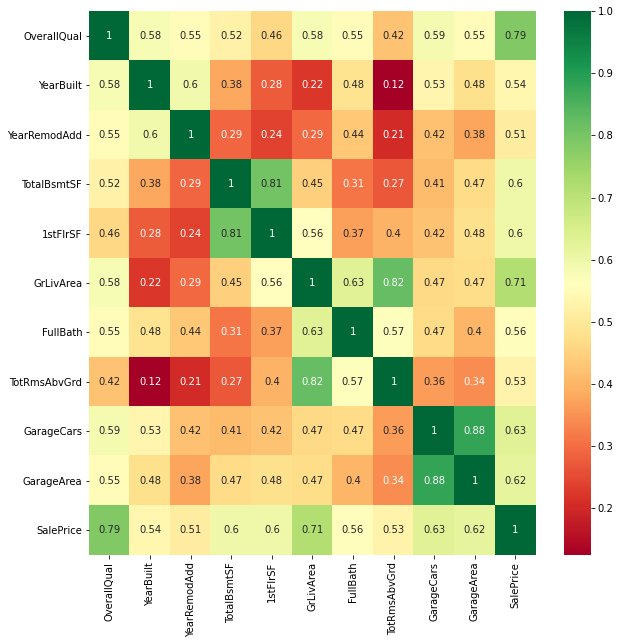

In [ ]:
# most correlated features
corrmat = train.corr()
top_corr_features = corrmat.index[abs(corrmat["SalePrice"])>0.5]
plt.figure(figsize=(10,10))
g = sns.heatmap(train[top_corr_features].corr(),annot=True,cmap="RdYlGn")




*   From this we can tell which features (OverallQual, GrLivArea and TotalBsmtSF ) are highly positively correlated with the SalePrice.
*   Garage Cars and Garage Are also seems correlated between them since the numbers of car that will fit into the garage will depend on Garage Area.



Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


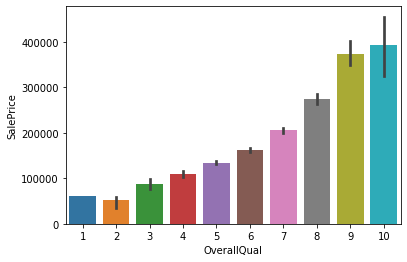

In [ ]:
sns.barplot(train.OverallQual,train.SalePrice)

We can see in this graph how when the rate of the OverallQual increases, the price also increases

Scatter plots between 'SalePrice' and correlated variables



The `size` parameter has been renamed to `height`; please update your code.


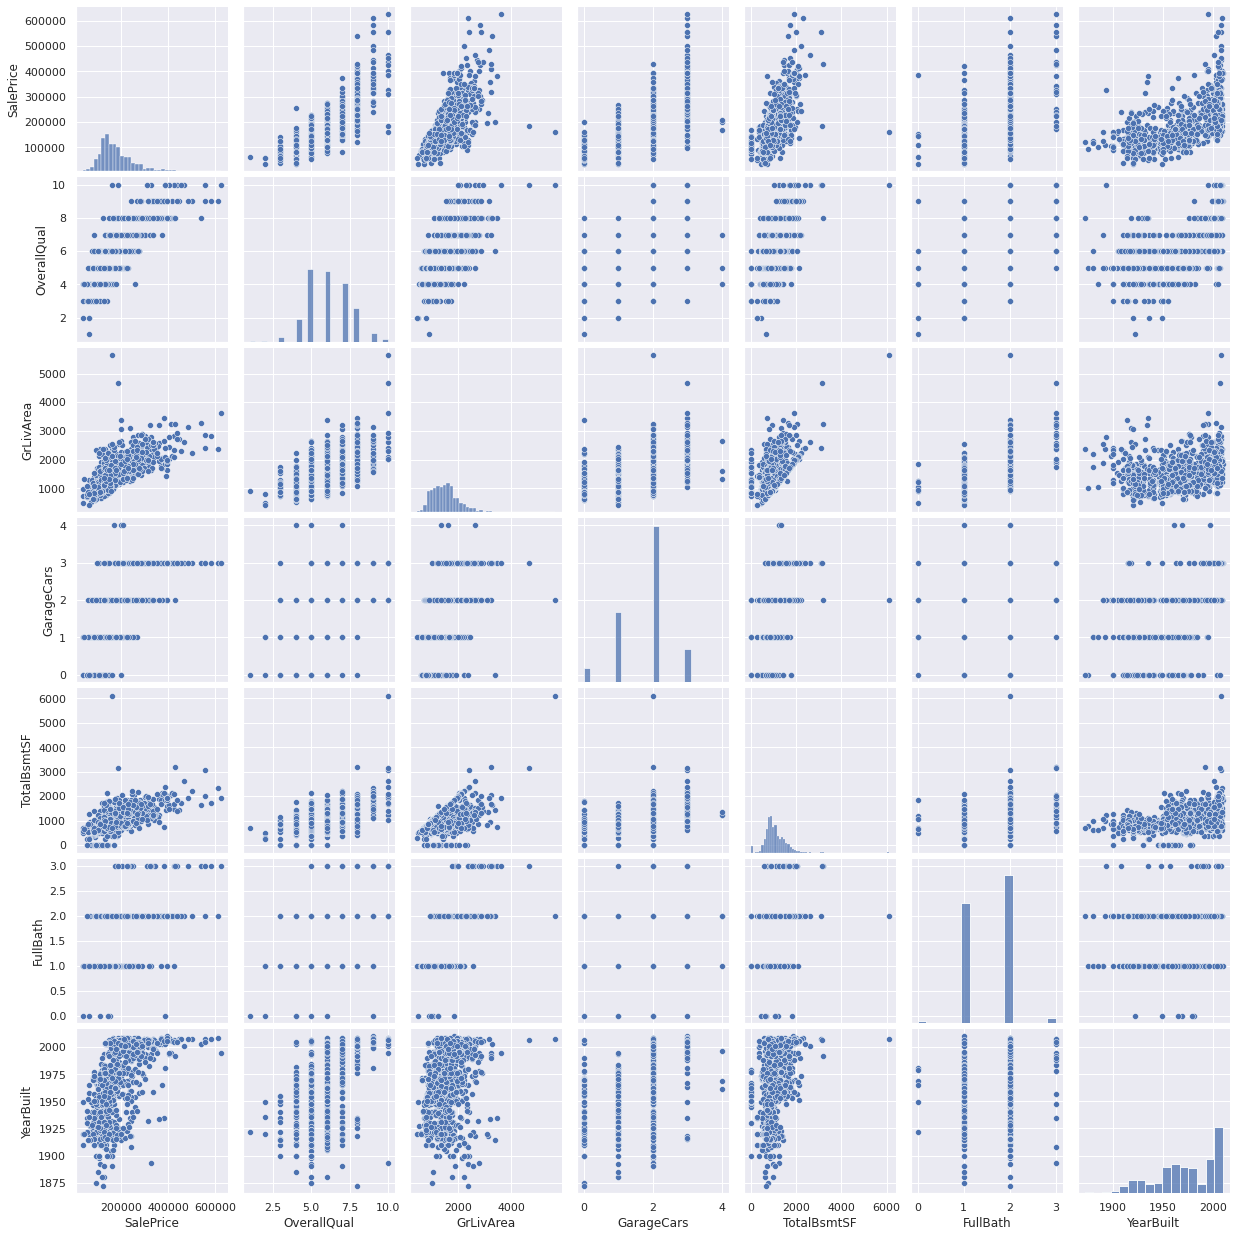

In [ ]:
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(train[cols], size = 2.5)
plt.show();

GrLiv Area and TotalBsmtSF seem to have linear relationship with SalePrice

**Feature Engineering**

In [ ]:
#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

In [ ]:
#Look at the variable to predict
train.SalePrice.describe()

count      1168.000000
mean     181165.499144
std       80441.740529
min       34900.000000
25%      129900.000000
50%      163500.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

**Skewness of target feature**

Skew is:  1.9579491432178684


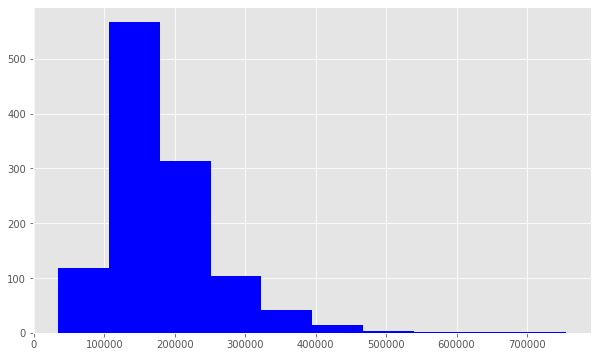

In [ ]:
print("Skew is: ", train.SalePrice.skew())
plt.style.use(style="ggplot")
plt.rcParams["figure.figsize"]=(10,6)
plt.hist(train.SalePrice,color="blue")
plt.show()

Our variable to predict is skewed so we apply the logarithm. The logarithm reduces the dynamic range of a variable so the differences are preserved while the scale is not that dramatically skewed.

In [ ]:
train["SalePrice"] = np.log1p(train["SalePrice"])
test["SalePrice"] = np.log1p(test["SalePrice"])

In [ ]:
# Visualize all the features that have missing values
test_missing = test.isna().sum() / test.shape[0]
test_missing[test_missing > 0.0].sort_values(ascending=False)

PoolQC          0.989726
MiscFeature     0.979452
Alley           0.952055
Fence           0.804795
FireplaceQu     0.465753
LotFrontage     0.154110
GarageType      0.058219
GarageYrBlt     0.058219
GarageFinish    0.058219
GarageQual      0.058219
GarageCond      0.058219
BsmtCond        0.023973
BsmtExposure    0.023973
BsmtFinType1    0.023973
BsmtFinType2    0.023973
BsmtQual        0.023973
MasVnrArea      0.003425
MasVnrType      0.003425
dtype: float64

In [ ]:
# Visualize all the features that have missing values
train_missing = train.isna().sum() / train.shape[0]
train_missing[train_missing > 0.0].sort_values(ascending=False)

PoolQC          0.996575
MiscFeature     0.958904
Alley           0.934075
Fence           0.808219
FireplaceQu     0.474315
LotFrontage     0.183219
GarageType      0.054795
GarageYrBlt     0.054795
GarageFinish    0.054795
GarageQual      0.054795
GarageCond      0.054795
BsmtExposure    0.026541
BsmtFinType2    0.026541
BsmtFinType1    0.025685
BsmtCond        0.025685
BsmtQual        0.025685
MasVnrArea      0.005993
MasVnrType      0.005993
Electrical      0.000856
dtype: float64

We have four features wih more than 0.8 percent of NaN. GarageType, GarageFinish, GarageQual, GarageCond and GarageYrBlt have the same percentage of null values.

Let's start to deal with these NaN values

In [ ]:
#NaN in Pool Quality means No Pool so replace these values by 'None'
train["PoolQC"] = train["PoolQC"].fillna("None")
test["PoolQC"] = test["PoolQC"].fillna("None")

In [ ]:
# MiscFeature : Data documentation says NA means "no misc feature"
train["MiscFeature"] = train["MiscFeature"].fillna("None")
test["MiscFeature"] = test["MiscFeature"].fillna("None")

In [ ]:
#Alley : data description says NA means "no alley access"
train["Alley"] = train["Alley"].fillna("None")
test["Alley"] = test["Alley"].fillna("None")

In [ ]:
#Fence : data description says NA means "no fence"
train["Fence"] = train["Fence"].fillna("None")
test["Fence"] = test["Fence"].fillna("None")

In [ ]:
#FireplaceQu : data description says NA means "no fireplace"
train["FireplaceQu"] = train["FireplaceQu"].fillna("None")
test["FireplaceQu"] = test["FireplaceQu"].fillna("None")

For LotFrontage we will fill the NA with the mean value of the feature

In [ ]:
train_median = train["LotFrontage"].median()
train["LotFrontage"] = train["LotFrontage"].fillna(train_median)
test["LotFrontage"] = test["LotFrontage"].fillna(train_median)

For all the features related to Garage the NA means No Garage so we will put None

In [ ]:
train["GarageType"] = train["GarageType"].fillna("None")
train["GarageFinish"] = train["GarageFinish"].fillna("None")
train["GarageQual"] = train["GarageQual"].fillna("None")
train["GarageCond"] = train["GarageCond"].fillna("None")
test["GarageType"] = test["GarageType"].fillna("None")
test["GarageFinish"] = test["GarageFinish"].fillna("None")
test["GarageQual"] = test["GarageQual"].fillna("None")
test["GarageCond"] = test["GarageCond"].fillna("None")

As NA means No Garage we will put 0 in GarageYrBlt as there isn't any garage built and the NA for the features related to Garage are in the same rows.

In [ ]:
train["GarageYrBlt"] = train["GarageYrBlt"].fillna("0")
test["GarageYrBlt"] = test["GarageYrBlt"].fillna("0")

For all the features related to Bsmt NA means No Basement so we will put None in these values

In [ ]:
train["BsmtFinType2"] = train["BsmtFinType2"].fillna("None")
train["BsmtExposure"] = train["BsmtExposure"].fillna("None")
train["BsmtQual"] = train["BsmtQual"].fillna("None")
train["BsmtFinType1"] = train["BsmtFinType1"].fillna("None")
train["BsmtCond"] = train["BsmtCond"].fillna("None")

test["BsmtFinType2"] = test["BsmtFinType2"].fillna("None")
test["BsmtExposure"] = test["BsmtExposure"].fillna("None")
test["BsmtQual"] = test["BsmtQual"].fillna("None")
test["BsmtFinType1"] = test["BsmtFinType1"].fillna("None")
test["BsmtCond"] = test["BsmtCond"].fillna("None")

For these two features as it's not clear that NA means no masonry veener we will replace the NA values by the values that appear most for the categorical feature MasVnrType and by the mean for MasVnrArea.

In [ ]:
train_MVT_mode = train["MasVnrType"].mode()[0]
train_MVA_median = train["MasVnrArea"].median()

train["MasVnrType"] = train["MasVnrType"].fillna(train_MVT_mode)
train["MasVnrArea"] = train["MasVnrArea"].fillna(train_MVA_median)

test["MasVnrType"] = test["MasVnrType"].fillna(train_MVT_mode)
test["MasVnrArea"] = test["MasVnrArea"].fillna(train_MVA_median)


For Electrical we will replace the NA with the most frequent value also


In [ ]:
train_electrical_mode = train["Electrical"].mode()[0]
train["Electrical"] = train["Electrical"].fillna(train_electrical_mode)
test["Electrical"] = test["Electrical"].fillna(train_electrical_mode)


In [ ]:
# Visualize all the features that have missing values
train_missing = train.isna().sum() / train.shape[0]
train_missing[train_missing > 0.0].sort_values(ascending=False)

Series([], dtype: float64)

In [ ]:
# Visualize all the features that have missing values
test_missing = test.isna().sum() / test.shape[0]
test_missing[test_missing > 0.0].sort_values(ascending=False)

Series([], dtype: float64)

In [ ]:
train.shape

(1168, 80)

In [ ]:
test.shape

(292, 80)

In [ ]:
train.head()

MSSubClass MSZoning  LotFrontage  ...  SaleType SaleCondition  SalePrice
1418          20       RL         71.0  ...       COD        Normal  11.728045
1436          20       RL         60.0  ...        WD        Normal  11.699413
661           60       RL         52.0  ...        WD        Normal  12.904210
100           20       RL         69.0  ...        WD        Normal  12.230770
933           20       RL         63.0  ...        WD        Normal  12.154785

[5 rows x 80 columns]

**Outliers**

An outlier is a data point that differs significantly from other observations

In [ ]:
# Select numeric features to visualize outliers
numeric_features=train.select_dtypes(include=[np.number])
for (columnName, _) in numeric_features.iteritems(): 
    print('Column Name: ' + columnName) 

Column Name: MSSubClass
Column Name: LotFrontage
Column Name: LotArea
Column Name: OverallQual
Column Name: OverallCond
Column Name: YearBuilt
Column Name: YearRemodAdd
Column Name: MasVnrArea
Column Name: BsmtFinSF1
Column Name: BsmtFinSF2
Column Name: BsmtUnfSF
Column Name: TotalBsmtSF
Column Name: 1stFlrSF
Column Name: 2ndFlrSF
Column Name: LowQualFinSF
Column Name: GrLivArea
Column Name: BsmtFullBath
Column Name: BsmtHalfBath
Column Name: FullBath
Column Name: HalfBath
Column Name: BedroomAbvGr
Column Name: KitchenAbvGr
Column Name: TotRmsAbvGrd
Column Name: Fireplaces
Column Name: GarageCars
Column Name: GarageArea
Column Name: WoodDeckSF
Column Name: OpenPorchSF
Column Name: EnclosedPorch
Column Name: 3SsnPorch
Column Name: ScreenPorch
Column Name: PoolArea
Column Name: MiscVal
Column Name: MoSold
Column Name: YrSold
Column Name: SalePrice


In [ ]:
# Based on the empirical rule we're going to print the quantity of outliers 
# by feature
for (columnName, columnData) in numeric_features.iteritems(): 
    data_mean, data_std = mean(columnData), std(columnData)
    print("Column name: " + columnName)
    
    # use the empirical rule
    cut_off = data_std * 3
    lower, upper = data_mean - cut_off, data_mean + cut_off

    # identify outliers
    outliers = [x for x in columnData if x < lower or x > upper]
    print("Identified outliers", len(outliers))

    # non outliers
    non_outliers = [x for x in columnData if x >= lower and x <= upper]
    print("Non-outlier observations", len(non_outliers))

Column name: MSSubClass
Identified outliers 23
Non-outlier observations 1145
Column name: LotFrontage
Identified outliers 11
Non-outlier observations 1157
Column name: LotArea
Identified outliers 12
Non-outlier observations 1156
Column name: OverallQual
Identified outliers 1
Non-outlier observations 1167
Column name: OverallCond
Identified outliers 16
Non-outlier observations 1152
Column name: YearBuilt
Identified outliers 4
Non-outlier observations 1164
Column name: YearRemodAdd
Identified outliers 0
Non-outlier observations 1168
Column name: MasVnrArea
Identified outliers 28
Non-outlier observations 1140
Column name: BsmtFinSF1
Identified outliers 5
Non-outlier observations 1163
Column name: BsmtFinSF2
Identified outliers 38
Non-outlier observations 1130
Column name: BsmtUnfSF
Identified outliers 9
Non-outlier observations 1159
Column name: TotalBsmtSF
Identified outliers 6
Non-outlier observations 1162
Column name: 1stFlrSF
Identified outliers 9
Non-outlier observations 1159
Column 

By this way we're going to delete many entries so we should try another mechanism or visualize some features in plots in order to visualize the data. We'll plot some features to see how they look but this is a job that can take much time if we want to visualize and understand each numerical feature. Another thing that it's possible to try is the method LocalOutlierFactor provided by sklearn.

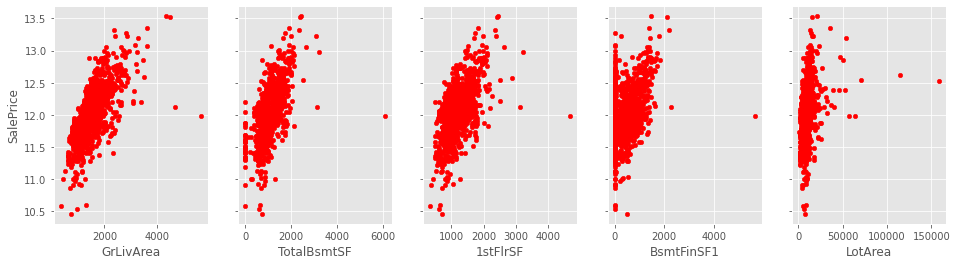

In [ ]:
fig, axes = plt.subplots(ncols=5, nrows=1, figsize=(16, 4))
axes = np.ravel(axes)
col_name = ['GrLivArea','TotalBsmtSF','1stFlrSF','BsmtFinSF1','LotArea']
for i, c in zip(range(5), col_name):
    train.plot.scatter(ax=axes[i], x=c, y='SalePrice', sharey=True, colorbar=False, c='r')


In [ ]:
qualitative

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition']

In [ ]:
nominal = ['MSZoning', 'Street', 'Alley', 'Utilities', 'LotConfig', 
              'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 
              'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
              'Foundation', 'Heating', 'CentralAir', 'Electrical', 'Functional', 
              'GarageType', 'MiscFeature', 'SaleType', 'SaleCondition']
ordinal = ['LotShape', 'LandContour', 'LandSlope', 'ExterQual', 'ExterCond', 'BsmtQual',
            'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 
            'KitchenQual', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 
            'PavedDrive', 'PoolQC', 'Fence']

From categorical variables we have some that are ordinals and some that are nominal. For ordinal variables we'll use target encoding and for nominal we'll use one hot encoding

In [ ]:
train.head()

MSSubClass MSZoning  LotFrontage  ...  SaleType SaleCondition  SalePrice
1418          20       RL         71.0  ...       COD        Normal  11.728045
1436          20       RL         60.0  ...        WD        Normal  11.699413
661           60       RL         52.0  ...        WD        Normal  12.904210
100           20       RL         69.0  ...        WD        Normal  12.230770
933           20       RL         63.0  ...        WD        Normal  12.154785

[5 rows x 80 columns]

**Target encoding**

In [ ]:
for var in ordinal:
  mean_encode = train.groupby(var)['SalePrice'].mean()
  train.loc[:, var] = train[var].map(mean_encode)
  test.loc[:, var] = test[var].map(mean_encode)

In [ ]:
train.shape

(1168, 80)

In [ ]:
test.shape

(292, 80)

In [ ]:
for var in ordinal:
    train[var] = train[var].astype("float64")
    test[var] = test[var].astype("float64")

In [ ]:
train.dtypes

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice        float64
Length: 80, dtype: object

In [ ]:
test.dtypes

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice        float64
Length: 80, dtype: object

GarageYrBlt has category data type, we'll convert it into float

In [ ]:
train['GarageYrBlt'] = train['GarageYrBlt'].astype("float64")
test['GarageYrBlt'] = test['GarageYrBlt'].astype("float64")


**One hot encoding**

In [ ]:
# With the drop first delete redundant
train = pd.get_dummies(train, drop_first=True)

In [ ]:
train.shape

(1168, 203)

In [ ]:
test = pd.get_dummies(test, drop_first=True)

In [ ]:
test.shape

(292, 172)

As we can see, train and test datasets are of different size so we will use inner join to leave them with the same size

In [ ]:
train, test = train.align(test, join='inner', axis=1)

In [ ]:
train.shape


(1168, 169)

In [ ]:
test.shape

(292, 169)

In [ ]:
# Visualize all the features that have missing values
test_missing = test.isna().sum() / test.shape[0]
test_missing[test_missing > 0.0].sort_values(ascending=False)

Series([], dtype: float64)

In [ ]:
y_train=train['SalePrice']
X_train=train.drop(["SalePrice"], axis=1)
y_test=test['SalePrice']
X_test=test.drop(["SalePrice"], axis=1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1168, 168)
(292, 168)
(1168,)
(292,)


**Models**

We'll start testing with some traditional models like linear regression, random forest and gradient boosting. Then we'll test with more current models like XGBoost, CatBoost and Light GBM.

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

**Linear Regression**

In [ ]:
lr=linear_model.LinearRegression()
lr.fit(X_train,y_train)
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)
mse_train = mean_squared_error(y_train,y_pred_train)
rmse_train = sqrt(mse_train)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)

print("MSE train: " + str(mse_train))
print("RMSE train: " + str(rmse_train))
print("MAPE train: " + str(mape_train))

mse_test = mean_squared_error(y_test,y_pred_test)
rmse_test = sqrt(mse_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)

print("MSE test: " + str(mse_test))
print("RMSE test: " + str(rmse_test))
print("MAPE test: " + str(mape_test))


MSE train: 0.011758562958972716
RMSE train: 0.10843690773427983
MAPE train: 0.623842236109943
MSE test: 0.06324092613609353
RMSE test: 0.25147748634041484
MAPE test: 0.9047708110214695


**Random Forest**

In [ ]:
rfc = RandomForestRegressor()
rfc.fit(X_train, y_train)
y_pred_train = rfc.predict(X_train)
y_pred_test = rfc.predict(X_test)

mse_train = mean_squared_error(y_train,y_pred_train)
rmse_train = sqrt(mse_train)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)

print("MSE train: " + str(mse_train))
print("RMSE train: " + str(rmse_train))
print("MAPE train: " + str(mape_train))

mse_test = mean_squared_error(y_test,y_pred_test)
rmse_test = sqrt(mse_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)

print("MSE test: " + str(mse_test))
print("RMSE test: " + str(rmse_test))
print("MAPE test: " + str(mape_test))


MSE train: 0.0030508668008183623
RMSE train: 0.05523465217432225
MAPE train: 0.3087407550970791
MSE test: 0.01908577465982662
RMSE test: 0.13815127455013443
MAPE test: 0.7877350143405298


Here we tested the RF alghoritm with a set of parameters of example and his performance is better than with Linear Regression taking into account the different types of errors.

In [ ]:
feature_list = list(train.columns)

# Get numerical feature importances
importances = list(rfc.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances if (pair[1] > 0.0)];


Variable: OverallQual          Importance: 0.58
Variable: GrLivArea            Importance: 0.09
Variable: GarageCars           Importance: 0.05
Variable: TotalBsmtSF          Importance: 0.03
Variable: 1stFlrSF             Importance: 0.03
Variable: BsmtFinSF1           Importance: 0.02
Variable: GarageArea           Importance: 0.02
Variable: LotFrontage          Importance: 0.01
Variable: LotArea              Importance: 0.01
Variable: OverallCond          Importance: 0.01
Variable: YearBuilt            Importance: 0.01
Variable: YearRemodAdd         Importance: 0.01
Variable: BsmtUnfSF            Importance: 0.01
Variable: 2ndFlrSF             Importance: 0.01
Variable: GarageYrBlt          Importance: 0.01
Variable: GarageFinish         Importance: 0.01
Variable: Heating_Wall         Importance: 0.01


These features seems to be the ones with importance in the prediction of Random Forest. We'll make a new set of train and train the model in order to see if the performance improves.

In [ ]:
new_train = train[['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'BsmtFinSF1',
                   'GarageArea', 'YearBuilt', '1stFlrSF', 'GarageCars', 
                   'LotFrontage', 'LotArea', 'OverallCond', 'GarageYrBlt',
                   'YearRemodAdd', 'BsmtUnfSF', '2ndFlrSF', 'Heating_Wall',
                   'GarageFinish', 'SalePrice']]
                   
new_test = test[['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'BsmtFinSF1',
                   'GarageArea', 'YearBuilt', '1stFlrSF', 'GarageCars', 
                   'LotFrontage', 'LotArea', 'OverallCond', 'GarageYrBlt',
                   'YearRemodAdd', 'BsmtUnfSF', '2ndFlrSF', 'Heating_Wall',
                   'GarageFinish', 'SalePrice']]

In [ ]:
new_train.shape

(1168, 18)

In [ ]:
new_test.shape

(292, 18)

In [ ]:
y_train_new = new_train['SalePrice']
X_train_new = new_train.drop(["SalePrice"], axis=1)
y_test_new = new_test['SalePrice']
X_test_new = new_test.drop(["SalePrice"], axis=1)
print(X_train_new.shape)
print(X_test_new.shape)
print(y_train_new.shape)
print(y_test_new.shape)

(1168, 17)
(292, 17)
(1168,)
(292,)


In [ ]:
rfc = RandomForestRegressor()
rfc.fit(X_train_new, y_train_new)
y_pred_train = rfc.predict(X_train_new)
y_pred_test = rfc.predict(X_test_new)

mse_train = mean_squared_error(y_train_new,y_pred_train)
rmse_train = sqrt(mse_train)
mape_train = mean_absolute_percentage_error(y_train_new, y_pred_train)

print("MSE train: " + str(mse_train))
print("RMSE train: " + str(rmse_train))
print("MAPE train: " + str(mape_train))

mse_test = mean_squared_error(y_test_new,y_pred_test)
rmse_test = sqrt(mse_test)
mape_test = mean_absolute_percentage_error(y_test_new, y_pred_test)

print("MSE test: " + str(mse_test))
print("RMSE test: " + str(rmse_test))
print("MAPE test: " + str(mape_test))

MSE train: 0.0030996830505626394
RMSE train: 0.05567479726557286
MAPE train: 0.31705259760633003
MSE test: 0.020344224028567982
RMSE test: 0.14263317997074867
MAPE test: 0.8134817484200128


In order to find the better combination of parameters we'll use RandomizedSearch over GridSearch as it's more efficient.

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 50, cv = 3, verbose=2, n_jobs = -1)


In [ ]:
rf_random.fit(X_train, y_train)
rf_random.best_params_


Fitting 3 folds for each of 50 candidates, totalling 150 fits


{'bootstrap': False,
 'max_depth': 40,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1400}

In [ ]:
rfc = RandomForestRegressor(n_estimators = 1400, bootstrap = False, max_depth = 40, max_features = 'sqrt', min_samples_leaf = 1, min_samples_split = 2)
rfc.fit(X_train, y_train)
y_pred_train = rfc.predict(X_train)
y_pred_test = rfc.predict(X_test)

mse_train = mean_squared_error(y_train,y_pred_train)
rmse_train = sqrt(mse_train)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)

print("MSE train: " + str(mse_train))
print("RMSE train: " + str(rmse_train))
print("MAPE train: " + str(mape_train))

mse_test = mean_squared_error(y_test,y_pred_test)
rmse_test = sqrt(mse_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)

print("MSE test: " + str(mse_test))
print("RMSE test: " + str(rmse_test))
print("MAPE test: " + str(mape_test))

MSE train: 5.552442597758082e-26
RMSE train: 2.356362153353784e-13
MAPE train: 1.7299149752311112e-12
MSE test: 0.016578489137132627
RMSE test: 0.12875748186856026
MAPE test: 0.7227601502982257


**Gradient Boosting**

In [ ]:
grad_boost = GradientBoostingRegressor()
grad_boost.fit(X_train, y_train)
y_pred_train = grad_boost.predict(X_train)
y_pred_test = grad_boost.predict(X_test)

mse_train = mean_squared_error(y_train,y_pred_train)
rmse_train = sqrt(mse_train)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)

print("MSE train: " + str(mse_train))
print("RMSE train: " + str(rmse_train))
print("MAPE train: " + str(mape_train))

mse_test = mean_squared_error(y_test,y_pred_test)
rmse_test = sqrt(mse_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)

print("MSE test: " + str(mse_test))
print("RMSE test: " + str(rmse_test))
print("MAPE test: " + str(mape_test))

MSE train: 0.006409321459383159
RMSE train: 0.08005823792329655
MAPE train: 0.4910444994709398
MSE test: 0.015265757759962481
RMSE test: 0.12355467518456144
MAPE test: 0.721092869765208


In [ ]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
learning_rate = [0.05,0.1,0.3]
max_depth = [int(x) for x in np.linspace(3, 18, num = 6)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
max_features = ['auto', 'sqrt']
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'learning_rate': learning_rate,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_features': max_features}

# Create a based model
grad_boost = GradientBoostingRegressor()
# Instantiate the grid search model
grad_search = RandomizedSearchCV(estimator = grad_boost, param_distributions = random_grid, n_iter = 50,
                          cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
grad_search.fit(X_train, y_train)
grad_search.best_params_


Fitting 3 folds for each of 50 candidates, totalling 150 fits


{'learning_rate': 0.1,
 'max_depth': 3,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 400}

In [ ]:
grad_boost = GradientBoostingRegressor(n_estimators = 400, max_features = 'sqrt',
                                       max_depth = 3, learning_rate = 0.1,
                                       min_samples_leaf = 1, min_samples_split = 5)
grad_boost.fit(X_train, y_train)
y_pred_train = grad_boost.predict(X_train)
y_pred_test = grad_boost.predict(X_test)

mse_train = mean_squared_error(y_train,y_pred_train)
rmse_train = sqrt(mse_train)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)

print("MSE train: " + str(mse_train))
print("RMSE train: " + str(rmse_train))
print("MAPE train: " + str(mape_train))

mse_test = mean_squared_error(y_test,y_pred_test)
rmse_test = sqrt(mse_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)

print("MSE test: " + str(mse_test))
print("RMSE test: " + str(rmse_test))
print("MAPE test: " + str(mape_test))

MSE train: 0.003084515347004526
RMSE train: 0.055538413256092635
MAPE train: 0.3413297589057144
MSE test: 0.013078931894461654
RMSE test: 0.11436315794197734
MAPE test: 0.6728931155844218


Now we'll try some current models and other libraries.

**XGB Regressor**

In [ ]:
xgb = xgboost.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,             
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=10000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42) 

xgb.fit(X_train, y_train)
y_pred_train = xgb.predict(X_train)
y_pred_test = xgb.predict(X_test)

mse_train = mean_squared_error(y_train,y_pred_train)
rmse_train = sqrt(mse_train)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)

print("MSE train: " + str(mse_train))
print("RMSE train: " + str(rmse_train))
print("MAPE train: " + str(mape_train))

mse_test = mean_squared_error(y_test,y_pred_test)
rmse_test = sqrt(mse_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)

print("MSE test: " + str(mse_test))
print("RMSE test: " + str(rmse_test))
print("MAPE test: " + str(mape_test))

[15:28:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE train: 0.0008029212256356951
RMSE train: 0.028335864653045176
MAPE train: 0.16841954777320736
MSE test: 0.013304562246165242
RMSE test: 0.11534540409641487
MAPE test: 0.6728155917967059


**CatBoost Regressor**

In [ ]:
cat_model = catboost.CatBoostRegressor(loss_function='RMSE', 
                                       random_seed=2, 
                                       max_depth = 10,
                                       learning_rate = 0.05,
                                       random_strength=1,
                                       max_ctr_complexity=1,
                                       l2_leaf_reg=8,
                                       grow_policy = 'Lossguide',
                                       task_type='GPU',
                                      )


cat_model.fit(X_train, y_train)
y_pred_train = cat_model.predict(X_train)
y_pred_test = cat_model.predict(X_test)

mse_train = mean_squared_error(y_train,y_pred_train)
rmse_train = sqrt(mse_train)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)

print("MSE train: " + str(mse_train))
print("RMSE train: " + str(rmse_train))
print("MAPE train: " + str(mape_train))

mse_test = mean_squared_error(y_test,y_pred_test)
rmse_test = sqrt(mse_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)

print("MSE test: " + str(mse_test))
print("RMSE test: " + str(rmse_test))
print("MAPE test: " + str(mape_test))

0:	learn: 0.3876114	total: 27.2ms	remaining: 27.2s
1:	learn: 0.3737733	total: 51.4ms	remaining: 25.7s
2:	learn: 0.3608526	total: 75ms	remaining: 24.9s
3:	learn: 0.3484134	total: 98.1ms	remaining: 24.4s
4:	learn: 0.3365251	total: 122ms	remaining: 24.3s
5:	learn: 0.3252458	total: 145ms	remaining: 24s
6:	learn: 0.3144195	total: 168ms	remaining: 23.9s
7:	learn: 0.3043718	total: 196ms	remaining: 24.3s
8:	learn: 0.2947447	total: 220ms	remaining: 24.2s
9:	learn: 0.2854685	total: 248ms	remaining: 24.6s
10:	learn: 0.2767146	total: 272ms	remaining: 24.4s
11:	learn: 0.2682499	total: 296ms	remaining: 24.3s
12:	learn: 0.2603981	total: 319ms	remaining: 24.3s
13:	learn: 0.2524003	total: 343ms	remaining: 24.2s
14:	learn: 0.2449925	total: 370ms	remaining: 24.3s
15:	learn: 0.2379741	total: 393ms	remaining: 24.2s
16:	learn: 0.2312121	total: 422ms	remaining: 24.4s
17:	learn: 0.2245470	total: 451ms	remaining: 24.6s
18:	learn: 0.2184984	total: 475ms	remaining: 24.5s
19:	learn: 0.2126520	total: 499ms	remaini

**Light GBM**

In [ ]:
lgbm_regressor = lgb.LGBMRegressor(colsample_bytree = 0.7, 
                                       max_depth = 45,
                                       learning_rate = 0.06,
                                       min_child_weight = 3.3,
                                       n_estimators = 700,
                                       num_leaves = 50
                                      )

lgbm_regressor.fit(X_train, y_train)
y_pred_train = lgbm_regressor.predict(X_train)
y_pred_test = lgbm_regressor.predict(X_test)

mse_train = mean_squared_error(y_train,y_pred_train)
rmse_train = sqrt(mse_train)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)

print("MSE train: " + str(mse_train))
print("RMSE train: " + str(rmse_train))
print("MAPE train: " + str(mape_train))

mse_test = mean_squared_error(y_test,y_pred_test)
rmse_test = sqrt(mse_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)

print("MSE test: " + str(mse_test))
print("RMSE test: " + str(rmse_test))
print("MAPE test: " + str(mape_test))

MSE train: 3.9079782008498806e-05
RMSE train: 0.0062513824077957995
MAPE train: 0.01937434339178866
MSE test: 0.014973641592025511
RMSE test: 0.12236683207481311
MAPE test: 0.7033373460198601


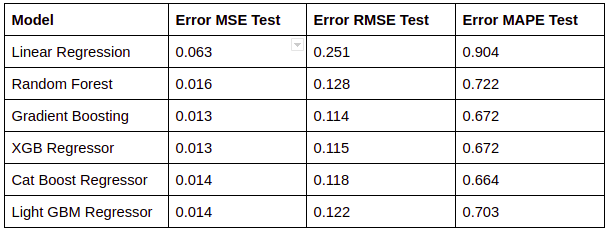

Now we're going to try some other tools like optuna, shap values in order to improve our work. We'll use these tools with Random Forest and XGB Regressor

In [ ]:
RANDOM_SEED = 42

# 10-fold CV
kfolds = KFold(n_splits=10, shuffle=True, random_state=RANDOM_SEED)

# Define the helper function so that it can be reused
def tune(objective):
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=1000)

    params = study.best_params
    best_score = study.best_value
    print(f"Best score: {best_score}\n")
    print(f"Optimized parameters: {params}\n")
    return params

In [ ]:
##################
# Random Forest
##################
def randomforest_objective(trial):
    _n_estimators = trial.suggest_int("n_estimators", 300, 900)
    _max_depth = trial.suggest_int("max_depth", 5, 20)
    _min_samp_split = trial.suggest_int("min_samples_split", 2, 10)
    _min_samples_leaf = trial.suggest_int("min_samples_leaf", 2, 10)
    _max_features = trial.suggest_int("max_features", 10, 50)

    rf = RandomForestRegressor(
        max_depth=_max_depth,
        min_samples_split=_min_samp_split,
        min_samples_leaf=_min_samples_leaf,
        max_features=_max_features,
        n_estimators=_n_estimators,
        n_jobs=-1,
        random_state=RANDOM_SEED,
    )

    scores = cross_val_score(
        rf, X_train, y_train, cv=kfolds, scoring="neg_root_mean_squared_error"
    )
    return scores.mean()

randomforest_params = tune(randomforest_objective)
rf = RandomForestRegressor(n_jobs=-1, random_state=RANDOM_SEED, **randomforest_params)


[I 2021-04-26 15:49:28,981] A new study created in memory with name: no-name-ab5394d1-a137-4fff-b256-dc37e4a88be4
[I 2021-04-26 15:49:44,021] Trial 0 finished with value: -0.16036643249847526 and parameters: {'n_estimators': 390, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 9, 'max_features': 40}. Best is trial 0 with value: -0.16036643249847526.
[I 2021-04-26 15:50:06,334] Trial 1 finished with value: -0.1542509726978786 and parameters: {'n_estimators': 673, 'max_depth': 20, 'min_samples_split': 6, 'min_samples_leaf': 10, 'max_features': 29}. Best is trial 0 with value: -0.16036643249847526.
[I 2021-04-26 15:50:31,584] Trial 2 finished with value: -0.15930974187691252 and parameters: {'n_estimators': 731, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 7, 'max_features': 49}. Best is trial 0 with value: -0.16036643249847526.
[I 2021-04-26 15:50:45,408] Trial 3 finished with value: -0.155690751448397 and parameters: {'n_estimators': 410, 'max_depth': 9, 'min_

Best score: -0.18034339272332883

Optimized parameters: {'n_estimators': 456, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 8, 'max_features': 10}



In [ ]:
rfc = RandomForestRegressor(n_estimators = 802, max_depth = 5, min_samples_leaf = 10, min_samples_split = 6, max_features=10)
rfc.fit(X_train, y_train)
y_pred_train = rfc.predict(X_train)
y_pred_test = rfc.predict(X_test)
mse_train = mean_squared_error(y_train,y_pred_train)
rmse_train = sqrt(mse_train)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)

print("MSE train: " + str(mse_train))
print("RMSE train: " + str(rmse_train))
print("MAPE train: " + str(mape_train))

mse_test = mean_squared_error(y_test,y_pred_test)
rmse_test = sqrt(mse_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)

print("MSE test: " + str(mse_test))
print("RMSE test: " + str(rmse_test))
print("MAPE test: " + str(mape_test))

MSE train: 0.03235699248377597
RMSE train: 0.17988049500647915
MAPE train: 1.0284546421947944
MSE test: 0.04823869503134046
RMSE test: 0.21963309184032462
MAPE test: 1.2490941850076744


In [ ]:
##################
# XGBoost
##################
def xgboost_objective(trial):
    _colsample_bytree = trial.suggest_float("colsample_bytree", 0.1, 0.9, log = True)
    _gamma = trial.suggest_int("gamma", 0, 10)
    _learning_rate = trial.suggest_float("learning_rate", 0.1, 0.6, log = True)
    _max_depth = trial.suggest_int("max_depth", 3, 9)
    _min_child_weight = trial.suggest_int("min_child_weight", 1, 9)
    _reg_alpha = trial.suggest_float("reg_alpha", 0.3, 0.9, log = True)
    _reg_lambda = trial.suggest_float("reg_lambda", 0.3, 0.9, log = True)
    _subsample = trial.suggest_float("subsample", 0.1, 0.9, log = True)
    xgb = xgboost.XGBRegressor(
        colsample_bytree=_colsample_bytree,
        gamma = _gamma,
        learning_rate = _learning_rate,
        max_depth = _max_depth,
        min_child_weight = _min_child_weight,
        reg_alpha = _reg_alpha,
        reg_lambda = _reg_lambda,
        subsample = _subsample,
        n_jobs=-1,
        random_state=RANDOM_SEED,
    )

    scores = cross_val_score(
        xgb, X_train, y_train, cv=kfolds, scoring="neg_root_mean_squared_error"
    )
    return scores.mean()

xgboost_params = tune(xgboost_objective)
xgb = xgboost.XGBRegressor(n_jobs=-1, random_state=RANDOM_SEED, **xgboost_params)

[I 2021-04-26 16:25:16,220] A new study created in memory with name: no-name-944eba45-04ed-4863-b27c-23feaaa7fb33


[16:25:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:25:17,673] Trial 0 finished with value: -0.25631440317720255 and parameters: {'colsample_bytree': 0.11847208133662587, 'gamma': 7, 'learning_rate': 0.15173214363854018, 'max_depth': 4, 'min_child_weight': 8, 'reg_alpha': 0.7669638953547272, 'reg_lambda': 0.8973143619389171, 'subsample': 0.3376582564774488}. Best is trial 0 with value: -0.25631440317720255.


[16:25:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:25:22,332] Trial 1 finished with value: -0.2339237359417225 and parameters: {'colsample_bytree': 0.5111719794510745, 'gamma': 10, 'learning_rate': 0.4335997753927769, 'max_depth': 6, 'min_child_weight': 4, 'reg_alpha': 0.4945620071365782, 'reg_lambda': 0.34841039922387995, 'subsample': 0.8988404205345606}. Best is trial 0 with value: -0.25631440317720255.


[16:25:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:25:25,541] Trial 2 finished with value: -0.20270184033893038 and parameters: {'colsample_bytree': 0.44076293484652196, 'gamma': 2, 'learning_rate': 0.31680343314518156, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8616331824800088, 'reg_lambda': 0.44709476815832844, 'subsample': 0.20860374422293823}. Best is trial 0 with value: -0.25631440317720255.


[16:25:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:25:30,206] Trial 3 finished with value: -0.21839806483067709 and parameters: {'colsample_bytree': 0.27172733638293417, 'gamma': 6, 'learning_rate': 0.48214487754451496, 'max_depth': 9, 'min_child_weight': 3, 'reg_alpha': 0.5960853724224969, 'reg_lambda': 0.787159215596684, 'subsample': 0.7000495641370882}. Best is trial 0 with value: -0.25631440317720255.


[16:25:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:25:32,623] Trial 4 finished with value: -0.19371355830008471 and parameters: {'colsample_bytree': 0.3821204499875316, 'gamma': 3, 'learning_rate': 0.19225127888969187, 'max_depth': 3, 'min_child_weight': 5, 'reg_alpha': 0.5202636880224153, 'reg_lambda': 0.5183092371990886, 'subsample': 0.448756106727849}. Best is trial 0 with value: -0.25631440317720255.


[16:25:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:25:40,334] Trial 5 finished with value: -0.23307108466597545 and parameters: {'colsample_bytree': 0.515654195383689, 'gamma': 10, 'learning_rate': 0.4356097591873915, 'max_depth': 9, 'min_child_weight': 3, 'reg_alpha': 0.40648227651489205, 'reg_lambda': 0.5861549401329343, 'subsample': 0.7301380223955347}. Best is trial 0 with value: -0.25631440317720255.


[16:25:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:25:44,100] Trial 6 finished with value: -0.14852157512232456 and parameters: {'colsample_bytree': 0.6152836562663556, 'gamma': 0, 'learning_rate': 0.3177316782466965, 'max_depth': 5, 'min_child_weight': 7, 'reg_alpha': 0.6385101264615866, 'reg_lambda': 0.7876545737359253, 'subsample': 0.26257382549724906}. Best is trial 0 with value: -0.25631440317720255.


[16:25:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:25:46,353] Trial 7 finished with value: -0.2293535903960123 and parameters: {'colsample_bytree': 0.20538767756660786, 'gamma': 9, 'learning_rate': 0.1841809614071103, 'max_depth': 5, 'min_child_weight': 6, 'reg_alpha': 0.5040612740667054, 'reg_lambda': 0.7042302435941482, 'subsample': 0.8061244679716214}. Best is trial 0 with value: -0.25631440317720255.


[16:25:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:25:49,170] Trial 8 finished with value: -0.28081815538204874 and parameters: {'colsample_bytree': 0.5615246530625867, 'gamma': 8, 'learning_rate': 0.13220928328461867, 'max_depth': 4, 'min_child_weight': 2, 'reg_alpha': 0.6083794412037541, 'reg_lambda': 0.5667492940562332, 'subsample': 0.23057190442050834}. Best is trial 8 with value: -0.28081815538204874.


[16:25:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:25:50,995] Trial 9 finished with value: -0.20213736221944636 and parameters: {'colsample_bytree': 0.10929532955282335, 'gamma': 3, 'learning_rate': 0.17733865995888157, 'max_depth': 7, 'min_child_weight': 6, 'reg_alpha': 0.33677854385455985, 'reg_lambda': 0.6372622063400686, 'subsample': 0.3649931222553097}. Best is trial 8 with value: -0.28081815538204874.


[16:25:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:25:53,291] Trial 10 finished with value: -0.33744317030532234 and parameters: {'colsample_bytree': 0.7849284084938869, 'gamma': 8, 'learning_rate': 0.10105143998563634, 'max_depth': 3, 'min_child_weight': 1, 'reg_alpha': 0.7047653354076051, 'reg_lambda': 0.3993168712503114, 'subsample': 0.10884847135618995}. Best is trial 10 with value: -0.33744317030532234.


[16:25:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:25:55,708] Trial 11 finished with value: -0.339822684157394 and parameters: {'colsample_bytree': 0.8507546912317281, 'gamma': 8, 'learning_rate': 0.10501087146168328, 'max_depth': 3, 'min_child_weight': 1, 'reg_alpha': 0.700522727099406, 'reg_lambda': 0.38335137171663747, 'subsample': 0.10555340395858347}. Best is trial 11 with value: -0.339822684157394.


[16:25:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:25:58,131] Trial 12 finished with value: -0.29325429988296403 and parameters: {'colsample_bytree': 0.8531670515242071, 'gamma': 5, 'learning_rate': 0.10049826725012552, 'max_depth': 3, 'min_child_weight': 1, 'reg_alpha': 0.7648044457072476, 'reg_lambda': 0.31279202932209366, 'subsample': 0.10545995387636774}. Best is trial 11 with value: -0.339822684157394.


[16:25:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:26:00,579] Trial 13 finished with value: -0.34184981268281467 and parameters: {'colsample_bytree': 0.8877595530428296, 'gamma': 8, 'learning_rate': 0.10494796488520033, 'max_depth': 3, 'min_child_weight': 1, 'reg_alpha': 0.8654833637585496, 'reg_lambda': 0.3878828142746885, 'subsample': 0.10667981642800935}. Best is trial 13 with value: -0.34184981268281467.


[16:26:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:26:03,802] Trial 14 finished with value: -0.30037895207879173 and parameters: {'colsample_bytree': 0.8344154227449063, 'gamma': 7, 'learning_rate': 0.1204353048714635, 'max_depth': 4, 'min_child_weight': 1, 'reg_alpha': 0.8773123273580887, 'reg_lambda': 0.3752998905686202, 'subsample': 0.1500621780707105}. Best is trial 13 with value: -0.34184981268281467.


[16:26:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:26:08,199] Trial 15 finished with value: -0.3329305443063918 and parameters: {'colsample_bytree': 0.8910215449783271, 'gamma': 9, 'learning_rate': 0.10060279478700974, 'max_depth': 7, 'min_child_weight': 2, 'reg_alpha': 0.8943064693711766, 'reg_lambda': 0.45220430187838045, 'subsample': 0.14374756209601927}. Best is trial 13 with value: -0.34184981268281467.


[16:26:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:26:09,576] Trial 16 finished with value: -0.2689928541078626 and parameters: {'colsample_bytree': 0.1748764947351437, 'gamma': 5, 'learning_rate': 0.23629258699883546, 'max_depth': 3, 'min_child_weight': 2, 'reg_alpha': 0.7246864618555771, 'reg_lambda': 0.30075761391188577, 'subsample': 0.1472830184088965}. Best is trial 13 with value: -0.34184981268281467.


[16:26:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:26:12,347] Trial 17 finished with value: -0.32893814560256235 and parameters: {'colsample_bytree': 0.7021895095039768, 'gamma': 7, 'learning_rate': 0.1278642709175557, 'max_depth': 5, 'min_child_weight': 4, 'reg_alpha': 0.8226881459081955, 'reg_lambda': 0.4355608170859094, 'subsample': 0.10128729490011434}. Best is trial 13 with value: -0.34184981268281467.


[16:26:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:26:14,585] Trial 18 finished with value: -0.3099348750579611 and parameters: {'colsample_bytree': 0.3848665504110528, 'gamma': 9, 'learning_rate': 0.15204146933481488, 'max_depth': 4, 'min_child_weight': 1, 'reg_alpha': 0.6683205424710955, 'reg_lambda': 0.34320035785122555, 'subsample': 0.17885343754777258}. Best is trial 13 with value: -0.34184981268281467.


[16:26:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:26:16,593] Trial 19 finished with value: -0.306310726320396 and parameters: {'colsample_bytree': 0.3026446567920097, 'gamma': 6, 'learning_rate': 0.1177938623690313, 'max_depth': 7, 'min_child_weight': 3, 'reg_alpha': 0.8077707607122075, 'reg_lambda': 0.5051962145084472, 'subsample': 0.11758232389279757}. Best is trial 13 with value: -0.34184981268281467.


[16:26:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:26:20,164] Trial 20 finished with value: -0.3335725948863236 and parameters: {'colsample_bytree': 0.656665122312987, 'gamma': 10, 'learning_rate': 0.24454950888972354, 'max_depth': 6, 'min_child_weight': 2, 'reg_alpha': 0.5460644826913229, 'reg_lambda': 0.396400552211014, 'subsample': 0.1276728462285398}. Best is trial 13 with value: -0.34184981268281467.


[16:26:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:26:22,375] Trial 21 finished with value: -0.3470817841731254 and parameters: {'colsample_bytree': 0.7538284556410605, 'gamma': 8, 'learning_rate': 0.10059494060700913, 'max_depth': 3, 'min_child_weight': 1, 'reg_alpha': 0.7013077121300721, 'reg_lambda': 0.39406370023216575, 'subsample': 0.10296366609882686}. Best is trial 21 with value: -0.3470817841731254.


[16:26:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:26:25,138] Trial 22 finished with value: -0.2961173286363984 and parameters: {'colsample_bytree': 0.8568005512478847, 'gamma': 8, 'learning_rate': 0.10224869198542909, 'max_depth': 3, 'min_child_weight': 1, 'reg_alpha': 0.4396885018149948, 'reg_lambda': 0.3353998136853974, 'subsample': 0.17528151310036064}. Best is trial 21 with value: -0.3470817841731254.


[16:26:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:26:27,862] Trial 23 finished with value: -0.3103927401314812 and parameters: {'colsample_bytree': 0.7454332613787304, 'gamma': 6, 'learning_rate': 0.14502215800195953, 'max_depth': 4, 'min_child_weight': 2, 'reg_alpha': 0.6945949268217992, 'reg_lambda': 0.3760517236214116, 'subsample': 0.10173227470011136}. Best is trial 21 with value: -0.3470817841731254.


[16:26:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:26:30,481] Trial 24 finished with value: -0.32368256211770874 and parameters: {'colsample_bytree': 0.8956857690163771, 'gamma': 8, 'learning_rate': 0.111513044799109, 'max_depth': 3, 'min_child_weight': 1, 'reg_alpha': 0.5618261279389919, 'reg_lambda': 0.47877914219071804, 'subsample': 0.12754227407087934}. Best is trial 21 with value: -0.3470817841731254.


[16:26:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:26:33,242] Trial 25 finished with value: -0.31556101995190505 and parameters: {'colsample_bytree': 0.6505714226834121, 'gamma': 9, 'learning_rate': 0.11298093884902737, 'max_depth': 4, 'min_child_weight': 3, 'reg_alpha': 0.7536704676677298, 'reg_lambda': 0.4047725348117538, 'subsample': 0.1703654183322501}. Best is trial 21 with value: -0.3470817841731254.


[16:26:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:26:35,641] Trial 26 finished with value: -0.3056685829741436 and parameters: {'colsample_bytree': 0.46116390569770394, 'gamma': 7, 'learning_rate': 0.14277507620161844, 'max_depth': 5, 'min_child_weight': 4, 'reg_alpha': 0.6200480416503685, 'reg_lambda': 0.31944736199913965, 'subsample': 0.1249409793588216}. Best is trial 21 with value: -0.3470817841731254.


[16:26:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:26:39,565] Trial 27 finished with value: -0.22006248188819452 and parameters: {'colsample_bytree': 0.7194494659660418, 'gamma': 4, 'learning_rate': 0.5991625813623093, 'max_depth': 3, 'min_child_weight': 2, 'reg_alpha': 0.8965612611685264, 'reg_lambda': 0.4213807651296601, 'subsample': 0.5314730518073366}. Best is trial 21 with value: -0.3470817841731254.


[16:26:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:26:44,249] Trial 28 finished with value: -0.30658133682675004 and parameters: {'colsample_bytree': 0.584028625519043, 'gamma': 10, 'learning_rate': 0.168286109139738, 'max_depth': 8, 'min_child_weight': 1, 'reg_alpha': 0.8066862427430033, 'reg_lambda': 0.36457038662168584, 'subsample': 0.20863643504893375}. Best is trial 21 with value: -0.3470817841731254.


[16:26:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:26:45,803] Trial 29 finished with value: -0.2417649532662324 and parameters: {'colsample_bytree': 0.13079241082511311, 'gamma': 6, 'learning_rate': 0.2010631517646111, 'max_depth': 4, 'min_child_weight': 3, 'reg_alpha': 0.6630091825572592, 'reg_lambda': 0.4701974599693317, 'subsample': 0.33616090774907464}. Best is trial 21 with value: -0.3470817841731254.


[16:26:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:26:47,327] Trial 30 finished with value: -0.32473544473262156 and parameters: {'colsample_bytree': 0.3271207381583132, 'gamma': 7, 'learning_rate': 0.1630334771388747, 'max_depth': 3, 'min_child_weight': 2, 'reg_alpha': 0.7449645886116848, 'reg_lambda': 0.36436554472228994, 'subsample': 0.10255657464873302}. Best is trial 21 with value: -0.3470817841731254.


[16:26:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:26:49,698] Trial 31 finished with value: -0.3315927733369105 and parameters: {'colsample_bytree': 0.7755825880639718, 'gamma': 8, 'learning_rate': 0.10642682950189387, 'max_depth': 3, 'min_child_weight': 1, 'reg_alpha': 0.6956315392396826, 'reg_lambda': 0.4053403014809194, 'subsample': 0.11536453350355479}. Best is trial 21 with value: -0.3470817841731254.


[16:26:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:26:51,996] Trial 32 finished with value: -0.33788150438294184 and parameters: {'colsample_bytree': 0.7626224765905877, 'gamma': 8, 'learning_rate': 0.1325205407700637, 'max_depth': 3, 'min_child_weight': 1, 'reg_alpha': 0.7068042144370154, 'reg_lambda': 0.3344708419254671, 'subsample': 0.10310565665237477}. Best is trial 21 with value: -0.3470817841731254.


[16:26:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:26:55,057] Trial 33 finished with value: -0.32688269659906694 and parameters: {'colsample_bytree': 0.8843489730706671, 'gamma': 9, 'learning_rate': 0.13034018745039028, 'max_depth': 4, 'min_child_weight': 9, 'reg_alpha': 0.8029222539537625, 'reg_lambda': 0.32500075250753174, 'subsample': 0.1385128070787234}. Best is trial 21 with value: -0.3470817841731254.


[16:26:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:26:57,258] Trial 34 finished with value: -0.32666903994606733 and parameters: {'colsample_bytree': 0.5299310416703938, 'gamma': 7, 'learning_rate': 0.1225896335968662, 'max_depth': 4, 'min_child_weight': 1, 'reg_alpha': 0.5648398554870963, 'reg_lambda': 0.34758617754994436, 'subsample': 0.10015867393730965}. Best is trial 21 with value: -0.3470817841731254.


[16:26:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:26:59,213] Trial 35 finished with value: -0.29499124435915747 and parameters: {'colsample_bytree': 0.45720327917187464, 'gamma': 8, 'learning_rate': 0.3200261284211292, 'max_depth': 3, 'min_child_weight': 2, 'reg_alpha': 0.46687514448792183, 'reg_lambda': 0.37813265680226793, 'subsample': 0.1580331051689418}. Best is trial 21 with value: -0.3470817841731254.


[16:26:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:27:01,374] Trial 36 finished with value: -0.35719322944118986 and parameters: {'colsample_bytree': 0.6629910600783786, 'gamma': 10, 'learning_rate': 0.13650605176983988, 'max_depth': 3, 'min_child_weight': 3, 'reg_alpha': 0.8500974408487889, 'reg_lambda': 0.3114643287156369, 'subsample': 0.11654320998898421}. Best is trial 36 with value: -0.35719322944118986.


[16:27:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:27:04,182] Trial 37 finished with value: -0.34991594925613934 and parameters: {'colsample_bytree': 0.6507839487325425, 'gamma': 10, 'learning_rate': 0.1077972078469508, 'max_depth': 5, 'min_child_weight': 4, 'reg_alpha': 0.8561776254428641, 'reg_lambda': 0.30139964669480646, 'subsample': 0.12913273189216845}. Best is trial 36 with value: -0.35719322944118986.


[16:27:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:27:06,852] Trial 38 finished with value: -0.3074656669964623 and parameters: {'colsample_bytree': 0.41261958354215106, 'gamma': 10, 'learning_rate': 0.21067071485291725, 'max_depth': 5, 'min_child_weight': 4, 'reg_alpha': 0.8477482576104434, 'reg_lambda': 0.31102377253648844, 'subsample': 0.20395753776923048}. Best is trial 36 with value: -0.35719322944118986.


[16:27:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:27:09,866] Trial 39 finished with value: -0.34639197369965175 and parameters: {'colsample_bytree': 0.6157546576738624, 'gamma': 10, 'learning_rate': 0.15121843991734737, 'max_depth': 6, 'min_child_weight': 5, 'reg_alpha': 0.8989858620045807, 'reg_lambda': 0.30209110647055426, 'subsample': 0.1279790016848072}. Best is trial 36 with value: -0.35719322944118986.


[16:27:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:27:13,635] Trial 40 finished with value: -0.28604163354215206 and parameters: {'colsample_bytree': 0.4949759797178882, 'gamma': 10, 'learning_rate': 0.2753556759218731, 'max_depth': 6, 'min_child_weight': 5, 'reg_alpha': 0.7703402338240963, 'reg_lambda': 0.30094157384638387, 'subsample': 0.2562887582727684}. Best is trial 36 with value: -0.35719322944118986.


[16:27:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:27:16,552] Trial 41 finished with value: -0.3465513934839404 and parameters: {'colsample_bytree': 0.6106815828597864, 'gamma': 10, 'learning_rate': 0.14370590279318884, 'max_depth': 6, 'min_child_weight': 6, 'reg_alpha': 0.8960127782061185, 'reg_lambda': 0.3106524598102221, 'subsample': 0.12704584940343455}. Best is trial 36 with value: -0.35719322944118986.


[16:27:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:27:19,442] Trial 42 finished with value: -0.34273262300822827 and parameters: {'colsample_bytree': 0.600246769186203, 'gamma': 10, 'learning_rate': 0.15570173932723025, 'max_depth': 6, 'min_child_weight': 6, 'reg_alpha': 0.8939196010796344, 'reg_lambda': 0.30033270647388377, 'subsample': 0.13301408468875955}. Best is trial 36 with value: -0.35719322944118986.


[16:27:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:27:22,348] Trial 43 finished with value: -0.3516563462139332 and parameters: {'colsample_bytree': 0.656672041598837, 'gamma': 10, 'learning_rate': 0.14025772229917005, 'max_depth': 6, 'min_child_weight': 7, 'reg_alpha': 0.8309563389308532, 'reg_lambda': 0.35521632853959356, 'subsample': 0.11991703332414508}. Best is trial 36 with value: -0.35719322944118986.


[16:27:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:27:24,867] Trial 44 finished with value: -0.14237831812272167 and parameters: {'colsample_bytree': 0.5328787101707654, 'gamma': 0, 'learning_rate': 0.13844689639394198, 'max_depth': 7, 'min_child_weight': 8, 'reg_alpha': 0.83328697600625, 'reg_lambda': 0.3512797979867144, 'subsample': 0.11680249974838809}. Best is trial 36 with value: -0.35719322944118986.


[16:27:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:27:28,093] Trial 45 finished with value: -0.31355017838009724 and parameters: {'colsample_bytree': 0.6777253436010564, 'gamma': 9, 'learning_rate': 0.171846925409108, 'max_depth': 5, 'min_child_weight': 7, 'reg_alpha': 0.7841979763214709, 'reg_lambda': 0.3246375732087157, 'subsample': 0.16146904555966246}. Best is trial 36 with value: -0.35719322944118986.


[16:27:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:27:31,418] Trial 46 finished with value: -0.3042247411144193 and parameters: {'colsample_bytree': 0.5688354505090711, 'gamma': 9, 'learning_rate': 0.11661576910384809, 'max_depth': 6, 'min_child_weight': 7, 'reg_alpha': 0.34529485836282336, 'reg_lambda': 0.3573465145298444, 'subsample': 0.1937962513240774}. Best is trial 36 with value: -0.35719322944118986.


[16:27:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:27:33,022] Trial 47 finished with value: -0.3490000310673923 and parameters: {'colsample_bytree': 0.23007406221922294, 'gamma': 10, 'learning_rate': 0.1896368466645965, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8426236091936751, 'reg_lambda': 0.3301717174897298, 'subsample': 0.11690667106619765}. Best is trial 36 with value: -0.35719322944118986.


[16:27:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:27:34,721] Trial 48 finished with value: -0.34234036248886257 and parameters: {'colsample_bytree': 0.256332264805628, 'gamma': 9, 'learning_rate': 0.18725014401758952, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8445739907801444, 'reg_lambda': 0.33476403387844106, 'subsample': 0.11514286224779885}. Best is trial 36 with value: -0.35719322944118986.


[16:27:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:27:36,659] Trial 49 finished with value: -0.20776963203819263 and parameters: {'colsample_bytree': 0.21518359763619907, 'gamma': 2, 'learning_rate': 0.222153399288274, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.6521038090829032, 'reg_lambda': 0.3251006259441367, 'subsample': 0.15086405534446934}. Best is trial 36 with value: -0.35719322944118986.


[16:27:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:27:38,172] Trial 50 finished with value: -0.3340991704084082 and parameters: {'colsample_bytree': 0.18146541422070028, 'gamma': 9, 'learning_rate': 0.12533641790461292, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.7408001212542259, 'reg_lambda': 0.4309921516331728, 'subsample': 0.14173415201029213}. Best is trial 36 with value: -0.35719322944118986.


[16:27:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:27:39,870] Trial 51 finished with value: -0.3587013560356026 and parameters: {'colsample_bytree': 0.24265220217504194, 'gamma': 10, 'learning_rate': 0.17826865386390625, 'max_depth': 7, 'min_child_weight': 6, 'reg_alpha': 0.8723259498164797, 'reg_lambda': 0.31650150430770235, 'subsample': 0.11331479148644008}. Best is trial 51 with value: -0.3587013560356026.


[16:27:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:27:41,564] Trial 52 finished with value: -0.3458628231621422 and parameters: {'colsample_bytree': 0.24556288051458822, 'gamma': 10, 'learning_rate': 0.26778132704411683, 'max_depth': 8, 'min_child_weight': 7, 'reg_alpha': 0.8678868145773047, 'reg_lambda': 0.35408855876624146, 'subsample': 0.11330660304770296}. Best is trial 51 with value: -0.3587013560356026.


[16:27:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:27:43,132] Trial 53 finished with value: -0.3581061197119175 and parameters: {'colsample_bytree': 0.21215140105170197, 'gamma': 10, 'learning_rate': 0.1582280417410176, 'max_depth': 7, 'min_child_weight': 6, 'reg_alpha': 0.7901944467609644, 'reg_lambda': 0.8889198014733397, 'subsample': 0.11139783866201823}. Best is trial 51 with value: -0.3587013560356026.


[16:27:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:27:44,894] Trial 54 finished with value: -0.3355838307657078 and parameters: {'colsample_bytree': 0.2204483706022754, 'gamma': 10, 'learning_rate': 0.19549811466290834, 'max_depth': 7, 'min_child_weight': 6, 'reg_alpha': 0.776728540624739, 'reg_lambda': 0.7152279719731478, 'subsample': 0.13926834528745985}. Best is trial 51 with value: -0.3587013560356026.


[16:27:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:27:46,370] Trial 55 finished with value: -0.35942774237592917 and parameters: {'colsample_bytree': 0.18345006604528072, 'gamma': 10, 'learning_rate': 0.160541182410886, 'max_depth': 7, 'min_child_weight': 7, 'reg_alpha': 0.845277318950424, 'reg_lambda': 0.8665109891281076, 'subsample': 0.11654375016500697}. Best is trial 55 with value: -0.35942774237592917.


[16:27:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:27:47,774] Trial 56 finished with value: -0.35476500518748183 and parameters: {'colsample_bytree': 0.14546843460485176, 'gamma': 9, 'learning_rate': 0.1606257192952361, 'max_depth': 7, 'min_child_weight': 7, 'reg_alpha': 0.8058006688981132, 'reg_lambda': 0.838868226796989, 'subsample': 0.11073429029409032}. Best is trial 55 with value: -0.35942774237592917.


[16:27:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:27:49,146] Trial 57 finished with value: -0.35575798360569205 and parameters: {'colsample_bytree': 0.14149166561245125, 'gamma': 9, 'learning_rate': 0.15713014913885429, 'max_depth': 7, 'min_child_weight': 7, 'reg_alpha': 0.8061737839347874, 'reg_lambda': 0.8944796924777382, 'subsample': 0.10967846133266737}. Best is trial 55 with value: -0.35942774237592917.


[16:27:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:27:50,448] Trial 58 finished with value: -0.3556712552234239 and parameters: {'colsample_bytree': 0.13492013644609574, 'gamma': 9, 'learning_rate': 0.1605445360422923, 'max_depth': 7, 'min_child_weight': 7, 'reg_alpha': 0.7931597855880326, 'reg_lambda': 0.8904310395315211, 'subsample': 0.10973458400418232}. Best is trial 55 with value: -0.35942774237592917.


[16:27:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:27:51,702] Trial 59 finished with value: -0.36020948859397806 and parameters: {'colsample_bytree': 0.10060953893561969, 'gamma': 9, 'learning_rate': 0.18165276986004847, 'max_depth': 7, 'min_child_weight': 6, 'reg_alpha': 0.7314868913490687, 'reg_lambda': 0.8972828884718795, 'subsample': 0.10619984001734739}. Best is trial 59 with value: -0.36020948859397806.


[16:27:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:27:53,090] Trial 60 finished with value: -0.1863465496281234 and parameters: {'colsample_bytree': 0.10337491614605016, 'gamma': 1, 'learning_rate': 0.18382145014017148, 'max_depth': 7, 'min_child_weight': 6, 'reg_alpha': 0.7415575584008647, 'reg_lambda': 0.868602375716159, 'subsample': 0.16489905958310402}. Best is trial 59 with value: -0.36020948859397806.


[16:27:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:27:54,523] Trial 61 finished with value: -0.35026920868238814 and parameters: {'colsample_bytree': 0.1576948544575505, 'gamma': 9, 'learning_rate': 0.17075636003369546, 'max_depth': 7, 'min_child_weight': 6, 'reg_alpha': 0.7850703930543915, 'reg_lambda': 0.8999084277526416, 'subsample': 0.10792498246419467}. Best is trial 59 with value: -0.36020948859397806.


[16:27:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:27:55,767] Trial 62 finished with value: -0.3671546827676903 and parameters: {'colsample_bytree': 0.11675771903203899, 'gamma': 9, 'learning_rate': 0.1763674800424099, 'max_depth': 7, 'min_child_weight': 7, 'reg_alpha': 0.7307555423491102, 'reg_lambda': 0.8090246411603377, 'subsample': 0.10010045654308264}. Best is trial 62 with value: -0.3671546827676903.


[16:27:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:27:57,076] Trial 63 finished with value: -0.366959129037131 and parameters: {'colsample_bytree': 0.12212931263860173, 'gamma': 9, 'learning_rate': 0.17801571360432192, 'max_depth': 7, 'min_child_weight': 5, 'reg_alpha': 0.7323905596656874, 'reg_lambda': 0.796143434157337, 'subsample': 0.10128156830840077}. Best is trial 62 with value: -0.3671546827676903.


[16:27:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:27:59,071] Trial 64 finished with value: -0.260860243650033 and parameters: {'colsample_bytree': 0.11004601604385476, 'gamma': 10, 'learning_rate': 0.2119391391175761, 'max_depth': 7, 'min_child_weight': 5, 'reg_alpha': 0.7600426950724642, 'reg_lambda': 0.7906851358316784, 'subsample': 0.4786774137090058}. Best is trial 62 with value: -0.3671546827676903.


[16:27:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:28:01,956] Trial 65 finished with value: -0.228801562408593 and parameters: {'colsample_bytree': 0.18838644175072528, 'gamma': 9, 'learning_rate': 0.20374042069943366, 'max_depth': 8, 'min_child_weight': 6, 'reg_alpha': 0.6346401065635008, 'reg_lambda': 0.7503164777823331, 'subsample': 0.8932543185245003}. Best is trial 62 with value: -0.3671546827676903.


[16:28:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:28:03,254] Trial 66 finished with value: -0.35569725801682156 and parameters: {'colsample_bytree': 0.11920021283476305, 'gamma': 8, 'learning_rate': 0.17423334741409888, 'max_depth': 7, 'min_child_weight': 5, 'reg_alpha': 0.7199929444833445, 'reg_lambda': 0.8176195169942208, 'subsample': 0.10029512237752973}. Best is trial 62 with value: -0.3671546827676903.


[16:28:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:28:05,200] Trial 67 finished with value: -0.33790335376251734 and parameters: {'colsample_bytree': 0.27859396439854867, 'gamma': 10, 'learning_rate': 0.18121144120123542, 'max_depth': 7, 'min_child_weight': 6, 'reg_alpha': 0.6802789279658493, 'reg_lambda': 0.6491252474256667, 'subsample': 0.13509677349564608}. Best is trial 62 with value: -0.3671546827676903.


[16:28:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:28:06,880] Trial 68 finished with value: -0.33363647131870855 and parameters: {'colsample_bytree': 0.19681544516662425, 'gamma': 9, 'learning_rate': 0.22345941983832043, 'max_depth': 8, 'min_child_weight': 5, 'reg_alpha': 0.7359046687665225, 'reg_lambda': 0.8475299063836279, 'subsample': 0.12078412416573919}. Best is trial 62 with value: -0.3671546827676903.


[16:28:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:28:08,300] Trial 69 finished with value: -0.3622117661802194 and parameters: {'colsample_bytree': 0.16767648970919316, 'gamma': 9, 'learning_rate': 0.14847046391747068, 'max_depth': 7, 'min_child_weight': 6, 'reg_alpha': 0.605136551349556, 'reg_lambda': 0.7954346998097248, 'subsample': 0.10015796108252836}. Best is trial 62 with value: -0.3671546827676903.


[16:28:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:28:09,788] Trial 70 finished with value: -0.3399358809077835 and parameters: {'colsample_bytree': 0.16704658129114303, 'gamma': 8, 'learning_rate': 0.14889850768661447, 'max_depth': 7, 'min_child_weight': 6, 'reg_alpha': 0.5345213345616152, 'reg_lambda': 0.7528377841538535, 'subsample': 0.10367500171234063}. Best is trial 62 with value: -0.3671546827676903.


[16:28:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:28:11,093] Trial 71 finished with value: -0.3668808312764262 and parameters: {'colsample_bytree': 0.12308349039013643, 'gamma': 9, 'learning_rate': 0.17776406086235041, 'max_depth': 7, 'min_child_weight': 6, 'reg_alpha': 0.6719719351376836, 'reg_lambda': 0.8108077781064184, 'subsample': 0.10038940244195069}. Best is trial 62 with value: -0.3671546827676903.


[16:28:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:28:12,376] Trial 72 finished with value: -0.36412202209554756 and parameters: {'colsample_bytree': 0.12038738345385655, 'gamma': 9, 'learning_rate': 0.16559681083729552, 'max_depth': 7, 'min_child_weight': 6, 'reg_alpha': 0.5995714782743339, 'reg_lambda': 0.8111496209823715, 'subsample': 0.10067920849559334}. Best is trial 62 with value: -0.3671546827676903.


[16:28:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:28:13,756] Trial 73 finished with value: -0.34502235913088763 and parameters: {'colsample_bytree': 0.12321834721618498, 'gamma': 8, 'learning_rate': 0.1791188405391107, 'max_depth': 7, 'min_child_weight': 5, 'reg_alpha': 0.6035218529407005, 'reg_lambda': 0.8111350980233937, 'subsample': 0.10100175772262832}. Best is trial 62 with value: -0.3671546827676903.


[16:28:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:28:15,032] Trial 74 finished with value: -0.36375279402843463 and parameters: {'colsample_bytree': 0.1018540182868935, 'gamma': 9, 'learning_rate': 0.16778889694877272, 'max_depth': 7, 'min_child_weight': 6, 'reg_alpha': 0.5849679908203529, 'reg_lambda': 0.7582921460289311, 'subsample': 0.10044680287957733}. Best is trial 62 with value: -0.3671546827676903.


[16:28:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:28:16,304] Trial 75 finished with value: -0.3346430446934627 and parameters: {'colsample_bytree': 0.10130588601328132, 'gamma': 7, 'learning_rate': 0.19902448426096844, 'max_depth': 8, 'min_child_weight': 7, 'reg_alpha': 0.5815375370641803, 'reg_lambda': 0.756756317683823, 'subsample': 0.10016690267567761}. Best is trial 62 with value: -0.3671546827676903.


[16:28:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:28:18,421] Trial 76 finished with value: -0.23231443564913357 and parameters: {'colsample_bytree': 0.11089789703243468, 'gamma': 8, 'learning_rate': 0.16795467310741083, 'max_depth': 7, 'min_child_weight': 5, 'reg_alpha': 0.6225051721091189, 'reg_lambda': 0.6900914410868652, 'subsample': 0.6747533537274878}. Best is trial 62 with value: -0.3671546827676903.


[16:28:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:28:19,834] Trial 77 finished with value: -0.3413905606938958 and parameters: {'colsample_bytree': 0.12593432600028542, 'gamma': 9, 'learning_rate': 0.16388395511841405, 'max_depth': 6, 'min_child_weight': 6, 'reg_alpha': 0.5078242254322431, 'reg_lambda': 0.7854360942254689, 'subsample': 0.12362323835160995}. Best is trial 62 with value: -0.3671546827676903.


[16:28:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:28:21,293] Trial 78 finished with value: -0.3494187236738878 and parameters: {'colsample_bytree': 0.15354185554833263, 'gamma': 9, 'learning_rate': 0.14721168215414354, 'max_depth': 7, 'min_child_weight': 7, 'reg_alpha': 0.5766179490215545, 'reg_lambda': 0.7248562062870377, 'subsample': 0.1059628725932654}. Best is trial 62 with value: -0.3671546827676903.


[16:28:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:28:22,573] Trial 79 finished with value: -0.3477377924767823 and parameters: {'colsample_bytree': 0.11289334894418429, 'gamma': 8, 'learning_rate': 0.19147025003192591, 'max_depth': 8, 'min_child_weight': 6, 'reg_alpha': 0.6481150287246846, 'reg_lambda': 0.8529331589443423, 'subsample': 0.10078263440492831}. Best is trial 62 with value: -0.3671546827676903.


[16:28:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:28:23,862] Trial 80 finished with value: -0.3466359441672065 and parameters: {'colsample_bytree': 0.10421376911361137, 'gamma': 9, 'learning_rate': 0.15112511837706158, 'max_depth': 6, 'min_child_weight': 5, 'reg_alpha': 0.596057160143398, 'reg_lambda': 0.6803587223393547, 'subsample': 0.12210624414576071}. Best is trial 62 with value: -0.3671546827676903.


[16:28:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:28:25,237] Trial 81 finished with value: -0.3547718445783099 and parameters: {'colsample_bytree': 0.13472322812347465, 'gamma': 9, 'learning_rate': 0.17666305207172703, 'max_depth': 7, 'min_child_weight': 6, 'reg_alpha': 0.686808520805313, 'reg_lambda': 0.570215896157141, 'subsample': 0.10773422977359529}. Best is trial 62 with value: -0.3671546827676903.


[16:28:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:28:26,525] Trial 82 finished with value: -0.36641625030429725 and parameters: {'colsample_bytree': 0.11959986843523501, 'gamma': 9, 'learning_rate': 0.16607607352022502, 'max_depth': 7, 'min_child_weight': 6, 'reg_alpha': 0.6679987108119616, 'reg_lambda': 0.8193059338293279, 'subsample': 0.10039144070189225}. Best is trial 62 with value: -0.3671546827676903.


[16:28:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:28:27,785] Trial 83 finished with value: -0.3532451264724702 and parameters: {'colsample_bytree': 0.11727952497621141, 'gamma': 8, 'learning_rate': 0.16419280103402062, 'max_depth': 7, 'min_child_weight': 7, 'reg_alpha': 0.6699246282325348, 'reg_lambda': 0.8181025671416252, 'subsample': 0.10038892235204144}. Best is trial 62 with value: -0.3671546827676903.


[16:28:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:28:29,037] Trial 84 finished with value: -0.35133068057239747 and parameters: {'colsample_bytree': 0.10023891397548351, 'gamma': 9, 'learning_rate': 0.20940726842396715, 'max_depth': 7, 'min_child_weight': 6, 'reg_alpha': 0.6276485944565502, 'reg_lambda': 0.7796331619769277, 'subsample': 0.10761718172717806}. Best is trial 62 with value: -0.3671546827676903.


[16:28:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:28:30,338] Trial 85 finished with value: -0.36632335863484117 and parameters: {'colsample_bytree': 0.1253803767531627, 'gamma': 9, 'learning_rate': 0.13629936242117935, 'max_depth': 7, 'min_child_weight': 7, 'reg_alpha': 0.5501419669501441, 'reg_lambda': 0.8676951136532464, 'subsample': 0.10077733395069736}. Best is trial 62 with value: -0.3671546827676903.


[16:28:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:28:31,737] Trial 86 finished with value: -0.3288866550203741 and parameters: {'colsample_bytree': 0.12962154939442272, 'gamma': 8, 'learning_rate': 0.13482386583576572, 'max_depth': 6, 'min_child_weight': 6, 'reg_alpha': 0.5430974923280252, 'reg_lambda': 0.7360662926022911, 'subsample': 0.13174188173732784}. Best is trial 62 with value: -0.3671546827676903.


[16:28:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:28:33,029] Trial 87 finished with value: -0.36781712746306433 and parameters: {'colsample_bytree': 0.11703028062769555, 'gamma': 9, 'learning_rate': 0.13105700352159602, 'max_depth': 7, 'min_child_weight': 5, 'reg_alpha': 0.5612898166100945, 'reg_lambda': 0.8055233251770142, 'subsample': 0.1001822165279426}. Best is trial 87 with value: -0.36781712746306433.


[16:28:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:28:34,835] Trial 88 finished with value: -0.26881437900265825 and parameters: {'colsample_bytree': 0.11851880946300847, 'gamma': 8, 'learning_rate': 0.1298968634469837, 'max_depth': 8, 'min_child_weight': 5, 'reg_alpha': 0.4905865940758526, 'reg_lambda': 0.7771836703045844, 'subsample': 0.3088689653832334}. Best is trial 87 with value: -0.36781712746306433.


[16:28:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:28:36,237] Trial 89 finished with value: -0.34521613678061835 and parameters: {'colsample_bytree': 0.14126504321282554, 'gamma': 7, 'learning_rate': 0.12358600335935738, 'max_depth': 7, 'min_child_weight': 4, 'reg_alpha': 0.5608543008330671, 'reg_lambda': 0.8304055749118123, 'subsample': 0.1001348894528368}. Best is trial 87 with value: -0.36781712746306433.


[16:28:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:28:37,770] Trial 90 finished with value: -0.3454003442813802 and parameters: {'colsample_bytree': 0.15173789436777854, 'gamma': 9, 'learning_rate': 0.14203695781864023, 'max_depth': 8, 'min_child_weight': 4, 'reg_alpha': 0.5860201441617319, 'reg_lambda': 0.8083621878123987, 'subsample': 0.12178292349976821}. Best is trial 87 with value: -0.36781712746306433.


[16:28:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:28:39,040] Trial 91 finished with value: -0.35767670636560245 and parameters: {'colsample_bytree': 0.10733955801874621, 'gamma': 9, 'learning_rate': 0.16878904223893035, 'max_depth': 7, 'min_child_weight': 6, 'reg_alpha': 0.6107806639924536, 'reg_lambda': 0.8734251847936966, 'subsample': 0.1051588377119935}. Best is trial 87 with value: -0.36781712746306433.


[16:28:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:28:40,374] Trial 92 finished with value: -0.3576067849154757 and parameters: {'colsample_bytree': 0.11578018565365195, 'gamma': 9, 'learning_rate': 0.15025977287355616, 'max_depth': 7, 'min_child_weight': 5, 'reg_alpha': 0.5263928375551028, 'reg_lambda': 0.8034090240112298, 'subsample': 0.1064466500636195}. Best is trial 87 with value: -0.36781712746306433.


[16:28:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:28:41,736] Trial 93 finished with value: -0.33717930780920485 and parameters: {'colsample_bytree': 0.1285046368378777, 'gamma': 8, 'learning_rate': 0.15458133688280531, 'max_depth': 7, 'min_child_weight': 6, 'reg_alpha': 0.5586870849911991, 'reg_lambda': 0.8293060187096718, 'subsample': 0.11252588172982299}. Best is trial 87 with value: -0.36781712746306433.


[16:28:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:28:43,018] Trial 94 finished with value: -0.3663590944933723 and parameters: {'colsample_bytree': 0.12248716355949855, 'gamma': 9, 'learning_rate': 0.1860747413241137, 'max_depth': 7, 'min_child_weight': 7, 'reg_alpha': 0.7160923868094707, 'reg_lambda': 0.7627601057648654, 'subsample': 0.10069536781985398}. Best is trial 87 with value: -0.36781712746306433.


[16:28:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:28:44,293] Trial 95 finished with value: -0.3659914863100213 and parameters: {'colsample_bytree': 0.12159541713318842, 'gamma': 9, 'learning_rate': 0.18782615761949573, 'max_depth': 7, 'min_child_weight': 7, 'reg_alpha': 0.6509837106543584, 'reg_lambda': 0.7665807469426023, 'subsample': 0.10056387470892458}. Best is trial 87 with value: -0.36781712746306433.


[16:28:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:28:45,621] Trial 96 finished with value: -0.34267480816037255 and parameters: {'colsample_bytree': 0.12226192785519419, 'gamma': 9, 'learning_rate': 0.21901440363918584, 'max_depth': 6, 'min_child_weight': 8, 'reg_alpha': 0.7138432339714305, 'reg_lambda': 0.7648499335382571, 'subsample': 0.11904720818508906}. Best is trial 87 with value: -0.36781712746306433.


[16:28:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:28:47,020] Trial 97 finished with value: -0.33600683689280625 and parameters: {'colsample_bytree': 0.13674953979867438, 'gamma': 8, 'learning_rate': 0.19138269741970976, 'max_depth': 7, 'min_child_weight': 7, 'reg_alpha': 0.6411145776714956, 'reg_lambda': 0.7361827745453319, 'subsample': 0.11230821114175482}. Best is trial 87 with value: -0.36781712746306433.


[16:28:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:28:48,367] Trial 98 finished with value: -0.26759058773145045 and parameters: {'colsample_bytree': 0.10765089267171438, 'gamma': 4, 'learning_rate': 0.23346132060616825, 'max_depth': 6, 'min_child_weight': 7, 'reg_alpha': 0.6689666970983063, 'reg_lambda': 0.769489020817544, 'subsample': 0.12722625526045447}. Best is trial 87 with value: -0.36781712746306433.


[16:28:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:28:50,252] Trial 99 finished with value: -0.2665298069092416 and parameters: {'colsample_bytree': 0.1132756684818542, 'gamma': 9, 'learning_rate': 0.202361352907578, 'max_depth': 7, 'min_child_weight': 8, 'reg_alpha': 0.6908154777087911, 'reg_lambda': 0.7020316535767578, 'subsample': 0.37686918988297313}. Best is trial 87 with value: -0.36781712746306433.


[16:28:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:28:51,580] Trial 100 finished with value: -0.36590560927835697 and parameters: {'colsample_bytree': 0.12347978161114484, 'gamma': 9, 'learning_rate': 0.18672058238883615, 'max_depth': 8, 'min_child_weight': 7, 'reg_alpha': 0.6519194288141806, 'reg_lambda': 0.6622599816104424, 'subsample': 0.10028681851108982}. Best is trial 87 with value: -0.36781712746306433.


[16:28:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:28:52,895] Trial 101 finished with value: -0.3541363497263603 and parameters: {'colsample_bytree': 0.12436624336347556, 'gamma': 9, 'learning_rate': 0.19028711643856303, 'max_depth': 8, 'min_child_weight': 7, 'reg_alpha': 0.6580749224549619, 'reg_lambda': 0.6282960296597895, 'subsample': 0.10419708336438584}. Best is trial 87 with value: -0.36781712746306433.


[16:28:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:28:54,310] Trial 102 finished with value: -0.3611195149328771 and parameters: {'colsample_bytree': 0.14506011876041255, 'gamma': 9, 'learning_rate': 0.1738952204908781, 'max_depth': 7, 'min_child_weight': 7, 'reg_alpha': 0.7057572299839717, 'reg_lambda': 0.6766271776670206, 'subsample': 0.10139380517005965}. Best is trial 87 with value: -0.36781712746306433.


[16:28:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:28:55,686] Trial 103 finished with value: -0.3619618072976938 and parameters: {'colsample_bytree': 0.13165653280002954, 'gamma': 10, 'learning_rate': 0.18315401394836597, 'max_depth': 9, 'min_child_weight': 7, 'reg_alpha': 0.573531436571729, 'reg_lambda': 0.8564036875821225, 'subsample': 0.11153486236694132}. Best is trial 87 with value: -0.36781712746306433.


[16:28:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:28:56,945] Trial 104 finished with value: -0.3518364040120142 and parameters: {'colsample_bytree': 0.106834158284419, 'gamma': 9, 'learning_rate': 0.1660925065769187, 'max_depth': 7, 'min_child_weight': 8, 'reg_alpha': 0.594261516437293, 'reg_lambda': 0.5269798254317023, 'subsample': 0.11585213860741297}. Best is trial 87 with value: -0.36781712746306433.


[16:28:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:28:58,245] Trial 105 finished with value: -0.3384116728650165 and parameters: {'colsample_bytree': 0.1204371323437465, 'gamma': 8, 'learning_rate': 0.19920894939558043, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.677666662669343, 'reg_lambda': 0.7374997493092924, 'subsample': 0.10426311835871817}. Best is trial 87 with value: -0.36781712746306433.


[16:28:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:28:59,470] Trial 106 finished with value: -0.3859337518000981 and parameters: {'colsample_bytree': 0.11476331109217534, 'gamma': 10, 'learning_rate': 0.11746231334092062, 'max_depth': 8, 'min_child_weight': 7, 'reg_alpha': 0.6158106511516174, 'reg_lambda': 0.8352689184354517, 'subsample': 0.10008146567289244}. Best is trial 106 with value: -0.3859337518000981.


[16:28:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:29:00,797] Trial 107 finished with value: -0.3736551827192801 and parameters: {'colsample_bytree': 0.13915925331154091, 'gamma': 10, 'learning_rate': 0.1145010187884516, 'max_depth': 9, 'min_child_weight': 7, 'reg_alpha': 0.6146726703903901, 'reg_lambda': 0.8357756409834995, 'subsample': 0.10891919217355427}. Best is trial 106 with value: -0.3859337518000981.


[16:29:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:29:02,106] Trial 108 finished with value: -0.3742583762583357 and parameters: {'colsample_bytree': 0.137321913743893, 'gamma': 10, 'learning_rate': 0.11223610208467519, 'max_depth': 8, 'min_child_weight': 7, 'reg_alpha': 0.646447337312973, 'reg_lambda': 0.8392783637382426, 'subsample': 0.10862042917722695}. Best is trial 106 with value: -0.3859337518000981.


[16:29:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:29:03,563] Trial 109 finished with value: -0.345740208853136 and parameters: {'colsample_bytree': 0.14871405282371292, 'gamma': 10, 'learning_rate': 0.11260339980227715, 'max_depth': 9, 'min_child_weight': 7, 'reg_alpha': 0.6401048064245706, 'reg_lambda': 0.839213278914182, 'subsample': 0.1516939486368285}. Best is trial 106 with value: -0.3859337518000981.


[16:29:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:29:05,026] Trial 110 finished with value: -0.35191678905637336 and parameters: {'colsample_bytree': 0.1591756645862642, 'gamma': 10, 'learning_rate': 0.1203404306060566, 'max_depth': 9, 'min_child_weight': 8, 'reg_alpha': 0.6146432538296899, 'reg_lambda': 0.8833552429146014, 'subsample': 0.13278826338375757}. Best is trial 106 with value: -0.3859337518000981.


[16:29:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:29:06,341] Trial 111 finished with value: -0.3751284502410187 and parameters: {'colsample_bytree': 0.13812788543051174, 'gamma': 10, 'learning_rate': 0.10799012511785633, 'max_depth': 8, 'min_child_weight': 7, 'reg_alpha': 0.6544826676093803, 'reg_lambda': 0.8271139655496837, 'subsample': 0.10997306895653017}. Best is trial 106 with value: -0.3859337518000981.


[16:29:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:29:07,668] Trial 112 finished with value: -0.3749237435023752 and parameters: {'colsample_bytree': 0.13792416853951397, 'gamma': 10, 'learning_rate': 0.10896263203283216, 'max_depth': 9, 'min_child_weight': 7, 'reg_alpha': 0.7126865265953077, 'reg_lambda': 0.8265542263513008, 'subsample': 0.10953912667438602}. Best is trial 106 with value: -0.3859337518000981.


[16:29:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:29:08,997] Trial 113 finished with value: -0.37492777515009507 and parameters: {'colsample_bytree': 0.1392304007694145, 'gamma': 10, 'learning_rate': 0.1090069628859511, 'max_depth': 9, 'min_child_weight': 7, 'reg_alpha': 0.7217863308876896, 'reg_lambda': 0.8311205172271259, 'subsample': 0.10951742845142087}. Best is trial 106 with value: -0.3859337518000981.


[16:29:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:29:10,363] Trial 114 finished with value: -0.3653503227396959 and parameters: {'colsample_bytree': 0.1399804640046071, 'gamma': 10, 'learning_rate': 0.10862968612049778, 'max_depth': 9, 'min_child_weight': 7, 'reg_alpha': 0.7149532115658529, 'reg_lambda': 0.8271022594943628, 'subsample': 0.12314434370501567}. Best is trial 106 with value: -0.3859337518000981.


[16:29:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:29:11,663] Trial 115 finished with value: -0.37477661607315393 and parameters: {'colsample_bytree': 0.13370038519325028, 'gamma': 10, 'learning_rate': 0.10317979097953732, 'max_depth': 9, 'min_child_weight': 7, 'reg_alpha': 0.6988643545730191, 'reg_lambda': 0.7993141178064771, 'subsample': 0.11043999878919296}. Best is trial 106 with value: -0.3859337518000981.


[16:29:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:29:13,072] Trial 116 finished with value: -0.3690802315914897 and parameters: {'colsample_bytree': 0.16399054897153412, 'gamma': 10, 'learning_rate': 0.10306395969874914, 'max_depth': 9, 'min_child_weight': 7, 'reg_alpha': 0.7570088058308223, 'reg_lambda': 0.8466271677545163, 'subsample': 0.11790716706567925}. Best is trial 106 with value: -0.3859337518000981.


[16:29:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:29:14,540] Trial 117 finished with value: -0.3691776992353565 and parameters: {'colsample_bytree': 0.16752440442050964, 'gamma': 10, 'learning_rate': 0.10308021906626355, 'max_depth': 9, 'min_child_weight': 7, 'reg_alpha': 0.7539327715165701, 'reg_lambda': 0.7934479398382698, 'subsample': 0.11485228349659764}. Best is trial 106 with value: -0.3859337518000981.


[16:29:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:29:16,012] Trial 118 finished with value: -0.35121688365745835 and parameters: {'colsample_bytree': 0.1646191839421003, 'gamma': 10, 'learning_rate': 0.10349980079504109, 'max_depth': 9, 'min_child_weight': 8, 'reg_alpha': 0.7570093518942526, 'reg_lambda': 0.8433752625016007, 'subsample': 0.1426626044572916}. Best is trial 106 with value: -0.3859337518000981.


[16:29:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:29:17,528] Trial 119 finished with value: -0.3622788479149703 and parameters: {'colsample_bytree': 0.17318996664191552, 'gamma': 10, 'learning_rate': 0.11820838107547464, 'max_depth': 9, 'min_child_weight': 7, 'reg_alpha': 0.7490916861170854, 'reg_lambda': 0.8000811873857676, 'subsample': 0.11919753225026253}. Best is trial 106 with value: -0.3859337518000981.


[16:29:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:29:18,982] Trial 120 finished with value: -0.36125508836224085 and parameters: {'colsample_bytree': 0.15701322213293278, 'gamma': 10, 'learning_rate': 0.11489439437971082, 'max_depth': 9, 'min_child_weight': 7, 'reg_alpha': 0.7271807527218345, 'reg_lambda': 0.7917753260985424, 'subsample': 0.12622749827184634}. Best is trial 106 with value: -0.3859337518000981.


[16:29:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:29:20,285] Trial 121 finished with value: -0.3751714804131271 and parameters: {'colsample_bytree': 0.13476394685941143, 'gamma': 10, 'learning_rate': 0.10854212504567254, 'max_depth': 9, 'min_child_weight': 7, 'reg_alpha': 0.6922670257716664, 'reg_lambda': 0.8617729477752922, 'subsample': 0.11015353472276336}. Best is trial 106 with value: -0.3859337518000981.


[16:29:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:29:21,633] Trial 122 finished with value: -0.3714626321141571 and parameters: {'colsample_bytree': 0.13207233053759132, 'gamma': 10, 'learning_rate': 0.10878792752385007, 'max_depth': 9, 'min_child_weight': 7, 'reg_alpha': 0.6979110410455768, 'reg_lambda': 0.8545726322143596, 'subsample': 0.11123992497296303}. Best is trial 106 with value: -0.3859337518000981.


[16:29:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:29:22,994] Trial 123 finished with value: -0.3724997634003388 and parameters: {'colsample_bytree': 0.14698209975693216, 'gamma': 10, 'learning_rate': 0.10089969638562406, 'max_depth': 9, 'min_child_weight': 7, 'reg_alpha': 0.6950025636797916, 'reg_lambda': 0.8568181555538632, 'subsample': 0.11396665182843611}. Best is trial 106 with value: -0.3859337518000981.


[16:29:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:29:24,345] Trial 124 finished with value: -0.37117815053001124 and parameters: {'colsample_bytree': 0.14637053800815059, 'gamma': 10, 'learning_rate': 0.10012237448127591, 'max_depth': 9, 'min_child_weight': 7, 'reg_alpha': 0.6924192160011724, 'reg_lambda': 0.8550939414738681, 'subsample': 0.11469218299485698}. Best is trial 106 with value: -0.3859337518000981.


[16:29:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:29:25,768] Trial 125 finished with value: -0.35481580218021025 and parameters: {'colsample_bytree': 0.15020188878990692, 'gamma': 10, 'learning_rate': 0.10006021040116785, 'max_depth': 9, 'min_child_weight': 7, 'reg_alpha': 0.6967623817085541, 'reg_lambda': 0.8510469707582567, 'subsample': 0.13624760053053733}. Best is trial 106 with value: -0.3859337518000981.


[16:29:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:29:27,211] Trial 126 finished with value: -0.3728891029694594 and parameters: {'colsample_bytree': 0.1369560960252209, 'gamma': 10, 'learning_rate': 0.10956247153529272, 'max_depth': 9, 'min_child_weight': 7, 'reg_alpha': 0.6855767412781747, 'reg_lambda': 0.899444184075626, 'subsample': 0.11370105669995284}. Best is trial 106 with value: -0.3859337518000981.


[16:29:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:29:28,601] Trial 127 finished with value: -0.37225132947641715 and parameters: {'colsample_bytree': 0.13522014695721798, 'gamma': 10, 'learning_rate': 0.10823737195368394, 'max_depth': 9, 'min_child_weight': 7, 'reg_alpha': 0.6325259812206669, 'reg_lambda': 0.8969478279385387, 'subsample': 0.1119905054125205}. Best is trial 106 with value: -0.3859337518000981.


[16:29:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:29:29,868] Trial 128 finished with value: -0.371321776512926 and parameters: {'colsample_bytree': 0.1332750183834721, 'gamma': 10, 'learning_rate': 0.10932586863211408, 'max_depth': 9, 'min_child_weight': 8, 'reg_alpha': 0.6863781580292314, 'reg_lambda': 0.8966429410158403, 'subsample': 0.11125297212735169}. Best is trial 106 with value: -0.3859337518000981.


[16:29:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:29:31,152] Trial 129 finished with value: -0.375135949145592 and parameters: {'colsample_bytree': 0.13615416790150633, 'gamma': 10, 'learning_rate': 0.10838838883893966, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.6249940091175658, 'reg_lambda': 0.8791923828123535, 'subsample': 0.10968037626061136}. Best is trial 106 with value: -0.3859337518000981.


[16:29:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:29:32,497] Trial 130 finished with value: -0.35929272316807703 and parameters: {'colsample_bytree': 0.13939152158836365, 'gamma': 10, 'learning_rate': 0.10697208448536265, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.6257945727221035, 'reg_lambda': 0.8714230749365389, 'subsample': 0.13008723034038144}. Best is trial 106 with value: -0.3859337518000981.


[16:29:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:29:33,781] Trial 131 finished with value: -0.3732531456549731 and parameters: {'colsample_bytree': 0.13377365472539143, 'gamma': 10, 'learning_rate': 0.10998429310814084, 'max_depth': 9, 'min_child_weight': 8, 'reg_alpha': 0.6812569780056655, 'reg_lambda': 0.8978920307094985, 'subsample': 0.11091033869218427}. Best is trial 106 with value: -0.3859337518000981.


[16:29:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:29:35,046] Trial 132 finished with value: -0.374288250141354 and parameters: {'colsample_bytree': 0.13538067405307566, 'gamma': 10, 'learning_rate': 0.11200160714015758, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.6348974038457119, 'reg_lambda': 0.8794424632708897, 'subsample': 0.10953346946012776}. Best is trial 106 with value: -0.3859337518000981.


[16:29:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:29:36,354] Trial 133 finished with value: -0.3737033747813169 and parameters: {'colsample_bytree': 0.13837677035564894, 'gamma': 10, 'learning_rate': 0.1148170573854589, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.6307814861566512, 'reg_lambda': 0.8851790658462306, 'subsample': 0.10840295341117666}. Best is trial 106 with value: -0.3859337518000981.


[16:29:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:29:37,708] Trial 134 finished with value: -0.36311971235732865 and parameters: {'colsample_bytree': 0.13932501852110682, 'gamma': 10, 'learning_rate': 0.11384069000729766, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.6561318225707271, 'reg_lambda': 0.8811695511351596, 'subsample': 0.12404302138767861}. Best is trial 106 with value: -0.3859337518000981.


[16:29:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:29:39,007] Trial 135 finished with value: -0.37285687769343645 and parameters: {'colsample_bytree': 0.14528370636509927, 'gamma': 10, 'learning_rate': 0.11816364823793236, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.614646530754871, 'reg_lambda': 0.8784526804030719, 'subsample': 0.106518966798869}. Best is trial 106 with value: -0.3859337518000981.


[16:29:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:29:40,294] Trial 136 finished with value: -0.3723787577206214 and parameters: {'colsample_bytree': 0.12964971539235912, 'gamma': 10, 'learning_rate': 0.12409823949097668, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.6385296759318145, 'reg_lambda': 0.8790608931070909, 'subsample': 0.10767199769820672}. Best is trial 106 with value: -0.3859337518000981.


[16:29:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:29:41,627] Trial 137 finished with value: -0.3698805720411892 and parameters: {'colsample_bytree': 0.15489103727730397, 'gamma': 10, 'learning_rate': 0.11709506682070475, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.613593039928105, 'reg_lambda': 0.8310956206844233, 'subsample': 0.1077942520917404}. Best is trial 106 with value: -0.3859337518000981.


[16:29:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:29:42,922] Trial 138 finished with value: -0.36899627234668503 and parameters: {'colsample_bytree': 0.14112218415412067, 'gamma': 10, 'learning_rate': 0.11259306653761066, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.6232920009180141, 'reg_lambda': 0.8942925424663629, 'subsample': 0.11768791408278602}. Best is trial 106 with value: -0.3859337518000981.


[16:29:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:29:44,244] Trial 139 finished with value: -0.3724734617867346 and parameters: {'colsample_bytree': 0.14640498196135354, 'gamma': 10, 'learning_rate': 0.121181914387284, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.6614395056939113, 'reg_lambda': 0.8728944648294755, 'subsample': 0.10627505481253519}. Best is trial 106 with value: -0.3859337518000981.


[16:29:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:29:45,582] Trial 140 finished with value: -0.3622135673170531 and parameters: {'colsample_bytree': 0.13606453332350288, 'gamma': 10, 'learning_rate': 0.127362597117231, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.6724203477691176, 'reg_lambda': 0.8973755518928321, 'subsample': 0.11936130305111269}. Best is trial 106 with value: -0.3859337518000981.


[16:29:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:29:46,900] Trial 141 finished with value: -0.3757175341848302 and parameters: {'colsample_bytree': 0.1450290884499727, 'gamma': 10, 'learning_rate': 0.10505859373769018, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.678877635325529, 'reg_lambda': 0.8326870128880316, 'subsample': 0.10915253789871246}. Best is trial 106 with value: -0.3859337518000981.


[16:29:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:29:48,190] Trial 142 finished with value: -0.37610221616560324 and parameters: {'colsample_bytree': 0.13008285266755235, 'gamma': 10, 'learning_rate': 0.1057126991087469, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.6420788635771768, 'reg_lambda': 0.8317643626826324, 'subsample': 0.10859226731664122}. Best is trial 106 with value: -0.3859337518000981.


[16:29:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:29:49,504] Trial 143 finished with value: -0.3652980961136215 and parameters: {'colsample_bytree': 0.12873676819452992, 'gamma': 10, 'learning_rate': 0.11139019170973376, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.6438969146939871, 'reg_lambda': 0.83035891688446, 'subsample': 0.12340213796053655}. Best is trial 106 with value: -0.3859337518000981.


[16:29:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:29:50,793] Trial 144 finished with value: -0.3759661298829765 and parameters: {'colsample_bytree': 0.13068368710044595, 'gamma': 10, 'learning_rate': 0.10523597561980086, 'max_depth': 9, 'min_child_weight': 8, 'reg_alpha': 0.6806458456755751, 'reg_lambda': 0.8374444795996837, 'subsample': 0.10937195644819733}. Best is trial 106 with value: -0.3859337518000981.


[16:29:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:29:52,131] Trial 145 finished with value: -0.37623559958480146 and parameters: {'colsample_bytree': 0.13123982266043183, 'gamma': 10, 'learning_rate': 0.10468322063106404, 'max_depth': 9, 'min_child_weight': 8, 'reg_alpha': 0.6659730536557128, 'reg_lambda': 0.8272656001153174, 'subsample': 0.10904565620941986}. Best is trial 106 with value: -0.3859337518000981.


[16:29:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:29:53,454] Trial 146 finished with value: -0.37613175758793826 and parameters: {'colsample_bytree': 0.12809218198620723, 'gamma': 10, 'learning_rate': 0.10583082900769464, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.6606251730187347, 'reg_lambda': 0.8262280935050715, 'subsample': 0.10809346227282153}. Best is trial 106 with value: -0.3859337518000981.


[16:29:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:29:54,809] Trial 147 finished with value: -0.3602750329822283 and parameters: {'colsample_bytree': 0.12777205505747552, 'gamma': 10, 'learning_rate': 0.104799199966108, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.6595906969489731, 'reg_lambda': 0.8198492831383752, 'subsample': 0.12874859903206004}. Best is trial 106 with value: -0.3859337518000981.


[16:29:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:29:56,316] Trial 148 finished with value: -0.3136064350363532 and parameters: {'colsample_bytree': 0.11236487562880658, 'gamma': 10, 'learning_rate': 0.1053415564822452, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.710604854599332, 'reg_lambda': 0.7859901897958793, 'subsample': 0.23661930821976984}. Best is trial 106 with value: -0.3859337518000981.


[16:29:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:29:57,665] Trial 149 finished with value: -0.3737698469281314 and parameters: {'colsample_bytree': 0.1526994912212213, 'gamma': 10, 'learning_rate': 0.10121705186015353, 'max_depth': 8, 'min_child_weight': 9, 'reg_alpha': 0.6670534177200846, 'reg_lambda': 0.8406334645802426, 'subsample': 0.10489726471505628}. Best is trial 106 with value: -0.3859337518000981.


[16:29:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:29:59,020] Trial 150 finished with value: -0.3758906218271812 and parameters: {'colsample_bytree': 0.15315157047659997, 'gamma': 10, 'learning_rate': 0.10008689723934343, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.666460552084794, 'reg_lambda': 0.8388099447445243, 'subsample': 0.10520039111957119}. Best is trial 106 with value: -0.3859337518000981.


[16:29:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:30:00,412] Trial 151 finished with value: -0.3741040525758056 and parameters: {'colsample_bytree': 0.1591158215892497, 'gamma': 10, 'learning_rate': 0.10001481193019955, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.6733630754898935, 'reg_lambda': 0.823661956164626, 'subsample': 0.10453712165042083}. Best is trial 106 with value: -0.3859337518000981.


[16:30:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:30:01,889] Trial 152 finished with value: -0.34261397267310845 and parameters: {'colsample_bytree': 0.14427197092627667, 'gamma': 10, 'learning_rate': 0.36603706814280146, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.6467375285864582, 'reg_lambda': 0.8248778474983878, 'subsample': 0.11763999219982325}. Best is trial 106 with value: -0.3859337518000981.


[16:30:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:30:03,265] Trial 153 finished with value: -0.37407613704899007 and parameters: {'colsample_bytree': 0.16017248242515308, 'gamma': 10, 'learning_rate': 0.1001290759806019, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.6782224865102396, 'reg_lambda': 0.8654444545128673, 'subsample': 0.10496403682450588}. Best is trial 106 with value: -0.3859337518000981.


[16:30:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:30:04,587] Trial 154 finished with value: -0.366490039764126 and parameters: {'colsample_bytree': 0.12794140814921443, 'gamma': 10, 'learning_rate': 0.10456408984700856, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.710288384036105, 'reg_lambda': 0.7796792452183867, 'subsample': 0.12120404018557597}. Best is trial 106 with value: -0.3859337518000981.


[16:30:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:30:05,934] Trial 155 finished with value: -0.3726500017974809 and parameters: {'colsample_bytree': 0.15195460472328093, 'gamma': 10, 'learning_rate': 0.10605053068133269, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.6576924274430458, 'reg_lambda': 0.8090306142360144, 'subsample': 0.10984475390323152}. Best is trial 106 with value: -0.3859337518000981.


[16:30:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:30:07,209] Trial 156 finished with value: -0.3750847981919444 and parameters: {'colsample_bytree': 0.12903602430174899, 'gamma': 10, 'learning_rate': 0.10499988557828294, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.644814499083677, 'reg_lambda': 0.8391586593361261, 'subsample': 0.10457618337656541}. Best is trial 106 with value: -0.3859337518000981.


[16:30:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:30:08,519] Trial 157 finished with value: -0.36796348608062324 and parameters: {'colsample_bytree': 0.1298652469023558, 'gamma': 10, 'learning_rate': 0.10536571450610607, 'max_depth': 9, 'min_child_weight': 8, 'reg_alpha': 0.6410203292481017, 'reg_lambda': 0.8454171542355183, 'subsample': 0.11582739662990571}. Best is trial 106 with value: -0.3859337518000981.


[16:30:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:30:09,778] Trial 158 finished with value: -0.3736529738432231 and parameters: {'colsample_bytree': 0.11419782054495682, 'gamma': 10, 'learning_rate': 0.11118338659156976, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.7015950361836799, 'reg_lambda': 0.8619363290741947, 'subsample': 0.10920889839606397}. Best is trial 106 with value: -0.3859337518000981.


[16:30:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:30:11,680] Trial 159 finished with value: -0.3588176639739479 and parameters: {'colsample_bytree': 0.3388873065275988, 'gamma': 10, 'learning_rate': 0.1000089777444074, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.7284860487208465, 'reg_lambda': 0.802544220145185, 'subsample': 0.12264493972112907}. Best is trial 106 with value: -0.3859337518000981.


[16:30:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:30:13,004] Trial 160 finished with value: -0.3762337264674126 and parameters: {'colsample_bytree': 0.1278849681664103, 'gamma': 10, 'learning_rate': 0.11976826558142503, 'max_depth': 9, 'min_child_weight': 8, 'reg_alpha': 0.6600175085002937, 'reg_lambda': 0.8390128879943651, 'subsample': 0.104148949964881}. Best is trial 106 with value: -0.3859337518000981.


[16:30:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:30:14,324] Trial 161 finished with value: -0.3734727528676053 and parameters: {'colsample_bytree': 0.12643790462222024, 'gamma': 10, 'learning_rate': 0.11829617663356884, 'max_depth': 9, 'min_child_weight': 8, 'reg_alpha': 0.6575574626901415, 'reg_lambda': 0.8435122778123771, 'subsample': 0.10488876577017403}. Best is trial 106 with value: -0.3859337518000981.


[16:30:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:30:15,659] Trial 162 finished with value: -0.3688796389414044 and parameters: {'colsample_bytree': 0.13326081235833653, 'gamma': 10, 'learning_rate': 0.10794386890251254, 'max_depth': 9, 'min_child_weight': 8, 'reg_alpha': 0.6271459475111063, 'reg_lambda': 0.8313388366006564, 'subsample': 0.11374170798176299}. Best is trial 106 with value: -0.3859337518000981.


[16:30:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:30:16,970] Trial 163 finished with value: -0.37728184758513894 and parameters: {'colsample_bytree': 0.1417592539468151, 'gamma': 10, 'learning_rate': 0.11304889963374323, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.6459624401193983, 'reg_lambda': 0.85904538948544, 'subsample': 0.10411433418946081}. Best is trial 106 with value: -0.3859337518000981.


[16:30:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:30:18,262] Trial 164 finished with value: -0.383721931685964 and parameters: {'colsample_bytree': 0.1439558123644283, 'gamma': 10, 'learning_rate': 0.10381216204607784, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.6814580253024786, 'reg_lambda': 0.8581068163258085, 'subsample': 0.10021167805031445}. Best is trial 106 with value: -0.3859337518000981.


[16:30:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:30:19,572] Trial 165 finished with value: -0.3839195745952604 and parameters: {'colsample_bytree': 0.14528916379389797, 'gamma': 10, 'learning_rate': 0.10243489400320617, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.6827679742798956, 'reg_lambda': 0.81355038630894, 'subsample': 0.10016966848577602}. Best is trial 106 with value: -0.3859337518000981.


[16:30:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:30:20,957] Trial 166 finished with value: -0.3760662603959698 and parameters: {'colsample_bytree': 0.17511276912455087, 'gamma': 10, 'learning_rate': 0.10650067422651502, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.6792153925267237, 'reg_lambda': 0.8173399501005121, 'subsample': 0.10317134809692727}. Best is trial 106 with value: -0.3859337518000981.


[16:30:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:30:22,282] Trial 167 finished with value: -0.3733039789815463 and parameters: {'colsample_bytree': 0.1498241587703212, 'gamma': 10, 'learning_rate': 0.10409505530436108, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.6762647363239229, 'reg_lambda': 0.8586021962559203, 'subsample': 0.10420129941550688}. Best is trial 106 with value: -0.3859337518000981.


[16:30:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:30:23,612] Trial 168 finished with value: -0.3800686754839653 and parameters: {'colsample_bytree': 0.14666216775307225, 'gamma': 10, 'learning_rate': 0.12340979323807595, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.6621923012726807, 'reg_lambda': 0.813774715768176, 'subsample': 0.10024652579544238}. Best is trial 106 with value: -0.3859337518000981.


[16:30:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:30:25,044] Trial 169 finished with value: -0.3248247768014975 and parameters: {'colsample_bytree': 0.14366775740510315, 'gamma': 10, 'learning_rate': 0.5560715743859252, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.6601339837720747, 'reg_lambda': 0.7792661436910956, 'subsample': 0.10071321812386386}. Best is trial 106 with value: -0.3859337518000981.


[16:30:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:30:26,483] Trial 170 finished with value: -0.37598494649420855 and parameters: {'colsample_bytree': 0.17383715755065388, 'gamma': 10, 'learning_rate': 0.1234516420652272, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.6814054596120322, 'reg_lambda': 0.8143850138412798, 'subsample': 0.10327374692856095}. Best is trial 106 with value: -0.3859337518000981.


[16:30:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:30:27,932] Trial 171 finished with value: -0.37982042400400895 and parameters: {'colsample_bytree': 0.18723545417573856, 'gamma': 10, 'learning_rate': 0.12190063674210613, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.6713183902449472, 'reg_lambda': 0.8100159595793192, 'subsample': 0.10018487140508782}. Best is trial 106 with value: -0.3859337518000981.


[16:30:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:30:29,407] Trial 172 finished with value: -0.37457156112698436 and parameters: {'colsample_bytree': 0.1982530716150347, 'gamma': 10, 'learning_rate': 0.12435008349935572, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.6751375076695939, 'reg_lambda': 0.8101282082751965, 'subsample': 0.10025425726918083}. Best is trial 106 with value: -0.3859337518000981.


[16:30:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:30:30,816] Trial 173 finished with value: -0.3761655948051309 and parameters: {'colsample_bytree': 0.17604744000771344, 'gamma': 10, 'learning_rate': 0.11942085859278528, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.6925652871626476, 'reg_lambda': 0.8169500958978417, 'subsample': 0.10337226407772945}. Best is trial 106 with value: -0.3859337518000981.


[16:30:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:30:32,265] Trial 174 finished with value: -0.3765069519165443 and parameters: {'colsample_bytree': 0.18159059317678933, 'gamma': 10, 'learning_rate': 0.12095688631585284, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.6834502476323507, 'reg_lambda': 0.7943308852478401, 'subsample': 0.10300082946829117}. Best is trial 106 with value: -0.3859337518000981.


[16:30:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:30:33,681] Trial 175 finished with value: -0.3788122772374709 and parameters: {'colsample_bytree': 0.17600350364867473, 'gamma': 10, 'learning_rate': 0.12888738553959264, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.6867865500425977, 'reg_lambda': 0.7914490431437758, 'subsample': 0.10034263339778553}. Best is trial 106 with value: -0.3859337518000981.


[16:30:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:30:35,088] Trial 176 finished with value: -0.37324128278966695 and parameters: {'colsample_bytree': 0.17531901614861287, 'gamma': 10, 'learning_rate': 0.12803437462535242, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.6849923637629114, 'reg_lambda': 0.7876788325458695, 'subsample': 0.10136608242150462}. Best is trial 106 with value: -0.3859337518000981.


[16:30:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:30:36,516] Trial 177 finished with value: -0.3799082948029569 and parameters: {'colsample_bytree': 0.1843222635887358, 'gamma': 10, 'learning_rate': 0.12238791998607443, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.682104176619145, 'reg_lambda': 0.7482855700552741, 'subsample': 0.1001397036531475}. Best is trial 106 with value: -0.3859337518000981.


[16:30:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:30:37,933] Trial 178 finished with value: -0.3795621193084495 and parameters: {'colsample_bytree': 0.18465030025842974, 'gamma': 10, 'learning_rate': 0.12314853975664244, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.6645543906324346, 'reg_lambda': 0.7538316088524653, 'subsample': 0.10029458356302168}. Best is trial 106 with value: -0.3859337518000981.


[16:30:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:30:39,390] Trial 179 finished with value: -0.37970921358142345 and parameters: {'colsample_bytree': 0.1868832631038602, 'gamma': 10, 'learning_rate': 0.12255914249101461, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.7026162336691394, 'reg_lambda': 0.7538814474008669, 'subsample': 0.10018717336076673}. Best is trial 106 with value: -0.3859337518000981.


[16:30:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:30:40,847] Trial 180 finished with value: -0.3739800146838905 and parameters: {'colsample_bytree': 0.1896159435823054, 'gamma': 10, 'learning_rate': 0.1323635678570233, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.7031918107053599, 'reg_lambda': 0.7185586692378216, 'subsample': 0.1006208141986061}. Best is trial 106 with value: -0.3859337518000981.


[16:30:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:30:42,370] Trial 181 finished with value: -0.3677660654800439 and parameters: {'colsample_bytree': 0.19969884351476078, 'gamma': 10, 'learning_rate': 0.12069419883958206, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.3043851045201494, 'reg_lambda': 0.7715522642658061, 'subsample': 0.10308408864641322}. Best is trial 106 with value: -0.3859337518000981.


[16:30:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:30:43,763] Trial 182 finished with value: -0.3772132336854622 and parameters: {'colsample_bytree': 0.18463273808733413, 'gamma': 10, 'learning_rate': 0.1261939517173027, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.6855613214608809, 'reg_lambda': 0.7388054821535438, 'subsample': 0.100733505413981}. Best is trial 106 with value: -0.3859337518000981.


[16:30:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:30:45,148] Trial 183 finished with value: -0.3781346455237972 and parameters: {'colsample_bytree': 0.1828412290687979, 'gamma': 10, 'learning_rate': 0.12173688384059755, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.6922734429477192, 'reg_lambda': 0.7426263858042927, 'subsample': 0.10059900357366945}. Best is trial 106 with value: -0.3859337518000981.


[16:30:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:30:46,552] Trial 184 finished with value: -0.3769568137566425 and parameters: {'colsample_bytree': 0.1841800224905014, 'gamma': 10, 'learning_rate': 0.1269947327481064, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.6979629399844901, 'reg_lambda': 0.7441929238739807, 'subsample': 0.10043151667920718}. Best is trial 106 with value: -0.3859337518000981.


[16:30:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:30:47,956] Trial 185 finished with value: -0.3788791313932209 and parameters: {'colsample_bytree': 0.18603156069381435, 'gamma': 10, 'learning_rate': 0.12769908086689202, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.7054585152670187, 'reg_lambda': 0.7469258054164947, 'subsample': 0.10000911667124956}. Best is trial 106 with value: -0.3859337518000981.


[16:30:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:30:49,392] Trial 186 finished with value: -0.37339468559956435 and parameters: {'colsample_bytree': 0.19028666607748781, 'gamma': 10, 'learning_rate': 0.13556477821240226, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.7227512192439106, 'reg_lambda': 0.7411845951755738, 'subsample': 0.1005837828078314}. Best is trial 106 with value: -0.3859337518000981.


[16:30:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:30:50,842] Trial 187 finished with value: -0.37405384797584645 and parameters: {'colsample_bytree': 0.2093650135449703, 'gamma': 10, 'learning_rate': 0.1270753973787471, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.7029923102506508, 'reg_lambda': 0.7468938263560797, 'subsample': 0.10007281592560638}. Best is trial 106 with value: -0.3859337518000981.


[16:30:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:30:52,293] Trial 188 finished with value: -0.37239977664776347 and parameters: {'colsample_bytree': 0.1848624691041428, 'gamma': 10, 'learning_rate': 0.13118339333314152, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.6944510810729573, 'reg_lambda': 0.7256420940147956, 'subsample': 0.10175465854943536}. Best is trial 106 with value: -0.3859337518000981.


[16:30:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:30:53,720] Trial 189 finished with value: -0.37623007579970824 and parameters: {'colsample_bytree': 0.18407601584643574, 'gamma': 10, 'learning_rate': 0.12178007266104775, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.7401279050305292, 'reg_lambda': 0.7219165509671931, 'subsample': 0.10395734321708842}. Best is trial 106 with value: -0.3859337518000981.


[16:30:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:30:55,252] Trial 190 finished with value: -0.37418557278765224 and parameters: {'colsample_bytree': 0.2240512610896442, 'gamma': 10, 'learning_rate': 0.12047542633938316, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.7341103916695101, 'reg_lambda': 0.7070867875423232, 'subsample': 0.10041985043235768}. Best is trial 106 with value: -0.3859337518000981.


[16:30:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:30:56,690] Trial 191 finished with value: -0.37503757166975016 and parameters: {'colsample_bytree': 0.18091963150440585, 'gamma': 10, 'learning_rate': 0.12670672610463704, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.7149444805518437, 'reg_lambda': 0.7559154358007883, 'subsample': 0.10441227810851293}. Best is trial 106 with value: -0.3859337518000981.


[16:30:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:30:58,155] Trial 192 finished with value: -0.3757891064944726 and parameters: {'colsample_bytree': 0.20345769499423494, 'gamma': 10, 'learning_rate': 0.12247619681499428, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.7392803988349064, 'reg_lambda': 0.6949659373487093, 'subsample': 0.1005375495881683}. Best is trial 106 with value: -0.3859337518000981.


[16:30:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:30:59,556] Trial 193 finished with value: -0.38077215938785575 and parameters: {'colsample_bytree': 0.1814932154503945, 'gamma': 10, 'learning_rate': 0.11696948944465484, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.694299600168155, 'reg_lambda': 0.7581976633135612, 'subsample': 0.10031491569082544}. Best is trial 106 with value: -0.3859337518000981.


[16:30:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:31:00,970] Trial 194 finished with value: -0.3762745027845765 and parameters: {'colsample_bytree': 0.19371973121057004, 'gamma': 10, 'learning_rate': 0.11659890888142793, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.7045537248325128, 'reg_lambda': 0.7332010628200791, 'subsample': 0.10040844933164203}. Best is trial 106 with value: -0.3859337518000981.


[16:31:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:31:02,413] Trial 195 finished with value: -0.37093007714594106 and parameters: {'colsample_bytree': 0.19055351444947383, 'gamma': 10, 'learning_rate': 0.1403389930505773, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.7101550082373336, 'reg_lambda': 0.719015786791695, 'subsample': 0.10020158721452044}. Best is trial 106 with value: -0.3859337518000981.


[16:31:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:31:03,829] Trial 196 finished with value: -0.38093753744578196 and parameters: {'colsample_bytree': 0.18138308912674217, 'gamma': 10, 'learning_rate': 0.11588222433724456, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.6973194245219546, 'reg_lambda': 0.7437294198769477, 'subsample': 0.10011406688988042}. Best is trial 106 with value: -0.3859337518000981.


[16:31:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:31:05,273] Trial 197 finished with value: -0.3764291292513971 and parameters: {'colsample_bytree': 0.19790307886697314, 'gamma': 10, 'learning_rate': 0.11586057965090701, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.6965981086396328, 'reg_lambda': 0.7452773379214264, 'subsample': 0.10000210559931191}. Best is trial 106 with value: -0.3859337518000981.


[16:31:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:31:06,769] Trial 198 finished with value: -0.37336057193244176 and parameters: {'colsample_bytree': 0.19459834910667442, 'gamma': 10, 'learning_rate': 0.12948513590278904, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.6965128442170966, 'reg_lambda': 0.7412303127497473, 'subsample': 0.10003554069146303}. Best is trial 106 with value: -0.3859337518000981.


[16:31:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:31:08,191] Trial 199 finished with value: -0.38094139678083316 and parameters: {'colsample_bytree': 0.18191253536897042, 'gamma': 10, 'learning_rate': 0.11600592231124296, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.7104404836367783, 'reg_lambda': 0.75950787174705, 'subsample': 0.10000484272738629}. Best is trial 106 with value: -0.3859337518000981.


[16:31:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:31:09,666] Trial 200 finished with value: -0.37732760592662373 and parameters: {'colsample_bytree': 0.21181654604589933, 'gamma': 10, 'learning_rate': 0.11570718209002544, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.7122950171940742, 'reg_lambda': 0.7504951917954766, 'subsample': 0.10394904714027661}. Best is trial 106 with value: -0.3859337518000981.


[16:31:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:31:11,108] Trial 201 finished with value: -0.3770778246353188 and parameters: {'colsample_bytree': 0.20902906591080453, 'gamma': 10, 'learning_rate': 0.11647327892536637, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.7213096582240287, 'reg_lambda': 0.7594423910005698, 'subsample': 0.10046799263766353}. Best is trial 106 with value: -0.3859337518000981.


[16:31:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:31:12,608] Trial 202 finished with value: -0.3764048393031577 and parameters: {'colsample_bytree': 0.21445667628025314, 'gamma': 10, 'learning_rate': 0.11612723530266374, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.7235210637639928, 'reg_lambda': 0.7524161060461577, 'subsample': 0.10009988626390082}. Best is trial 106 with value: -0.3859337518000981.


[16:31:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:31:15,815] Trial 203 finished with value: -0.24931621807652826 and parameters: {'colsample_bytree': 0.20843809148321651, 'gamma': 10, 'learning_rate': 0.1244655936136532, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.7209542159864912, 'reg_lambda': 0.7634566405355351, 'subsample': 0.6443000094868142}. Best is trial 106 with value: -0.3859337518000981.


[16:31:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:31:17,237] Trial 204 finished with value: -0.38086770765098354 and parameters: {'colsample_bytree': 0.1808654789497356, 'gamma': 10, 'learning_rate': 0.1162250458558829, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.6898979670930282, 'reg_lambda': 0.7486710834592991, 'subsample': 0.1003819307658569}. Best is trial 106 with value: -0.3859337518000981.


[16:31:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:31:18,659] Trial 205 finished with value: -0.3790257077299857 and parameters: {'colsample_bytree': 0.1860698682598209, 'gamma': 10, 'learning_rate': 0.12679899539679856, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.689979449478151, 'reg_lambda': 0.7696122943747992, 'subsample': 0.10009184745001365}. Best is trial 106 with value: -0.3859337518000981.


[16:31:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:31:20,030] Trial 206 finished with value: -0.37620512175609944 and parameters: {'colsample_bytree': 0.167787183788026, 'gamma': 10, 'learning_rate': 0.13205931915932104, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.7701326613096041, 'reg_lambda': 0.7667750020781521, 'subsample': 0.100029540684917}. Best is trial 106 with value: -0.3859337518000981.


[16:31:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:31:21,445] Trial 207 finished with value: -0.37519020382550294 and parameters: {'colsample_bytree': 0.17920995839568427, 'gamma': 10, 'learning_rate': 0.13621718393352475, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.7099720078038524, 'reg_lambda': 0.7550175441549828, 'subsample': 0.10003268026282418}. Best is trial 106 with value: -0.3859337518000981.


[16:31:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:31:22,868] Trial 208 finished with value: -0.3748944979681163 and parameters: {'colsample_bytree': 0.18622409172673382, 'gamma': 10, 'learning_rate': 0.12726729881516213, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.7301745440147951, 'reg_lambda': 0.7122069903163604, 'subsample': 0.10430464850199953}. Best is trial 106 with value: -0.3859337518000981.


[16:31:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:31:24,293] Trial 209 finished with value: -0.3031500107308616 and parameters: {'colsample_bytree': 0.17041359300572767, 'gamma': 5, 'learning_rate': 0.11595168706000061, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.6914479690885948, 'reg_lambda': 0.7317657565267762, 'subsample': 0.10608131689999575}. Best is trial 106 with value: -0.3859337518000981.


[16:31:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:31:25,788] Trial 210 finished with value: -0.37435110947985695 and parameters: {'colsample_bytree': 0.20172739882236126, 'gamma': 10, 'learning_rate': 0.12864071670581326, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.7131267159299624, 'reg_lambda': 0.7658100875298631, 'subsample': 0.10064218531798405}. Best is trial 106 with value: -0.3859337518000981.


[16:31:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:31:27,223] Trial 211 finished with value: -0.37270812928923724 and parameters: {'colsample_bytree': 0.1817501786375777, 'gamma': 10, 'learning_rate': 0.1238696364130261, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.685926646567704, 'reg_lambda': 0.7770918244615164, 'subsample': 0.1054302785066969}. Best is trial 106 with value: -0.3859337518000981.


[16:31:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:31:28,647] Trial 212 finished with value: -0.3800815814611971 and parameters: {'colsample_bytree': 0.17990277602825838, 'gamma': 10, 'learning_rate': 0.12042071004652802, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.6757320330409355, 'reg_lambda': 0.7419892693751444, 'subsample': 0.10036168099008234}. Best is trial 106 with value: -0.3859337518000981.


[16:31:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:31:30,201] Trial 213 finished with value: -0.37008289809117667 and parameters: {'colsample_bytree': 0.23332000771334832, 'gamma': 10, 'learning_rate': 0.11558499834974122, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.6691679767762179, 'reg_lambda': 0.744782985545213, 'subsample': 0.10554625172100067}. Best is trial 106 with value: -0.3859337518000981.


[16:31:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:31:31,640] Trial 214 finished with value: -0.3750991412138182 and parameters: {'colsample_bytree': 0.19057578704746983, 'gamma': 10, 'learning_rate': 0.12545210686628586, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.7030282855149266, 'reg_lambda': 0.7327406541580772, 'subsample': 0.10068382187720022}. Best is trial 106 with value: -0.3859337518000981.


[16:31:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:31:33,067] Trial 215 finished with value: -0.37237492692402785 and parameters: {'colsample_bytree': 0.17072734441335594, 'gamma': 10, 'learning_rate': 0.11853375458047077, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.4189101059914897, 'reg_lambda': 0.7646060031679888, 'subsample': 0.10023944104993536}. Best is trial 106 with value: -0.3859337518000981.


[16:31:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:31:34,464] Trial 216 finished with value: -0.3813883297503094 and parameters: {'colsample_bytree': 0.17789447957404242, 'gamma': 10, 'learning_rate': 0.11352441408024357, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.7458916680284895, 'reg_lambda': 0.7450692246356305, 'subsample': 0.10030206458587142}. Best is trial 106 with value: -0.3859337518000981.


[16:31:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:31:35,906] Trial 217 finished with value: -0.37255649904691956 and parameters: {'colsample_bytree': 0.1740076722123523, 'gamma': 10, 'learning_rate': 0.11320600142754143, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.749480634634585, 'reg_lambda': 0.6972517614818979, 'subsample': 0.1065945158198909}. Best is trial 106 with value: -0.3859337518000981.


[16:31:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:31:37,271] Trial 218 finished with value: -0.3804559138147254 and parameters: {'colsample_bytree': 0.16618407146983719, 'gamma': 10, 'learning_rate': 0.11952936724257933, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.7274971200061261, 'reg_lambda': 0.7834138936992289, 'subsample': 0.100367184886592}. Best is trial 106 with value: -0.3859337518000981.


[16:31:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:31:38,672] Trial 219 finished with value: -0.38023561748195406 and parameters: {'colsample_bytree': 0.16369116100378991, 'gamma': 10, 'learning_rate': 0.1209855559917128, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.7392473597959393, 'reg_lambda': 0.779700824706634, 'subsample': 0.1001310137460091}. Best is trial 106 with value: -0.3859337518000981.


[16:31:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:31:40,018] Trial 220 finished with value: -0.3735455706324831 and parameters: {'colsample_bytree': 0.1631324576248693, 'gamma': 10, 'learning_rate': 0.12090979797211214, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.7645075749742286, 'reg_lambda': 0.7785917514842121, 'subsample': 0.10571779577619539}. Best is trial 106 with value: -0.3859337518000981.


[16:31:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:31:41,412] Trial 221 finished with value: -0.37976670161365467 and parameters: {'colsample_bytree': 0.16454841725435776, 'gamma': 10, 'learning_rate': 0.12371086116792887, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.7465990483503133, 'reg_lambda': 0.7803336485363832, 'subsample': 0.1002296548511928}. Best is trial 106 with value: -0.3859337518000981.


[16:31:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:31:42,799] Trial 222 finished with value: -0.3705031885147569 and parameters: {'colsample_bytree': 0.16406748309555488, 'gamma': 10, 'learning_rate': 0.11402740789309798, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.7412691939388601, 'reg_lambda': 0.7861057766793811, 'subsample': 0.10478611629597792}. Best is trial 106 with value: -0.3859337518000981.


[16:31:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:31:44,185] Trial 223 finished with value: -0.3803562112872008 and parameters: {'colsample_bytree': 0.16923286877663563, 'gamma': 10, 'learning_rate': 0.12054037526430843, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.7873610826546908, 'reg_lambda': 0.7752970729803937, 'subsample': 0.1003808728443628}. Best is trial 106 with value: -0.3859337518000981.


[16:31:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:31:45,552] Trial 224 finished with value: -0.37836405675918194 and parameters: {'colsample_bytree': 0.16934160172599172, 'gamma': 10, 'learning_rate': 0.12163600439429438, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.7764098757723155, 'reg_lambda': 0.7754106161902736, 'subsample': 0.10080386055548643}. Best is trial 106 with value: -0.3859337518000981.


[16:31:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:31:46,923] Trial 225 finished with value: -0.3760408648106264 and parameters: {'colsample_bytree': 0.1666438928418824, 'gamma': 10, 'learning_rate': 0.13307712995603704, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.7837844928260319, 'reg_lambda': 0.7741519781002276, 'subsample': 0.100017247956613}. Best is trial 106 with value: -0.3859337518000981.


[16:31:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:31:48,362] Trial 226 finished with value: -0.3666970123093742 and parameters: {'colsample_bytree': 0.17678507732688534, 'gamma': 10, 'learning_rate': 0.12199802234676706, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.7681966700538766, 'reg_lambda': 0.7904080760856131, 'subsample': 0.11360889451045425}. Best is trial 106 with value: -0.3859337518000981.


[16:31:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:31:49,709] Trial 227 finished with value: -0.380470143089081 and parameters: {'colsample_bytree': 0.17083554853450894, 'gamma': 10, 'learning_rate': 0.11961343065735389, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.7558629154985538, 'reg_lambda': 0.7719389598530609, 'subsample': 0.10024155209011552}. Best is trial 106 with value: -0.3859337518000981.


[16:31:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:31:51,044] Trial 228 finished with value: -0.38111527331083694 and parameters: {'colsample_bytree': 0.16061508532388366, 'gamma': 10, 'learning_rate': 0.11866344070095562, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.800225481564154, 'reg_lambda': 0.7727004999236823, 'subsample': 0.10010795643249851}. Best is trial 106 with value: -0.3859337518000981.


[16:31:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:31:52,431] Trial 229 finished with value: -0.23501122360209137 and parameters: {'colsample_bytree': 0.15893827398681418, 'gamma': 2, 'learning_rate': 0.1249130900424963, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.7900360763161972, 'reg_lambda': 0.7919734945380942, 'subsample': 0.1072348660454395}. Best is trial 106 with value: -0.3859337518000981.


[16:31:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:31:53,790] Trial 230 finished with value: -0.38057854307901995 and parameters: {'colsample_bytree': 0.16099018213744865, 'gamma': 10, 'learning_rate': 0.11883641660526849, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.7446921396715438, 'reg_lambda': 0.7667376416018298, 'subsample': 0.10025406880197128}. Best is trial 106 with value: -0.3859337518000981.


[16:31:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:31:55,129] Trial 231 finished with value: -0.3806969400049263 and parameters: {'colsample_bytree': 0.1611304926053834, 'gamma': 10, 'learning_rate': 0.11859266630317783, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8123818162769311, 'reg_lambda': 0.7618118906325259, 'subsample': 0.10009615049881895}. Best is trial 106 with value: -0.3859337518000981.


[16:31:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:31:56,469] Trial 232 finished with value: -0.38128121304250523 and parameters: {'colsample_bytree': 0.158907323652904, 'gamma': 10, 'learning_rate': 0.11856903009639098, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8295555569979115, 'reg_lambda': 0.7627670096562698, 'subsample': 0.10029788990783929}. Best is trial 106 with value: -0.3859337518000981.


[16:31:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:31:57,844] Trial 233 finished with value: -0.2050380125136139 and parameters: {'colsample_bytree': 0.16196375780694847, 'gamma': 1, 'learning_rate': 0.11696960551812513, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.7859601514603615, 'reg_lambda': 0.7677307478951924, 'subsample': 0.10611200025052245}. Best is trial 106 with value: -0.3859337518000981.


[16:31:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:31:59,512] Trial 234 finished with value: -0.24859783074957256 and parameters: {'colsample_bytree': 0.16121698527092662, 'gamma': 4, 'learning_rate': 0.11920252185383932, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8177893625274631, 'reg_lambda': 0.7604956120006632, 'subsample': 0.191736775374809}. Best is trial 106 with value: -0.3859337518000981.


[16:31:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:32:00,856] Trial 235 finished with value: -0.3822804220847836 and parameters: {'colsample_bytree': 0.15634005008583368, 'gamma': 10, 'learning_rate': 0.11212002037608448, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8356249126919982, 'reg_lambda': 0.7753143602667646, 'subsample': 0.10015233261020878}. Best is trial 106 with value: -0.3859337518000981.


[16:32:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:32:02,237] Trial 236 finished with value: -0.37389615787538344 and parameters: {'colsample_bytree': 0.1568037332549844, 'gamma': 10, 'learning_rate': 0.11091042533637246, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.838860138710058, 'reg_lambda': 0.7804977012908159, 'subsample': 0.1060995128960926}. Best is trial 106 with value: -0.3859337518000981.


[16:32:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:32:03,655] Trial 237 finished with value: -0.37091492366167106 and parameters: {'colsample_bytree': 0.16863360745098044, 'gamma': 10, 'learning_rate': 0.11345963253924637, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8097839267879715, 'reg_lambda': 0.7581517984410396, 'subsample': 0.11263269129477248}. Best is trial 106 with value: -0.3859337518000981.


[16:32:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:32:05,026] Trial 238 finished with value: -0.3741115049189 and parameters: {'colsample_bytree': 0.15852951459326528, 'gamma': 10, 'learning_rate': 0.11773838984909811, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8134104822144939, 'reg_lambda': 0.7240743508689202, 'subsample': 0.10523156418749859}. Best is trial 106 with value: -0.3859337518000981.


[16:32:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:32:06,374] Trial 239 finished with value: -0.3841227498052461 and parameters: {'colsample_bytree': 0.1688506576841299, 'gamma': 10, 'learning_rate': 0.11203631020754255, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8671015516176013, 'reg_lambda': 0.7977576847896736, 'subsample': 0.10020966472987893}. Best is trial 106 with value: -0.3859337518000981.


[16:32:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:32:07,768] Trial 240 finished with value: -0.3712486151301132 and parameters: {'colsample_bytree': 0.16783414284495582, 'gamma': 10, 'learning_rate': 0.11253631977632562, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8533146334051256, 'reg_lambda': 0.7988218359590433, 'subsample': 0.10869925937844316}. Best is trial 106 with value: -0.3859337518000981.


[16:32:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:32:09,148] Trial 241 finished with value: -0.38306457581177283 and parameters: {'colsample_bytree': 0.1765531810591272, 'gamma': 10, 'learning_rate': 0.11988051989322207, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8852106650056805, 'reg_lambda': 0.7786307580356909, 'subsample': 0.100052579849821}. Best is trial 106 with value: -0.3859337518000981.


[16:32:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:32:10,527] Trial 242 finished with value: -0.38327842551072 and parameters: {'colsample_bytree': 0.17335746741462374, 'gamma': 10, 'learning_rate': 0.1182014520475701, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8762539276172988, 'reg_lambda': 0.7993593032372799, 'subsample': 0.10001597414131565}. Best is trial 106 with value: -0.3859337518000981.


[16:32:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:32:11,923] Trial 243 finished with value: -0.3832414899003499 and parameters: {'colsample_bytree': 0.17240720819494737, 'gamma': 10, 'learning_rate': 0.11854799176599452, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8821016677230218, 'reg_lambda': 0.7917388443288911, 'subsample': 0.10014188048691453}. Best is trial 106 with value: -0.3859337518000981.


[16:32:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:32:13,331] Trial 244 finished with value: -0.3832435191977793 and parameters: {'colsample_bytree': 0.17695013372923912, 'gamma': 10, 'learning_rate': 0.11843842498766281, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8705162640926252, 'reg_lambda': 0.8032923571447212, 'subsample': 0.10020007671689729}. Best is trial 106 with value: -0.3859337518000981.


[16:32:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:32:15,333] Trial 245 finished with value: -0.29724017478970993 and parameters: {'colsample_bytree': 0.17263893497615776, 'gamma': 10, 'learning_rate': 0.11240950116818116, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8328633241235768, 'reg_lambda': 0.7992161185264431, 'subsample': 0.2782524296994151}. Best is trial 106 with value: -0.3859337518000981.


[16:32:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:32:16,690] Trial 246 finished with value: -0.37716073180859133 and parameters: {'colsample_bytree': 0.15398291319080987, 'gamma': 10, 'learning_rate': 0.11813825895426225, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8828470121355055, 'reg_lambda': 0.789691216836724, 'subsample': 0.10424123296752233}. Best is trial 106 with value: -0.3859337518000981.


[16:32:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:32:18,062] Trial 247 finished with value: -0.38117140624069645 and parameters: {'colsample_bytree': 0.1746583126368905, 'gamma': 10, 'learning_rate': 0.11635423966109606, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8612019709232219, 'reg_lambda': 0.7751923921165463, 'subsample': 0.10028353945891003}. Best is trial 106 with value: -0.3859337518000981.


[16:32:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:32:19,446] Trial 248 finished with value: -0.38419212089151045 and parameters: {'colsample_bytree': 0.1723952659496014, 'gamma': 10, 'learning_rate': 0.11175216913183163, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8990956037460297, 'reg_lambda': 0.776219520344049, 'subsample': 0.10010135543414349}. Best is trial 106 with value: -0.3859337518000981.


[16:32:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:32:20,861] Trial 249 finished with value: -0.37322401723452236 and parameters: {'colsample_bytree': 0.17478459783258646, 'gamma': 10, 'learning_rate': 0.1108053513449146, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8709409608820666, 'reg_lambda': 0.7783625214544185, 'subsample': 0.10496672324326912}. Best is trial 106 with value: -0.3859337518000981.


[16:32:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:32:22,240] Trial 250 finished with value: -0.3835346222867254 and parameters: {'colsample_bytree': 0.16890887165090904, 'gamma': 10, 'learning_rate': 0.11596867876294516, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8857984504792741, 'reg_lambda': 0.7963377007978834, 'subsample': 0.10024433102556116}. Best is trial 106 with value: -0.3859337518000981.


[16:32:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:32:23,589] Trial 251 finished with value: -0.3837123575141864 and parameters: {'colsample_bytree': 0.16363945707165892, 'gamma': 10, 'learning_rate': 0.11495505868875844, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8998366203557885, 'reg_lambda': 0.8009294985311103, 'subsample': 0.10009524886787455}. Best is trial 106 with value: -0.3859337518000981.


[16:32:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:32:25,013] Trial 252 finished with value: -0.3756344996067374 and parameters: {'colsample_bytree': 0.17100125373196362, 'gamma': 9, 'learning_rate': 0.11180893319158157, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8973212932072119, 'reg_lambda': 0.8008315021724286, 'subsample': 0.10000309075410602}. Best is trial 106 with value: -0.3859337518000981.


[16:32:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:32:27,205] Trial 253 finished with value: -0.2768318135003541 and parameters: {'colsample_bytree': 0.15535109703259825, 'gamma': 10, 'learning_rate': 0.11507652346367553, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8632625310294744, 'reg_lambda': 0.7992884448500824, 'subsample': 0.3751764330328028}. Best is trial 106 with value: -0.3859337518000981.


[16:32:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:32:28,600] Trial 254 finished with value: -0.3717443027283626 and parameters: {'colsample_bytree': 0.1632592226572213, 'gamma': 10, 'learning_rate': 0.11071100028866786, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8896774603740972, 'reg_lambda': 0.7730592512932174, 'subsample': 0.10975519524397552}. Best is trial 106 with value: -0.3859337518000981.


[16:32:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:32:30,023] Trial 255 finished with value: -0.37231416070249435 and parameters: {'colsample_bytree': 0.17184528726314313, 'gamma': 10, 'learning_rate': 0.11497177282825147, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8696783411492013, 'reg_lambda': 0.7979922068208217, 'subsample': 0.1050067163400956}. Best is trial 106 with value: -0.3859337518000981.


[16:32:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:32:31,356] Trial 256 finished with value: -0.37386749625305654 and parameters: {'colsample_bytree': 0.15535155328749695, 'gamma': 10, 'learning_rate': 0.1166363263934546, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8957627443774808, 'reg_lambda': 0.7674291263007923, 'subsample': 0.10474409969351393}. Best is trial 106 with value: -0.3859337518000981.


[16:32:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:32:32,744] Trial 257 finished with value: -0.3276697494455078 and parameters: {'colsample_bytree': 0.17558459088616765, 'gamma': 6, 'learning_rate': 0.10983353032048111, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8553599111658574, 'reg_lambda': 0.7858425509139896, 'subsample': 0.10005314403225633}. Best is trial 106 with value: -0.3859337518000981.


[16:32:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:32:34,144] Trial 258 finished with value: -0.37011484160267766 and parameters: {'colsample_bytree': 0.16575437652681482, 'gamma': 10, 'learning_rate': 0.11594561904424873, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8270695186907112, 'reg_lambda': 0.7983182502725081, 'subsample': 0.11314845658455688}. Best is trial 106 with value: -0.3859337518000981.


[16:32:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:32:35,501] Trial 259 finished with value: -0.38441326519595603 and parameters: {'colsample_bytree': 0.15976893721586433, 'gamma': 10, 'learning_rate': 0.11286157399187491, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8798701419159202, 'reg_lambda': 0.7657114894848324, 'subsample': 0.10009398913510315}. Best is trial 106 with value: -0.3859337518000981.


[16:32:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:32:36,890] Trial 260 finished with value: -0.3715249668056192 and parameters: {'colsample_bytree': 0.16019339784797051, 'gamma': 10, 'learning_rate': 0.11140116001950788, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8956853422320629, 'reg_lambda': 0.8100670529111039, 'subsample': 0.10774698637579865}. Best is trial 106 with value: -0.3859337518000981.


[16:32:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:32:38,235] Trial 261 finished with value: -0.3680891096045221 and parameters: {'colsample_bytree': 0.15171578518724513, 'gamma': 9, 'learning_rate': 0.11339949281944504, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8742374617859345, 'reg_lambda': 0.7662295204416915, 'subsample': 0.10397423642158196}. Best is trial 106 with value: -0.3859337518000981.


[16:32:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:32:39,649] Trial 262 finished with value: -0.3702919919585762 and parameters: {'colsample_bytree': 0.17568046605352342, 'gamma': 10, 'learning_rate': 0.1088264845443633, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8489119783751219, 'reg_lambda': 0.7878766616322026, 'subsample': 0.1119658503839999}. Best is trial 106 with value: -0.3859337518000981.


[16:32:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:32:41,033] Trial 263 finished with value: -0.37593603869635 and parameters: {'colsample_bytree': 0.1617066901905516, 'gamma': 10, 'learning_rate': 0.11738168530899343, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8762260893248095, 'reg_lambda': 0.7597234464277542, 'subsample': 0.10450659477840021}. Best is trial 106 with value: -0.3859337518000981.


[16:32:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:32:42,409] Trial 264 finished with value: -0.3818444188267247 and parameters: {'colsample_bytree': 0.15635911855644244, 'gamma': 10, 'learning_rate': 0.1134737042419126, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8435521230871592, 'reg_lambda': 0.6092890029381336, 'subsample': 0.10029313169096492}. Best is trial 106 with value: -0.3859337518000981.


[16:32:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:32:43,778] Trial 265 finished with value: -0.3706782899194236 and parameters: {'colsample_bytree': 0.15174216127607085, 'gamma': 10, 'learning_rate': 0.11491351064895869, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8355147493283461, 'reg_lambda': 0.6308548779859692, 'subsample': 0.10835050312799255}. Best is trial 106 with value: -0.3859337518000981.


[16:32:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:32:45,207] Trial 266 finished with value: -0.3846302270925436 and parameters: {'colsample_bytree': 0.17675291667092358, 'gamma': 10, 'learning_rate': 0.10960723256208357, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8619233470053813, 'reg_lambda': 0.8122535154737507, 'subsample': 0.10000326120463919}. Best is trial 106 with value: -0.3859337518000981.


[16:32:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:32:46,628] Trial 267 finished with value: -0.3761425524641246 and parameters: {'colsample_bytree': 0.17773377247843206, 'gamma': 9, 'learning_rate': 0.10793609179823198, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8552566506736765, 'reg_lambda': 0.5394617191907951, 'subsample': 0.10026146821557042}. Best is trial 106 with value: -0.3859337518000981.


[16:32:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:32:47,966] Trial 268 finished with value: -0.37508044276228925 and parameters: {'colsample_bytree': 0.1563075938640801, 'gamma': 10, 'learning_rate': 0.1110072301204216, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8963484942576007, 'reg_lambda': 0.8095971655015101, 'subsample': 0.10500724349147081}. Best is trial 106 with value: -0.3859337518000981.


[16:32:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:32:49,353] Trial 269 finished with value: -0.37108724835767426 and parameters: {'colsample_bytree': 0.1594100901902327, 'gamma': 10, 'learning_rate': 0.11280792598760904, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.880776521644535, 'reg_lambda': 0.4632387364272388, 'subsample': 0.10930358677427932}. Best is trial 106 with value: -0.3859337518000981.


[16:32:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:32:50,734] Trial 270 finished with value: -0.3755959381607357 and parameters: {'colsample_bytree': 0.17783911673199435, 'gamma': 10, 'learning_rate': 0.10839581028107108, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8254503290552623, 'reg_lambda': 0.813809154634918, 'subsample': 0.10445653270845147}. Best is trial 106 with value: -0.3859337518000981.


[16:32:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:32:53,065] Trial 271 finished with value: -0.2728161385202706 and parameters: {'colsample_bytree': 0.16749585700719916, 'gamma': 10, 'learning_rate': 0.11462887068271324, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8596023132863899, 'reg_lambda': 0.5854724975498454, 'subsample': 0.4021976196275229}. Best is trial 106 with value: -0.3859337518000981.


[16:32:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:32:54,406] Trial 272 finished with value: -0.38269749769386785 and parameters: {'colsample_bytree': 0.1507548723119797, 'gamma': 10, 'learning_rate': 0.10921148053168522, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8992092428935717, 'reg_lambda': 0.5023102652055559, 'subsample': 0.10036516970294403}. Best is trial 106 with value: -0.3859337518000981.


[16:32:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:32:55,730] Trial 273 finished with value: -0.3837566627641199 and parameters: {'colsample_bytree': 0.15349266386492774, 'gamma': 10, 'learning_rate': 0.10273403153576424, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8800919267022043, 'reg_lambda': 0.5114703487255338, 'subsample': 0.10009855458852736}. Best is trial 106 with value: -0.3859337518000981.


[16:32:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:32:57,119] Trial 274 finished with value: -0.3608212939790602 and parameters: {'colsample_bytree': 0.14825492886559738, 'gamma': 9, 'learning_rate': 0.1120224637684129, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8819273257199525, 'reg_lambda': 0.4895091367508366, 'subsample': 0.11349041628293997}. Best is trial 106 with value: -0.3859337518000981.


[16:32:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:32:58,456] Trial 275 finished with value: -0.38358828981533943 and parameters: {'colsample_bytree': 0.1480424599950397, 'gamma': 10, 'learning_rate': 0.10358157707499278, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8446456408875653, 'reg_lambda': 0.539727865035184, 'subsample': 0.10001045486806813}. Best is trial 106 with value: -0.3859337518000981.


[16:32:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:32:59,776] Trial 276 finished with value: -0.37714106818081705 and parameters: {'colsample_bytree': 0.1484483677163286, 'gamma': 10, 'learning_rate': 0.1024328097521435, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.847831806825623, 'reg_lambda': 0.5028154580185973, 'subsample': 0.10722318880729585}. Best is trial 106 with value: -0.3859337518000981.


[16:32:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:33:01,131] Trial 277 finished with value: -0.37865302014815355 and parameters: {'colsample_bytree': 0.15403218457510945, 'gamma': 10, 'learning_rate': 0.10017063380205264, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8995182053295423, 'reg_lambda': 0.5377603587487522, 'subsample': 0.10389745819125094}. Best is trial 106 with value: -0.3859337518000981.


[16:33:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:33:02,473] Trial 278 finished with value: -0.38295747062809476 and parameters: {'colsample_bytree': 0.1531255314392476, 'gamma': 10, 'learning_rate': 0.10695173532001086, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8682872691424451, 'reg_lambda': 0.5426581189726662, 'subsample': 0.1000649777829139}. Best is trial 106 with value: -0.3859337518000981.


[16:33:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:33:03,795] Trial 279 finished with value: -0.37619829409941746 and parameters: {'colsample_bytree': 0.14774265808247092, 'gamma': 10, 'learning_rate': 0.10333297925018839, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8681801738268089, 'reg_lambda': 0.5094936792458036, 'subsample': 0.10894029828897328}. Best is trial 106 with value: -0.3859337518000981.


[16:33:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:33:05,109] Trial 280 finished with value: -0.38294353024321737 and parameters: {'colsample_bytree': 0.15275563216303567, 'gamma': 10, 'learning_rate': 0.10795679928034686, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.896968651499803, 'reg_lambda': 0.5574869146392498, 'subsample': 0.10009708026588217}. Best is trial 106 with value: -0.3859337518000981.


[16:33:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:33:06,431] Trial 281 finished with value: -0.3831794333394018 and parameters: {'colsample_bytree': 0.15086167252845764, 'gamma': 10, 'learning_rate': 0.10650355884907273, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8808234697099431, 'reg_lambda': 0.5601003194486535, 'subsample': 0.10004351537336595}. Best is trial 106 with value: -0.3859337518000981.


[16:33:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:33:07,756] Trial 282 finished with value: -0.3833950308228283 and parameters: {'colsample_bytree': 0.1526579242035463, 'gamma': 10, 'learning_rate': 0.10601963711503622, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8997133018758509, 'reg_lambda': 0.5466374782318983, 'subsample': 0.10010314610142054}. Best is trial 106 with value: -0.3859337518000981.


[16:33:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:33:09,074] Trial 283 finished with value: -0.36796936281624004 and parameters: {'colsample_bytree': 0.15040502612093765, 'gamma': 9, 'learning_rate': 0.1023049660377021, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.897532250355278, 'reg_lambda': 0.5561959442322312, 'subsample': 0.10407845390806728}. Best is trial 106 with value: -0.3859337518000981.


[16:33:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:33:10,415] Trial 284 finished with value: -0.3738800116329977 and parameters: {'colsample_bytree': 0.1425153267410606, 'gamma': 10, 'learning_rate': 0.10618362833429268, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.879232658586712, 'reg_lambda': 0.5638160376027934, 'subsample': 0.11240145311778664}. Best is trial 106 with value: -0.3859337518000981.


[16:33:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:33:11,746] Trial 285 finished with value: -0.38240404091359154 and parameters: {'colsample_bytree': 0.15123630773844923, 'gamma': 10, 'learning_rate': 0.1000139343974372, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8979689435223186, 'reg_lambda': 0.5280531793521106, 'subsample': 0.1000064894485754}. Best is trial 106 with value: -0.3859337518000981.


[16:33:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:33:13,127] Trial 286 finished with value: -0.3737507025241301 and parameters: {'colsample_bytree': 0.14957556160519772, 'gamma': 10, 'learning_rate': 0.1006518737082276, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8959960402376108, 'reg_lambda': 0.521611683813498, 'subsample': 0.10743403871550075}. Best is trial 106 with value: -0.3859337518000981.


[16:33:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:33:14,499] Trial 287 finished with value: -0.37719707251092827 and parameters: {'colsample_bytree': 0.1543327233476444, 'gamma': 10, 'learning_rate': 0.1065539531331417, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8985565080914252, 'reg_lambda': 0.5453999699549318, 'subsample': 0.1042615437877297}. Best is trial 106 with value: -0.3859337518000981.


[16:33:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:33:16,919] Trial 288 finished with value: -0.25490026090789886 and parameters: {'colsample_bytree': 0.1447811285079969, 'gamma': 10, 'learning_rate': 0.10375400385915544, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8391991042069813, 'reg_lambda': 0.5115037650296148, 'subsample': 0.556182007543128}. Best is trial 106 with value: -0.3859337518000981.


[16:33:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:33:18,274] Trial 289 finished with value: -0.3780189758557556 and parameters: {'colsample_bytree': 0.15480271301734205, 'gamma': 9, 'learning_rate': 0.10035051589986774, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8794272905685117, 'reg_lambda': 0.5307879484244352, 'subsample': 0.10028843377490272}. Best is trial 106 with value: -0.3859337518000981.


[16:33:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:33:19,614] Trial 290 finished with value: -0.3830723345147196 and parameters: {'colsample_bytree': 0.14884776795562432, 'gamma': 10, 'learning_rate': 0.10720812018302453, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8994888484528134, 'reg_lambda': 0.5479305764298663, 'subsample': 0.10001486407494292}. Best is trial 106 with value: -0.3859337518000981.


[16:33:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:33:20,974] Trial 291 finished with value: -0.37559251532093996 and parameters: {'colsample_bytree': 0.14502171004804068, 'gamma': 10, 'learning_rate': 0.10690440334295795, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8672151077079427, 'reg_lambda': 0.5970743189887683, 'subsample': 0.1088230314895037}. Best is trial 106 with value: -0.3859337518000981.


[16:33:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:33:22,316] Trial 292 finished with value: -0.37644595900268985 and parameters: {'colsample_bytree': 0.15022746487531374, 'gamma': 10, 'learning_rate': 0.10316045429897518, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8959596728077426, 'reg_lambda': 0.4961248779625462, 'subsample': 0.10435210473866431}. Best is trial 106 with value: -0.3859337518000981.


[16:33:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:33:23,637] Trial 293 finished with value: -0.38267938586654243 and parameters: {'colsample_bytree': 0.1441348731078085, 'gamma': 10, 'learning_rate': 0.10851737223416172, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8766641609815862, 'reg_lambda': 0.5457066410034848, 'subsample': 0.10011967580444758}. Best is trial 106 with value: -0.3859337518000981.


[16:33:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:33:25,004] Trial 294 finished with value: -0.37237401917143137 and parameters: {'colsample_bytree': 0.14360411669637518, 'gamma': 10, 'learning_rate': 0.10845935201856712, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8983091724568802, 'reg_lambda': 0.546934602779887, 'subsample': 0.11500947600744821}. Best is trial 106 with value: -0.3859337518000981.


[16:33:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:33:26,370] Trial 295 finished with value: -0.37604806391550183 and parameters: {'colsample_bytree': 0.152067448086592, 'gamma': 10, 'learning_rate': 0.10613481320161468, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8776040698728723, 'reg_lambda': 0.583591554517885, 'subsample': 0.10437491032324867}. Best is trial 106 with value: -0.3859337518000981.


[16:33:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:33:27,694] Trial 296 finished with value: -0.3839944245557651 and parameters: {'colsample_bytree': 0.1410284090165087, 'gamma': 10, 'learning_rate': 0.10036863921784714, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8541749229322227, 'reg_lambda': 0.5537915561419509, 'subsample': 0.10021847642101346}. Best is trial 106 with value: -0.3859337518000981.


[16:33:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:33:29,039] Trial 297 finished with value: -0.3662484428018001 and parameters: {'colsample_bytree': 0.14351239506246005, 'gamma': 9, 'learning_rate': 0.10065409972289131, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.859816119197826, 'reg_lambda': 0.5518391400372364, 'subsample': 0.10896723049550376}. Best is trial 106 with value: -0.3859337518000981.


[16:33:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:33:30,385] Trial 298 finished with value: -0.3764033999846593 and parameters: {'colsample_bytree': 0.14761799280371324, 'gamma': 10, 'learning_rate': 0.1034881053753786, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8816964947528542, 'reg_lambda': 0.5720421791148151, 'subsample': 0.10472033064896119}. Best is trial 106 with value: -0.3859337518000981.


[16:33:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:33:31,699] Trial 299 finished with value: -0.3840018528726823 and parameters: {'colsample_bytree': 0.13987196627953813, 'gamma': 10, 'learning_rate': 0.10061606930905383, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.897958829122736, 'reg_lambda': 0.5610087246543664, 'subsample': 0.10015182651187132}. Best is trial 106 with value: -0.3859337518000981.


[16:33:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:33:33,034] Trial 300 finished with value: -0.3751723233272875 and parameters: {'colsample_bytree': 0.1420172001595239, 'gamma': 10, 'learning_rate': 0.10037971940373641, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8985399813794301, 'reg_lambda': 0.5246684412098029, 'subsample': 0.11207589572588907}. Best is trial 106 with value: -0.3859337518000981.


[16:33:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:33:34,344] Trial 301 finished with value: -0.38348620390452914 and parameters: {'colsample_bytree': 0.1382880229851727, 'gamma': 10, 'learning_rate': 0.10358594908983625, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8651197308145776, 'reg_lambda': 0.5644226994971507, 'subsample': 0.10016679812412922}. Best is trial 106 with value: -0.3859337518000981.


[16:33:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:33:35,646] Trial 302 finished with value: -0.38038126720880394 and parameters: {'colsample_bytree': 0.1401309678883013, 'gamma': 10, 'learning_rate': 0.10666529307832513, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8612621488924425, 'reg_lambda': 0.5624508435459188, 'subsample': 0.10421518464656108}. Best is trial 106 with value: -0.3859337518000981.


[16:33:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:33:36,976] Trial 303 finished with value: -0.38360030269568035 and parameters: {'colsample_bytree': 0.13910633855998858, 'gamma': 10, 'learning_rate': 0.1037855514082781, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8782130042135865, 'reg_lambda': 0.5755929493490775, 'subsample': 0.10009401044214478}. Best is trial 106 with value: -0.3859337518000981.


[16:33:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:33:38,338] Trial 304 finished with value: -0.37341482725470004 and parameters: {'colsample_bytree': 0.13830796524547856, 'gamma': 10, 'learning_rate': 0.1028096887241521, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.48500259577332916, 'reg_lambda': 0.5778200659657637, 'subsample': 0.10865390365428874}. Best is trial 106 with value: -0.3859337518000981.


[16:33:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:33:39,646] Trial 305 finished with value: -0.37882495613386824 and parameters: {'colsample_bytree': 0.1383994327769146, 'gamma': 9, 'learning_rate': 0.10422324731338728, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8993518924017193, 'reg_lambda': 0.5671731452488675, 'subsample': 0.10011448833215668}. Best is trial 106 with value: -0.3859337518000981.


[16:33:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:33:40,955] Trial 306 finished with value: -0.38278184576321683 and parameters: {'colsample_bytree': 0.1482781905702501, 'gamma': 10, 'learning_rate': 0.10782166578049414, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8589427776275691, 'reg_lambda': 0.5564479415549676, 'subsample': 0.10005334806451567}. Best is trial 106 with value: -0.3859337518000981.


[16:33:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:33:42,589] Trial 307 finished with value: -0.37532363049684087 and parameters: {'colsample_bytree': 0.27742133201794206, 'gamma': 10, 'learning_rate': 0.10100360232329739, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8587733251150367, 'reg_lambda': 0.5530421438471367, 'subsample': 0.10459233393022742}. Best is trial 106 with value: -0.3859337518000981.


[16:33:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:33:43,917] Trial 308 finished with value: -0.37754730008649495 and parameters: {'colsample_bytree': 0.14142777458507919, 'gamma': 10, 'learning_rate': 0.1000567362542583, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8486572142620313, 'reg_lambda': 0.5342664790417155, 'subsample': 0.10754994960732923}. Best is trial 106 with value: -0.3859337518000981.


[16:33:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:33:45,237] Trial 309 finished with value: -0.38299529344366545 and parameters: {'colsample_bytree': 0.14632371066153976, 'gamma': 10, 'learning_rate': 0.10666358751545392, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8771736584276998, 'reg_lambda': 0.554763911002564, 'subsample': 0.10016128875414199}. Best is trial 106 with value: -0.3859337518000981.


[16:33:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:33:46,657] Trial 310 finished with value: -0.3526146220962153 and parameters: {'colsample_bytree': 0.136829382921571, 'gamma': 10, 'learning_rate': 0.26587516567240954, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8780486330647505, 'reg_lambda': 0.563512989898916, 'subsample': 0.11770941412402727}. Best is trial 106 with value: -0.3859337518000981.


[16:33:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:33:48,020] Trial 311 finished with value: -0.3807020691706222 and parameters: {'colsample_bytree': 0.1449465896885952, 'gamma': 10, 'learning_rate': 0.1048426452334794, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8811826133585399, 'reg_lambda': 0.5436174984950215, 'subsample': 0.10422373532601485}. Best is trial 106 with value: -0.3859337518000981.


[16:33:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:33:49,646] Trial 312 finished with value: -0.31365454959930467 and parameters: {'colsample_bytree': 0.15540906124829668, 'gamma': 10, 'learning_rate': 0.10435212902065222, 'max_depth': 5, 'min_child_weight': 9, 'reg_alpha': 0.8711043331817342, 'reg_lambda': 0.5760931669847614, 'subsample': 0.22544818588326554}. Best is trial 106 with value: -0.3859337518000981.


[16:33:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:33:52,364] Trial 313 finished with value: -0.23778661755081165 and parameters: {'colsample_bytree': 0.16466255806461907, 'gamma': 10, 'learning_rate': 0.10787781294959808, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8994754574856438, 'reg_lambda': 0.5569468849863555, 'subsample': 0.8620809091975953}. Best is trial 106 with value: -0.3859337518000981.


[16:33:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:33:53,685] Trial 314 finished with value: -0.37530497063986756 and parameters: {'colsample_bytree': 0.13421310367105757, 'gamma': 10, 'learning_rate': 0.10005198342124265, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8464794962750825, 'reg_lambda': 0.5959202540059779, 'subsample': 0.11255471610680579}. Best is trial 106 with value: -0.3859337518000981.


[16:33:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:33:55,379] Trial 315 finished with value: -0.37559669678405705 and parameters: {'colsample_bytree': 0.30283629387305055, 'gamma': 10, 'learning_rate': 0.10362022797877742, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.880289775405199, 'reg_lambda': 0.518976005364869, 'subsample': 0.10417454028072996}. Best is trial 106 with value: -0.3859337518000981.


[16:33:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:33:56,730] Trial 316 finished with value: -0.3760374394799333 and parameters: {'colsample_bytree': 0.15967195570502427, 'gamma': 9, 'learning_rate': 0.10907258940192037, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8626967132471005, 'reg_lambda': 0.5393444934496616, 'subsample': 0.10030399634770194}. Best is trial 106 with value: -0.3859337518000981.


[16:33:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:33:58,061] Trial 317 finished with value: -0.3757039393025656 and parameters: {'colsample_bytree': 0.1422972237372086, 'gamma': 10, 'learning_rate': 0.10600047513683336, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8843907928974476, 'reg_lambda': 0.5645933746465074, 'subsample': 0.10875763566939302}. Best is trial 106 with value: -0.3859337518000981.


[16:33:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:33:59,485] Trial 318 finished with value: -0.3538399034005735 and parameters: {'colsample_bytree': 0.15142377988989547, 'gamma': 10, 'learning_rate': 0.33900483980874163, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8438900068232911, 'reg_lambda': 0.538744961137576, 'subsample': 0.10025112403042134}. Best is trial 106 with value: -0.3859337518000981.


[16:33:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:34:00,879] Trial 319 finished with value: -0.37866514310196897 and parameters: {'colsample_bytree': 0.16480694538466711, 'gamma': 10, 'learning_rate': 0.10039266813494727, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8984502587274364, 'reg_lambda': 0.5511696344743595, 'subsample': 0.10427117237743244}. Best is trial 106 with value: -0.3859337518000981.


[16:34:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:34:02,225] Trial 320 finished with value: -0.38243574555009086 and parameters: {'colsample_bytree': 0.14925092394885844, 'gamma': 10, 'learning_rate': 0.1100985843372066, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8723593924031102, 'reg_lambda': 0.5780533231095216, 'subsample': 0.10017401462542348}. Best is trial 106 with value: -0.3859337518000981.


[16:34:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:34:03,533] Trial 321 finished with value: -0.37681681918246723 and parameters: {'colsample_bytree': 0.13508853129589496, 'gamma': 10, 'learning_rate': 0.10291958816114906, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8987883807901638, 'reg_lambda': 0.5288313459864398, 'subsample': 0.10940086898284304}. Best is trial 106 with value: -0.3859337518000981.


[16:34:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:34:04,872] Trial 322 finished with value: -0.3760543611018975 and parameters: {'colsample_bytree': 0.1572391979359197, 'gamma': 10, 'learning_rate': 0.10599028959490217, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.858695640434055, 'reg_lambda': 0.5975332849876707, 'subsample': 0.10446012608799263}. Best is trial 106 with value: -0.3859337518000981.


[16:34:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:34:06,307] Trial 323 finished with value: -0.36888998588214217 and parameters: {'colsample_bytree': 0.16501362952094772, 'gamma': 10, 'learning_rate': 0.11003046981863766, 'max_depth': 9, 'min_child_weight': 8, 'reg_alpha': 0.8372559928790559, 'reg_lambda': 0.5674896436918744, 'subsample': 0.11561633927412629}. Best is trial 106 with value: -0.3859337518000981.


[16:34:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:34:07,715] Trial 324 finished with value: -0.3385824733629394 and parameters: {'colsample_bytree': 0.14153671241084204, 'gamma': 9, 'learning_rate': 0.4201182014351648, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8816871591553439, 'reg_lambda': 0.551391545396444, 'subsample': 0.10009626424781161}. Best is trial 106 with value: -0.3859337518000981.


[16:34:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:34:09,198] Trial 325 finished with value: -0.37702199307482476 and parameters: {'colsample_bytree': 0.14722080597284398, 'gamma': 10, 'learning_rate': 0.10295896348898999, 'max_depth': 9, 'min_child_weight': 3, 'reg_alpha': 0.8239284439927811, 'reg_lambda': 0.5348998562439331, 'subsample': 0.10773250236645802}. Best is trial 106 with value: -0.3859337518000981.


[16:34:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:34:10,667] Trial 326 finished with value: -0.3712014545608168 and parameters: {'colsample_bytree': 0.16813453356526875, 'gamma': 10, 'learning_rate': 0.10927914268603772, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.37422536282661856, 'reg_lambda': 0.5566153328452521, 'subsample': 0.10345540985912573}. Best is trial 106 with value: -0.3859337518000981.


[16:34:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:34:12,009] Trial 327 finished with value: -0.3822602123673069 and parameters: {'colsample_bytree': 0.15576821942551802, 'gamma': 10, 'learning_rate': 0.10002136109742985, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8623662064027386, 'reg_lambda': 0.5715026866317702, 'subsample': 0.1003160786840843}. Best is trial 106 with value: -0.3859337518000981.


[16:34:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:34:13,341] Trial 328 finished with value: -0.38404143914138567 and parameters: {'colsample_bytree': 0.1391534883187099, 'gamma': 10, 'learning_rate': 0.1001557212044288, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8832506935700616, 'reg_lambda': 0.5189746894766812, 'subsample': 0.10019782465654407}. Best is trial 106 with value: -0.3859337518000981.


[16:34:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:34:14,637] Trial 329 finished with value: -0.3881869832838079 and parameters: {'colsample_bytree': 0.1348022072411828, 'gamma': 10, 'learning_rate': 0.10070172839174053, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8790229389486566, 'reg_lambda': 0.49114267225020974, 'subsample': 0.10002873140211904}. Best is trial 329 with value: -0.3881869832838079.


[16:34:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:34:15,963] Trial 330 finished with value: -0.37508329007658886 and parameters: {'colsample_bytree': 0.1354239401270951, 'gamma': 10, 'learning_rate': 0.10090961113282988, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8813629047657192, 'reg_lambda': 0.47807920159733525, 'subsample': 0.11194046304276443}. Best is trial 329 with value: -0.3881869832838079.


[16:34:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:34:17,267] Trial 331 finished with value: -0.36764856446262356 and parameters: {'colsample_bytree': 0.13040668604625516, 'gamma': 9, 'learning_rate': 0.1024623003536792, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8451086957940379, 'reg_lambda': 0.5136154456538191, 'subsample': 0.10772370525996242}. Best is trial 329 with value: -0.3881869832838079.


[16:34:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:34:19,128] Trial 332 finished with value: -0.288640818778703 and parameters: {'colsample_bytree': 0.1387839234784319, 'gamma': 10, 'learning_rate': 0.10039885832317677, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8825823138543, 'reg_lambda': 0.5163225873950085, 'subsample': 0.31197687435887356}. Best is trial 329 with value: -0.3881869832838079.


[16:34:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:34:20,478] Trial 333 finished with value: -0.3787137500766191 and parameters: {'colsample_bytree': 0.13954545525540385, 'gamma': 10, 'learning_rate': 0.10012168894486317, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8996851384283948, 'reg_lambda': 0.5002388792344185, 'subsample': 0.10444183706329155}. Best is trial 329 with value: -0.3881869832838079.


[16:34:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:34:21,805] Trial 334 finished with value: -0.3780147567675673 and parameters: {'colsample_bytree': 0.13199860647364003, 'gamma': 10, 'learning_rate': 0.10009741400685977, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8494501796073153, 'reg_lambda': 0.5177239698825012, 'subsample': 0.10516486978948157}. Best is trial 329 with value: -0.3881869832838079.


[16:34:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:34:23,139] Trial 335 finished with value: -0.3743136647920333 and parameters: {'colsample_bytree': 0.12076525803385141, 'gamma': 10, 'learning_rate': 0.1042046587598597, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.866382569312293, 'reg_lambda': 0.49581140324746015, 'subsample': 0.11259453591819675}. Best is trial 329 with value: -0.3881869832838079.


[16:34:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:34:24,485] Trial 336 finished with value: -0.36637300915836024 and parameters: {'colsample_bytree': 0.12393527440373486, 'gamma': 9, 'learning_rate': 0.11161965007719463, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.5156689656549117, 'reg_lambda': 0.4301996033345586, 'subsample': 0.10419390389015395}. Best is trial 329 with value: -0.3881869832838079.


[16:34:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:34:25,849] Trial 337 finished with value: -0.3833439682006238 and parameters: {'colsample_bytree': 0.1448393386601554, 'gamma': 10, 'learning_rate': 0.10457985647956543, 'max_depth': 9, 'min_child_weight': 8, 'reg_alpha': 0.8974163988552281, 'reg_lambda': 0.5311543719063327, 'subsample': 0.10029687417760423}. Best is trial 329 with value: -0.3881869832838079.


[16:34:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:34:27,185] Trial 338 finished with value: -0.3774791074397589 and parameters: {'colsample_bytree': 0.13423506049963904, 'gamma': 10, 'learning_rate': 0.10459139780072245, 'max_depth': 9, 'min_child_weight': 8, 'reg_alpha': 0.8972313276699645, 'reg_lambda': 0.490213599233216, 'subsample': 0.10759120967405947}. Best is trial 329 with value: -0.3881869832838079.


[16:34:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:34:29,176] Trial 339 finished with value: -0.3797115684699981 and parameters: {'colsample_bytree': 0.4226421284067268, 'gamma': 10, 'learning_rate': 0.11094313235157498, 'max_depth': 9, 'min_child_weight': 8, 'reg_alpha': 0.8999080860690919, 'reg_lambda': 0.48500476129097775, 'subsample': 0.10010838660066822}. Best is trial 329 with value: -0.3881869832838079.


[16:34:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:34:30,539] Trial 340 finished with value: -0.37797271998436355 and parameters: {'colsample_bytree': 0.1422453880775809, 'gamma': 10, 'learning_rate': 0.10371264773201974, 'max_depth': 9, 'min_child_weight': 8, 'reg_alpha': 0.8244657937893008, 'reg_lambda': 0.5289921670151911, 'subsample': 0.10428714811294802}. Best is trial 329 with value: -0.3881869832838079.


[16:34:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:34:31,941] Trial 341 finished with value: -0.38177169483090967 and parameters: {'colsample_bytree': 0.17055031220729994, 'gamma': 10, 'learning_rate': 0.11126001521339127, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8611988058539128, 'reg_lambda': 0.47603208583938417, 'subsample': 0.10002697031965885}. Best is trial 329 with value: -0.3881869832838079.


[16:34:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:34:33,288] Trial 342 finished with value: -0.3769234440854058 and parameters: {'colsample_bytree': 0.14594381273486207, 'gamma': 10, 'learning_rate': 0.1001848284777193, 'max_depth': 9, 'min_child_weight': 8, 'reg_alpha': 0.888549220482496, 'reg_lambda': 0.523950831998954, 'subsample': 0.10960166971098963}. Best is trial 329 with value: -0.3881869832838079.


[16:34:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:34:34,620] Trial 343 finished with value: -0.36921003042603684 and parameters: {'colsample_bytree': 0.12550811274795995, 'gamma': 10, 'learning_rate': 0.10686815080566772, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8462720082369202, 'reg_lambda': 0.5393702793984942, 'subsample': 0.11755398347380651}. Best is trial 329 with value: -0.3881869832838079.


[16:34:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:34:35,926] Trial 344 finished with value: -0.36962675527295835 and parameters: {'colsample_bytree': 0.13682749675322214, 'gamma': 9, 'learning_rate': 0.10000182217256381, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8808648768157119, 'reg_lambda': 0.5054525177130692, 'subsample': 0.104140497924384}. Best is trial 329 with value: -0.3881869832838079.


[16:34:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:34:37,306] Trial 345 finished with value: -0.38195013394877264 and parameters: {'colsample_bytree': 0.16165850432090328, 'gamma': 10, 'learning_rate': 0.11136226160369847, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.89966057688678, 'reg_lambda': 0.522706570500586, 'subsample': 0.1000105363872544}. Best is trial 329 with value: -0.3881869832838079.


[16:34:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:34:38,618] Trial 346 finished with value: -0.3833579109182593 and parameters: {'colsample_bytree': 0.14405896851891425, 'gamma': 10, 'learning_rate': 0.1051613473430228, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.89903436622155, 'reg_lambda': 0.4626791559125904, 'subsample': 0.10010120657768147}. Best is trial 329 with value: -0.3881869832838079.


[16:34:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:34:39,971] Trial 347 finished with value: -0.37597996589776894 and parameters: {'colsample_bytree': 0.14095056495717947, 'gamma': 10, 'learning_rate': 0.10406605493934414, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8602544289701392, 'reg_lambda': 0.5108466833411388, 'subsample': 0.11123296342606852}. Best is trial 329 with value: -0.3881869832838079.


[16:34:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:34:41,301] Trial 348 finished with value: -0.2669827659852325 and parameters: {'colsample_bytree': 0.13010848291205346, 'gamma': 3, 'learning_rate': 0.10683874298836459, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8310994274572469, 'reg_lambda': 0.4688305501220234, 'subsample': 0.10743282003531816}. Best is trial 329 with value: -0.3881869832838079.


[16:34:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:34:42,644] Trial 349 finished with value: -0.38084827683502326 and parameters: {'colsample_bytree': 0.14748339463758922, 'gamma': 10, 'learning_rate': 0.10427370960891003, 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 0.8998306527132882, 'reg_lambda': 0.45186835966994493, 'subsample': 0.10316072696236074}. Best is trial 329 with value: -0.3881869832838079.


[16:34:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:34:43,945] Trial 350 finished with value: -0.3881344970904924 and parameters: {'colsample_bytree': 0.13458835532482752, 'gamma': 10, 'learning_rate': 0.10019740249121895, 'max_depth': 9, 'min_child_weight': 8, 'reg_alpha': 0.8685220358166522, 'reg_lambda': 0.5329825766442817, 'subsample': 0.1001814716176293}. Best is trial 329 with value: -0.3881869832838079.


[16:34:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:34:45,809] Trial 351 finished with value: -0.37381929681966203 and parameters: {'colsample_bytree': 0.3703080665526465, 'gamma': 10, 'learning_rate': 0.10009928474577941, 'max_depth': 9, 'min_child_weight': 8, 'reg_alpha': 0.864604773486608, 'reg_lambda': 0.46840778363685537, 'subsample': 0.10446269939359881}. Best is trial 329 with value: -0.3881869832838079.


[16:34:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:34:47,096] Trial 352 finished with value: -0.38789714304029893 and parameters: {'colsample_bytree': 0.1362263810820996, 'gamma': 10, 'learning_rate': 0.10264846510936293, 'max_depth': 9, 'min_child_weight': 8, 'reg_alpha': 0.8405982627231096, 'reg_lambda': 0.43565480734810286, 'subsample': 0.10005645136149391}. Best is trial 329 with value: -0.3881869832838079.


[16:34:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:34:48,384] Trial 353 finished with value: -0.386321981619933 and parameters: {'colsample_bytree': 0.1317481792294006, 'gamma': 10, 'learning_rate': 0.10021015927594917, 'max_depth': 9, 'min_child_weight': 8, 'reg_alpha': 0.8069687953814639, 'reg_lambda': 0.4400392475952508, 'subsample': 0.10001730920210178}. Best is trial 329 with value: -0.3881869832838079.


[16:34:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:34:49,677] Trial 354 finished with value: -0.376477083668356 and parameters: {'colsample_bytree': 0.12875948029960538, 'gamma': 9, 'learning_rate': 0.10051879369824748, 'max_depth': 9, 'min_child_weight': 8, 'reg_alpha': 0.8160467929183567, 'reg_lambda': 0.41321676347257175, 'subsample': 0.10001616670710284}. Best is trial 329 with value: -0.3881869832838079.


[16:34:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:34:50,971] Trial 355 finished with value: -0.37807409337054027 and parameters: {'colsample_bytree': 0.11554801486035628, 'gamma': 10, 'learning_rate': 0.10001115698626617, 'max_depth': 9, 'min_child_weight': 8, 'reg_alpha': 0.8286872862591071, 'reg_lambda': 0.43871435287788313, 'subsample': 0.10812028616621044}. Best is trial 329 with value: -0.3881869832838079.


[16:34:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:34:52,272] Trial 356 finished with value: -0.37054884349503736 and parameters: {'colsample_bytree': 0.12480598976163489, 'gamma': 10, 'learning_rate': 0.10299163199866497, 'max_depth': 9, 'min_child_weight': 8, 'reg_alpha': 0.8453634700385436, 'reg_lambda': 0.44561267805105464, 'subsample': 0.11547239923610055}. Best is trial 329 with value: -0.3881869832838079.


[16:34:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:34:53,605] Trial 357 finished with value: -0.37709884112555053 and parameters: {'colsample_bytree': 0.13579427950422301, 'gamma': 10, 'learning_rate': 0.10326579603854816, 'max_depth': 9, 'min_child_weight': 8, 'reg_alpha': 0.8067425775979509, 'reg_lambda': 0.4112080685337852, 'subsample': 0.10420098668404155}. Best is trial 329 with value: -0.3881869832838079.


[16:34:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:34:54,895] Trial 358 finished with value: -0.3881802727564386 and parameters: {'colsample_bytree': 0.1361281256755991, 'gamma': 10, 'learning_rate': 0.10046461165776578, 'max_depth': 9, 'min_child_weight': 8, 'reg_alpha': 0.8440732730571433, 'reg_lambda': 0.45936735580049615, 'subsample': 0.10003649546658314}. Best is trial 329 with value: -0.3881869832838079.


[16:34:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:34:56,239] Trial 359 finished with value: -0.37545950160850394 and parameters: {'colsample_bytree': 0.13226184472502037, 'gamma': 10, 'learning_rate': 0.10023870985352051, 'max_depth': 9, 'min_child_weight': 8, 'reg_alpha': 0.8232250404328973, 'reg_lambda': 0.4318320273901433, 'subsample': 0.11064981004108725}. Best is trial 329 with value: -0.3881869832838079.


[16:34:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:34:57,598] Trial 360 finished with value: -0.37770572306116934 and parameters: {'colsample_bytree': 0.1335236805033729, 'gamma': 10, 'learning_rate': 0.10039565335897734, 'max_depth': 9, 'min_child_weight': 8, 'reg_alpha': 0.8383859857561563, 'reg_lambda': 0.45731474144256895, 'subsample': 0.10422692172945684}. Best is trial 329 with value: -0.3881869832838079.


[16:34:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:34:58,937] Trial 361 finished with value: -0.3833925964273543 and parameters: {'colsample_bytree': 0.13840380691787163, 'gamma': 10, 'learning_rate': 0.10341061593988325, 'max_depth': 9, 'min_child_weight': 8, 'reg_alpha': 0.8051834007854936, 'reg_lambda': 0.42504444502020483, 'subsample': 0.10005248329057954}. Best is trial 329 with value: -0.3881869832838079.


[16:34:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:35:00,420] Trial 362 finished with value: -0.3329353454225693 and parameters: {'colsample_bytree': 0.1254901384847544, 'gamma': 10, 'learning_rate': 0.10371473337896635, 'max_depth': 9, 'min_child_weight': 8, 'reg_alpha': 0.8168465297518138, 'reg_lambda': 0.4471862283253565, 'subsample': 0.1815335516751519}. Best is trial 329 with value: -0.3881869832838079.


[16:35:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:35:01,740] Trial 363 finished with value: -0.3841650760566864 and parameters: {'colsample_bytree': 0.1388132330312436, 'gamma': 10, 'learning_rate': 0.10035831454682845, 'max_depth': 9, 'min_child_weight': 8, 'reg_alpha': 0.8470823441045799, 'reg_lambda': 0.42713661613995124, 'subsample': 0.10031479815065562}. Best is trial 329 with value: -0.3881869832838079.


[16:35:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:35:03,065] Trial 364 finished with value: -0.3334143297789971 and parameters: {'colsample_bytree': 0.13216176900221874, 'gamma': 6, 'learning_rate': 0.100236141339255, 'max_depth': 9, 'min_child_weight': 8, 'reg_alpha': 0.8019856702063597, 'reg_lambda': 0.39678279125489485, 'subsample': 0.10009505235118907}. Best is trial 329 with value: -0.3881869832838079.


[16:35:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:35:04,329] Trial 365 finished with value: -0.3688787267923389 and parameters: {'colsample_bytree': 0.11788825854346906, 'gamma': 9, 'learning_rate': 0.10066091139758905, 'max_depth': 9, 'min_child_weight': 8, 'reg_alpha': 0.8045180311911964, 'reg_lambda': 0.4260934053193322, 'subsample': 0.10732697979108449}. Best is trial 329 with value: -0.3881869832838079.


[16:35:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:35:05,691] Trial 366 finished with value: -0.375066259335365 and parameters: {'colsample_bytree': 0.137480409550583, 'gamma': 10, 'learning_rate': 0.10015597778414323, 'max_depth': 9, 'min_child_weight': 8, 'reg_alpha': 0.8433031732979098, 'reg_lambda': 0.41763553839778744, 'subsample': 0.11157814265650007}. Best is trial 329 with value: -0.3881869832838079.


[16:35:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:35:07,006] Trial 367 finished with value: -0.3777050661401994 and parameters: {'colsample_bytree': 0.12786427087230195, 'gamma': 10, 'learning_rate': 0.10010243604275641, 'max_depth': 9, 'min_child_weight': 8, 'reg_alpha': 0.8284314727130562, 'reg_lambda': 0.41999687612898506, 'subsample': 0.10402512785898277}. Best is trial 329 with value: -0.3881869832838079.


[16:35:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:35:08,354] Trial 368 finished with value: -0.38309603603046716 and parameters: {'colsample_bytree': 0.13854797524401263, 'gamma': 10, 'learning_rate': 0.10518322217406334, 'max_depth': 9, 'min_child_weight': 8, 'reg_alpha': 0.7984415762427107, 'reg_lambda': 0.4033051088160877, 'subsample': 0.10000389068303378}. Best is trial 329 with value: -0.3881869832838079.


[16:35:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:35:09,673] Trial 369 finished with value: -0.37675195386639543 and parameters: {'colsample_bytree': 0.12108158364152266, 'gamma': 10, 'learning_rate': 0.10763380951943312, 'max_depth': 9, 'min_child_weight': 8, 'reg_alpha': 0.8492596435816685, 'reg_lambda': 0.44012885106421457, 'subsample': 0.10755677294368324}. Best is trial 329 with value: -0.3881869832838079.


[16:35:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:35:10,994] Trial 370 finished with value: -0.3879643452287654 and parameters: {'colsample_bytree': 0.13508456515645978, 'gamma': 10, 'learning_rate': 0.10348355882275007, 'max_depth': 9, 'min_child_weight': 8, 'reg_alpha': 0.8185627442900185, 'reg_lambda': 0.44244235417789796, 'subsample': 0.10028078907215583}. Best is trial 329 with value: -0.3881869832838079.


[16:35:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:35:12,315] Trial 371 finished with value: -0.38820179708642205 and parameters: {'colsample_bytree': 0.1313607862802139, 'gamma': 10, 'learning_rate': 0.10010575362974423, 'max_depth': 9, 'min_child_weight': 8, 'reg_alpha': 0.8204554726714854, 'reg_lambda': 0.42865546576004526, 'subsample': 0.10009303597277516}. Best is trial 371 with value: -0.38820179708642205.


[16:35:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:35:13,731] Trial 372 finished with value: -0.37062236380381336 and parameters: {'colsample_bytree': 0.1256269411128087, 'gamma': 10, 'learning_rate': 0.10266491449258588, 'max_depth': 9, 'min_child_weight': 8, 'reg_alpha': 0.82036241195356, 'reg_lambda': 0.43397158767078253, 'subsample': 0.11470283275074644}. Best is trial 371 with value: -0.38820179708642205.


[16:35:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:35:14,973] Trial 373 finished with value: -0.3705705548632529 and parameters: {'colsample_bytree': 0.10564082235127663, 'gamma': 9, 'learning_rate': 0.10004688008866086, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8287262331017602, 'reg_lambda': 0.4416226835377429, 'subsample': 0.10478882229218749}. Best is trial 371 with value: -0.38820179708642205.


[16:35:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:35:16,315] Trial 374 finished with value: -0.3869772252681909 and parameters: {'colsample_bytree': 0.13121247699313232, 'gamma': 10, 'learning_rate': 0.10868190285345973, 'max_depth': 9, 'min_child_weight': 8, 'reg_alpha': 0.8470587377469568, 'reg_lambda': 0.4294796765328302, 'subsample': 0.10021477090803928}. Best is trial 371 with value: -0.38820179708642205.


[16:35:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:35:17,671] Trial 375 finished with value: -0.3752049490483296 and parameters: {'colsample_bytree': 0.1310650598483182, 'gamma': 10, 'learning_rate': 0.10935657072932943, 'max_depth': 9, 'min_child_weight': 8, 'reg_alpha': 0.8475426858256602, 'reg_lambda': 0.447415720385285, 'subsample': 0.10904349775767737}. Best is trial 371 with value: -0.38820179708642205.


[16:35:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:35:18,945] Trial 376 finished with value: -0.37840046920709103 and parameters: {'colsample_bytree': 0.12086040883785402, 'gamma': 10, 'learning_rate': 0.10906777339026315, 'max_depth': 9, 'min_child_weight': 8, 'reg_alpha': 0.8374584485829337, 'reg_lambda': 0.43346992648252824, 'subsample': 0.10410423493083512}. Best is trial 371 with value: -0.38820179708642205.


[16:35:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:35:20,208] Trial 377 finished with value: -0.37892831919666203 and parameters: {'colsample_bytree': 0.11045644431067869, 'gamma': 10, 'learning_rate': 0.1028309834311023, 'max_depth': 9, 'min_child_weight': 8, 'reg_alpha': 0.8563498844921851, 'reg_lambda': 0.4566808166151125, 'subsample': 0.10416613235293018}. Best is trial 371 with value: -0.38820179708642205.


[16:35:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:35:21,507] Trial 378 finished with value: -0.38829680560599417 and parameters: {'colsample_bytree': 0.13076988067678758, 'gamma': 10, 'learning_rate': 0.10023688617313024, 'max_depth': 9, 'min_child_weight': 8, 'reg_alpha': 0.8348216644665701, 'reg_lambda': 0.42010666531145047, 'subsample': 0.10028089252316749}. Best is trial 378 with value: -0.38829680560599417.


[16:35:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:35:22,801] Trial 379 finished with value: -0.38825228404428913 and parameters: {'colsample_bytree': 0.12579401236692925, 'gamma': 10, 'learning_rate': 0.10056114946089133, 'max_depth': 9, 'min_child_weight': 8, 'reg_alpha': 0.8139400490295179, 'reg_lambda': 0.42150511042637795, 'subsample': 0.10016883850348202}. Best is trial 378 with value: -0.38829680560599417.


[16:35:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:35:24,125] Trial 380 finished with value: -0.3775391751288082 and parameters: {'colsample_bytree': 0.12494257104981972, 'gamma': 10, 'learning_rate': 0.10051229780951436, 'max_depth': 9, 'min_child_weight': 8, 'reg_alpha': 0.7927644371061112, 'reg_lambda': 0.40732319353547314, 'subsample': 0.10812098565216223}. Best is trial 378 with value: -0.38829680560599417.


[16:35:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:35:25,426] Trial 381 finished with value: -0.38816828849103036 and parameters: {'colsample_bytree': 0.11598644132752027, 'gamma': 10, 'learning_rate': 0.10029241574914453, 'max_depth': 9, 'min_child_weight': 8, 'reg_alpha': 0.8098622245677858, 'reg_lambda': 0.42203839217844585, 'subsample': 0.1001064127520627}. Best is trial 378 with value: -0.38829680560599417.


[16:35:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:35:26,715] Trial 382 finished with value: -0.37190372395212795 and parameters: {'colsample_bytree': 0.11469621712435499, 'gamma': 10, 'learning_rate': 0.10012336317237328, 'max_depth': 9, 'min_child_weight': 8, 'reg_alpha': 0.8074854937929866, 'reg_lambda': 0.42133634705646783, 'subsample': 0.11255344146319461}. Best is trial 378 with value: -0.38829680560599417.


[16:35:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:35:27,983] Trial 383 finished with value: -0.37675427166381303 and parameters: {'colsample_bytree': 0.11888456200165397, 'gamma': 9, 'learning_rate': 0.10027294094519183, 'max_depth': 9, 'min_child_weight': 8, 'reg_alpha': 0.7863237457613959, 'reg_lambda': 0.41837549212990754, 'subsample': 0.1001325253620363}. Best is trial 378 with value: -0.38829680560599417.


[16:35:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:35:29,239] Trial 384 finished with value: -0.29181163183599673 and parameters: {'colsample_bytree': 0.11071312507676405, 'gamma': 4, 'learning_rate': 0.10082091943229557, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8165969440820481, 'reg_lambda': 0.4378890721475533, 'subsample': 0.10492258269797895}. Best is trial 378 with value: -0.38829680560599417.


[16:35:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:35:30,553] Trial 385 finished with value: -0.38750650524935903 and parameters: {'colsample_bytree': 0.12238045645466422, 'gamma': 10, 'learning_rate': 0.10685782992908342, 'max_depth': 9, 'min_child_weight': 8, 'reg_alpha': 0.8182974020202328, 'reg_lambda': 0.38769613759089494, 'subsample': 0.1001864860816386}. Best is trial 378 with value: -0.38829680560599417.


[16:35:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:35:31,841] Trial 386 finished with value: -0.38715492703242915 and parameters: {'colsample_bytree': 0.11852357531768783, 'gamma': 10, 'learning_rate': 0.1079749412560695, 'max_depth': 9, 'min_child_weight': 8, 'reg_alpha': 0.793238119359746, 'reg_lambda': 0.38405130974373264, 'subsample': 0.10007446029818919}. Best is trial 378 with value: -0.38829680560599417.


[16:35:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:35:33,151] Trial 387 finished with value: -0.3766067025894377 and parameters: {'colsample_bytree': 0.12199416046868458, 'gamma': 10, 'learning_rate': 0.107844078401892, 'max_depth': 9, 'min_child_weight': 8, 'reg_alpha': 0.7791536423117967, 'reg_lambda': 0.38916715401330415, 'subsample': 0.10728933467069175}. Best is trial 378 with value: -0.38829680560599417.


[16:35:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:35:34,478] Trial 388 finished with value: -0.3699930445239079 and parameters: {'colsample_bytree': 0.11589988492734193, 'gamma': 10, 'learning_rate': 0.10638459834698782, 'max_depth': 9, 'min_child_weight': 8, 'reg_alpha': 0.8088825775479633, 'reg_lambda': 0.36435846191841903, 'subsample': 0.11727543206889048}. Best is trial 378 with value: -0.38829680560599417.


[16:35:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:35:35,778] Trial 389 finished with value: -0.37265291360273084 and parameters: {'colsample_bytree': 0.1105211187096586, 'gamma': 10, 'learning_rate': 0.10008909759374209, 'max_depth': 9, 'min_child_weight': 8, 'reg_alpha': 0.7985867756881905, 'reg_lambda': 0.3927114922241821, 'subsample': 0.11118603803705127}. Best is trial 378 with value: -0.38829680560599417.


[16:35:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:35:37,098] Trial 390 finished with value: -0.3745097330366909 and parameters: {'colsample_bytree': 0.1226839448612089, 'gamma': 10, 'learning_rate': 0.10706731228176979, 'max_depth': 9, 'min_child_weight': 8, 'reg_alpha': 0.772766274971511, 'reg_lambda': 0.3826561020127142, 'subsample': 0.10441622209145356}. Best is trial 378 with value: -0.38829680560599417.


[16:35:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:35:38,426] Trial 391 finished with value: -0.3884031390144138 and parameters: {'colsample_bytree': 0.11686467450767615, 'gamma': 10, 'learning_rate': 0.10054692654320695, 'max_depth': 9, 'min_child_weight': 8, 'reg_alpha': 0.8143064517193976, 'reg_lambda': 0.42620758882717136, 'subsample': 0.10015659538958085}. Best is trial 391 with value: -0.3884031390144138.


[16:35:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:35:39,651] Trial 392 finished with value: -0.3781667384622317 and parameters: {'colsample_bytree': 0.10630987346661304, 'gamma': 10, 'learning_rate': 0.10016269153451272, 'max_depth': 9, 'min_child_weight': 8, 'reg_alpha': 0.8162942759277257, 'reg_lambda': 0.4034816637409195, 'subsample': 0.10389517381397435}. Best is trial 391 with value: -0.3884031390144138.


[16:35:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:35:40,899] Trial 393 finished with value: -0.15659025873390164 and parameters: {'colsample_bytree': 0.11603614414352953, 'gamma': 0, 'learning_rate': 0.10051126405771121, 'max_depth': 9, 'min_child_weight': 8, 'reg_alpha': 0.78432391153753, 'reg_lambda': 0.3763478477104912, 'subsample': 0.10003519866664792}. Best is trial 391 with value: -0.3884031390144138.


[16:35:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:35:42,167] Trial 394 finished with value: -0.3690763721550575 and parameters: {'colsample_bytree': 0.11535893937975608, 'gamma': 9, 'learning_rate': 0.10006715513376954, 'max_depth': 4, 'min_child_weight': 8, 'reg_alpha': 0.797452773641095, 'reg_lambda': 0.42710893198993105, 'subsample': 0.1082605764873126}. Best is trial 391 with value: -0.3884031390144138.


[16:35:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:35:43,486] Trial 395 finished with value: -0.37824539310477306 and parameters: {'colsample_bytree': 0.12828487533714858, 'gamma': 10, 'learning_rate': 0.10954116629164037, 'max_depth': 9, 'min_child_weight': 8, 'reg_alpha': 0.8303320426409911, 'reg_lambda': 0.4253248267508089, 'subsample': 0.10395056456187367}. Best is trial 391 with value: -0.3884031390144138.


[16:35:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:35:44,769] Trial 396 finished with value: -0.38756880177814745 and parameters: {'colsample_bytree': 0.12019319073534576, 'gamma': 10, 'learning_rate': 0.10404953733143053, 'max_depth': 9, 'min_child_weight': 8, 'reg_alpha': 0.8175533250807725, 'reg_lambda': 0.4104253799140889, 'subsample': 0.10001202534114123}. Best is trial 391 with value: -0.3884031390144138.


[16:35:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:35:46,095] Trial 397 finished with value: -0.3738976693991153 and parameters: {'colsample_bytree': 0.12041090261685444, 'gamma': 10, 'learning_rate': 0.10552775335253729, 'max_depth': 9, 'min_child_weight': 8, 'reg_alpha': 0.8150714492308344, 'reg_lambda': 0.4091466252415129, 'subsample': 0.11261355138833315}. Best is trial 391 with value: -0.3884031390144138.


[16:35:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:35:48,189] Trial 398 finished with value: -0.24238238975548945 and parameters: {'colsample_bytree': 0.10158504023774505, 'gamma': 10, 'learning_rate': 0.11037810465625654, 'max_depth': 9, 'min_child_weight': 8, 'reg_alpha': 0.7906063618021657, 'reg_lambda': 0.41495186477491164, 'subsample': 0.7749625470244889}. Best is trial 391 with value: -0.3884031390144138.


[16:35:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:35:49,461] Trial 399 finished with value: -0.38843585220866406 and parameters: {'colsample_bytree': 0.11979964356318275, 'gamma': 10, 'learning_rate': 0.10022279383195884, 'max_depth': 9, 'min_child_weight': 8, 'reg_alpha': 0.8327140730737215, 'reg_lambda': 0.43494441377624715, 'subsample': 0.10013830103237127}. Best is trial 399 with value: -0.38843585220866406.


[16:35:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:35:50,710] Trial 400 finished with value: -0.3758267837338372 and parameters: {'colsample_bytree': 0.11105896298490944, 'gamma': 10, 'learning_rate': 0.10406516842121229, 'max_depth': 9, 'min_child_weight': 8, 'reg_alpha': 0.8222756683373553, 'reg_lambda': 0.4267223976017664, 'subsample': 0.10821044361558903}. Best is trial 399 with value: -0.38843585220866406.


[16:35:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:35:51,987] Trial 401 finished with value: -0.38821225350763766 and parameters: {'colsample_bytree': 0.11853749369681198, 'gamma': 10, 'learning_rate': 0.10007649632833988, 'max_depth': 9, 'min_child_weight': 8, 'reg_alpha': 0.8260341763384537, 'reg_lambda': 0.438051998400873, 'subsample': 0.1000752060897681}. Best is trial 399 with value: -0.38843585220866406.


[16:35:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:35:53,268] Trial 402 finished with value: -0.37795081497416605 and parameters: {'colsample_bytree': 0.11803671647169485, 'gamma': 10, 'learning_rate': 0.10012588507779978, 'max_depth': 9, 'min_child_weight': 8, 'reg_alpha': 0.8000034536741141, 'reg_lambda': 0.43769995786904303, 'subsample': 0.10402383843838953}. Best is trial 399 with value: -0.38843585220866406.


[16:35:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:35:54,594] Trial 403 finished with value: -0.3566386073672569 and parameters: {'colsample_bytree': 0.11221203920127565, 'gamma': 9, 'learning_rate': 0.10675904746053029, 'max_depth': 9, 'min_child_weight': 8, 'reg_alpha': 0.8161309123220453, 'reg_lambda': 0.44880011081941296, 'subsample': 0.11940375039810436}. Best is trial 399 with value: -0.38843585220866406.


[16:35:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:35:55,894] Trial 404 finished with value: -0.37779291280398386 and parameters: {'colsample_bytree': 0.12354003827725739, 'gamma': 10, 'learning_rate': 0.1000398702188388, 'max_depth': 9, 'min_child_weight': 8, 'reg_alpha': 0.8319687347200072, 'reg_lambda': 0.43585763669731514, 'subsample': 0.1045348567933338}. Best is trial 399 with value: -0.38843585220866406.


[16:35:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:35:57,191] Trial 405 finished with value: -0.3768440419977985 and parameters: {'colsample_bytree': 0.11862999280149657, 'gamma': 10, 'learning_rate': 0.11053866442770428, 'max_depth': 9, 'min_child_weight': 8, 'reg_alpha': 0.8111950459312657, 'reg_lambda': 0.4181141484361943, 'subsample': 0.10774031802437739}. Best is trial 399 with value: -0.38843585220866406.


[16:35:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:35:58,519] Trial 406 finished with value: -0.3753115850873261 and parameters: {'colsample_bytree': 0.10739782083774914, 'gamma': 10, 'learning_rate': 0.10386838603859064, 'max_depth': 9, 'min_child_weight': 8, 'reg_alpha': 0.4547798447297356, 'reg_lambda': 0.39960849791923986, 'subsample': 0.10339596062765026}. Best is trial 399 with value: -0.38843585220866406.


[16:35:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:35:59,807] Trial 407 finished with value: -0.38724668117954786 and parameters: {'colsample_bytree': 0.12469588223347144, 'gamma': 10, 'learning_rate': 0.1066047101074372, 'max_depth': 9, 'min_child_weight': 8, 'reg_alpha': 0.832302427380209, 'reg_lambda': 0.429771846384126, 'subsample': 0.10006782570352848}. Best is trial 399 with value: -0.38843585220866406.


[16:35:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:36:01,121] Trial 408 finished with value: -0.386565763732223 and parameters: {'colsample_bytree': 0.12562952422729043, 'gamma': 10, 'learning_rate': 0.11177238630863535, 'max_depth': 9, 'min_child_weight': 8, 'reg_alpha': 0.8321126582984413, 'reg_lambda': 0.43041188994690277, 'subsample': 0.1000765296496533}. Best is trial 399 with value: -0.38843585220866406.


[16:36:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:36:02,453] Trial 409 finished with value: -0.37043512485308516 and parameters: {'colsample_bytree': 0.11681812974260532, 'gamma': 10, 'learning_rate': 0.10929401595808927, 'max_depth': 9, 'min_child_weight': 8, 'reg_alpha': 0.8257891011465676, 'reg_lambda': 0.4286732348937611, 'subsample': 0.11381249326848258}. Best is trial 399 with value: -0.38843585220866406.


[16:36:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:36:03,819] Trial 410 finished with value: -0.38671707171468794 and parameters: {'colsample_bytree': 0.12326751693231648, 'gamma': 10, 'learning_rate': 0.1104870049415188, 'max_depth': 9, 'min_child_weight': 8, 'reg_alpha': 0.7983142515869169, 'reg_lambda': 0.4460660122642534, 'subsample': 0.10000998550439863}. Best is trial 399 with value: -0.38843585220866406.


[16:36:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:36:05,825] Trial 411 finished with value: -0.26828665325438605 and parameters: {'colsample_bytree': 0.12304023872972762, 'gamma': 10, 'learning_rate': 0.11216358125444512, 'max_depth': 9, 'min_child_weight': 8, 'reg_alpha': 0.7860285779451124, 'reg_lambda': 0.4533666256961025, 'subsample': 0.4414799902588159}. Best is trial 399 with value: -0.38843585220866406.


[16:36:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:36:07,129] Trial 412 finished with value: -0.376850076395632 and parameters: {'colsample_bytree': 0.12590902498320128, 'gamma': 9, 'learning_rate': 0.10688493023837681, 'max_depth': 9, 'min_child_weight': 8, 'reg_alpha': 0.7739260404987806, 'reg_lambda': 0.4436455062358467, 'subsample': 0.10005830977329509}. Best is trial 399 with value: -0.38843585220866406.


[16:36:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:36:08,405] Trial 413 finished with value: -0.37581462482000116 and parameters: {'colsample_bytree': 0.11482132064818026, 'gamma': 10, 'learning_rate': 0.11210714939289937, 'max_depth': 9, 'min_child_weight': 8, 'reg_alpha': 0.8080230469512978, 'reg_lambda': 0.41432828341004535, 'subsample': 0.10835289007344658}. Best is trial 399 with value: -0.38843585220866406.


[16:36:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:36:09,703] Trial 414 finished with value: -0.3874180454502695 and parameters: {'colsample_bytree': 0.11968765293006639, 'gamma': 10, 'learning_rate': 0.10758797846785467, 'max_depth': 9, 'min_child_weight': 8, 'reg_alpha': 0.8015810759752656, 'reg_lambda': 0.4326334305967197, 'subsample': 0.10015511803928993}. Best is trial 399 with value: -0.38843585220866406.


[16:36:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:36:10,970] Trial 415 finished with value: -0.3869038988719453 and parameters: {'colsample_bytree': 0.11992386101373284, 'gamma': 10, 'learning_rate': 0.10884876211635312, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.7697646043692583, 'reg_lambda': 0.4388234439223358, 'subsample': 0.10009335718922972}. Best is trial 399 with value: -0.38843585220866406.


[16:36:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:36:12,258] Trial 416 finished with value: -0.37427172297346045 and parameters: {'colsample_bytree': 0.11947832995781844, 'gamma': 10, 'learning_rate': 0.10806104964086717, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.7677023219343357, 'reg_lambda': 0.44223501791481074, 'subsample': 0.10474420017698671}. Best is trial 399 with value: -0.38843585220866406.


[16:36:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:36:13,851] Trial 417 finished with value: -0.2961976615385547 and parameters: {'colsample_bytree': 0.11299177945246507, 'gamma': 9, 'learning_rate': 0.10636032911553508, 'max_depth': 9, 'min_child_weight': 8, 'reg_alpha': 0.7940198757148673, 'reg_lambda': 0.45543245112180314, 'subsample': 0.2532981936584836}. Best is trial 399 with value: -0.38843585220866406.


[16:36:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:36:15,188] Trial 418 finished with value: -0.37325434956455145 and parameters: {'colsample_bytree': 0.12084614528812193, 'gamma': 10, 'learning_rate': 0.10939935299839039, 'max_depth': 9, 'min_child_weight': 8, 'reg_alpha': 0.790779794465971, 'reg_lambda': 0.4338677442958703, 'subsample': 0.11059157790443877}. Best is trial 399 with value: -0.38843585220866406.


[16:36:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:36:16,481] Trial 419 finished with value: -0.38784404173680426 and parameters: {'colsample_bytree': 0.10833270573867286, 'gamma': 10, 'learning_rate': 0.10546914516411725, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8015416835495619, 'reg_lambda': 0.42207729056371246, 'subsample': 0.10021923799212415}. Best is trial 399 with value: -0.38843585220866406.


[16:36:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:36:17,723] Trial 420 finished with value: -0.3893732155175617 and parameters: {'colsample_bytree': 0.10550104223319735, 'gamma': 10, 'learning_rate': 0.10480155097441488, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.7768450508315864, 'reg_lambda': 0.4228240713150063, 'subsample': 0.10003787195060786}. Best is trial 420 with value: -0.3893732155175617.


[16:36:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:36:19,040] Trial 421 finished with value: -0.3460590200642496 and parameters: {'colsample_bytree': 0.10008657452109097, 'gamma': 10, 'learning_rate': 0.10433050839266027, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.7679714244562963, 'reg_lambda': 0.42124105845972487, 'subsample': 0.158235700438023}. Best is trial 420 with value: -0.3893732155175617.


[16:36:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:36:20,399] Trial 422 finished with value: -0.33481051074232576 and parameters: {'colsample_bytree': 0.10410636292847353, 'gamma': 10, 'learning_rate': 0.5763849338358172, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.7994111311488924, 'reg_lambda': 0.411251369654911, 'subsample': 0.10684476464215041}. Best is trial 420 with value: -0.3893732155175617.


[16:36:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:36:22,158] Trial 423 finished with value: -0.2850758220926478 and parameters: {'colsample_bytree': 0.10780039471584281, 'gamma': 10, 'learning_rate': 0.10352243190132093, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.7622477227425845, 'reg_lambda': 0.3699991870333646, 'subsample': 0.34662286183465296}. Best is trial 420 with value: -0.3893732155175617.


[16:36:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:36:23,428] Trial 424 finished with value: -0.37533389270008544 and parameters: {'colsample_bytree': 0.11022445415966674, 'gamma': 10, 'learning_rate': 0.10593914804372641, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.7806859033919308, 'reg_lambda': 0.4346300181088149, 'subsample': 0.10382854450560934}. Best is trial 420 with value: -0.3893732155175617.


[16:36:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:36:24,683] Trial 425 finished with value: -0.37785126506778854 and parameters: {'colsample_bytree': 0.11456923763245361, 'gamma': 9, 'learning_rate': 0.10402925728431547, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.7991413774986098, 'reg_lambda': 0.4439956260548816, 'subsample': 0.10033572037822212}. Best is trial 420 with value: -0.3893732155175617.


[16:36:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:36:26,075] Trial 426 finished with value: -0.3738581210315369 and parameters: {'colsample_bytree': 0.12566926088898003, 'gamma': 10, 'learning_rate': 0.1068317225006775, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.7774378945013962, 'reg_lambda': 0.42047389107235045, 'subsample': 0.11053644587142986}. Best is trial 420 with value: -0.3893732155175617.


[16:36:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:36:27,333] Trial 427 finished with value: -0.3894448515839898 and parameters: {'colsample_bytree': 0.10520629056514363, 'gamma': 10, 'learning_rate': 0.10439647463461227, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8138482179054592, 'reg_lambda': 0.4077423371540706, 'subsample': 0.10010880628123578}. Best is trial 427 with value: -0.3894448515839898.


[16:36:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:36:28,619] Trial 428 finished with value: -0.3762154152061566 and parameters: {'colsample_bytree': 0.10600065229814212, 'gamma': 10, 'learning_rate': 0.10330002928756864, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8133718798592682, 'reg_lambda': 0.40683243371389216, 'subsample': 0.10426792914338091}. Best is trial 427 with value: -0.3894448515839898.


[16:36:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:36:29,902] Trial 429 finished with value: -0.3895497742718027 and parameters: {'colsample_bytree': 0.10227255084918922, 'gamma': 10, 'learning_rate': 0.10348751047644142, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8186239875964381, 'reg_lambda': 0.39941554830587983, 'subsample': 0.1001009834681182}. Best is trial 429 with value: -0.3895497742718027.


[16:36:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:36:31,208] Trial 430 finished with value: -0.37060168613210387 and parameters: {'colsample_bytree': 0.10824187166289771, 'gamma': 10, 'learning_rate': 0.10004028810740717, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8214316166003499, 'reg_lambda': 0.3890642476494395, 'subsample': 0.11601583667489362}. Best is trial 429 with value: -0.3895497742718027.


[16:36:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:36:32,474] Trial 431 finished with value: -0.37660594433414896 and parameters: {'colsample_bytree': 0.1010949972389751, 'gamma': 10, 'learning_rate': 0.10417383565834189, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.795058535167204, 'reg_lambda': 0.39741408546253904, 'subsample': 0.10712493695213175}. Best is trial 429 with value: -0.3895497742718027.


[16:36:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:36:33,714] Trial 432 finished with value: -0.37823302674566245 and parameters: {'colsample_bytree': 0.10166645208896477, 'gamma': 10, 'learning_rate': 0.10706329940770673, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8269326038665848, 'reg_lambda': 0.4052164639117708, 'subsample': 0.10352954833867432}. Best is trial 429 with value: -0.3895497742718027.


[16:36:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:36:34,977] Trial 433 finished with value: -0.38808082941849575 and parameters: {'colsample_bytree': 0.11228304425647878, 'gamma': 10, 'learning_rate': 0.10368233560336713, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8145395716011121, 'reg_lambda': 0.4173100390171608, 'subsample': 0.1001930757816193}. Best is trial 429 with value: -0.3895497742718027.


[16:36:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:36:36,267] Trial 434 finished with value: -0.2090266758386321 and parameters: {'colsample_bytree': 0.10348538083898233, 'gamma': 1, 'learning_rate': 0.10370103701731016, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.7817419304997768, 'reg_lambda': 0.3839397097466804, 'subsample': 0.10001694367670401}. Best is trial 429 with value: -0.3895497742718027.


[16:36:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:36:37,605] Trial 435 finished with value: -0.38770579648762815 and parameters: {'colsample_bytree': 0.11197964933171588, 'gamma': 10, 'learning_rate': 0.10391294582088641, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8010592075396269, 'reg_lambda': 0.41551982199995474, 'subsample': 0.10000561796773437}. Best is trial 429 with value: -0.3895497742718027.


[16:36:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:36:38,905] Trial 436 finished with value: -0.38633414133154903 and parameters: {'colsample_bytree': 0.109830977705569, 'gamma': 10, 'learning_rate': 0.10010207381316322, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8119280099182342, 'reg_lambda': 0.3988396318119646, 'subsample': 0.10000398521154136}. Best is trial 429 with value: -0.3895497742718027.


[16:36:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:36:40,191] Trial 437 finished with value: -0.3419331249890239 and parameters: {'colsample_bytree': 0.11245992299251426, 'gamma': 7, 'learning_rate': 0.10313209337779079, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8215195120980842, 'reg_lambda': 0.4121172753732915, 'subsample': 0.10843493037670135}. Best is trial 429 with value: -0.3895497742718027.


[16:36:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:36:41,457] Trial 438 finished with value: -0.3633823734400732 and parameters: {'colsample_bytree': 0.10663118637980261, 'gamma': 9, 'learning_rate': 0.1000549210251254, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.7656944531624357, 'reg_lambda': 0.4171193835674162, 'subsample': 0.11236329721378562}. Best is trial 429 with value: -0.3895497742718027.


[16:36:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:36:42,685] Trial 439 finished with value: -0.37606139199979755 and parameters: {'colsample_bytree': 0.10035118803098039, 'gamma': 10, 'learning_rate': 0.10355948383987973, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.7861194514725443, 'reg_lambda': 0.42196968683268715, 'subsample': 0.10404174365425989}. Best is trial 429 with value: -0.3895497742718027.


[16:36:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:36:43,963] Trial 440 finished with value: -0.37517399361436465 and parameters: {'colsample_bytree': 0.11670748402248912, 'gamma': 10, 'learning_rate': 0.1066987701471388, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8079209762322156, 'reg_lambda': 0.40770648662209, 'subsample': 0.10441722104192712}. Best is trial 429 with value: -0.3895497742718027.


[16:36:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:36:45,221] Trial 441 finished with value: -0.38785635740969787 and parameters: {'colsample_bytree': 0.11323003125868779, 'gamma': 10, 'learning_rate': 0.10283556897953317, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8315220650142057, 'reg_lambda': 0.39118539252300855, 'subsample': 0.10008286047320575}. Best is trial 429 with value: -0.3895497742718027.


[16:36:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:36:46,501] Trial 442 finished with value: -0.37657139309060667 and parameters: {'colsample_bytree': 0.11202496046021665, 'gamma': 10, 'learning_rate': 0.10046064830934592, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8361643657409481, 'reg_lambda': 0.3816625508193054, 'subsample': 0.10783497708083045}. Best is trial 429 with value: -0.3895497742718027.


[16:36:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:36:47,758] Trial 443 finished with value: -0.37759411308144264 and parameters: {'colsample_bytree': 0.10423942840352757, 'gamma': 10, 'learning_rate': 0.10321618091696329, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8290889518367829, 'reg_lambda': 0.4014546764365343, 'subsample': 0.10420355113799497}. Best is trial 429 with value: -0.3895497742718027.


[16:36:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:36:49,020] Trial 444 finished with value: -0.3633212171161242 and parameters: {'colsample_bytree': 0.10916303147328468, 'gamma': 9, 'learning_rate': 0.10292278767729954, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8172435237974175, 'reg_lambda': 0.39138974008304084, 'subsample': 0.11308792148811707}. Best is trial 429 with value: -0.3895497742718027.


[16:36:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:36:50,258] Trial 445 finished with value: -0.3878808591544439 and parameters: {'colsample_bytree': 0.11600520356911283, 'gamma': 10, 'learning_rate': 0.10516471844846959, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8025364230147185, 'reg_lambda': 0.4137521269998911, 'subsample': 0.10023132594472224}. Best is trial 429 with value: -0.3895497742718027.


[16:36:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:36:51,633] Trial 446 finished with value: -0.3576036519046179 and parameters: {'colsample_bytree': 0.11409451070879773, 'gamma': 10, 'learning_rate': 0.29637025346110984, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.7978459135281202, 'reg_lambda': 0.3969425112379432, 'subsample': 0.1077555861070276}. Best is trial 429 with value: -0.3895497742718027.


[16:36:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:36:52,934] Trial 447 finished with value: -0.36686478473899287 and parameters: {'colsample_bytree': 0.11480454656481975, 'gamma': 10, 'learning_rate': 0.10009058447566571, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8034931837358418, 'reg_lambda': 0.4145324458424038, 'subsample': 0.1204651096495623}. Best is trial 429 with value: -0.3895497742718027.


[16:36:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:36:54,194] Trial 448 finished with value: -0.3781286062325261 and parameters: {'colsample_bytree': 0.10010482768411791, 'gamma': 10, 'learning_rate': 0.1003793012587716, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8199410636213506, 'reg_lambda': 0.37546038368977785, 'subsample': 0.10413191193348938}. Best is trial 429 with value: -0.3895497742718027.


[16:36:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:36:55,456] Trial 449 finished with value: -0.3780332234041761 and parameters: {'colsample_bytree': 0.11872020007382868, 'gamma': 10, 'learning_rate': 0.10000498454934907, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8307164374856679, 'reg_lambda': 0.3899246660169243, 'subsample': 0.10425916465721609}. Best is trial 429 with value: -0.3895497742718027.


[16:36:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:36:56,724] Trial 450 finished with value: -0.37503242028908995 and parameters: {'colsample_bytree': 0.10662567303418154, 'gamma': 10, 'learning_rate': 0.10000595757369156, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.7918283181579702, 'reg_lambda': 0.4071676794888127, 'subsample': 0.11082785689433364}. Best is trial 429 with value: -0.3895497742718027.


[16:36:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:36:57,979] Trial 451 finished with value: -0.38786324180964543 and parameters: {'colsample_bytree': 0.11043763730359447, 'gamma': 10, 'learning_rate': 0.1053760432465976, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8107587481540872, 'reg_lambda': 0.42284469747668535, 'subsample': 0.10023178334723305}. Best is trial 429 with value: -0.3895497742718027.


[16:36:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:36:59,212] Trial 452 finished with value: -0.37575430661906517 and parameters: {'colsample_bytree': 0.10988715285010432, 'gamma': 10, 'learning_rate': 0.10436263948169432, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8187241416775541, 'reg_lambda': 0.42290190628449315, 'subsample': 0.10411401834949069}. Best is trial 429 with value: -0.3895497742718027.


[16:36:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:37:00,494] Trial 453 finished with value: -0.3303032009253771 and parameters: {'colsample_bytree': 0.10455999867209977, 'gamma': 9, 'learning_rate': 0.5170379542944891, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8351535794227308, 'reg_lambda': 0.4145161014349119, 'subsample': 0.10002316502998256}. Best is trial 429 with value: -0.3895497742718027.


[16:37:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:37:01,740] Trial 454 finished with value: -0.38808458010221925 and parameters: {'colsample_bytree': 0.11240827529583149, 'gamma': 10, 'learning_rate': 0.10370123705545534, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.817812505284437, 'reg_lambda': 0.4249163386689286, 'subsample': 0.10016434852382469}. Best is trial 429 with value: -0.3895497742718027.


[16:37:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:37:03,027] Trial 455 finished with value: -0.3760113663981553 and parameters: {'colsample_bytree': 0.11165151231648443, 'gamma': 10, 'learning_rate': 0.1031395107360404, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8084794819205041, 'reg_lambda': 0.42183863623282586, 'subsample': 0.10853589905638927}. Best is trial 429 with value: -0.3895497742718027.


[16:37:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:37:04,945] Trial 456 finished with value: -0.2567667540140503 and parameters: {'colsample_bytree': 0.10447292839398455, 'gamma': 10, 'learning_rate': 0.10039223985442122, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8096583042506826, 'reg_lambda': 0.40453396785403706, 'subsample': 0.5542547785888612}. Best is trial 429 with value: -0.3895497742718027.


[16:37:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:37:06,164] Trial 457 finished with value: -0.31448172221926196 and parameters: {'colsample_bytree': 0.11288806092002898, 'gamma': 5, 'learning_rate': 0.10027919354745633, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.7797359100284681, 'reg_lambda': 0.4135795495083846, 'subsample': 0.10000065440706822}. Best is trial 429 with value: -0.3895497742718027.


[16:37:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:37:07,515] Trial 458 finished with value: -0.33824227340066537 and parameters: {'colsample_bytree': 0.10058627650139007, 'gamma': 10, 'learning_rate': 0.10013435485053353, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8147106334787714, 'reg_lambda': 0.4253278989211817, 'subsample': 0.1708515636017438}. Best is trial 429 with value: -0.3895497742718027.


[16:37:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:37:08,828] Trial 459 finished with value: -0.3708420921558746 and parameters: {'colsample_bytree': 0.10978934429725141, 'gamma': 10, 'learning_rate': 0.10448246564708624, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8341483189385374, 'reg_lambda': 0.4004883170687297, 'subsample': 0.11577312844069403}. Best is trial 429 with value: -0.3895497742718027.


[16:37:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:37:10,190] Trial 460 finished with value: -0.37743542807639713 and parameters: {'colsample_bytree': 0.11912833907399945, 'gamma': 10, 'learning_rate': 0.10397260482465363, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.7916322037822796, 'reg_lambda': 0.4167016313337402, 'subsample': 0.10748652533199064}. Best is trial 429 with value: -0.3895497742718027.


[16:37:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:37:11,455] Trial 461 finished with value: -0.3686459099122379 and parameters: {'colsample_bytree': 0.10787903492233258, 'gamma': 9, 'learning_rate': 0.10523566418002023, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8043323750180408, 'reg_lambda': 0.4332352447432019, 'subsample': 0.10379462167633556}. Best is trial 429 with value: -0.3895497742718027.


[16:37:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:37:12,695] Trial 462 finished with value: -0.3878436560867268 and parameters: {'colsample_bytree': 0.11733161412537399, 'gamma': 10, 'learning_rate': 0.10299288473750828, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8326048547525944, 'reg_lambda': 0.4102449724944853, 'subsample': 0.10008756676498934}. Best is trial 429 with value: -0.3895497742718027.


[16:37:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:37:13,984] Trial 463 finished with value: -0.2719136138693742 and parameters: {'colsample_bytree': 0.11385238557823268, 'gamma': 3, 'learning_rate': 0.10257636506483538, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8389649707586405, 'reg_lambda': 0.41102634389456877, 'subsample': 0.10038151614110073}. Best is trial 429 with value: -0.3895497742718027.


[16:37:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:37:15,240] Trial 464 finished with value: -0.37329170437319814 and parameters: {'colsample_bytree': 0.11488446825396702, 'gamma': 10, 'learning_rate': 0.1003776859924816, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8249915276808389, 'reg_lambda': 0.3952476301416307, 'subsample': 0.11185450648597194}. Best is trial 429 with value: -0.3895497742718027.


[16:37:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:37:16,503] Trial 465 finished with value: -0.3782311364266083 and parameters: {'colsample_bytree': 0.10522345023493758, 'gamma': 10, 'learning_rate': 0.10008504899985406, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8374643614561808, 'reg_lambda': 0.40812261112215453, 'subsample': 0.1045952357571146}. Best is trial 429 with value: -0.3895497742718027.


[16:37:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:37:17,779] Trial 466 finished with value: -0.36990102464268115 and parameters: {'colsample_bytree': 0.10882560910413197, 'gamma': 10, 'learning_rate': 0.24751800859342984, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8423783280827493, 'reg_lambda': 0.4205813771578742, 'subsample': 0.1002577403533149}. Best is trial 429 with value: -0.3895497742718027.


[16:37:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:37:19,059] Trial 467 finished with value: -0.37650861844607986 and parameters: {'colsample_bytree': 0.11703136351278189, 'gamma': 10, 'learning_rate': 0.10380963355116139, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8192490625209514, 'reg_lambda': 0.4007807674737088, 'subsample': 0.1076848807703753}. Best is trial 429 with value: -0.3895497742718027.


[16:37:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:37:20,328] Trial 468 finished with value: -0.38774659915874865 and parameters: {'colsample_bytree': 0.11245400762975814, 'gamma': 10, 'learning_rate': 0.1035174993403528, 'max_depth': 8, 'min_child_weight': 7, 'reg_alpha': 0.7836500627454814, 'reg_lambda': 0.4239868650801671, 'subsample': 0.10000679673689368}. Best is trial 429 with value: -0.3895497742718027.


[16:37:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:37:21,603] Trial 469 finished with value: -0.3761901257253066 and parameters: {'colsample_bytree': 0.10075391436589205, 'gamma': 10, 'learning_rate': 0.10293321204614497, 'max_depth': 8, 'min_child_weight': 7, 'reg_alpha': 0.7731519352196493, 'reg_lambda': 0.42212377636597437, 'subsample': 0.10406919542553779}. Best is trial 429 with value: -0.3895497742718027.


[16:37:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:37:22,896] Trial 470 finished with value: -0.3755555965119318 and parameters: {'colsample_bytree': 0.11096549517489486, 'gamma': 10, 'learning_rate': 0.10294703806562401, 'max_depth': 8, 'min_child_weight': 7, 'reg_alpha': 0.7581606570909559, 'reg_lambda': 0.4265594506271057, 'subsample': 0.10875229370541116}. Best is trial 429 with value: -0.3895497742718027.


[16:37:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:37:24,144] Trial 471 finished with value: -0.37948642253300874 and parameters: {'colsample_bytree': 0.10570235625105978, 'gamma': 10, 'learning_rate': 0.1003383467341886, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.7855406278363947, 'reg_lambda': 0.4590769787444282, 'subsample': 0.10358865324724896}. Best is trial 429 with value: -0.3895497742718027.


[16:37:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:37:25,360] Trial 472 finished with value: -0.37899532032652694 and parameters: {'colsample_bytree': 0.10017208551915743, 'gamma': 9, 'learning_rate': 0.106150950115407, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.801103173744399, 'reg_lambda': 0.41357275262489834, 'subsample': 0.1001594545066495}. Best is trial 429 with value: -0.3895497742718027.


[16:37:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:37:26,694] Trial 473 finished with value: -0.3717964576434307 and parameters: {'colsample_bytree': 0.11560075421607804, 'gamma': 10, 'learning_rate': 0.10004520088170601, 'max_depth': 8, 'min_child_weight': 7, 'reg_alpha': 0.7814157066112699, 'reg_lambda': 0.44940640339287297, 'subsample': 0.11518236974780546}. Best is trial 429 with value: -0.3895497742718027.


[16:37:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:37:27,969] Trial 474 finished with value: -0.3776900968075982 and parameters: {'colsample_bytree': 0.11132859447885368, 'gamma': 10, 'learning_rate': 0.10553774675419879, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8410519515498286, 'reg_lambda': 0.43632612364642603, 'subsample': 0.10723480654300856}. Best is trial 429 with value: -0.3895497742718027.


[16:37:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:37:29,264] Trial 475 finished with value: -0.34047403468348625 and parameters: {'colsample_bytree': 0.1058501531622673, 'gamma': 10, 'learning_rate': 0.4078982859072543, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8137794408626101, 'reg_lambda': 0.42660045949211933, 'subsample': 0.10405333868569949}. Best is trial 429 with value: -0.3895497742718027.


[16:37:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:37:30,593] Trial 476 finished with value: -0.378974873565477 and parameters: {'colsample_bytree': 0.11884855384188595, 'gamma': 10, 'learning_rate': 0.10034102814138068, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.3028361584242637, 'reg_lambda': 0.4162420978034001, 'subsample': 0.10013585267457874}. Best is trial 429 with value: -0.3895497742718027.


[16:37:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:37:32,184] Trial 477 finished with value: -0.31669690900403635 and parameters: {'colsample_bytree': 0.12527572120065664, 'gamma': 10, 'learning_rate': 0.10351522588437381, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.794021041170514, 'reg_lambda': 0.40604845034331666, 'subsample': 0.21430933394693377}. Best is trial 429 with value: -0.3895497742718027.


[16:37:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:37:33,491] Trial 478 finished with value: -0.3742801160713327 and parameters: {'colsample_bytree': 0.11398210055227313, 'gamma': 10, 'learning_rate': 0.10837305427843158, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8285799032361182, 'reg_lambda': 0.43157665564251907, 'subsample': 0.11129109521701157}. Best is trial 429 with value: -0.3895497742718027.


[16:37:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:37:34,817] Trial 479 finished with value: -0.37935213575192883 and parameters: {'colsample_bytree': 0.12814721768374535, 'gamma': 9, 'learning_rate': 0.1032440254297157, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8469951807973519, 'reg_lambda': 0.42357185624193183, 'subsample': 0.1000794876418573}. Best is trial 429 with value: -0.3895497742718027.


[16:37:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:37:36,162] Trial 480 finished with value: -0.3779314346526003 and parameters: {'colsample_bytree': 0.11013451692882378, 'gamma': 10, 'learning_rate': 0.10048638023145375, 'max_depth': 8, 'min_child_weight': 7, 'reg_alpha': 0.8106186124979413, 'reg_lambda': 0.44239200638474824, 'subsample': 0.1038160479535792}. Best is trial 429 with value: -0.3895497742718027.


[16:37:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:37:37,449] Trial 481 finished with value: -0.38631165064037515 and parameters: {'colsample_bytree': 0.1200649244317477, 'gamma': 10, 'learning_rate': 0.10002474632728932, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.7759627282290433, 'reg_lambda': 0.4104090651042997, 'subsample': 0.10005633100370818}. Best is trial 429 with value: -0.3895497742718027.


[16:37:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:37:38,730] Trial 482 finished with value: -0.37644556902914383 and parameters: {'colsample_bytree': 0.10294662093181424, 'gamma': 10, 'learning_rate': 0.10623791156097942, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8288727700627145, 'reg_lambda': 0.41566522690610896, 'subsample': 0.10718262205328027}. Best is trial 429 with value: -0.3895497742718027.


[16:37:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:37:40,048] Trial 483 finished with value: -0.3745018102760712 and parameters: {'colsample_bytree': 0.11527490416321873, 'gamma': 10, 'learning_rate': 0.10033534089538994, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8024596074677898, 'reg_lambda': 0.4010142577058733, 'subsample': 0.11104094474987672}. Best is trial 429 with value: -0.3895497742718027.


[16:37:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:37:41,303] Trial 484 finished with value: -0.38847879553037845 and parameters: {'colsample_bytree': 0.10790163550635669, 'gamma': 10, 'learning_rate': 0.10005571655211885, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8480742984986346, 'reg_lambda': 0.4313925744032057, 'subsample': 0.10020608905615491}. Best is trial 429 with value: -0.3895497742718027.


[16:37:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:37:42,611] Trial 485 finished with value: -0.3899345115894553 and parameters: {'colsample_bytree': 0.10671926583223637, 'gamma': 10, 'learning_rate': 0.10023133849159228, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8485017766897813, 'reg_lambda': 0.4517207799357993, 'subsample': 0.10005020163522026}. Best is trial 485 with value: -0.3899345115894553.


[16:37:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:37:43,865] Trial 486 finished with value: -0.3899173988486776 and parameters: {'colsample_bytree': 0.10551361752143774, 'gamma': 10, 'learning_rate': 0.10047447218296499, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8508297945262329, 'reg_lambda': 0.4643127038829495, 'subsample': 0.10007414176697874}. Best is trial 485 with value: -0.3899345115894553.


[16:37:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:37:45,137] Trial 487 finished with value: -0.3708371958983602 and parameters: {'colsample_bytree': 0.1064040502661963, 'gamma': 10, 'learning_rate': 0.10026062281832916, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8484972821012334, 'reg_lambda': 0.47488636072824725, 'subsample': 0.1187174999465885}. Best is trial 485 with value: -0.3899345115894553.


[16:37:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:37:46,370] Trial 488 finished with value: -0.3898892048590967 and parameters: {'colsample_bytree': 0.10225461284964198, 'gamma': 10, 'learning_rate': 0.1007037305403868, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8520745276566011, 'reg_lambda': 0.4632910007650291, 'subsample': 0.10002102418084373}. Best is trial 485 with value: -0.3899345115894553.


[16:37:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:37:47,573] Trial 489 finished with value: -0.37869269504430236 and parameters: {'colsample_bytree': 0.10053664801697917, 'gamma': 9, 'learning_rate': 0.10017446048690781, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8513578147028724, 'reg_lambda': 0.4581361935464866, 'subsample': 0.10004404087473534}. Best is trial 485 with value: -0.3899345115894553.


[16:37:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:37:48,824] Trial 490 finished with value: -0.38057854347238984 and parameters: {'colsample_bytree': 0.10231152840716329, 'gamma': 10, 'learning_rate': 0.10031084830132464, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8517445278780433, 'reg_lambda': 0.46534299953418573, 'subsample': 0.10724032224164927}. Best is trial 485 with value: -0.3899345115894553.


[16:37:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:37:50,057] Trial 491 finished with value: -0.3796575263559114 and parameters: {'colsample_bytree': 0.10030793072669428, 'gamma': 10, 'learning_rate': 0.1000311395405154, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.853013594730148, 'reg_lambda': 0.468771200209831, 'subsample': 0.1044429251878025}. Best is trial 485 with value: -0.3899345115894553.


[16:37:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:37:51,314] Trial 492 finished with value: -0.3730686227774848 and parameters: {'colsample_bytree': 0.10559770211727955, 'gamma': 10, 'learning_rate': 0.10719561183013206, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8343653915733686, 'reg_lambda': 0.4825168111991581, 'subsample': 0.11321380273731138}. Best is trial 485 with value: -0.3899345115894553.


[16:37:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:37:52,542] Trial 493 finished with value: -0.3783169030255619 and parameters: {'colsample_bytree': 0.10349998082811268, 'gamma': 10, 'learning_rate': 0.1067565080652506, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8520813079781826, 'reg_lambda': 0.4509925928232776, 'subsample': 0.10445237723743515}. Best is trial 485 with value: -0.3899345115894553.


[16:37:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:37:53,808] Trial 494 finished with value: -0.380591474208305 and parameters: {'colsample_bytree': 0.10488208935795126, 'gamma': 10, 'learning_rate': 0.10017786738494723, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8412861785470389, 'reg_lambda': 0.45631318715050523, 'subsample': 0.10756176530184328}. Best is trial 485 with value: -0.3899345115894553.


[16:37:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:37:55,036] Trial 495 finished with value: -0.3882076457342818 and parameters: {'colsample_bytree': 0.10852909477148807, 'gamma': 10, 'learning_rate': 0.10014414949905893, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8310176440835758, 'reg_lambda': 0.44926577152084035, 'subsample': 0.10004550891122203}. Best is trial 485 with value: -0.3899345115894553.


[16:37:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:37:56,276] Trial 496 finished with value: -0.3705440128039511 and parameters: {'colsample_bytree': 0.10055855454285845, 'gamma': 9, 'learning_rate': 0.10034431658362655, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8557439294354582, 'reg_lambda': 0.46369545006509777, 'subsample': 0.10411762257083591}. Best is trial 485 with value: -0.3899345115894553.


[16:37:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:37:57,566] Trial 497 finished with value: -0.37778735696373505 and parameters: {'colsample_bytree': 0.10864444830124101, 'gamma': 10, 'learning_rate': 0.10012920059989, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8318843834391888, 'reg_lambda': 0.45148716244203857, 'subsample': 0.11012901860839634}. Best is trial 485 with value: -0.3899345115894553.


[16:37:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:37:58,775] Trial 498 finished with value: -0.37959743248442146 and parameters: {'colsample_bytree': 0.10029110574502186, 'gamma': 10, 'learning_rate': 0.10005892318762122, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8574411490599096, 'reg_lambda': 0.4720304093680357, 'subsample': 0.10397164568849804}. Best is trial 485 with value: -0.3899345115894553.


[16:37:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:38:00,080] Trial 499 finished with value: -0.37811525847043803 and parameters: {'colsample_bytree': 0.10800790112945576, 'gamma': 10, 'learning_rate': 0.1035915395786472, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.3189360708063507, 'reg_lambda': 0.4459571453925668, 'subsample': 0.10003211842325783}. Best is trial 485 with value: -0.3899345115894553.


[16:38:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:38:01,357] Trial 500 finished with value: -0.37766510210859566 and parameters: {'colsample_bytree': 0.10353246106320084, 'gamma': 10, 'learning_rate': 0.10300087966195509, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8248193421121005, 'reg_lambda': 0.44712212733301593, 'subsample': 0.10434123393399439}. Best is trial 485 with value: -0.3899345115894553.


[16:38:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:38:02,709] Trial 501 finished with value: -0.3712755605580971 and parameters: {'colsample_bytree': 0.1292565953452537, 'gamma': 10, 'learning_rate': 0.10055082839902212, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8389869461905944, 'reg_lambda': 0.46065796193070907, 'subsample': 0.11589618502549698}. Best is trial 485 with value: -0.3899345115894553.


[16:38:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:38:03,988] Trial 502 finished with value: -0.3795463505980865 and parameters: {'colsample_bytree': 0.10880991018467578, 'gamma': 10, 'learning_rate': 0.10008516060255732, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.859640492106604, 'reg_lambda': 0.43820747832275203, 'subsample': 0.1081482597008766}. Best is trial 485 with value: -0.3899345115894553.


[16:38:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:38:06,211] Trial 503 finished with value: -0.24980719427624737 and parameters: {'colsample_bytree': 0.12675322903851985, 'gamma': 10, 'learning_rate': 0.10010906343358239, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8221231293388223, 'reg_lambda': 0.4396389611215202, 'subsample': 0.6540513914780186}. Best is trial 485 with value: -0.3899345115894553.


[16:38:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:38:07,522] Trial 504 finished with value: -0.3786532850342144 and parameters: {'colsample_bytree': 0.1131590355403668, 'gamma': 9, 'learning_rate': 0.10016588468309474, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8425945173730817, 'reg_lambda': 0.47569467677644917, 'subsample': 0.10000216870905289}. Best is trial 485 with value: -0.3899345115894553.


[16:38:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:38:09,074] Trial 505 finished with value: -0.29660249450270554 and parameters: {'colsample_bytree': 0.10049288576186487, 'gamma': 10, 'learning_rate': 0.10874248243005065, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8170963969592139, 'reg_lambda': 0.45128467967927194, 'subsample': 0.2836624558310537}. Best is trial 485 with value: -0.3899345115894553.


[16:38:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:38:10,340] Trial 506 finished with value: -0.38931912207560304 and parameters: {'colsample_bytree': 0.10677280668675504, 'gamma': 10, 'learning_rate': 0.10584766337432454, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8590975532499247, 'reg_lambda': 0.43921410309863185, 'subsample': 0.10001580336667977}. Best is trial 485 with value: -0.3899345115894553.


[16:38:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:38:12,490] Trial 507 finished with value: -0.3794272526014375 and parameters: {'colsample_bytree': 0.4814666866631405, 'gamma': 10, 'learning_rate': 0.10979728677941622, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8595697112718923, 'reg_lambda': 0.43706362865986176, 'subsample': 0.10033971066062282}. Best is trial 485 with value: -0.3899345115894553.


[16:38:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:38:13,832] Trial 508 finished with value: -0.3753324704933948 and parameters: {'colsample_bytree': 0.10452016098543014, 'gamma': 10, 'learning_rate': 0.10616083288568627, 'max_depth': 6, 'min_child_weight': 8, 'reg_alpha': 0.8593200586756368, 'reg_lambda': 0.4608926304562369, 'subsample': 0.11121074050642923}. Best is trial 485 with value: -0.3899345115894553.


[16:38:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:38:15,174] Trial 509 finished with value: -0.3442395487060834 and parameters: {'colsample_bytree': 0.1080847054535157, 'gamma': 7, 'learning_rate': 0.10008012605090967, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8428509162114814, 'reg_lambda': 0.44135465870210816, 'subsample': 0.10428792158936963}. Best is trial 485 with value: -0.3899345115894553.


[16:38:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:38:16,525] Trial 510 finished with value: -0.3679918540183212 and parameters: {'colsample_bytree': 0.12250172054828322, 'gamma': 9, 'learning_rate': 0.10574499335641505, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.863035983599606, 'reg_lambda': 0.4321603836065065, 'subsample': 0.10415733421550867}. Best is trial 485 with value: -0.3899345115894553.


[16:38:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:38:17,740] Trial 511 finished with value: -0.3901976059297281 and parameters: {'colsample_bytree': 0.10507399004919914, 'gamma': 10, 'learning_rate': 0.1000142358949713, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8200896310459166, 'reg_lambda': 0.45512298593028905, 'subsample': 0.10028830822968125}. Best is trial 511 with value: -0.3901976059297281.


[16:38:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:38:19,017] Trial 512 finished with value: -0.3799923428428088 and parameters: {'colsample_bytree': 0.10365336110175344, 'gamma': 10, 'learning_rate': 0.10008159819876962, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8408005759259866, 'reg_lambda': 0.4684290646155277, 'subsample': 0.10829269890975056}. Best is trial 511 with value: -0.3901976059297281.


[16:38:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:38:20,265] Trial 513 finished with value: -0.37956695342256486 and parameters: {'colsample_bytree': 0.10044466778424453, 'gamma': 10, 'learning_rate': 0.10014816415900635, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8205786032268848, 'reg_lambda': 0.48452467605279625, 'subsample': 0.10379386625329559}. Best is trial 511 with value: -0.3901976059297281.


[16:38:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:38:21,589] Trial 514 finished with value: -0.3878072343251814 and parameters: {'colsample_bytree': 0.13101198052715748, 'gamma': 10, 'learning_rate': 0.10357919819153179, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8622957453762432, 'reg_lambda': 0.4538593267956758, 'subsample': 0.10006978868822922}. Best is trial 511 with value: -0.3901976059297281.


[16:38:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:38:22,841] Trial 515 finished with value: -0.37257712024801987 and parameters: {'colsample_bytree': 0.10637118987887094, 'gamma': 10, 'learning_rate': 0.10917062119744064, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8382670981796032, 'reg_lambda': 0.4500106235239414, 'subsample': 0.11318531120895846}. Best is trial 511 with value: -0.3901976059297281.


[16:38:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:38:24,122] Trial 516 finished with value: -0.36465683752647793 and parameters: {'colsample_bytree': 0.10003739480232625, 'gamma': 10, 'learning_rate': 0.10340368473718597, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8205229648486151, 'reg_lambda': 0.46009462231532106, 'subsample': 0.12141025140617462}. Best is trial 511 with value: -0.3901976059297281.


[16:38:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:38:25,377] Trial 517 finished with value: -0.38823424304084736 and parameters: {'colsample_bytree': 0.11768985102802458, 'gamma': 10, 'learning_rate': 0.10005684638257743, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.849352565932334, 'reg_lambda': 0.44555069048246254, 'subsample': 0.10006783948805546}. Best is trial 511 with value: -0.3901976059297281.


[16:38:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:38:27,471] Trial 518 finished with value: -0.2607315179429374 and parameters: {'colsample_bytree': 0.1285447460728071, 'gamma': 10, 'learning_rate': 0.10051185512477273, 'max_depth': 8, 'min_child_weight': 7, 'reg_alpha': 0.8630164553842076, 'reg_lambda': 0.4443667955991482, 'subsample': 0.4936207611045864}. Best is trial 511 with value: -0.3901976059297281.


[16:38:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:38:28,735] Trial 519 finished with value: -0.3782832140223537 and parameters: {'colsample_bytree': 0.12286026750480167, 'gamma': 9, 'learning_rate': 0.10002503576833101, 'max_depth': 5, 'min_child_weight': 8, 'reg_alpha': 0.8474182317822027, 'reg_lambda': 0.45310296594219596, 'subsample': 0.10017139142013005}. Best is trial 511 with value: -0.3901976059297281.


[16:38:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:38:29,956] Trial 520 finished with value: -0.3787022611078887 and parameters: {'colsample_bytree': 0.10692547925929004, 'gamma': 10, 'learning_rate': 0.10321351904788309, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8508656129152911, 'reg_lambda': 0.47058753013944166, 'subsample': 0.10742551184079369}. Best is trial 511 with value: -0.3901976059297281.


[16:38:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:38:31,277] Trial 521 finished with value: -0.3788904736816733 and parameters: {'colsample_bytree': 0.11694417507987807, 'gamma': 10, 'learning_rate': 0.10293388522891164, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8693475882053714, 'reg_lambda': 0.43831090651501203, 'subsample': 0.10422615492322271}. Best is trial 511 with value: -0.3901976059297281.


[16:38:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:38:32,545] Trial 522 finished with value: -0.3876723697029847 and parameters: {'colsample_bytree': 0.11076253957319968, 'gamma': 10, 'learning_rate': 0.10702693911407402, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8321921644823467, 'reg_lambda': 0.43334310625812317, 'subsample': 0.10030339185795702}. Best is trial 511 with value: -0.3901976059297281.


[16:38:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:38:33,905] Trial 523 finished with value: -0.37764193925456235 and parameters: {'colsample_bytree': 0.13109083519861098, 'gamma': 10, 'learning_rate': 0.10010184130280336, 'max_depth': 7, 'min_child_weight': 8, 'reg_alpha': 0.8392384661523503, 'reg_lambda': 0.4461478704429483, 'subsample': 0.10858488922151066}. Best is trial 511 with value: -0.3901976059297281.


[16:38:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:38:35,162] Trial 524 finished with value: -0.39022402380439913 and parameters: {'colsample_bytree': 0.10011115948594078, 'gamma': 10, 'learning_rate': 0.10001548917481333, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8642780886617069, 'reg_lambda': 0.46320261119143935, 'subsample': 0.10015684165039795}. Best is trial 524 with value: -0.39022402380439913.


[16:38:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:38:36,439] Trial 525 finished with value: -0.3785365885967739 and parameters: {'colsample_bytree': 0.10415864741626207, 'gamma': 10, 'learning_rate': 0.10283438970145063, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8676110337421807, 'reg_lambda': 0.4757397562488214, 'subsample': 0.10384393433117983}. Best is trial 524 with value: -0.39022402380439913.


[16:38:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:38:37,675] Trial 526 finished with value: -0.39019308130622693 and parameters: {'colsample_bytree': 0.10368694134870061, 'gamma': 10, 'learning_rate': 0.10031823578599987, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8645377183270445, 'reg_lambda': 0.4660324701004608, 'subsample': 0.1001749514993457}. Best is trial 524 with value: -0.39022402380439913.


[16:38:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:38:38,927] Trial 527 finished with value: -0.37648247479520225 and parameters: {'colsample_bytree': 0.10113205948702819, 'gamma': 10, 'learning_rate': 0.10004837529664319, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8683237875965782, 'reg_lambda': 0.4633161187492436, 'subsample': 0.11180565815019361}. Best is trial 524 with value: -0.39022402380439913.


[16:38:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:38:40,135] Trial 528 finished with value: -0.38993504455925676 and parameters: {'colsample_bytree': 0.10053893666281395, 'gamma': 10, 'learning_rate': 0.10044555065234903, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8660455789921028, 'reg_lambda': 0.4792077329938161, 'subsample': 0.10010048176697203}. Best is trial 524 with value: -0.39022402380439913.


[16:38:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:38:41,413] Trial 529 finished with value: -0.3801699724037693 and parameters: {'colsample_bytree': 0.10187067037363617, 'gamma': 10, 'learning_rate': 0.10267932020267896, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8588919238449704, 'reg_lambda': 0.4926557411267839, 'subsample': 0.10734368486381711}. Best is trial 524 with value: -0.39022402380439913.


[16:38:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:38:42,640] Trial 530 finished with value: -0.37055376725411243 and parameters: {'colsample_bytree': 0.10116178866172723, 'gamma': 9, 'learning_rate': 0.10029651572869336, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8710792570269399, 'reg_lambda': 0.48128648804282287, 'subsample': 0.10405065259198472}. Best is trial 524 with value: -0.39022402380439913.


[16:38:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:38:43,883] Trial 531 finished with value: -0.3899104283223261 and parameters: {'colsample_bytree': 0.10581690477718758, 'gamma': 10, 'learning_rate': 0.10067329500197206, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8694577480183447, 'reg_lambda': 0.47084205527438966, 'subsample': 0.1001179751224154}. Best is trial 524 with value: -0.39022402380439913.


[16:38:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:38:45,250] Trial 532 finished with value: -0.35434683405151846 and parameters: {'colsample_bytree': 0.10420766613040044, 'gamma': 10, 'learning_rate': 0.10032309239847988, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.867592810743368, 'reg_lambda': 0.48514342853876835, 'subsample': 0.14562391131301783}. Best is trial 524 with value: -0.39022402380439913.


[16:38:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:38:46,497] Trial 533 finished with value: -0.39016985330806697 and parameters: {'colsample_bytree': 0.10075276186184291, 'gamma': 10, 'learning_rate': 0.10047727182016648, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.871438170480515, 'reg_lambda': 0.46911106097654015, 'subsample': 0.10013996849642581}. Best is trial 524 with value: -0.39022402380439913.


[16:38:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:38:47,944] Trial 534 finished with value: -0.3724302860479794 and parameters: {'colsample_bytree': 0.10195156487078319, 'gamma': 10, 'learning_rate': 0.10031612817892595, 'max_depth': 8, 'min_child_weight': 2, 'reg_alpha': 0.8692514339639378, 'reg_lambda': 0.4736489086679871, 'subsample': 0.11458827348488779}. Best is trial 524 with value: -0.39022402380439913.


[16:38:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:38:49,199] Trial 535 finished with value: -0.3899439542752038 and parameters: {'colsample_bytree': 0.10589564380905561, 'gamma': 10, 'learning_rate': 0.10024501481535891, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8524104856735729, 'reg_lambda': 0.4659774432629233, 'subsample': 0.1001023446842084}. Best is trial 524 with value: -0.39022402380439913.


[16:38:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:38:50,443] Trial 536 finished with value: -0.37908215854660876 and parameters: {'colsample_bytree': 0.10513474669337615, 'gamma': 9, 'learning_rate': 0.1073220522544971, 'max_depth': 8, 'min_child_weight': 7, 'reg_alpha': 0.8789896226487303, 'reg_lambda': 0.46767666605123237, 'subsample': 0.10001956799793199}. Best is trial 524 with value: -0.39022402380439913.


[16:38:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:38:51,798] Trial 537 finished with value: -0.3424485340135961 and parameters: {'colsample_bytree': 0.10138876896041657, 'gamma': 10, 'learning_rate': 0.4725664149817823, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8551659070203919, 'reg_lambda': 0.4789975776866671, 'subsample': 0.10760461619547528}. Best is trial 524 with value: -0.39022402380439913.


[16:38:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:38:53,045] Trial 538 finished with value: -0.2462222316025887 and parameters: {'colsample_bytree': 0.1002305547983745, 'gamma': 2, 'learning_rate': 0.10000686999311462, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8773465471764821, 'reg_lambda': 0.46820473824931597, 'subsample': 0.10008298424412367}. Best is trial 524 with value: -0.39022402380439913.


[16:38:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:38:54,324] Trial 539 finished with value: -0.37965306622843287 and parameters: {'colsample_bytree': 0.10055750208322795, 'gamma': 10, 'learning_rate': 0.10004575870933302, 'max_depth': 8, 'min_child_weight': 4, 'reg_alpha': 0.8628480544580984, 'reg_lambda': 0.48693853329869025, 'subsample': 0.10450358694848166}. Best is trial 524 with value: -0.39022402380439913.


[16:38:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:38:55,584] Trial 540 finished with value: -0.37827415003294707 and parameters: {'colsample_bytree': 0.10014511396872641, 'gamma': 10, 'learning_rate': 0.1001237374000218, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8503930338763335, 'reg_lambda': 0.461301708657389, 'subsample': 0.10989688064983115}. Best is trial 524 with value: -0.39022402380439913.


[16:38:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:38:56,805] Trial 541 finished with value: -0.3796212327568011 and parameters: {'colsample_bytree': 0.10679368757016687, 'gamma': 10, 'learning_rate': 0.10028760649213461, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8791108173896814, 'reg_lambda': 0.46068996809815943, 'subsample': 0.10442119710359288}. Best is trial 524 with value: -0.39022402380439913.


[16:38:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:38:58,107] Trial 542 finished with value: -0.3801813278813095 and parameters: {'colsample_bytree': 0.10716325663846799, 'gamma': 10, 'learning_rate': 0.10001794789618938, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8501210242783441, 'reg_lambda': 0.47587956742767495, 'subsample': 0.10756341953132333}. Best is trial 524 with value: -0.39022402380439913.


[16:38:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:38:59,720] Trial 543 finished with value: -0.37679493316079815 and parameters: {'colsample_bytree': 0.25428988369219246, 'gamma': 10, 'learning_rate': 0.10012443067968459, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.848582893088253, 'reg_lambda': 0.45968928746234156, 'subsample': 0.10408434481092484}. Best is trial 524 with value: -0.39022402380439913.


[16:38:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:39:00,980] Trial 544 finished with value: -0.37070218520770115 and parameters: {'colsample_bytree': 0.10490888668231886, 'gamma': 10, 'learning_rate': 0.1062466617744914, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8758848756495233, 'reg_lambda': 0.4938904653395869, 'subsample': 0.11690958120784933}. Best is trial 524 with value: -0.39022402380439913.


[16:39:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:39:02,216] Trial 545 finished with value: -0.37917658320739345 and parameters: {'colsample_bytree': 0.10009982368878118, 'gamma': 9, 'learning_rate': 0.10565571490525254, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8556705555399287, 'reg_lambda': 0.4680014987626681, 'subsample': 0.10004408612012744}. Best is trial 524 with value: -0.39022402380439913.


[16:39:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:39:03,512] Trial 546 finished with value: -0.38726276523775116 and parameters: {'colsample_bytree': 0.10898154176029266, 'gamma': 10, 'learning_rate': 0.10949169742861507, 'max_depth': 8, 'min_child_weight': 7, 'reg_alpha': 0.8386876483589748, 'reg_lambda': 0.48182671938957033, 'subsample': 0.10030052564298281}. Best is trial 524 with value: -0.39022402380439913.


[16:39:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:39:04,759] Trial 547 finished with value: -0.3899799711379587 and parameters: {'colsample_bytree': 0.10496257986181891, 'gamma': 10, 'learning_rate': 0.10000527442144724, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8767626047398959, 'reg_lambda': 0.4595869641694609, 'subsample': 0.10004496654721737}. Best is trial 524 with value: -0.39022402380439913.


[16:39:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:39:06,049] Trial 548 finished with value: -0.3797513932744281 and parameters: {'colsample_bytree': 0.10427970950730672, 'gamma': 10, 'learning_rate': 0.10401755023798921, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.37659600508913155, 'reg_lambda': 0.45327032448264015, 'subsample': 0.10006759250967115}. Best is trial 524 with value: -0.39022402380439913.


[16:39:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:39:07,342] Trial 549 finished with value: -0.376026674957309 and parameters: {'colsample_bytree': 0.10034820368770003, 'gamma': 10, 'learning_rate': 0.10363952718428715, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8767796219361016, 'reg_lambda': 0.4730369474839385, 'subsample': 0.1102983616204625}. Best is trial 524 with value: -0.39022402380439913.


[16:39:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:39:08,598] Trial 550 finished with value: -0.3893265073330315 and parameters: {'colsample_bytree': 0.10711767247360099, 'gamma': 10, 'learning_rate': 0.10608396888027895, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8884935554794282, 'reg_lambda': 0.4893295389066309, 'subsample': 0.10003375921380799}. Best is trial 524 with value: -0.39022402380439913.


[16:39:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:39:09,884] Trial 551 finished with value: -0.37584076664169697 and parameters: {'colsample_bytree': 0.10795460042961433, 'gamma': 10, 'learning_rate': 0.11061409349525389, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8857272314549592, 'reg_lambda': 0.45453433380738517, 'subsample': 0.10463936935975258}. Best is trial 524 with value: -0.39022402380439913.


[16:39:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:39:11,141] Trial 552 finished with value: -0.3891440264953269 and parameters: {'colsample_bytree': 0.10492708018979534, 'gamma': 10, 'learning_rate': 0.10751682086161037, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8623028523539645, 'reg_lambda': 0.472792782342797, 'subsample': 0.10006879641576887}. Best is trial 524 with value: -0.39022402380439913.


[16:39:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:39:12,437] Trial 553 finished with value: -0.3766301476980473 and parameters: {'colsample_bytree': 0.10049340751234716, 'gamma': 10, 'learning_rate': 0.11214386912935306, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8996092798326812, 'reg_lambda': 0.4692234423976254, 'subsample': 0.10708842040043116}. Best is trial 524 with value: -0.39022402380439913.


[16:39:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:39:13,720] Trial 554 finished with value: -0.378838036279645 and parameters: {'colsample_bytree': 0.10534942403996694, 'gamma': 9, 'learning_rate': 0.10860550460803974, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8834713118023085, 'reg_lambda': 0.47810912499270025, 'subsample': 0.10010779724489673}. Best is trial 524 with value: -0.39022402380439913.


[16:39:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:39:14,998] Trial 555 finished with value: -0.37296448214008243 and parameters: {'colsample_bytree': 0.10013248382821523, 'gamma': 10, 'learning_rate': 0.10760175634872911, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.864606808292787, 'reg_lambda': 0.46425348739957784, 'subsample': 0.1127167918959083}. Best is trial 524 with value: -0.39022402380439913.


[16:39:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:39:16,343] Trial 556 finished with value: -0.37686934650358267 and parameters: {'colsample_bytree': 0.10865797409032445, 'gamma': 10, 'learning_rate': 0.11078111385722701, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8631175278864139, 'reg_lambda': 0.48235963208701127, 'subsample': 0.1043311677423163}. Best is trial 524 with value: -0.39022402380439913.


[16:39:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:39:17,678] Trial 557 finished with value: -0.37905917607958967 and parameters: {'colsample_bytree': 0.10029880745232783, 'gamma': 9, 'learning_rate': 0.10648041729943787, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8845830160109082, 'reg_lambda': 0.4537014335821971, 'subsample': 0.10017008223147442}. Best is trial 524 with value: -0.39022402380439913.


[16:39:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:39:19,039] Trial 558 finished with value: -0.36741606425340473 and parameters: {'colsample_bytree': 0.10468005344370036, 'gamma': 10, 'learning_rate': 0.10004435884891764, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8541490831098817, 'reg_lambda': 0.49191899642313003, 'subsample': 0.12478042274204829}. Best is trial 524 with value: -0.39022402380439913.


[16:39:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:39:20,321] Trial 559 finished with value: -0.3776792506667052 and parameters: {'colsample_bytree': 0.10792238805405328, 'gamma': 10, 'learning_rate': 0.10588559335757375, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8688777418505252, 'reg_lambda': 0.46608540081669975, 'subsample': 0.10769332373264215}. Best is trial 524 with value: -0.39022402380439913.


[16:39:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:39:21,641] Trial 560 finished with value: -0.3758450928855216 and parameters: {'colsample_bytree': 0.1001618618590757, 'gamma': 10, 'learning_rate': 0.11179290973935231, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8989325555718947, 'reg_lambda': 0.45440855279562187, 'subsample': 0.10464899959458575}. Best is trial 524 with value: -0.39022402380439913.


[16:39:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:39:22,938] Trial 561 finished with value: -0.38750032549606156 and parameters: {'colsample_bytree': 0.11049445262685764, 'gamma': 10, 'learning_rate': 0.1058588856830322, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8446016447267947, 'reg_lambda': 0.4755479440101787, 'subsample': 0.1000391501792061}. Best is trial 524 with value: -0.39022402380439913.


[16:39:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:39:24,188] Trial 562 finished with value: -0.3895730886447472 and parameters: {'colsample_bytree': 0.1051611235754673, 'gamma': 10, 'learning_rate': 0.10365485636196078, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8532328648129727, 'reg_lambda': 0.4490848027806445, 'subsample': 0.10000438557049175}. Best is trial 524 with value: -0.39022402380439913.


[16:39:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:39:25,598] Trial 563 finished with value: -0.32853676554446676 and parameters: {'colsample_bytree': 0.10006045882858712, 'gamma': 10, 'learning_rate': 0.1100810227550903, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8776729947859108, 'reg_lambda': 0.45996108625259424, 'subsample': 0.19503763149357148}. Best is trial 524 with value: -0.39022402380439913.


[16:39:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:39:26,852] Trial 564 finished with value: -0.38926933879326364 and parameters: {'colsample_bytree': 0.10484115954562953, 'gamma': 10, 'learning_rate': 0.10641029937812466, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8557743617614423, 'reg_lambda': 0.5003721751859692, 'subsample': 0.10004061814261124}. Best is trial 524 with value: -0.39022402380439913.


[16:39:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:39:28,144] Trial 565 finished with value: -0.37356557428518794 and parameters: {'colsample_bytree': 0.10413252468806278, 'gamma': 10, 'learning_rate': 0.11285161451473129, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8874247938729016, 'reg_lambda': 0.5036012182942167, 'subsample': 0.1118271815804772}. Best is trial 524 with value: -0.39022402380439913.


[16:39:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:39:29,398] Trial 566 finished with value: -0.37548121938490153 and parameters: {'colsample_bytree': 0.10024862653603361, 'gamma': 10, 'learning_rate': 0.1134349200795462, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8605008844958868, 'reg_lambda': 0.49681714861225934, 'subsample': 0.10441009679451052}. Best is trial 524 with value: -0.39022402380439913.


[16:39:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:39:30,700] Trial 567 finished with value: -0.3247805501246374 and parameters: {'colsample_bytree': 0.104178500611783, 'gamma': 6, 'learning_rate': 0.10882534985884301, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8849569066550069, 'reg_lambda': 0.4860913384874211, 'subsample': 0.10762686391509345}. Best is trial 524 with value: -0.39022402380439913.


[16:39:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:39:31,937] Trial 568 finished with value: -0.38920648871311603 and parameters: {'colsample_bytree': 0.10518119758123892, 'gamma': 10, 'learning_rate': 0.10696599045160166, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8568541956263362, 'reg_lambda': 0.485259801558425, 'subsample': 0.1000822085261541}. Best is trial 524 with value: -0.39022402380439913.


[16:39:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:39:33,216] Trial 569 finished with value: -0.3711117312788314 and parameters: {'colsample_bytree': 0.10474826892176309, 'gamma': 10, 'learning_rate': 0.1113818219282034, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8679101288009864, 'reg_lambda': 0.49991605804031647, 'subsample': 0.11806969755794744}. Best is trial 524 with value: -0.39022402380439913.


[16:39:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:39:36,189] Trial 570 finished with value: -0.3739654401699165 and parameters: {'colsample_bytree': 0.8132117411882595, 'gamma': 10, 'learning_rate': 0.10814264960014476, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8879132217672568, 'reg_lambda': 0.48675726150267923, 'subsample': 0.10000967144021104}. Best is trial 524 with value: -0.39022402380439913.


[16:39:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:39:37,464] Trial 571 finished with value: -0.37805063007005957 and parameters: {'colsample_bytree': 0.10037997436390118, 'gamma': 10, 'learning_rate': 0.11393788420218208, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8994941122486501, 'reg_lambda': 0.4770174837770662, 'subsample': 0.10389370441361154}. Best is trial 524 with value: -0.39022402380439913.


[16:39:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:39:38,686] Trial 572 finished with value: -0.37866801846593173 and parameters: {'colsample_bytree': 0.10015343919590994, 'gamma': 9, 'learning_rate': 0.10823378564001929, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8593161352005039, 'reg_lambda': 0.49252283662271956, 'subsample': 0.10003067591928583}. Best is trial 524 with value: -0.39022402380439913.


[16:39:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:39:39,973] Trial 573 finished with value: -0.3746825952116588 and parameters: {'colsample_bytree': 0.10808921117551698, 'gamma': 10, 'learning_rate': 0.10558157421812334, 'max_depth': 7, 'min_child_weight': 8, 'reg_alpha': 0.85099487017051, 'reg_lambda': 0.47262814021249583, 'subsample': 0.11157999666390189}. Best is trial 524 with value: -0.39022402380439913.


[16:39:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:39:41,244] Trial 574 finished with value: -0.37633328489617235 and parameters: {'colsample_bytree': 0.10501961666248406, 'gamma': 10, 'learning_rate': 0.11359466393744518, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.870885447231419, 'reg_lambda': 0.4866355537704189, 'subsample': 0.1076511507829672}. Best is trial 524 with value: -0.39022402380439913.


[16:39:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:39:42,535] Trial 575 finished with value: -0.3782092678718331 and parameters: {'colsample_bytree': 0.11011082301185712, 'gamma': 10, 'learning_rate': 0.10602543698363558, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8443970887524275, 'reg_lambda': 0.46682393284147466, 'subsample': 0.1045919753322467}. Best is trial 524 with value: -0.39022402380439913.


[16:39:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:39:43,797] Trial 576 finished with value: -0.3798411002806054 and parameters: {'colsample_bytree': 0.10435275429005592, 'gamma': 10, 'learning_rate': 0.10426445059893916, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8691196334109096, 'reg_lambda': 0.4997565615340913, 'subsample': 0.10399197691203906}. Best is trial 524 with value: -0.39022402380439913.


[16:39:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:39:46,306] Trial 577 finished with value: -0.3638148074754418 and parameters: {'colsample_bytree': 0.5473691850693434, 'gamma': 10, 'learning_rate': 0.10896790971877458, 'max_depth': 8, 'min_child_weight': 7, 'reg_alpha': 0.8410296514636633, 'reg_lambda': 0.47881671073961657, 'subsample': 0.11080375780871016}. Best is trial 524 with value: -0.39022402380439913.


[16:39:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:39:47,621] Trial 578 finished with value: -0.3662182548918857 and parameters: {'colsample_bytree': 0.10006205871689436, 'gamma': 10, 'learning_rate': 0.23289330756054247, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8878317989180897, 'reg_lambda': 0.4671646038347135, 'subsample': 0.10382974101777503}. Best is trial 524 with value: -0.39022402380439913.


[16:39:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:39:48,919] Trial 579 finished with value: -0.37946806762862534 and parameters: {'colsample_bytree': 0.11002486430836103, 'gamma': 9, 'learning_rate': 0.10414422500068085, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.856771430121111, 'reg_lambda': 0.480816235309926, 'subsample': 0.10015797623287587}. Best is trial 524 with value: -0.39022402380439913.


[16:39:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:39:50,194] Trial 580 finished with value: -0.38888673549942954 and parameters: {'colsample_bytree': 0.1050077220278064, 'gamma': 10, 'learning_rate': 0.10955291649831939, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8365365101315142, 'reg_lambda': 0.46397344479017877, 'subsample': 0.10003533203465122}. Best is trial 524 with value: -0.39022402380439913.


[16:39:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:39:51,458] Trial 581 finished with value: -0.3885160938574346 and parameters: {'colsample_bytree': 0.10473897580769818, 'gamma': 10, 'learning_rate': 0.11302558097769252, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8705443438949448, 'reg_lambda': 0.46152136244254827, 'subsample': 0.1000557850128233}. Best is trial 524 with value: -0.39022402380439913.


[16:39:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:39:52,714] Trial 582 finished with value: -0.3727640840083747 and parameters: {'colsample_bytree': 0.1048916615640562, 'gamma': 10, 'learning_rate': 0.1140501358470359, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8961231571648719, 'reg_lambda': 0.4628830508435379, 'subsample': 0.11570379007256007}. Best is trial 524 with value: -0.39022402380439913.


[16:39:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:39:54,029] Trial 583 finished with value: -0.38878667949482015 and parameters: {'colsample_bytree': 0.1002221456961332, 'gamma': 10, 'learning_rate': 0.11204812625618703, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8979471187809991, 'reg_lambda': 0.47206399260127996, 'subsample': 0.1000073102191549}. Best is trial 524 with value: -0.39022402380439913.


[16:39:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:39:55,937] Trial 584 finished with value: -0.25313373120603166 and parameters: {'colsample_bytree': 0.10000390551809688, 'gamma': 10, 'learning_rate': 0.11278039559568262, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8885857437712343, 'reg_lambda': 0.4747857574852722, 'subsample': 0.6098945957414518}. Best is trial 524 with value: -0.39022402380439913.


[16:39:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:39:57,202] Trial 585 finished with value: -0.38843294047539484 and parameters: {'colsample_bytree': 0.10436949551110877, 'gamma': 10, 'learning_rate': 0.11526353451238085, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8982667887335979, 'reg_lambda': 0.49212616327162645, 'subsample': 0.10000952311544165}. Best is trial 524 with value: -0.39022402380439913.


[16:39:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:39:58,450] Trial 586 finished with value: -0.37554816186846296 and parameters: {'colsample_bytree': 0.10332924230254431, 'gamma': 10, 'learning_rate': 0.11386326462584034, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8782407074365034, 'reg_lambda': 0.47127862457220765, 'subsample': 0.10791043092703557}. Best is trial 524 with value: -0.39022402380439913.


[16:39:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:39:59,697] Trial 587 finished with value: -0.3694642824463596 and parameters: {'colsample_bytree': 0.10025006085487109, 'gamma': 9, 'learning_rate': 0.11065810660699997, 'max_depth': 8, 'min_child_weight': 7, 'reg_alpha': 0.8699104140573973, 'reg_lambda': 0.463862199957784, 'subsample': 0.10472673456056429}. Best is trial 524 with value: -0.39022402380439913.


[16:39:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:40:00,968] Trial 588 finished with value: -0.3865928692874093 and parameters: {'colsample_bytree': 0.10717252908921529, 'gamma': 10, 'learning_rate': 0.1142098547747293, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8949357442800531, 'reg_lambda': 0.4846746327406275, 'subsample': 0.1000309317691464}. Best is trial 524 with value: -0.39022402380439913.


[16:40:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:40:02,204] Trial 589 finished with value: -0.3759789919131894 and parameters: {'colsample_bytree': 0.1006524910739516, 'gamma': 10, 'learning_rate': 0.11114410334081848, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8677577354494326, 'reg_lambda': 0.45875755232088106, 'subsample': 0.10868658531665813}. Best is trial 524 with value: -0.39022402380439913.


[16:40:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:40:03,470] Trial 590 finished with value: -0.3761899564697068 and parameters: {'colsample_bytree': 0.10481994496165215, 'gamma': 10, 'learning_rate': 0.11017756731387035, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8774847481024742, 'reg_lambda': 0.47159808358828115, 'subsample': 0.104588617563537}. Best is trial 524 with value: -0.39022402380439913.


[16:40:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:40:04,739] Trial 591 finished with value: -0.3870615415593922 and parameters: {'colsample_bytree': 0.10868065807723519, 'gamma': 10, 'learning_rate': 0.10942912097918113, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8597285781347055, 'reg_lambda': 0.500898750347756, 'subsample': 0.1001093566250119}. Best is trial 524 with value: -0.39022402380439913.


[16:40:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:40:06,006] Trial 592 finished with value: -0.3883456992306426 and parameters: {'colsample_bytree': 0.10038857953031065, 'gamma': 10, 'learning_rate': 0.11590488128392018, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8967229032233288, 'reg_lambda': 0.4564957439456335, 'subsample': 0.10006134999016064}. Best is trial 524 with value: -0.39022402380439913.


[16:40:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:40:07,871] Trial 593 finished with value: -0.27029872712386455 and parameters: {'colsample_bytree': 0.10447599855971988, 'gamma': 10, 'learning_rate': 0.10975335815354507, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8999549811731961, 'reg_lambda': 0.4739923260115776, 'subsample': 0.4232785506912122}. Best is trial 524 with value: -0.39022402380439913.


[16:40:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:40:09,123] Trial 594 finished with value: -0.37281097691690784 and parameters: {'colsample_bytree': 0.10024064573751608, 'gamma': 10, 'learning_rate': 0.10848073461503478, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8746859146027133, 'reg_lambda': 0.4825301587674711, 'subsample': 0.11254485446158695}. Best is trial 524 with value: -0.39022402380439913.


[16:40:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:40:10,407] Trial 595 finished with value: -0.37519923419283147 and parameters: {'colsample_bytree': 0.10989392714195625, 'gamma': 10, 'learning_rate': 0.11313965307610095, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8548791707046038, 'reg_lambda': 0.4548739322399549, 'subsample': 0.1049958200807993}. Best is trial 524 with value: -0.39022402380439913.


[16:40:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:40:11,684] Trial 596 finished with value: -0.3657676825912132 and parameters: {'colsample_bytree': 0.10494659257065829, 'gamma': 9, 'learning_rate': 0.10765778222343116, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8994169002178779, 'reg_lambda': 0.46409001347257206, 'subsample': 0.10872266206515603}. Best is trial 524 with value: -0.39022402380439913.


[16:40:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:40:12,929] Trial 597 finished with value: -0.3884780307570675 and parameters: {'colsample_bytree': 0.10028298732283189, 'gamma': 10, 'learning_rate': 0.1132929524682359, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8494191406352227, 'reg_lambda': 0.48553497256930295, 'subsample': 0.10002059007433867}. Best is trial 524 with value: -0.39022402380439913.


[16:40:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:40:14,207] Trial 598 finished with value: -0.38870737398881844 and parameters: {'colsample_bytree': 0.10017301733473073, 'gamma': 10, 'learning_rate': 0.11152852942121441, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8796125399556349, 'reg_lambda': 0.4921957672081153, 'subsample': 0.10011845579357441}. Best is trial 524 with value: -0.39022402380439913.


[16:40:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:40:15,476] Trial 599 finished with value: -0.3883112471246999 and parameters: {'colsample_bytree': 0.10422543571596012, 'gamma': 10, 'learning_rate': 0.11617862813974122, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.882101521539603, 'reg_lambda': 0.4923474829647113, 'subsample': 0.10002565855377017}. Best is trial 524 with value: -0.39022402380439913.


[16:40:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:40:16,770] Trial 600 finished with value: -0.37806187019405935 and parameters: {'colsample_bytree': 0.108940732653346, 'gamma': 10, 'learning_rate': 0.11471887556997343, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8702523410524059, 'reg_lambda': 0.5053157215279541, 'subsample': 0.10432201378128154}. Best is trial 524 with value: -0.39022402380439913.


[16:40:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:40:18,052] Trial 601 finished with value: -0.3759432371945859 and parameters: {'colsample_bytree': 0.10034474232124911, 'gamma': 10, 'learning_rate': 0.11106337333274136, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8865414320414229, 'reg_lambda': 0.4772877927586759, 'subsample': 0.10893333815865272}. Best is trial 524 with value: -0.39022402380439913.


[16:40:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:40:19,432] Trial 602 finished with value: -0.3785067725452465 and parameters: {'colsample_bytree': 0.10785508750639512, 'gamma': 10, 'learning_rate': 0.11003681190754526, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8691460047028333, 'reg_lambda': 0.507177684218518, 'subsample': 0.10412077844073953}. Best is trial 524 with value: -0.39022402380439913.


[16:40:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:40:20,698] Trial 603 finished with value: -0.36371863300846347 and parameters: {'colsample_bytree': 0.10004346393134193, 'gamma': 9, 'learning_rate': 0.11462511143097899, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8964594480130632, 'reg_lambda': 0.4945553695403999, 'subsample': 0.11587567706104528}. Best is trial 524 with value: -0.39022402380439913.


[16:40:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:40:21,999] Trial 604 finished with value: -0.38914624270991915 and parameters: {'colsample_bytree': 0.10401374239721858, 'gamma': 10, 'learning_rate': 0.10761535809129737, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8559904351597165, 'reg_lambda': 0.46846896614581335, 'subsample': 0.10016409732240376}. Best is trial 524 with value: -0.39022402380439913.


[16:40:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:40:23,326] Trial 605 finished with value: -0.37744445060091236 and parameters: {'colsample_bytree': 0.10310051559792552, 'gamma': 10, 'learning_rate': 0.11736291640410806, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8982532933304153, 'reg_lambda': 0.4677945482325197, 'subsample': 0.10424411679359431}. Best is trial 524 with value: -0.39022402380439913.


[16:40:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:40:24,656] Trial 606 finished with value: -0.37417261632886256 and parameters: {'colsample_bytree': 0.10068507867257488, 'gamma': 10, 'learning_rate': 0.11028154651036967, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8994298492240087, 'reg_lambda': 0.4844906701219792, 'subsample': 0.11180026961460167}. Best is trial 524 with value: -0.39022402380439913.


[16:40:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:40:25,936] Trial 607 finished with value: -0.3774884481448761 and parameters: {'colsample_bytree': 0.10446072442039808, 'gamma': 10, 'learning_rate': 0.10805682056956813, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8768053581261256, 'reg_lambda': 0.47258650246618183, 'subsample': 0.10720101303343377}. Best is trial 524 with value: -0.39022402380439913.


[16:40:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:40:27,252] Trial 608 finished with value: -0.3884881890117634 and parameters: {'colsample_bytree': 0.10014331176845843, 'gamma': 10, 'learning_rate': 0.11323367838272123, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8588878943382179, 'reg_lambda': 0.4621557528869343, 'subsample': 0.10014923839032686}. Best is trial 524 with value: -0.39022402380439913.


[16:40:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:40:28,575] Trial 609 finished with value: -0.3780463451364421 and parameters: {'colsample_bytree': 0.11171574804535418, 'gamma': 10, 'learning_rate': 0.10696785809666308, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8748039947157182, 'reg_lambda': 0.4818564435885026, 'subsample': 0.10464279121952325}. Best is trial 524 with value: -0.39022402380439913.


[16:40:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:40:29,838] Trial 610 finished with value: -0.38829294641785206 and parameters: {'colsample_bytree': 0.10501324556783642, 'gamma': 10, 'learning_rate': 0.11736947718421605, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8527162529296367, 'reg_lambda': 0.4549742248091285, 'subsample': 0.10023595242754485}. Best is trial 524 with value: -0.39022402380439913.


[16:40:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:40:31,132] Trial 611 finished with value: -0.37723021602292284 and parameters: {'colsample_bytree': 0.1000207940523079, 'gamma': 10, 'learning_rate': 0.10711506779603328, 'max_depth': 8, 'min_child_weight': 7, 'reg_alpha': 0.8634276091942762, 'reg_lambda': 0.4700465668200489, 'subsample': 0.10836167153496243}. Best is trial 524 with value: -0.39022402380439913.


[16:40:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:40:32,464] Trial 612 finished with value: -0.3691747905421428 and parameters: {'colsample_bytree': 0.11191340646001639, 'gamma': 10, 'learning_rate': 0.11036404188919524, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8790260367805818, 'reg_lambda': 0.49158342680931577, 'subsample': 0.12117178034803654}. Best is trial 524 with value: -0.39022402380439913.


[16:40:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:40:34,004] Trial 613 finished with value: -0.29861816857948437 and parameters: {'colsample_bytree': 0.10000826563797637, 'gamma': 9, 'learning_rate': 0.11191196663670425, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8399750740232516, 'reg_lambda': 0.4796059647675296, 'subsample': 0.24715778994503457}. Best is trial 524 with value: -0.39022402380439913.


[16:40:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:40:35,252] Trial 614 finished with value: -0.37933009150349384 and parameters: {'colsample_bytree': 0.10696293431782718, 'gamma': 10, 'learning_rate': 0.10683184923820947, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.853722875231356, 'reg_lambda': 0.46355215909194664, 'subsample': 0.10417561029354128}. Best is trial 524 with value: -0.39022402380439913.


[16:40:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:40:36,659] Trial 615 finished with value: -0.3490251214968703 and parameters: {'colsample_bytree': 0.11175904006174174, 'gamma': 10, 'learning_rate': 0.36360683728304366, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.897764486788449, 'reg_lambda': 0.5003096384058697, 'subsample': 0.11248623471556772}. Best is trial 524 with value: -0.39022402380439913.


[16:40:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:40:37,959] Trial 616 finished with value: -0.37948117387759084 and parameters: {'colsample_bytree': 0.10029869210974371, 'gamma': 10, 'learning_rate': 0.106220481086606, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8803473473364054, 'reg_lambda': 0.45183809843559375, 'subsample': 0.10416165634562163}. Best is trial 524 with value: -0.39022402380439913.


[16:40:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:40:39,248] Trial 617 finished with value: -0.3750642211843863 and parameters: {'colsample_bytree': 0.10490568635052162, 'gamma': 10, 'learning_rate': 0.1161242102275303, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8404248212967136, 'reg_lambda': 0.4691054271214466, 'subsample': 0.10811546593013155}. Best is trial 524 with value: -0.39022402380439913.


[16:40:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:40:40,539] Trial 618 finished with value: -0.38700312847160867 and parameters: {'colsample_bytree': 0.10820613964199122, 'gamma': 10, 'learning_rate': 0.11160585852608844, 'max_depth': 8, 'min_child_weight': 7, 'reg_alpha': 0.860019562765131, 'reg_lambda': 0.4582426254223449, 'subsample': 0.10018068307653712}. Best is trial 524 with value: -0.39022402380439913.


[16:40:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:40:41,754] Trial 619 finished with value: -0.3791893452435068 and parameters: {'colsample_bytree': 0.10028380840597459, 'gamma': 9, 'learning_rate': 0.10581762429035331, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8856802196851727, 'reg_lambda': 0.4771296635459453, 'subsample': 0.10010612690217877}. Best is trial 524 with value: -0.39022402380439913.


[16:40:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:40:43,039] Trial 620 finished with value: -0.38354134482064295 and parameters: {'colsample_bytree': 0.10423277027759949, 'gamma': 10, 'learning_rate': 0.1057678881372848, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.5351958861189589, 'reg_lambda': 0.48939169339895155, 'subsample': 0.10005543014097225}. Best is trial 524 with value: -0.39022402380439913.


[16:40:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:40:44,720] Trial 621 finished with value: -0.28860272435072937 and parameters: {'colsample_bytree': 0.10990245494679006, 'gamma': 10, 'learning_rate': 0.10915955282769742, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8431205190490069, 'reg_lambda': 0.46485597560459474, 'subsample': 0.32461083011329434}. Best is trial 524 with value: -0.39022402380439913.


[16:40:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:40:47,480] Trial 622 finished with value: -0.36711649627950343 and parameters: {'colsample_bytree': 0.704336281305207, 'gamma': 10, 'learning_rate': 0.1145815914938117, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8630389081593708, 'reg_lambda': 0.47832546051349484, 'subsample': 0.10437585378415996}. Best is trial 524 with value: -0.39022402380439913.


[16:40:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:40:48,753] Trial 623 finished with value: -0.3737563767793 and parameters: {'colsample_bytree': 0.10426926828627493, 'gamma': 10, 'learning_rate': 0.10454239712236241, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8822972811442049, 'reg_lambda': 0.45046684644312, 'subsample': 0.11325428439225182}. Best is trial 524 with value: -0.39022402380439913.


[16:40:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:40:50,033] Trial 624 finished with value: -0.2907844151792625 and parameters: {'colsample_bytree': 0.10022554203831024, 'gamma': 4, 'learning_rate': 0.11025526497745555, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8343034025704849, 'reg_lambda': 0.5056193036976344, 'subsample': 0.10418068960819964}. Best is trial 524 with value: -0.39022402380439913.


[16:40:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:40:51,313] Trial 625 finished with value: -0.3876319206128917 and parameters: {'colsample_bytree': 0.11249170855882241, 'gamma': 10, 'learning_rate': 0.10506740579817218, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8614078971964921, 'reg_lambda': 0.45780016976620913, 'subsample': 0.10021730348387967}. Best is trial 524 with value: -0.39022402380439913.


[16:40:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:40:52,626] Trial 626 finished with value: -0.37407969387162526 and parameters: {'colsample_bytree': 0.10767084562952191, 'gamma': 10, 'learning_rate': 0.11796232819359306, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.899497046109811, 'reg_lambda': 0.4894459979338997, 'subsample': 0.1086572457004324}. Best is trial 524 with value: -0.39022402380439913.


[16:40:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:40:53,942] Trial 627 finished with value: -0.3790131678419276 and parameters: {'colsample_bytree': 0.10408156531547516, 'gamma': 10, 'learning_rate': 0.10802254894048299, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.43337521044571825, 'reg_lambda': 0.4718062164439076, 'subsample': 0.10014179499924108}. Best is trial 524 with value: -0.39022402380439913.


[16:40:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:40:55,241] Trial 628 finished with value: -0.3764265546659087 and parameters: {'colsample_bytree': 0.11154376703622249, 'gamma': 10, 'learning_rate': 0.11259802556810991, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8454175435129073, 'reg_lambda': 0.45199569629882047, 'subsample': 0.10389764118234947}. Best is trial 524 with value: -0.39022402380439913.


[16:40:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:40:56,544] Trial 629 finished with value: -0.3778589526237659 and parameters: {'colsample_bytree': 0.10000732824124507, 'gamma': 10, 'learning_rate': 0.104264672779235, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8758761388897717, 'reg_lambda': 0.4656242696752961, 'subsample': 0.10864131560859966}. Best is trial 524 with value: -0.39022402380439913.


[16:40:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:40:57,815] Trial 630 finished with value: -0.379709865805824 and parameters: {'colsample_bytree': 0.10705322158815066, 'gamma': 9, 'learning_rate': 0.10400622269788573, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8328404088243258, 'reg_lambda': 0.4775383070001087, 'subsample': 0.1003205770510905}. Best is trial 524 with value: -0.39022402380439913.


[16:40:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:40:59,129] Trial 631 finished with value: -0.3700425880178793 and parameters: {'colsample_bytree': 0.10397883087489027, 'gamma': 10, 'learning_rate': 0.10928126618091526, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8571600431859876, 'reg_lambda': 0.44705499102951635, 'subsample': 0.11519132322312542}. Best is trial 524 with value: -0.39022402380439913.


[16:40:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:41:00,436] Trial 632 finished with value: -0.38738872032286503 and parameters: {'colsample_bytree': 0.11277943998719102, 'gamma': 10, 'learning_rate': 0.10695076632051147, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8688787506203117, 'reg_lambda': 0.4950069453200579, 'subsample': 0.1000947113648472}. Best is trial 524 with value: -0.39022402380439913.


[16:41:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:41:01,748] Trial 633 finished with value: -0.38658559198626896 and parameters: {'colsample_bytree': 0.10788224868122111, 'gamma': 10, 'learning_rate': 0.11312409939478646, 'max_depth': 8, 'min_child_weight': 7, 'reg_alpha': 0.884302477041294, 'reg_lambda': 0.463443279638632, 'subsample': 0.10005388054612845}. Best is trial 524 with value: -0.39022402380439913.


[16:41:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:41:02,981] Trial 634 finished with value: -0.3799829494529291 and parameters: {'colsample_bytree': 0.10029480668146264, 'gamma': 10, 'learning_rate': 0.10390438434630582, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8982896001467281, 'reg_lambda': 0.48214358261786516, 'subsample': 0.10414167129621174}. Best is trial 524 with value: -0.39022402380439913.


[16:41:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:41:04,992] Trial 635 finished with value: -0.24466083724206333 and parameters: {'colsample_bytree': 0.10031595672521681, 'gamma': 10, 'learning_rate': 0.10950603940072728, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8988854154292402, 'reg_lambda': 0.47069481676670566, 'subsample': 0.7146833442771001}. Best is trial 524 with value: -0.39022402380439913.


[16:41:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:41:06,271] Trial 636 finished with value: -0.37857747950748794 and parameters: {'colsample_bytree': 0.10024549958800742, 'gamma': 10, 'learning_rate': 0.10383704404243271, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8369260879563676, 'reg_lambda': 0.512364161514715, 'subsample': 0.10761490303213482}. Best is trial 524 with value: -0.39022402380439913.


[16:41:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:41:07,569] Trial 637 finished with value: -0.37214214474256996 and parameters: {'colsample_bytree': 0.10472882691330908, 'gamma': 10, 'learning_rate': 0.1190867163808548, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8529928411723636, 'reg_lambda': 0.44991117419290233, 'subsample': 0.11109282997058641}. Best is trial 524 with value: -0.39022402380439913.


[16:41:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:41:08,844] Trial 638 finished with value: -0.37895478563581403 and parameters: {'colsample_bytree': 0.11284137658999883, 'gamma': 9, 'learning_rate': 0.10687187350314153, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8993237281083991, 'reg_lambda': 0.4873755592871346, 'subsample': 0.10014789583518809}. Best is trial 524 with value: -0.39022402380439913.


[16:41:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:41:10,207] Trial 639 finished with value: -0.37444585267071245 and parameters: {'colsample_bytree': 0.10879717682006092, 'gamma': 10, 'learning_rate': 0.21192052229788846, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8698193217320852, 'reg_lambda': 0.4610093331739515, 'subsample': 0.10012895595035042}. Best is trial 524 with value: -0.39022402380439913.


[16:41:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:41:11,513] Trial 640 finished with value: -0.3789043820598177 and parameters: {'colsample_bytree': 0.1044243085175793, 'gamma': 10, 'learning_rate': 0.10394037160621582, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8369590080751519, 'reg_lambda': 0.47320338894239633, 'subsample': 0.10426355338595282}. Best is trial 524 with value: -0.39022402380439913.


[16:41:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:41:12,790] Trial 641 finished with value: -0.373232722824029 and parameters: {'colsample_bytree': 0.10013109161188623, 'gamma': 10, 'learning_rate': 0.3014222370851679, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8540915758684758, 'reg_lambda': 0.4988243121453164, 'subsample': 0.10004173262776113}. Best is trial 524 with value: -0.39022402380439913.


[16:41:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:41:14,177] Trial 642 finished with value: -0.3780871709215004 and parameters: {'colsample_bytree': 0.10849447955259174, 'gamma': 10, 'learning_rate': 0.11411379317233676, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.5004366889137953, 'reg_lambda': 0.4576824004990597, 'subsample': 0.1000972067000164}. Best is trial 524 with value: -0.39022402380439913.


[16:41:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:41:15,526] Trial 643 finished with value: -0.3666259052018369 and parameters: {'colsample_bytree': 0.10013205406225993, 'gamma': 9, 'learning_rate': 0.10989303979901673, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8753395657790594, 'reg_lambda': 0.48234259044009187, 'subsample': 0.10774403454088204}. Best is trial 524 with value: -0.39022402380439913.


[16:41:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:41:16,817] Trial 644 finished with value: -0.3714037527203405 and parameters: {'colsample_bytree': 0.10450226887327375, 'gamma': 10, 'learning_rate': 0.10334645839916322, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8272725312444636, 'reg_lambda': 0.44765374332082153, 'subsample': 0.117134801795187}. Best is trial 524 with value: -0.39022402380439913.


[16:41:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:41:18,239] Trial 645 finished with value: -0.3747679343349916 and parameters: {'colsample_bytree': 0.11297730320005772, 'gamma': 10, 'learning_rate': 0.10708068137224537, 'max_depth': 8, 'min_child_weight': 3, 'reg_alpha': 0.4779419463379026, 'reg_lambda': 0.46815405304735086, 'subsample': 0.10400562148171792}. Best is trial 524 with value: -0.39022402380439913.


[16:41:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:41:19,712] Trial 646 finished with value: -0.3768652221633221 and parameters: {'colsample_bytree': 0.10711218055516314, 'gamma': 10, 'learning_rate': 0.11191602718935556, 'max_depth': 8, 'min_child_weight': 1, 'reg_alpha': 0.8513862493886564, 'reg_lambda': 0.45534673547615245, 'subsample': 0.10432497360505172}. Best is trial 524 with value: -0.39022402380439913.


[16:41:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:41:20,980] Trial 647 finished with value: -0.15376875429518871 and parameters: {'colsample_bytree': 0.10004749634247039, 'gamma': 0, 'learning_rate': 0.10319227348779911, 'max_depth': 8, 'min_child_weight': 4, 'reg_alpha': 0.8993837503683441, 'reg_lambda': 0.47723078470103075, 'subsample': 0.10894601251063006}. Best is trial 524 with value: -0.39022402380439913.


[16:41:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:41:22,402] Trial 648 finished with value: -0.2859737726390633 and parameters: {'colsample_bytree': 0.11157046332176988, 'gamma': 5, 'learning_rate': 0.10852518873735141, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8682090166211884, 'reg_lambda': 0.48993514269198646, 'subsample': 0.15177205242997444}. Best is trial 524 with value: -0.39022402380439913.


[16:41:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:41:23,696] Trial 649 finished with value: -0.38829009698719524 and parameters: {'colsample_bytree': 0.1044256947125503, 'gamma': 10, 'learning_rate': 0.11723462710574457, 'max_depth': 8, 'min_child_weight': 7, 'reg_alpha': 0.8340034841863704, 'reg_lambda': 0.4465961338678576, 'subsample': 0.10023353592570604}. Best is trial 524 with value: -0.39022402380439913.


[16:41:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:41:24,950] Trial 650 finished with value: -0.3878437834128995 and parameters: {'colsample_bytree': 0.10816199809078461, 'gamma': 10, 'learning_rate': 0.10343520237065967, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.882464986902344, 'reg_lambda': 0.46380877290368805, 'subsample': 0.10008647171175923}. Best is trial 524 with value: -0.39022402380439913.


[16:41:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:41:26,306] Trial 651 finished with value: -0.36303910745882184 and parameters: {'colsample_bytree': 0.10010003305666076, 'gamma': 9, 'learning_rate': 0.10775213938497225, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8508368919319891, 'reg_lambda': 0.4713405471531643, 'subsample': 0.11259275552547407}. Best is trial 524 with value: -0.39022402380439913.


[16:41:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:41:27,581] Trial 652 finished with value: -0.37900129569312735 and parameters: {'colsample_bytree': 0.10009234369011138, 'gamma': 10, 'learning_rate': 0.10360219783538564, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.898774246773825, 'reg_lambda': 0.5019258562589631, 'subsample': 0.10468036958905268}. Best is trial 524 with value: -0.39022402380439913.


[16:41:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:41:28,903] Trial 653 finished with value: -0.386542469680876 and parameters: {'colsample_bytree': 0.1131531794493789, 'gamma': 10, 'learning_rate': 0.11337018911388759, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8677188150459976, 'reg_lambda': 0.45913176803232236, 'subsample': 0.10013022347804149}. Best is trial 524 with value: -0.39022402380439913.


[16:41:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:41:30,160] Trial 654 finished with value: -0.38923512385396697 and parameters: {'colsample_bytree': 0.10397556147084577, 'gamma': 10, 'learning_rate': 0.10650011494679844, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8301386806554268, 'reg_lambda': 0.4822040843324043, 'subsample': 0.10002626244771969}. Best is trial 524 with value: -0.39022402380439913.


[16:41:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:41:31,428] Trial 655 finished with value: -0.3787127576591987 and parameters: {'colsample_bytree': 0.10008125070053238, 'gamma': 10, 'learning_rate': 0.10312371050039282, 'max_depth': 7, 'min_child_weight': 8, 'reg_alpha': 0.8255720565857624, 'reg_lambda': 0.5102942250821899, 'subsample': 0.10747229136296947}. Best is trial 524 with value: -0.39022402380439913.


[16:41:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:41:32,736] Trial 656 finished with value: -0.3776311958191608 and parameters: {'colsample_bytree': 0.10850936866629625, 'gamma': 10, 'learning_rate': 0.10717773485687034, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8368077852667798, 'reg_lambda': 0.4940606298851372, 'subsample': 0.10430932797036667}. Best is trial 524 with value: -0.39022402380439913.


[16:41:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:41:34,136] Trial 657 finished with value: -0.37402237622116247 and parameters: {'colsample_bytree': 0.1040988819150029, 'gamma': 10, 'learning_rate': 0.10373845687393574, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8275375222108774, 'reg_lambda': 0.4815553305213058, 'subsample': 0.11105749910201602}. Best is trial 524 with value: -0.39022402380439913.


[16:41:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:41:35,445] Trial 658 finished with value: -0.37815853402739413 and parameters: {'colsample_bytree': 0.11364409511870789, 'gamma': 10, 'learning_rate': 0.10639939029541218, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8458051604901796, 'reg_lambda': 0.4841599065750034, 'subsample': 0.10438722854879735}. Best is trial 524 with value: -0.39022402380439913.


[16:41:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:41:36,689] Trial 659 finished with value: -0.38955786504540096 and parameters: {'colsample_bytree': 0.10013977706154843, 'gamma': 10, 'learning_rate': 0.10375633438379697, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8314755922688177, 'reg_lambda': 0.49903778059982085, 'subsample': 0.10006947673635447}. Best is trial 524 with value: -0.39022402380439913.


[16:41:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:41:37,960] Trial 660 finished with value: -0.37772156997224365 and parameters: {'colsample_bytree': 0.10831464963836915, 'gamma': 10, 'learning_rate': 0.10263649935744039, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8289079409883153, 'reg_lambda': 0.5115919219707428, 'subsample': 0.10827289243126478}. Best is trial 524 with value: -0.39022402380439913.


[16:41:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:41:39,267] Trial 661 finished with value: -0.37159246480494423 and parameters: {'colsample_bytree': 0.10419640553876354, 'gamma': 10, 'learning_rate': 0.10308634142008188, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8252910310520105, 'reg_lambda': 0.47303501901010914, 'subsample': 0.11850056637214619}. Best is trial 524 with value: -0.39022402380439913.


[16:41:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:41:40,985] Trial 662 finished with value: -0.37286989403745335 and parameters: {'colsample_bytree': 0.29298976684653033, 'gamma': 10, 'learning_rate': 0.10349162349254615, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8212556522672714, 'reg_lambda': 0.4996725897523978, 'subsample': 0.10395178358550981}. Best is trial 524 with value: -0.39022402380439913.


[16:41:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:41:42,248] Trial 663 finished with value: -0.3690285761372917 and parameters: {'colsample_bytree': 0.10004952474255603, 'gamma': 9, 'learning_rate': 0.10593114991243632, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8484026307277643, 'reg_lambda': 0.47902990611021073, 'subsample': 0.1045057455689984}. Best is trial 524 with value: -0.39022402380439913.


[16:41:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:41:44,186] Trial 664 finished with value: -0.3807597287782249 and parameters: {'colsample_bytree': 0.37710446050717017, 'gamma': 10, 'learning_rate': 0.10013082391165001, 'max_depth': 8, 'min_child_weight': 7, 'reg_alpha': 0.8395496402860286, 'reg_lambda': 0.4684987232685856, 'subsample': 0.1001444639160074}. Best is trial 524 with value: -0.39022402380439913.


[16:41:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:41:45,434] Trial 665 finished with value: -0.38821445508817043 and parameters: {'colsample_bytree': 0.11025130822217165, 'gamma': 10, 'learning_rate': 0.10005328069580467, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.818697465558608, 'reg_lambda': 0.45288897111142956, 'subsample': 0.10010138367868385}. Best is trial 524 with value: -0.39022402380439913.


[16:41:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:41:46,701] Trial 666 finished with value: -0.3755174761048104 and parameters: {'colsample_bytree': 0.10396880452592606, 'gamma': 10, 'learning_rate': 0.10024509495259216, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8481589880303205, 'reg_lambda': 0.4828541870123531, 'subsample': 0.11190093575073704}. Best is trial 524 with value: -0.39022402380439913.


[16:41:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:41:48,009] Trial 667 finished with value: -0.3780177912148665 and parameters: {'colsample_bytree': 0.11335645073557818, 'gamma': 10, 'learning_rate': 0.10002824180706808, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8314564368803835, 'reg_lambda': 0.44352464172950745, 'subsample': 0.10800462489892339}. Best is trial 524 with value: -0.39022402380439913.


[16:41:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:41:49,250] Trial 668 finished with value: -0.3892726569843928 and parameters: {'colsample_bytree': 0.10000400023815005, 'gamma': 10, 'learning_rate': 0.10639330920539888, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8546054787266235, 'reg_lambda': 0.49347005583247383, 'subsample': 0.10011340140939615}. Best is trial 524 with value: -0.39022402380439913.


[16:41:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:41:50,488] Trial 669 finished with value: -0.3787451114399329 and parameters: {'colsample_bytree': 0.10000301747020139, 'gamma': 9, 'learning_rate': 0.10001993862931022, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8514190396860848, 'reg_lambda': 0.49589020686571667, 'subsample': 0.10014619287084563}. Best is trial 524 with value: -0.39022402380439913.


[16:41:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:41:51,771] Trial 670 finished with value: -0.3777788128955738 and parameters: {'colsample_bytree': 0.1068898225664161, 'gamma': 10, 'learning_rate': 0.10616495461177308, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8180240579452737, 'reg_lambda': 0.4983170943735732, 'subsample': 0.10408889887981274}. Best is trial 524 with value: -0.39022402380439913.


[16:41:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:41:53,389] Trial 671 finished with value: -0.29984488248088564 and parameters: {'colsample_bytree': 0.10432177339230415, 'gamma': 10, 'learning_rate': 0.1030215996390649, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.831979424274442, 'reg_lambda': 0.518049374044355, 'subsample': 0.2772107625000089}. Best is trial 524 with value: -0.39022402380439913.


[16:41:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:41:54,694] Trial 672 finished with value: -0.3788660301424418 and parameters: {'colsample_bytree': 0.10928436800439882, 'gamma': 10, 'learning_rate': 0.10331432733158542, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8526215456408605, 'reg_lambda': 0.5048662220824668, 'subsample': 0.10777279444484673}. Best is trial 524 with value: -0.39022402380439913.


[16:41:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:41:55,996] Trial 673 finished with value: -0.37203956934430993 and parameters: {'colsample_bytree': 0.11423176175034704, 'gamma': 10, 'learning_rate': 0.10013496055345643, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8136089164089462, 'reg_lambda': 0.48712600772600834, 'subsample': 0.11449832124585109}. Best is trial 524 with value: -0.39022402380439913.


[16:41:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:41:57,265] Trial 674 finished with value: -0.38921236519320135 and parameters: {'colsample_bytree': 0.10570942320201691, 'gamma': 10, 'learning_rate': 0.10685522086129796, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8381500905515865, 'reg_lambda': 0.5079890106757724, 'subsample': 0.10009167084241893}. Best is trial 524 with value: -0.39022402380439913.


[16:41:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:41:58,559] Trial 675 finished with value: -0.38750917211454217 and parameters: {'colsample_bytree': 0.10827731105229264, 'gamma': 10, 'learning_rate': 0.10612671099497427, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8594262961671778, 'reg_lambda': 0.5062755451391089, 'subsample': 0.10019057853672199}. Best is trial 524 with value: -0.39022402380439913.


[16:41:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:41:59,837] Trial 676 finished with value: -0.37967105928146727 and parameters: {'colsample_bytree': 0.10005779823164823, 'gamma': 10, 'learning_rate': 0.10000932813875188, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8571248713931474, 'reg_lambda': 0.5201124613208493, 'subsample': 0.10416235961585384}. Best is trial 524 with value: -0.39022402380439913.


[16:41:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:42:01,136] Trial 677 finished with value: -0.379986790622369 and parameters: {'colsample_bytree': 0.10433964177052231, 'gamma': 10, 'learning_rate': 0.10005265682577742, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8415245354181028, 'reg_lambda': 0.49360294213220945, 'subsample': 0.10797783565790256}. Best is trial 524 with value: -0.39022402380439913.


[16:42:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:42:02,474] Trial 678 finished with value: -0.3685831707909229 and parameters: {'colsample_bytree': 0.1130865600250923, 'gamma': 9, 'learning_rate': 0.10560419286438184, 'max_depth': 8, 'min_child_weight': 7, 'reg_alpha': 0.8093126093377798, 'reg_lambda': 0.5156538276229177, 'subsample': 0.10390456692739707}. Best is trial 524 with value: -0.39022402380439913.


[16:42:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:42:03,833] Trial 679 finished with value: -0.36807258709487256 and parameters: {'colsample_bytree': 0.10409092918987484, 'gamma': 10, 'learning_rate': 0.1034998337696519, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8625103730041386, 'reg_lambda': 0.5021239907345836, 'subsample': 0.1279810354549203}. Best is trial 524 with value: -0.39022402380439913.


[16:42:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:42:05,274] Trial 680 finished with value: -0.388233226765524 and parameters: {'colsample_bytree': 0.10880648171584531, 'gamma': 10, 'learning_rate': 0.10007183936978917, 'max_depth': 8, 'min_child_weight': 2, 'reg_alpha': 0.8325032869953063, 'reg_lambda': 0.48709384097720815, 'subsample': 0.10006430872791239}. Best is trial 524 with value: -0.39022402380439913.


[16:42:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:42:06,650] Trial 681 finished with value: -0.3873918231422162 and parameters: {'colsample_bytree': 0.11531953040486302, 'gamma': 10, 'learning_rate': 0.10683522020029956, 'max_depth': 7, 'min_child_weight': 8, 'reg_alpha': 0.8459810573241814, 'reg_lambda': 0.5158753069158521, 'subsample': 0.10007136788077185}. Best is trial 524 with value: -0.39022402380439913.


[16:42:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:42:07,970] Trial 682 finished with value: -0.375677940390991 and parameters: {'colsample_bytree': 0.10380834076314388, 'gamma': 10, 'learning_rate': 0.10318567811503844, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8224159015209352, 'reg_lambda': 0.5065871708705695, 'subsample': 0.11154535428861206}. Best is trial 524 with value: -0.39022402380439913.


[16:42:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:42:09,285] Trial 683 finished with value: -0.3787577509659604 and parameters: {'colsample_bytree': 0.10026895808820913, 'gamma': 9, 'learning_rate': 0.10782115829825062, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8647221371527204, 'reg_lambda': 0.48968398139275404, 'subsample': 0.10003941011371435}. Best is trial 524 with value: -0.39022402380439913.


[16:42:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:42:10,573] Trial 684 finished with value: -0.37880771612798625 and parameters: {'colsample_bytree': 0.10880075151776986, 'gamma': 10, 'learning_rate': 0.10333702493479603, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8456686411637174, 'reg_lambda': 0.48113516904976467, 'subsample': 0.10410750103204125}. Best is trial 524 with value: -0.39022402380439913.


[16:42:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:42:11,839] Trial 685 finished with value: -0.37544487101185664 and parameters: {'colsample_bytree': 0.10032336125202543, 'gamma': 10, 'learning_rate': 0.10776888953636073, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8047386391863789, 'reg_lambda': 0.4968767096694258, 'subsample': 0.10796758170108962}. Best is trial 524 with value: -0.39022402380439913.


[16:42:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:42:13,145] Trial 686 finished with value: -0.38788315904341136 and parameters: {'colsample_bytree': 0.11075297642315017, 'gamma': 10, 'learning_rate': 0.10303247026384361, 'max_depth': 8, 'min_child_weight': 7, 'reg_alpha': 0.8712734562792129, 'reg_lambda': 0.4463090656177368, 'subsample': 0.10000328418171506}. Best is trial 524 with value: -0.39022402380439913.


[16:42:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:42:14,471] Trial 687 finished with value: -0.37618665316712796 and parameters: {'colsample_bytree': 0.10005229091399652, 'gamma': 10, 'learning_rate': 0.10688036863701486, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8307849672915387, 'reg_lambda': 0.4754163861324349, 'subsample': 0.1039692958133458}. Best is trial 524 with value: -0.39022402380439913.


[16:42:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:42:16,351] Trial 688 finished with value: -0.3700867303610738 and parameters: {'colsample_bytree': 0.33762748326379416, 'gamma': 10, 'learning_rate': 0.10327257130098454, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8614227738991448, 'reg_lambda': 0.45656948292372956, 'subsample': 0.11053810491799199}. Best is trial 524 with value: -0.39022402380439913.


[16:42:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:42:17,646] Trial 689 finished with value: -0.37389930663773924 and parameters: {'colsample_bytree': 0.10509688737948102, 'gamma': 10, 'learning_rate': 0.10897005832877876, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8788585766260936, 'reg_lambda': 0.5120211966087687, 'subsample': 0.11659837660360296}. Best is trial 524 with value: -0.39022402380439913.


[16:42:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:42:18,956] Trial 690 finished with value: -0.3788471448854269 and parameters: {'colsample_bytree': 0.113438066491074, 'gamma': 10, 'learning_rate': 0.10302584260797557, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8468409570504367, 'reg_lambda': 0.47161190516134144, 'subsample': 0.10372967419456629}. Best is trial 524 with value: -0.39022402380439913.


[16:42:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:42:20,303] Trial 691 finished with value: -0.3574093805917703 and parameters: {'colsample_bytree': 0.10024914041221489, 'gamma': 9, 'learning_rate': 0.2577885933499198, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.820195333822541, 'reg_lambda': 0.48545282533429596, 'subsample': 0.10007275741099213}. Best is trial 524 with value: -0.39022402380439913.


[16:42:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:42:21,613] Trial 692 finished with value: -0.37751527635377735 and parameters: {'colsample_bytree': 0.10750029546838243, 'gamma': 10, 'learning_rate': 0.1062391853925723, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8034835593907288, 'reg_lambda': 0.4448267021531675, 'subsample': 0.10657820130078681}. Best is trial 524 with value: -0.39022402380439913.


[16:42:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:42:22,897] Trial 693 finished with value: -0.37958024487313075 and parameters: {'colsample_bytree': 0.10481599838900285, 'gamma': 10, 'learning_rate': 0.10026850502137098, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8661836597015957, 'reg_lambda': 0.46263776451843847, 'subsample': 0.10389563309208764}. Best is trial 524 with value: -0.39022402380439913.


[16:42:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:42:24,215] Trial 694 finished with value: -0.3733928773863106 and parameters: {'colsample_bytree': 0.10957023712210913, 'gamma': 10, 'learning_rate': 0.10027054680142944, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8304345420157132, 'reg_lambda': 0.4764273244045525, 'subsample': 0.11288878166282452}. Best is trial 524 with value: -0.39022402380439913.


[16:42:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:42:25,587] Trial 695 finished with value: -0.38996538277792575 and parameters: {'colsample_bytree': 0.10369184946837191, 'gamma': 10, 'learning_rate': 0.10009885103434243, 'max_depth': 8, 'min_child_weight': 5, 'reg_alpha': 0.8530542805352564, 'reg_lambda': 0.4993337268908227, 'subsample': 0.10005457340447295}. Best is trial 524 with value: -0.39022402380439913.


[16:42:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:42:26,901] Trial 696 finished with value: -0.37941450571997476 and parameters: {'colsample_bytree': 0.10021793952243938, 'gamma': 10, 'learning_rate': 0.10309376927340617, 'max_depth': 8, 'min_child_weight': 5, 'reg_alpha': 0.8469849879176278, 'reg_lambda': 0.5020088264614904, 'subsample': 0.10802332215017096}. Best is trial 524 with value: -0.39022402380439913.


[16:42:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:42:28,259] Trial 697 finished with value: -0.3882059660217182 and parameters: {'colsample_bytree': 0.11495432532675055, 'gamma': 10, 'learning_rate': 0.10031547919710063, 'max_depth': 8, 'min_child_weight': 5, 'reg_alpha': 0.8258546545677771, 'reg_lambda': 0.5132405920411568, 'subsample': 0.10008283007237945}. Best is trial 524 with value: -0.39022402380439913.


[16:42:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:42:30,216] Trial 698 finished with value: -0.2374201602065132 and parameters: {'colsample_bytree': 0.1037541454433092, 'gamma': 10, 'learning_rate': 0.10031503868170062, 'max_depth': 8, 'min_child_weight': 7, 'reg_alpha': 0.8812449947170458, 'reg_lambda': 0.5211595256689654, 'subsample': 0.8837603537432455}. Best is trial 524 with value: -0.39022402380439913.


[16:42:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:42:31,528] Trial 699 finished with value: -0.37934627397328774 and parameters: {'colsample_bytree': 0.10868748762013897, 'gamma': 10, 'learning_rate': 0.10026325369358002, 'max_depth': 8, 'min_child_weight': 7, 'reg_alpha': 0.8395429280542821, 'reg_lambda': 0.49801411612862945, 'subsample': 0.10407891681437145}. Best is trial 524 with value: -0.39022402380439913.


[16:42:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:42:32,988] Trial 700 finished with value: -0.3626028045883164 and parameters: {'colsample_bytree': 0.10399869715254341, 'gamma': 10, 'learning_rate': 0.10019671077333295, 'max_depth': 8, 'min_child_weight': 4, 'reg_alpha': 0.38816217400089853, 'reg_lambda': 0.4931450567836552, 'subsample': 0.12096753985463254}. Best is trial 524 with value: -0.39022402380439913.


[16:42:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:42:35,814] Trial 701 finished with value: -0.2507276372396768 and parameters: {'colsample_bytree': 0.6171724680793216, 'gamma': 3, 'learning_rate': 0.10369496237924525, 'max_depth': 8, 'min_child_weight': 6, 'reg_alpha': 0.8062644506859613, 'reg_lambda': 0.4900030985317818, 'subsample': 0.10833502170443622}. Best is trial 524 with value: -0.39022402380439913.


[16:42:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:42:37,256] Trial 702 finished with value: -0.36617136418946394 and parameters: {'colsample_bytree': 0.1115805417283038, 'gamma': 9, 'learning_rate': 0.10366808704257278, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.35157888566823386, 'reg_lambda': 0.5080738081494853, 'subsample': 0.10373363008433742}. Best is trial 524 with value: -0.39022402380439913.


[16:42:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:42:38,936] Trial 703 finished with value: -0.3171022093375905 and parameters: {'colsample_bytree': 0.10339706947758351, 'gamma': 10, 'learning_rate': 0.10011139262832075, 'max_depth': 8, 'min_child_weight': 3, 'reg_alpha': 0.8550184416809362, 'reg_lambda': 0.5064158577554545, 'subsample': 0.22428186554376708}. Best is trial 524 with value: -0.39022402380439913.


[16:42:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:42:40,178] Trial 704 finished with value: -0.390195491122289 and parameters: {'colsample_bytree': 0.1005879557709357, 'gamma': 10, 'learning_rate': 0.10002796075821326, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8189754475481472, 'reg_lambda': 0.45489199331322927, 'subsample': 0.10034099232212429}. Best is trial 524 with value: -0.39022402380439913.


[16:42:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:42:41,410] Trial 705 finished with value: -0.38800768454643275 and parameters: {'colsample_bytree': 0.10040597185991523, 'gamma': 10, 'learning_rate': 0.10048810303974445, 'max_depth': 3, 'min_child_weight': 8, 'reg_alpha': 0.7939158945117016, 'reg_lambda': 0.44734604618751, 'subsample': 0.10003676576019459}. Best is trial 524 with value: -0.39022402380439913.


[16:42:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:42:43,324] Trial 706 finished with value: -0.25498257835445615 and parameters: {'colsample_bytree': 0.10836271128797646, 'gamma': 9, 'learning_rate': 0.1002675644564163, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8102422234583739, 'reg_lambda': 0.4419057100482581, 'subsample': 0.4876132278382151}. Best is trial 524 with value: -0.39022402380439913.


[16:42:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:42:44,717] Trial 707 finished with value: -0.3731326601576182 and parameters: {'colsample_bytree': 0.10032865060924386, 'gamma': 10, 'learning_rate': 0.10313652668900813, 'max_depth': 8, 'min_child_weight': 2, 'reg_alpha': 0.8176482959277136, 'reg_lambda': 0.4513177832905021, 'subsample': 0.11235491869238962}. Best is trial 524 with value: -0.39022402380439913.


[16:42:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:42:45,985] Trial 708 finished with value: -0.3865656285476614 and parameters: {'colsample_bytree': 0.11426921161530257, 'gamma': 10, 'learning_rate': 0.10033140629469343, 'max_depth': 4, 'min_child_weight': 8, 'reg_alpha': 0.7986067701826605, 'reg_lambda': 0.457413134324483, 'subsample': 0.10017649919209773}. Best is trial 524 with value: -0.39022402380439913.


[16:42:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:42:47,255] Trial 709 finished with value: -0.3881336207328041 and parameters: {'colsample_bytree': 0.10815389685793438, 'gamma': 10, 'learning_rate': 0.1035270651185736, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8277213864876362, 'reg_lambda': 0.4850798801346615, 'subsample': 0.10017947735510062}. Best is trial 524 with value: -0.39022402380439913.


[16:42:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:42:48,543] Trial 710 finished with value: -0.37747293886235406 and parameters: {'colsample_bytree': 0.10335194944405235, 'gamma': 10, 'learning_rate': 0.10565570761837713, 'max_depth': 7, 'min_child_weight': 8, 'reg_alpha': 0.8349944149190734, 'reg_lambda': 0.44104431653092124, 'subsample': 0.10804932406136607}. Best is trial 524 with value: -0.39022402380439913.


[16:42:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:42:49,811] Trial 711 finished with value: -0.378677051506074 and parameters: {'colsample_bytree': 0.10050178869192555, 'gamma': 10, 'learning_rate': 0.10011203298000236, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.7934632802436806, 'reg_lambda': 0.4594260614028938, 'subsample': 0.10509526432326445}. Best is trial 524 with value: -0.39022402380439913.


[16:42:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:42:51,108] Trial 712 finished with value: -0.37884333748843296 and parameters: {'colsample_bytree': 0.1075828329026603, 'gamma': 10, 'learning_rate': 0.10304262217026457, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8110985936069705, 'reg_lambda': 0.4956534288994049, 'subsample': 0.1042045630937395}. Best is trial 524 with value: -0.39022402380439913.


[16:42:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:42:52,644] Trial 713 finished with value: -0.3688004991806749 and parameters: {'colsample_bytree': 0.10028248511009909, 'gamma': 10, 'learning_rate': 0.14428934409304928, 'max_depth': 8, 'min_child_weight': 1, 'reg_alpha': 0.8393130508158972, 'reg_lambda': 0.5273240539509201, 'subsample': 0.11169373707738547}. Best is trial 524 with value: -0.39022402380439913.


[16:42:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:42:53,891] Trial 714 finished with value: -0.37822979630084164 and parameters: {'colsample_bytree': 0.10033568998143512, 'gamma': 10, 'learning_rate': 0.10008302808592247, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8213755748264071, 'reg_lambda': 0.47928194887753506, 'subsample': 0.10388806702855506}. Best is trial 524 with value: -0.39022402380439913.


[16:42:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:42:55,246] Trial 715 finished with value: -0.37755600230860487 and parameters: {'colsample_bytree': 0.11617801767840641, 'gamma': 10, 'learning_rate': 0.10643730106650776, 'max_depth': 8, 'min_child_weight': 7, 'reg_alpha': 0.8713515961927368, 'reg_lambda': 0.45230114198757393, 'subsample': 0.10773107619464761}. Best is trial 524 with value: -0.39022402380439913.


[16:42:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:42:56,550] Trial 716 finished with value: -0.371150490194989 and parameters: {'colsample_bytree': 0.11107071858825235, 'gamma': 10, 'learning_rate': 0.10377639333278599, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8484228151379758, 'reg_lambda': 0.5077866855336581, 'subsample': 0.11548998146111059}. Best is trial 524 with value: -0.39022402380439913.


[16:42:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:42:57,810] Trial 717 finished with value: -0.38903633771680124 and parameters: {'colsample_bytree': 0.10551868854782671, 'gamma': 10, 'learning_rate': 0.10852705644176382, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8827135764228705, 'reg_lambda': 0.4619112404189903, 'subsample': 0.10002220854997546}. Best is trial 524 with value: -0.39022402380439913.


[16:42:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:42:59,189] Trial 718 finished with value: -0.3360030241656863 and parameters: {'colsample_bytree': 0.10026856513960444, 'gamma': 9, 'learning_rate': 0.15790740353091137, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8247235316316919, 'reg_lambda': 0.4889288395814184, 'subsample': 0.13816025528094372}. Best is trial 524 with value: -0.39022402380439913.


[16:42:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:43:00,430] Trial 719 finished with value: -0.37958262874275317 and parameters: {'colsample_bytree': 0.10012243493269185, 'gamma': 10, 'learning_rate': 0.10025165079842442, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8399248158460755, 'reg_lambda': 0.522297850263188, 'subsample': 0.10389337009228841}. Best is trial 524 with value: -0.39022402380439913.


[16:43:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:43:01,798] Trial 720 finished with value: -0.3269694625597159 and parameters: {'colsample_bytree': 0.10011474024306877, 'gamma': 6, 'learning_rate': 0.1000866598921418, 'max_depth': 8, 'min_child_weight': 3, 'reg_alpha': 0.7860835557127396, 'reg_lambda': 0.44361407908380424, 'subsample': 0.10740804141490462}. Best is trial 524 with value: -0.39022402380439913.


[16:43:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:43:03,061] Trial 721 finished with value: -0.3884781581201603 and parameters: {'colsample_bytree': 0.10773575990985838, 'gamma': 10, 'learning_rate': 0.1002350872260222, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8615027850600117, 'reg_lambda': 0.47023724918238113, 'subsample': 0.1001660243755678}. Best is trial 524 with value: -0.39022402380439913.


[16:43:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:43:04,372] Trial 722 finished with value: -0.3775968007536031 and parameters: {'colsample_bytree': 0.11510586263775577, 'gamma': 10, 'learning_rate': 0.10578140298219357, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8093927610748892, 'reg_lambda': 0.5000630905820876, 'subsample': 0.10396924193013474}. Best is trial 524 with value: -0.39022402380439913.


[16:43:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:43:05,707] Trial 723 finished with value: -0.38475848767490567 and parameters: {'colsample_bytree': 0.10461837778890513, 'gamma': 10, 'learning_rate': 0.11019824916051861, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.569432402545901, 'reg_lambda': 0.4784004412710306, 'subsample': 0.10007518259746577}. Best is trial 524 with value: -0.39022402380439913.


[16:43:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:43:06,987] Trial 724 finished with value: -0.3881211107628978 and parameters: {'colsample_bytree': 0.11203773468657666, 'gamma': 10, 'learning_rate': 0.10387228237801152, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8834458548662841, 'reg_lambda': 0.45620493333294715, 'subsample': 0.10029549523337358}. Best is trial 524 with value: -0.39022402380439913.


[16:43:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:43:08,297] Trial 725 finished with value: -0.37546144609003795 and parameters: {'colsample_bytree': 0.10009994506900635, 'gamma': 10, 'learning_rate': 0.10582711155737452, 'max_depth': 7, 'min_child_weight': 8, 'reg_alpha': 0.8501548366333127, 'reg_lambda': 0.44062911240413355, 'subsample': 0.1105536473008415}. Best is trial 524 with value: -0.39022402380439913.


[16:43:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:43:09,657] Trial 726 finished with value: -0.3769008237188217 and parameters: {'colsample_bytree': 0.10776553030386637, 'gamma': 9, 'learning_rate': 0.10003762148145645, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8275636932063328, 'reg_lambda': 0.4658645256125489, 'subsample': 0.10029840090237085}. Best is trial 524 with value: -0.39022402380439913.


[16:43:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:43:10,938] Trial 727 finished with value: -0.38062373444698006 and parameters: {'colsample_bytree': 0.10462874955114904, 'gamma': 10, 'learning_rate': 0.10022830996256298, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.867985124993918, 'reg_lambda': 0.4855997868383256, 'subsample': 0.10758922735465101}. Best is trial 524 with value: -0.39022402380439913.


[16:43:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:43:12,325] Trial 728 finished with value: -0.378024633809305 and parameters: {'colsample_bytree': 0.11179303608467132, 'gamma': 10, 'learning_rate': 0.10006965019447386, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8452967485040918, 'reg_lambda': 0.45439295223627696, 'subsample': 0.10400554551452015}. Best is trial 524 with value: -0.39022402380439913.


[16:43:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:43:13,723] Trial 729 finished with value: -0.3888290669447839 and parameters: {'colsample_bytree': 0.10393368834268531, 'gamma': 10, 'learning_rate': 0.10990337875638136, 'max_depth': 8, 'min_child_weight': 6, 'reg_alpha': 0.8019430964746713, 'reg_lambda': 0.47584126161265244, 'subsample': 0.10009034494152413}. Best is trial 524 with value: -0.39022402380439913.


[16:43:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:43:15,073] Trial 730 finished with value: -0.37160583508419825 and parameters: {'colsample_bytree': 0.10006710579600327, 'gamma': 10, 'learning_rate': 0.10369123182251673, 'max_depth': 8, 'min_child_weight': 7, 'reg_alpha': 0.8807132311387657, 'reg_lambda': 0.4919907940063967, 'subsample': 0.115167565030961}. Best is trial 524 with value: -0.39022402380439913.


[16:43:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:43:16,406] Trial 731 finished with value: -0.3794313517711515 and parameters: {'colsample_bytree': 0.10864810506124908, 'gamma': 10, 'learning_rate': 0.10006432917544819, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8333329101410021, 'reg_lambda': 0.5092361653507851, 'subsample': 0.10413691204852446}. Best is trial 524 with value: -0.39022402380439913.


[16:43:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:43:17,701] Trial 732 finished with value: -0.377326245465159 and parameters: {'colsample_bytree': 0.10008161104488068, 'gamma': 10, 'learning_rate': 0.10614779067369075, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8610593055574953, 'reg_lambda': 0.4657246466702611, 'subsample': 0.11022475105140454}. Best is trial 524 with value: -0.39022402380439913.


[16:43:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:43:18,985] Trial 733 finished with value: -0.3795670679025843 and parameters: {'colsample_bytree': 0.1042543757042113, 'gamma': 10, 'learning_rate': 0.10004384000310526, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8166422824576268, 'reg_lambda': 0.44831342313299816, 'subsample': 0.1037404964325558}. Best is trial 524 with value: -0.39022402380439913.


[16:43:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:43:20,308] Trial 734 finished with value: -0.3870345576854974 and parameters: {'colsample_bytree': 0.11616282195599949, 'gamma': 10, 'learning_rate': 0.10974852887796915, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8853611385620059, 'reg_lambda': 0.4819885257545993, 'subsample': 0.10007734153686434}. Best is trial 524 with value: -0.39022402380439913.


[16:43:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:43:21,630] Trial 735 finished with value: -0.38780507380998247 and parameters: {'colsample_bytree': 0.11032044616443952, 'gamma': 10, 'learning_rate': 0.10360184482586404, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.845228167912939, 'reg_lambda': 0.49610100387970546, 'subsample': 0.1000784623254441}. Best is trial 524 with value: -0.39022402380439913.


[16:43:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:43:22,903] Trial 736 finished with value: -0.3793490776919838 and parameters: {'colsample_bytree': 0.1046417239531795, 'gamma': 9, 'learning_rate': 0.10589403503994667, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8629459268963247, 'reg_lambda': 0.4664640225967, 'subsample': 0.10009534079343986}. Best is trial 524 with value: -0.39022402380439913.


[16:43:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:43:24,268] Trial 737 finished with value: -0.3766730099162752 and parameters: {'colsample_bytree': 0.10026630583542767, 'gamma': 10, 'learning_rate': 0.11028283896815924, 'max_depth': 8, 'min_child_weight': 4, 'reg_alpha': 0.8259256523380509, 'reg_lambda': 0.4390432559584597, 'subsample': 0.10774704669965676}. Best is trial 524 with value: -0.39022402380439913.


[16:43:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:43:25,605] Trial 738 finished with value: -0.3648643239388375 and parameters: {'colsample_bytree': 0.10010782993294812, 'gamma': 10, 'learning_rate': 0.10341546195253805, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.7978294436246457, 'reg_lambda': 0.34439149352230247, 'subsample': 0.11968910717261137}. Best is trial 524 with value: -0.39022402380439913.


[16:43:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:43:27,408] Trial 739 finished with value: -0.27665223984717474 and parameters: {'colsample_bytree': 0.10794403956224906, 'gamma': 10, 'learning_rate': 0.10649738853624768, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8997033775603454, 'reg_lambda': 0.45677902833869016, 'subsample': 0.38867747186925344}. Best is trial 524 with value: -0.39022402380439913.


[16:43:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:43:28,723] Trial 740 finished with value: -0.38015847870162 and parameters: {'colsample_bytree': 0.11570371133538936, 'gamma': 10, 'learning_rate': 0.10015643839014113, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8421626944653554, 'reg_lambda': 0.4767287949568571, 'subsample': 0.10730345044813326}. Best is trial 524 with value: -0.39022402380439913.


[16:43:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:43:29,960] Trial 741 finished with value: -0.3899935650857482 and parameters: {'colsample_bytree': 0.10018671529327416, 'gamma': 10, 'learning_rate': 0.10002711665785115, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8684205603806368, 'reg_lambda': 0.5202812506507943, 'subsample': 0.10013254909588434}. Best is trial 524 with value: -0.39022402380439913.


[16:43:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:43:31,267] Trial 742 finished with value: -0.3697728216202182 and parameters: {'colsample_bytree': 0.10023375555629195, 'gamma': 9, 'learning_rate': 0.10346637995861721, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8884657355521274, 'reg_lambda': 0.503648253888831, 'subsample': 0.1040689796029645}. Best is trial 524 with value: -0.39022402380439913.


[16:43:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:43:32,615] Trial 743 finished with value: -0.37805237135908176 and parameters: {'colsample_bytree': 0.10008002703744878, 'gamma': 10, 'learning_rate': 0.10007921153661213, 'max_depth': 8, 'min_child_weight': 5, 'reg_alpha': 0.8991994330535996, 'reg_lambda': 0.5262642039108313, 'subsample': 0.11005639364711038}. Best is trial 524 with value: -0.39022402380439913.


[16:43:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:43:33,904] Trial 744 finished with value: -0.21266402729819428 and parameters: {'colsample_bytree': 0.10414366492897223, 'gamma': 1, 'learning_rate': 0.1029785800988962, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8800967497057032, 'reg_lambda': 0.5198711916468596, 'subsample': 0.10024590674582869}. Best is trial 524 with value: -0.39022402380439913.


[16:43:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:43:35,195] Trial 745 finished with value: -0.3782108736631985 and parameters: {'colsample_bytree': 0.11069716065249365, 'gamma': 10, 'learning_rate': 0.10354884019182431, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8664911253968013, 'reg_lambda': 0.5177099454235811, 'subsample': 0.1041493653321404}. Best is trial 524 with value: -0.39022402380439913.


[16:43:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:43:36,475] Trial 746 finished with value: -0.39019558200673415 and parameters: {'colsample_bytree': 0.10695726109486078, 'gamma': 10, 'learning_rate': 0.10019795667837679, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8163267577492491, 'reg_lambda': 0.5280003066262383, 'subsample': 0.10027588629852152}. Best is trial 524 with value: -0.39022402380439913.


[16:43:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:43:37,786] Trial 747 finished with value: -0.3386707073702865 and parameters: {'colsample_bytree': 0.10013384266595043, 'gamma': 7, 'learning_rate': 0.10029363101119021, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.7823411553301316, 'reg_lambda': 0.5289283072545656, 'subsample': 0.11072507684957328}. Best is trial 524 with value: -0.39022402380439913.


[16:43:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:43:39,110] Trial 748 finished with value: -0.37747504107377783 and parameters: {'colsample_bytree': 0.1114393167779965, 'gamma': 10, 'learning_rate': 0.10289224834329765, 'max_depth': 8, 'min_child_weight': 7, 'reg_alpha': 0.7959660157720087, 'reg_lambda': 0.5271320727621274, 'subsample': 0.10430642800261555}. Best is trial 524 with value: -0.39022402380439913.


[16:43:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:43:40,428] Trial 749 finished with value: -0.37020357958250033 and parameters: {'colsample_bytree': 0.10005814762183478, 'gamma': 10, 'learning_rate': 0.10243706606662503, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8107382341908677, 'reg_lambda': 0.43864934937993927, 'subsample': 0.11535558323988648}. Best is trial 524 with value: -0.39022402380439913.


[16:43:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:43:41,790] Trial 750 finished with value: -0.3659669135181308 and parameters: {'colsample_bytree': 0.10737076514728325, 'gamma': 10, 'learning_rate': 0.28229913966450004, 'max_depth': 6, 'min_child_weight': 8, 'reg_alpha': 0.7602052074977306, 'reg_lambda': 0.45112518273365243, 'subsample': 0.10032812578101674}. Best is trial 524 with value: -0.39022402380439913.


[16:43:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:43:43,118] Trial 751 finished with value: -0.38788702297043104 and parameters: {'colsample_bytree': 0.11585412181216288, 'gamma': 10, 'learning_rate': 0.10270088397476274, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8190224211566047, 'reg_lambda': 0.46227414962441954, 'subsample': 0.10005897348391848}. Best is trial 524 with value: -0.39022402380439913.


[16:43:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:43:44,416] Trial 752 finished with value: -0.36906516203433914 and parameters: {'colsample_bytree': 0.10006471907453636, 'gamma': 9, 'learning_rate': 0.1008243303923447, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.7788762969612673, 'reg_lambda': 0.4470500155138081, 'subsample': 0.10646174208543162}. Best is trial 524 with value: -0.39022402380439913.


[16:43:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:43:45,880] Trial 753 finished with value: -0.3342219799376883 and parameters: {'colsample_bytree': 0.10507969445154663, 'gamma': 10, 'learning_rate': 0.10020089150748786, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8116979499094075, 'reg_lambda': 0.5236813378617159, 'subsample': 0.17911824444879076}. Best is trial 524 with value: -0.39022402380439913.


[16:43:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:43:47,145] Trial 754 finished with value: -0.39000421458724194 and parameters: {'colsample_bytree': 0.10011455690696953, 'gamma': 10, 'learning_rate': 0.10003726432961133, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8550640513017357, 'reg_lambda': 0.5381594426482341, 'subsample': 0.10029184130118997}. Best is trial 524 with value: -0.39022402380439913.


[16:43:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:43:48,795] Trial 755 finished with value: -0.28433751505132066 and parameters: {'colsample_bytree': 0.10878552820386994, 'gamma': 10, 'learning_rate': 0.10024199713000619, 'max_depth': 5, 'min_child_weight': 8, 'reg_alpha': 0.8812341893491469, 'reg_lambda': 0.5098477485964391, 'subsample': 0.3545101312990159}. Best is trial 524 with value: -0.39022402380439913.


[16:43:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:43:50,090] Trial 756 finished with value: -0.37461858119191704 and parameters: {'colsample_bytree': 0.10032338804086928, 'gamma': 10, 'learning_rate': 0.10007341193984294, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8989145438728703, 'reg_lambda': 0.5326288960448031, 'subsample': 0.11247014264931443}. Best is trial 524 with value: -0.39022402380439913.


[16:43:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:43:51,361] Trial 757 finished with value: -0.3812082626654846 and parameters: {'colsample_bytree': 0.1002659495828442, 'gamma': 10, 'learning_rate': 0.10040835608100847, 'max_depth': 8, 'min_child_weight': 7, 'reg_alpha': 0.8660648606830584, 'reg_lambda': 0.5395317501427042, 'subsample': 0.10404226310795091}. Best is trial 524 with value: -0.39022402380439913.


[16:43:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:43:52,627] Trial 758 finished with value: -0.3899923404569451 and parameters: {'colsample_bytree': 0.10003792684460046, 'gamma': 10, 'learning_rate': 0.10000282164436072, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8990519354797701, 'reg_lambda': 0.45214525327947175, 'subsample': 0.10005377445001953}. Best is trial 524 with value: -0.39022402380439913.


[16:43:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:43:53,960] Trial 759 finished with value: -0.35710600069941245 and parameters: {'colsample_bytree': 0.10351792580614513, 'gamma': 8, 'learning_rate': 0.10065450971242965, 'max_depth': 7, 'min_child_weight': 8, 'reg_alpha': 0.8971494201110731, 'reg_lambda': 0.5395222761822341, 'subsample': 0.10726686743131283}. Best is trial 524 with value: -0.39022402380439913.


[16:43:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:43:55,247] Trial 760 finished with value: -0.37952612920848205 and parameters: {'colsample_bytree': 0.1037202801909017, 'gamma': 10, 'learning_rate': 0.10057972310666459, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8984802239512726, 'reg_lambda': 0.44139400199013307, 'subsample': 0.10405565400059413}. Best is trial 524 with value: -0.39022402380439913.


[16:43:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:43:56,880] Trial 761 finished with value: -0.37386911117074506 and parameters: {'colsample_bytree': 0.23938273658840697, 'gamma': 10, 'learning_rate': 0.10000254487878885, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8836112773025998, 'reg_lambda': 0.5332824989499206, 'subsample': 0.10776388654185953}. Best is trial 524 with value: -0.39022402380439913.


[16:43:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:43:58,122] Trial 762 finished with value: -0.37961918479296813 and parameters: {'colsample_bytree': 0.10016761263972102, 'gamma': 10, 'learning_rate': 0.10019020791207116, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8988884368967675, 'reg_lambda': 0.4311154213740667, 'subsample': 0.10378185298611489}. Best is trial 524 with value: -0.39022402380439913.


[16:43:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:43:59,402] Trial 763 finished with value: -0.38018560156355097 and parameters: {'colsample_bytree': 0.11063104526223719, 'gamma': 9, 'learning_rate': 0.10015721171036256, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8723855831656485, 'reg_lambda': 0.4512226080337378, 'subsample': 0.10025752523312836}. Best is trial 524 with value: -0.39022402380439913.


[16:43:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:44:00,685] Trial 764 finished with value: -0.3901998523983602 and parameters: {'colsample_bytree': 0.10639569844877894, 'gamma': 10, 'learning_rate': 0.10022225312741787, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8768502446041334, 'reg_lambda': 0.43413538079932257, 'subsample': 0.10019656463406636}. Best is trial 524 with value: -0.39022402380439913.


[16:44:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:44:03,104] Trial 765 finished with value: -0.23598602650482842 and parameters: {'colsample_bytree': 0.11553003111681184, 'gamma': 10, 'learning_rate': 0.22043676316670582, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8833517183835761, 'reg_lambda': 0.43651860640373574, 'subsample': 0.800365937146033}. Best is trial 524 with value: -0.39022402380439913.


[16:44:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:44:04,452] Trial 766 finished with value: -0.3669731559684812 and parameters: {'colsample_bytree': 0.11041726872139257, 'gamma': 10, 'learning_rate': 0.10054497829484887, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8978199712863102, 'reg_lambda': 0.4335308726636072, 'subsample': 0.12478400513864378}. Best is trial 524 with value: -0.39022402380439913.


[16:44:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:44:05,728] Trial 767 finished with value: -0.3785759154112406 and parameters: {'colsample_bytree': 0.10001893369048644, 'gamma': 10, 'learning_rate': 0.10016848053909275, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8707308107588522, 'reg_lambda': 0.44567232409052593, 'subsample': 0.11017500491881281}. Best is trial 524 with value: -0.39022402380439913.


[16:44:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:44:07,092] Trial 768 finished with value: -0.3610594721134463 and parameters: {'colsample_bytree': 0.10729679656439975, 'gamma': 9, 'learning_rate': 0.10006895194585298, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8988001128960781, 'reg_lambda': 0.43431551272120217, 'subsample': 0.11576547994198733}. Best is trial 524 with value: -0.39022402380439913.


[16:44:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:44:08,378] Trial 769 finished with value: -0.38786023712165724 and parameters: {'colsample_bytree': 0.1170139726886036, 'gamma': 10, 'learning_rate': 0.10326072961484976, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.880620433495417, 'reg_lambda': 0.45165313725086126, 'subsample': 0.10007719033976904}. Best is trial 524 with value: -0.39022402380439913.


[16:44:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:44:09,726] Trial 770 finished with value: -0.3801871616721572 and parameters: {'colsample_bytree': 0.1075889996497236, 'gamma': 10, 'learning_rate': 0.10005885249677468, 'max_depth': 8, 'min_child_weight': 7, 'reg_alpha': 0.8675908387636269, 'reg_lambda': 0.4410633669764718, 'subsample': 0.10655724578225934}. Best is trial 524 with value: -0.39022402380439913.


[16:44:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:44:11,083] Trial 771 finished with value: -0.3794210141465184 and parameters: {'colsample_bytree': 0.11222312546207869, 'gamma': 10, 'learning_rate': 0.10001565693796094, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8508386643918328, 'reg_lambda': 0.4536295889564546, 'subsample': 0.1045624081109925}. Best is trial 524 with value: -0.39022402380439913.


[16:44:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:44:12,397] Trial 772 finished with value: -0.37607575855712555 and parameters: {'colsample_bytree': 0.10410420151918184, 'gamma': 10, 'learning_rate': 0.10349654598436463, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.88421929076429, 'reg_lambda': 0.4317245150832898, 'subsample': 0.11093003337350561}. Best is trial 524 with value: -0.39022402380439913.


[16:44:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:44:13,748] Trial 773 finished with value: -0.3882902175687733 and parameters: {'colsample_bytree': 0.10727888237956978, 'gamma': 10, 'learning_rate': 0.10002605866971191, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8982630627890964, 'reg_lambda': 0.4436637505365855, 'subsample': 0.10021910698906406}. Best is trial 524 with value: -0.39022402380439913.


[16:44:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:44:15,061] Trial 774 finished with value: -0.37911416868002296 and parameters: {'colsample_bytree': 0.10007457448901808, 'gamma': 10, 'learning_rate': 0.1026921995317535, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8546505770508327, 'reg_lambda': 0.45682889546975614, 'subsample': 0.10478487382379702}. Best is trial 524 with value: -0.39022402380439913.


[16:44:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:44:16,604] Trial 775 finished with value: -0.32194629829243376 and parameters: {'colsample_bytree': 0.11276834974450346, 'gamma': 10, 'learning_rate': 0.10404947853953747, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8982812893158445, 'reg_lambda': 0.5427409391637767, 'subsample': 0.2041059146782761}. Best is trial 524 with value: -0.39022402380439913.


[16:44:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:44:17,958] Trial 776 finished with value: -0.36592281922930164 and parameters: {'colsample_bytree': 0.10390402316466626, 'gamma': 10, 'learning_rate': 0.39204481109358535, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8689925464875683, 'reg_lambda': 0.460774070591108, 'subsample': 0.10026390953023648}. Best is trial 524 with value: -0.39022402380439913.


[16:44:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:44:19,276] Trial 777 finished with value: -0.38820621326977206 and parameters: {'colsample_bytree': 0.10830395781296781, 'gamma': 10, 'learning_rate': 0.10277114183279092, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8408468377963884, 'reg_lambda': 0.3962855446436432, 'subsample': 0.100235921503737}. Best is trial 524 with value: -0.39022402380439913.


[16:44:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:44:20,532] Trial 778 finished with value: -0.3901934693741763 and parameters: {'colsample_bytree': 0.10000879588679273, 'gamma': 10, 'learning_rate': 0.10025492253136983, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8664668049462315, 'reg_lambda': 0.44380221964054967, 'subsample': 0.1002458906536772}. Best is trial 524 with value: -0.39022402380439913.


[16:44:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:44:21,806] Trial 779 finished with value: -0.38997599898525775 and parameters: {'colsample_bytree': 0.1041215065156224, 'gamma': 10, 'learning_rate': 0.10314475586945672, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8810924651558185, 'reg_lambda': 0.4497776981463384, 'subsample': 0.10020236336043367}. Best is trial 524 with value: -0.39022402380439913.


[16:44:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:44:23,129] Trial 780 finished with value: -0.3664942370560065 and parameters: {'colsample_bytree': 0.1003426919130823, 'gamma': 9, 'learning_rate': 0.10001621700611542, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8699112993070889, 'reg_lambda': 0.4508283350454714, 'subsample': 0.1089865789684473}. Best is trial 524 with value: -0.39022402380439913.


[16:44:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:44:24,508] Trial 781 finished with value: -0.3552291417993802 and parameters: {'colsample_bytree': 0.10375836846638933, 'gamma': 10, 'learning_rate': 0.47343037582563874, 'max_depth': 8, 'min_child_weight': 7, 'reg_alpha': 0.8418562021259955, 'reg_lambda': 0.44491223587341816, 'subsample': 0.10019548013173864}. Best is trial 524 with value: -0.39022402380439913.


[16:44:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:44:25,814] Trial 782 finished with value: -0.37318608472066583 and parameters: {'colsample_bytree': 0.10324447185018651, 'gamma': 10, 'learning_rate': 0.10297449812845083, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8294839169903896, 'reg_lambda': 0.4334148782463735, 'subsample': 0.11251384705280465}. Best is trial 524 with value: -0.39022402380439913.


[16:44:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:44:27,178] Trial 783 finished with value: -0.37024362819579953 and parameters: {'colsample_bytree': 0.1004586457748164, 'gamma': 10, 'learning_rate': 0.33893494890164255, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8776838190011538, 'reg_lambda': 0.45655071104500583, 'subsample': 0.10001217717958451}. Best is trial 524 with value: -0.39022402380439913.


[16:44:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:44:28,462] Trial 784 finished with value: -0.37057673488109905 and parameters: {'colsample_bytree': 0.10328202371543166, 'gamma': 9, 'learning_rate': 0.10030384775417828, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8559047709506263, 'reg_lambda': 0.442319824976697, 'subsample': 0.10438174809726161}. Best is trial 524 with value: -0.39022402380439913.


[16:44:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:44:29,738] Trial 785 finished with value: -0.3752824855053483 and parameters: {'colsample_bytree': 0.10037594656935185, 'gamma': 10, 'learning_rate': 0.10007224256048915, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.551019519465917, 'reg_lambda': 0.44922618609933956, 'subsample': 0.1072815195610793}. Best is trial 524 with value: -0.39022402380439913.


[16:44:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:44:31,006] Trial 786 finished with value: -0.388050760209162 and parameters: {'colsample_bytree': 0.10031073290050604, 'gamma': 10, 'learning_rate': 0.10016567459802657, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.7915649615640138, 'reg_lambda': 0.460207607237115, 'subsample': 0.10002480121697475}. Best is trial 524 with value: -0.39022402380439913.


[16:44:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:44:32,277] Trial 787 finished with value: -0.38065579123988486 and parameters: {'colsample_bytree': 0.1003225610209742, 'gamma': 10, 'learning_rate': 0.10005935905183512, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8976611120060406, 'reg_lambda': 0.4351535699119786, 'subsample': 0.10722434786327388}. Best is trial 524 with value: -0.39022402380439913.


[16:44:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:44:33,613] Trial 788 finished with value: -0.3688998051842862 and parameters: {'colsample_bytree': 0.1001122350751199, 'gamma': 10, 'learning_rate': 0.10025574978538056, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8237278341840645, 'reg_lambda': 0.4611499405917974, 'subsample': 0.1186215174441874}. Best is trial 524 with value: -0.39022402380439913.


[16:44:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:44:34,927] Trial 789 finished with value: -0.38030128447179584 and parameters: {'colsample_bytree': 0.11091327481786598, 'gamma': 10, 'learning_rate': 0.10314911331965324, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8991333432791767, 'reg_lambda': 0.447464128396721, 'subsample': 0.10333976819665112}. Best is trial 524 with value: -0.39022402380439913.


[16:44:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:44:36,225] Trial 790 finished with value: -0.3644224110070825 and parameters: {'colsample_bytree': 0.1046938456295308, 'gamma': 9, 'learning_rate': 0.10360611433803352, 'max_depth': 7, 'min_child_weight': 8, 'reg_alpha': 0.8466025323798404, 'reg_lambda': 0.4530038857568108, 'subsample': 0.11298694903204021}. Best is trial 524 with value: -0.39022402380439913.


[16:44:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:44:37,537] Trial 791 finished with value: -0.37953075414734505 and parameters: {'colsample_bytree': 0.10646587228538557, 'gamma': 10, 'learning_rate': 0.10045494211462977, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8667531912896556, 'reg_lambda': 0.42970564395918526, 'subsample': 0.10369692907218155}. Best is trial 524 with value: -0.39022402380439913.


[16:44:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:44:38,816] Trial 792 finished with value: -0.37800236495369754 and parameters: {'colsample_bytree': 0.11056631871863007, 'gamma': 10, 'learning_rate': 0.10003107444583469, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.810434263926195, 'reg_lambda': 0.4677566832088684, 'subsample': 0.10393487649967759}. Best is trial 524 with value: -0.39022402380439913.


[16:44:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:44:40,083] Trial 793 finished with value: -0.38956312012047506 and parameters: {'colsample_bytree': 0.10415885544066605, 'gamma': 10, 'learning_rate': 0.10358759755881099, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8359943490449565, 'reg_lambda': 0.44027171540652743, 'subsample': 0.10009696880657813}. Best is trial 524 with value: -0.39022402380439913.


[16:44:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:44:41,423] Trial 794 finished with value: -0.3800062287875787 and parameters: {'colsample_bytree': 0.103820037917066, 'gamma': 10, 'learning_rate': 0.10002881873610202, 'max_depth': 8, 'min_child_weight': 7, 'reg_alpha': 0.8508743741149604, 'reg_lambda': 0.4572783135037567, 'subsample': 0.10833877202319787}. Best is trial 524 with value: -0.39022402380439913.


[16:44:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:44:42,737] Trial 795 finished with value: -0.38995648711714603 and parameters: {'colsample_bytree': 0.10364666196119414, 'gamma': 10, 'learning_rate': 0.10019320154910492, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8786723682376291, 'reg_lambda': 0.4451509864547439, 'subsample': 0.10005118531273095}. Best is trial 524 with value: -0.39022402380439913.


[16:44:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:44:44,075] Trial 796 finished with value: -0.3901901221796741 and parameters: {'colsample_bytree': 0.10026084669384125, 'gamma': 10, 'learning_rate': 0.1003237512237541, 'max_depth': 8, 'min_child_weight': 6, 'reg_alpha': 0.8988817801443343, 'reg_lambda': 0.445009503966064, 'subsample': 0.10013658238066564}. Best is trial 524 with value: -0.39022402380439913.


[16:44:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:44:45,414] Trial 797 finished with value: -0.3899980747540749 and parameters: {'colsample_bytree': 0.10018655871421937, 'gamma': 10, 'learning_rate': 0.10292841367653777, 'max_depth': 8, 'min_child_weight': 7, 'reg_alpha': 0.8836035539649573, 'reg_lambda': 0.44270273679652755, 'subsample': 0.10029424389810881}. Best is trial 524 with value: -0.39022402380439913.


[16:44:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:44:46,766] Trial 798 finished with value: -0.38060028231393706 and parameters: {'colsample_bytree': 0.10030844586252152, 'gamma': 10, 'learning_rate': 0.10043561320083705, 'max_depth': 8, 'min_child_weight': 6, 'reg_alpha': 0.8972508660425719, 'reg_lambda': 0.44382113953629226, 'subsample': 0.10761400056779111}. Best is trial 524 with value: -0.39022402380439913.


[16:44:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:44:48,237] Trial 799 finished with value: -0.37424288050543436 and parameters: {'colsample_bytree': 0.1079900100484538, 'gamma': 10, 'learning_rate': 0.1007198729503358, 'max_depth': 8, 'min_child_weight': 5, 'reg_alpha': 0.8866094325747252, 'reg_lambda': 0.43865552631008786, 'subsample': 0.11329817394846327}. Best is trial 524 with value: -0.39022402380439913.


[16:44:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:44:49,561] Trial 800 finished with value: -0.37951375500870344 and parameters: {'colsample_bytree': 0.10341802199050015, 'gamma': 10, 'learning_rate': 0.10063991301912048, 'max_depth': 8, 'min_child_weight': 6, 'reg_alpha': 0.8997455778282637, 'reg_lambda': 0.4359198009009845, 'subsample': 0.1048901863383175}. Best is trial 524 with value: -0.39022402380439913.


[16:44:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:44:50,920] Trial 801 finished with value: -0.37902908050255735 and parameters: {'colsample_bytree': 0.10017710409099742, 'gamma': 10, 'learning_rate': 0.10322593012815072, 'max_depth': 8, 'min_child_weight': 5, 'reg_alpha': 0.8808590106276539, 'reg_lambda': 0.4470459966138093, 'subsample': 0.10483873929335562}. Best is trial 524 with value: -0.39022402380439913.


[16:44:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:44:52,250] Trial 802 finished with value: -0.3702092206523591 and parameters: {'colsample_bytree': 0.11410208041970629, 'gamma': 9, 'learning_rate': 0.10001271717137322, 'max_depth': 8, 'min_child_weight': 7, 'reg_alpha': 0.881514632690763, 'reg_lambda': 0.44100311733849096, 'subsample': 0.10357470845314402}. Best is trial 524 with value: -0.39022402380439913.


[16:44:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:44:53,595] Trial 803 finished with value: -0.377851143311804 and parameters: {'colsample_bytree': 0.10812365674915339, 'gamma': 10, 'learning_rate': 0.10010963275552505, 'max_depth': 8, 'min_child_weight': 6, 'reg_alpha': 0.894919239365025, 'reg_lambda': 0.44778159902022074, 'subsample': 0.10993103447550405}. Best is trial 524 with value: -0.39022402380439913.


[16:44:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:44:55,658] Trial 804 finished with value: -0.38122492472983144 and parameters: {'colsample_bytree': 0.44912834964286424, 'gamma': 10, 'learning_rate': 0.10029013829848511, 'max_depth': 8, 'min_child_weight': 7, 'reg_alpha': 0.897094518042105, 'reg_lambda': 0.45202768094584983, 'subsample': 0.1000138463022158}. Best is trial 524 with value: -0.39022402380439913.


[16:44:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:44:58,910] Trial 805 finished with value: -0.37584138750674445 and parameters: {'colsample_bytree': 0.8894788922593956, 'gamma': 10, 'learning_rate': 0.10367560511552144, 'max_depth': 8, 'min_child_weight': 6, 'reg_alpha': 0.8985934854906289, 'reg_lambda': 0.4354583928251029, 'subsample': 0.10014321093810358}. Best is trial 524 with value: -0.39022402380439913.


[16:44:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:45:00,199] Trial 806 finished with value: -0.3796536838192225 and parameters: {'colsample_bytree': 0.1000865082136477, 'gamma': 10, 'learning_rate': 0.10024026442673485, 'max_depth': 8, 'min_child_weight': 6, 'reg_alpha': 0.8991755283109484, 'reg_lambda': 0.44216914915210376, 'subsample': 0.1042709880941335}. Best is trial 524 with value: -0.39022402380439913.


[16:45:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:45:01,522] Trial 807 finished with value: -0.37613712787144193 and parameters: {'colsample_bytree': 0.10404692052387009, 'gamma': 10, 'learning_rate': 0.10311652754098516, 'max_depth': 8, 'min_child_weight': 6, 'reg_alpha': 0.8769237555799977, 'reg_lambda': 0.4544276791990022, 'subsample': 0.11074987007247286}. Best is trial 524 with value: -0.39022402380439913.


[16:45:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:45:02,797] Trial 808 finished with value: -0.37962251503472144 and parameters: {'colsample_bytree': 0.10005427653054913, 'gamma': 9, 'learning_rate': 0.10355452101851105, 'max_depth': 8, 'min_child_weight': 5, 'reg_alpha': 0.8774444311026156, 'reg_lambda': 0.44780020902135304, 'subsample': 0.10001669622941152}. Best is trial 524 with value: -0.39022402380439913.


[16:45:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:45:04,082] Trial 809 finished with value: -0.24623446404218674 and parameters: {'colsample_bytree': 0.1003385961212861, 'gamma': 2, 'learning_rate': 0.10357991044479822, 'max_depth': 8, 'min_child_weight': 7, 'reg_alpha': 0.8737497029465912, 'reg_lambda': 0.46043814417933415, 'subsample': 0.10030203194807463}. Best is trial 524 with value: -0.39022402380439913.


[16:45:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:45:05,431] Trial 810 finished with value: -0.28666590507983536 and parameters: {'colsample_bytree': 0.11205432609822534, 'gamma': 4, 'learning_rate': 0.10012036223768611, 'max_depth': 8, 'min_child_weight': 5, 'reg_alpha': 0.8769909263999585, 'reg_lambda': 0.4349314889483843, 'subsample': 0.11557479455669767}. Best is trial 524 with value: -0.39022402380439913.


[16:45:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:45:07,221] Trial 811 finished with value: -0.29461294450344144 and parameters: {'colsample_bytree': 0.11870269105604472, 'gamma': 10, 'learning_rate': 0.10050095979944006, 'max_depth': 8, 'min_child_weight': 4, 'reg_alpha': 0.8969135880146349, 'reg_lambda': 0.4621166836390238, 'subsample': 0.2969953516878199}. Best is trial 524 with value: -0.39022402380439913.


[16:45:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:45:08,500] Trial 812 finished with value: -0.3894350360824568 and parameters: {'colsample_bytree': 0.10020855587941273, 'gamma': 10, 'learning_rate': 0.10513487938614792, 'max_depth': 8, 'min_child_weight': 5, 'reg_alpha': 0.8996337615772976, 'reg_lambda': 0.4500175309335082, 'subsample': 0.10012511594420288}. Best is trial 524 with value: -0.39022402380439913.


[16:45:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:45:10,543] Trial 813 finished with value: -0.37118033402948647 and parameters: {'colsample_bytree': 0.3588850438108547, 'gamma': 10, 'learning_rate': 0.10369796415610429, 'max_depth': 8, 'min_child_weight': 6, 'reg_alpha': 0.8639302425657278, 'reg_lambda': 0.4312416028271239, 'subsample': 0.10795411788257502}. Best is trial 524 with value: -0.39022402380439913.


[16:45:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:45:11,905] Trial 814 finished with value: -0.38820895368705466 and parameters: {'colsample_bytree': 0.10742239840066585, 'gamma': 10, 'learning_rate': 0.10056893186609468, 'max_depth': 8, 'min_child_weight': 6, 'reg_alpha': 0.8987626150202426, 'reg_lambda': 0.4393117438205946, 'subsample': 0.10000229137712444}. Best is trial 524 with value: -0.39022402380439913.


[16:45:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:45:13,191] Trial 815 finished with value: -0.37958873862912074 and parameters: {'colsample_bytree': 0.1001565500749228, 'gamma': 10, 'learning_rate': 0.1002344221116194, 'max_depth': 7, 'min_child_weight': 7, 'reg_alpha': 0.8686963865205166, 'reg_lambda': 0.4560340009931446, 'subsample': 0.10378917036075755}. Best is trial 524 with value: -0.39022402380439913.


[16:45:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:45:14,530] Trial 816 finished with value: -0.3894083881284788 and parameters: {'colsample_bytree': 0.10471244720545654, 'gamma': 10, 'learning_rate': 0.10522383521085442, 'max_depth': 8, 'min_child_weight': 6, 'reg_alpha': 0.8822643258447923, 'reg_lambda': 0.45096959334871367, 'subsample': 0.10002155647740404}. Best is trial 524 with value: -0.39022402380439913.


[16:45:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:45:15,881] Trial 817 finished with value: -0.3795620285196506 and parameters: {'colsample_bytree': 0.11061251295799711, 'gamma': 10, 'learning_rate': 0.10331419025817791, 'max_depth': 8, 'min_child_weight': 7, 'reg_alpha': 0.8999971468261193, 'reg_lambda': 0.4647851906826613, 'subsample': 0.10718065936234712}. Best is trial 524 with value: -0.39022402380439913.


[16:45:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:45:17,225] Trial 818 finished with value: -0.3795762301715008 and parameters: {'colsample_bytree': 0.10445841783800003, 'gamma': 10, 'learning_rate': 0.10013162238199372, 'max_depth': 8, 'min_child_weight': 7, 'reg_alpha': 0.8644039430198636, 'reg_lambda': 0.4418093825938535, 'subsample': 0.10396898079881468}. Best is trial 524 with value: -0.39022402380439913.


[16:45:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:45:19,013] Trial 819 finished with value: -0.3831500860510087 and parameters: {'colsample_bytree': 0.26420608888789565, 'gamma': 10, 'learning_rate': 0.10026675841223494, 'max_depth': 8, 'min_child_weight': 5, 'reg_alpha': 0.8799333588332449, 'reg_lambda': 0.4644260591397932, 'subsample': 0.10006670340336633}. Best is trial 524 with value: -0.39022402380439913.


[16:45:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:45:20,330] Trial 820 finished with value: -0.38999055332004195 and parameters: {'colsample_bytree': 0.10015016075927094, 'gamma': 10, 'learning_rate': 0.10000912026750901, 'max_depth': 8, 'min_child_weight': 6, 'reg_alpha': 0.8995099374303951, 'reg_lambda': 0.43117849377140943, 'subsample': 0.10007104650454879}. Best is trial 524 with value: -0.39022402380439913.


[16:45:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:45:21,705] Trial 821 finished with value: -0.3641909730395722 and parameters: {'colsample_bytree': 0.1078270280328501, 'gamma': 9, 'learning_rate': 0.10634395842652827, 'max_depth': 8, 'min_child_weight': 5, 'reg_alpha': 0.8988893273257605, 'reg_lambda': 0.4314607047675282, 'subsample': 0.11167352440413493}. Best is trial 524 with value: -0.39022402380439913.


[16:45:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:45:23,092] Trial 822 finished with value: -0.3805851580109789 and parameters: {'colsample_bytree': 0.10403181466097422, 'gamma': 10, 'learning_rate': 0.100457477479422, 'max_depth': 8, 'min_child_weight': 5, 'reg_alpha': 0.8807933428342944, 'reg_lambda': 0.4563619020596628, 'subsample': 0.1075282809134075}. Best is trial 524 with value: -0.39022402380439913.


[16:45:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:45:24,533] Trial 823 finished with value: -0.37946904382578095 and parameters: {'colsample_bytree': 0.11527494382574921, 'gamma': 10, 'learning_rate': 0.10010852838120768, 'max_depth': 8, 'min_child_weight': 5, 'reg_alpha': 0.8975914933005211, 'reg_lambda': 0.4675360250727204, 'subsample': 0.10444889695588461}. Best is trial 524 with value: -0.39022402380439913.


[16:45:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:45:25,831] Trial 824 finished with value: -0.3687544075136127 and parameters: {'colsample_bytree': 0.10040363979966674, 'gamma': 10, 'learning_rate': 0.10026402844813732, 'max_depth': 8, 'min_child_weight': 7, 'reg_alpha': 0.8997967959122696, 'reg_lambda': 0.42883296037812335, 'subsample': 0.12080980030654807}. Best is trial 524 with value: -0.39022402380439913.


[16:45:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:45:27,142] Trial 825 finished with value: -0.39019023850292106 and parameters: {'colsample_bytree': 0.10041694100460266, 'gamma': 10, 'learning_rate': 0.10016196340448483, 'max_depth': 8, 'min_child_weight': 6, 'reg_alpha': 0.8661081987089018, 'reg_lambda': 0.44790755367520246, 'subsample': 0.10013829376314032}. Best is trial 524 with value: -0.39022402380439913.


[16:45:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:45:29,181] Trial 826 finished with value: -0.37399021741967864 and parameters: {'colsample_bytree': 0.39677259461805625, 'gamma': 10, 'learning_rate': 0.1000071600558684, 'max_depth': 8, 'min_child_weight': 6, 'reg_alpha': 0.8849946209786963, 'reg_lambda': 0.4496174259095437, 'subsample': 0.10414708359211514}. Best is trial 524 with value: -0.39022402380439913.


[16:45:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:45:30,481] Trial 827 finished with value: -0.37331540954775466 and parameters: {'colsample_bytree': 0.10024396988934141, 'gamma': 10, 'learning_rate': 0.10032403723330051, 'max_depth': 8, 'min_child_weight': 6, 'reg_alpha': 0.8715825859045833, 'reg_lambda': 0.46311093868688413, 'subsample': 0.11387517092210794}. Best is trial 524 with value: -0.39022402380439913.


[16:45:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:45:31,980] Trial 828 finished with value: -0.3184992800161982 and parameters: {'colsample_bytree': 0.10366803133025139, 'gamma': 9, 'learning_rate': 0.10052738816569662, 'max_depth': 8, 'min_child_weight': 6, 'reg_alpha': 0.8977929825368361, 'reg_lambda': 0.42757812914398186, 'subsample': 0.19093460896498032}. Best is trial 524 with value: -0.39022402380439913.


[16:45:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:45:33,308] Trial 829 finished with value: -0.38000246429895856 and parameters: {'colsample_bytree': 0.10069225947653994, 'gamma': 10, 'learning_rate': 0.10006097291192351, 'max_depth': 8, 'min_child_weight': 4, 'reg_alpha': 0.8667175466577607, 'reg_lambda': 0.44417567446526873, 'subsample': 0.10806603623372932}. Best is trial 524 with value: -0.39022402380439913.


[16:45:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:45:34,668] Trial 830 finished with value: -0.3793359073392649 and parameters: {'colsample_bytree': 0.1082720778438453, 'gamma': 10, 'learning_rate': 0.10583973035528178, 'max_depth': 8, 'min_child_weight': 6, 'reg_alpha': 0.8796041659105214, 'reg_lambda': 0.4559022487992724, 'subsample': 0.10434845485341143}. Best is trial 524 with value: -0.39022402380439913.


[16:45:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:45:35,978] Trial 831 finished with value: -0.38964281676527995 and parameters: {'colsample_bytree': 0.10006747733650533, 'gamma': 10, 'learning_rate': 0.10330994892475866, 'max_depth': 8, 'min_child_weight': 6, 'reg_alpha': 0.897800737228965, 'reg_lambda': 0.4684625504998401, 'subsample': 0.10006723021770064}. Best is trial 524 with value: -0.39022402380439913.


[16:45:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:45:37,353] Trial 832 finished with value: -0.3778442344590066 and parameters: {'colsample_bytree': 0.10777920535283009, 'gamma': 10, 'learning_rate': 0.10023080003140852, 'max_depth': 8, 'min_child_weight': 6, 'reg_alpha': 0.8993921353123548, 'reg_lambda': 0.43724420936233754, 'subsample': 0.10997267653959387}. Best is trial 524 with value: -0.39022402380439913.


[16:45:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:45:38,734] Trial 833 finished with value: -0.3799066748173631 and parameters: {'colsample_bytree': 0.10371761407157504, 'gamma': 10, 'learning_rate': 0.10357140777750214, 'max_depth': 8, 'min_child_weight': 6, 'reg_alpha': 0.8696383123019589, 'reg_lambda': 0.45698489075571364, 'subsample': 0.10694984795120285}. Best is trial 524 with value: -0.39022402380439913.


[16:45:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:45:40,092] Trial 834 finished with value: -0.33442668938638487 and parameters: {'colsample_bytree': 0.10042247452318084, 'gamma': 6, 'learning_rate': 0.10008563551025265, 'max_depth': 8, 'min_child_weight': 6, 'reg_alpha': 0.8594188190816074, 'reg_lambda': 0.4454072206532635, 'subsample': 0.10009416562527541}. Best is trial 524 with value: -0.39022402380439913.


[16:45:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:45:41,394] Trial 835 finished with value: -0.3899712414307664 and parameters: {'colsample_bytree': 0.10009207950085272, 'gamma': 10, 'learning_rate': 0.10043586440979028, 'max_depth': 8, 'min_child_weight': 6, 'reg_alpha': 0.8997377258422445, 'reg_lambda': 0.46840989817505774, 'subsample': 0.10022533425401216}. Best is trial 524 with value: -0.39022402380439913.


[16:45:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:45:42,689] Trial 836 finished with value: -0.39000230109252565 and parameters: {'colsample_bytree': 0.10016587363144751, 'gamma': 10, 'learning_rate': 0.10003094705520496, 'max_depth': 8, 'min_child_weight': 6, 'reg_alpha': 0.899767537726823, 'reg_lambda': 0.46995563854251604, 'subsample': 0.10001340458206646}. Best is trial 524 with value: -0.39022402380439913.


[16:45:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:45:44,098] Trial 837 finished with value: -0.3399046609712463 and parameters: {'colsample_bytree': 0.10049383068150282, 'gamma': 10, 'learning_rate': 0.10020744260836428, 'max_depth': 8, 'min_child_weight': 6, 'reg_alpha': 0.8895218760573286, 'reg_lambda': 0.4292578485099517, 'subsample': 0.16625054047297327}. Best is trial 524 with value: -0.39022402380439913.


[16:45:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:45:46,051] Trial 838 finished with value: -0.24814516351765 and parameters: {'colsample_bytree': 0.10055265751942753, 'gamma': 9, 'learning_rate': 0.1062840565853587, 'max_depth': 8, 'min_child_weight': 6, 'reg_alpha': 0.8971316755904378, 'reg_lambda': 0.46981360850588233, 'subsample': 0.607443347009065}. Best is trial 524 with value: -0.39022402380439913.


[16:45:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:45:47,338] Trial 839 finished with value: -0.38999115229667514 and parameters: {'colsample_bytree': 0.10050710526956409, 'gamma': 10, 'learning_rate': 0.10017815754230647, 'max_depth': 8, 'min_child_weight': 6, 'reg_alpha': 0.899739866174111, 'reg_lambda': 0.440216782971418, 'subsample': 0.10019016791421115}. Best is trial 524 with value: -0.39022402380439913.


[16:45:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:45:48,609] Trial 840 finished with value: -0.3899953568463188 and parameters: {'colsample_bytree': 0.10013235415988676, 'gamma': 10, 'learning_rate': 0.10015047529467816, 'max_depth': 7, 'min_child_weight': 6, 'reg_alpha': 0.8989950115438721, 'reg_lambda': 0.43586193857174094, 'subsample': 0.10015055916220171}. Best is trial 524 with value: -0.39022402380439913.


[16:45:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:45:49,909] Trial 841 finished with value: -0.38994084133354484 and parameters: {'colsample_bytree': 0.10008813735192489, 'gamma': 10, 'learning_rate': 0.10041419132573781, 'max_depth': 7, 'min_child_weight': 6, 'reg_alpha': 0.8997040591573181, 'reg_lambda': 0.4247599030262018, 'subsample': 0.10003730339869424}. Best is trial 524 with value: -0.39022402380439913.


[16:45:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:45:51,228] Trial 842 finished with value: -0.3899834477920944 and parameters: {'colsample_bytree': 0.10059648136138502, 'gamma': 10, 'learning_rate': 0.10004251035019616, 'max_depth': 6, 'min_child_weight': 6, 'reg_alpha': 0.8948395451173956, 'reg_lambda': 0.42924682098329386, 'subsample': 0.100100321488919}. Best is trial 524 with value: -0.39022402380439913.


[16:45:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:45:52,573] Trial 843 finished with value: -0.3710917877854808 and parameters: {'colsample_bytree': 0.10010663335045064, 'gamma': 10, 'learning_rate': 0.10551961817219857, 'max_depth': 6, 'min_child_weight': 6, 'reg_alpha': 0.8961065963690256, 'reg_lambda': 0.4222521680089819, 'subsample': 0.11619562906247914}. Best is trial 524 with value: -0.39022402380439913.


[16:45:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:45:53,907] Trial 844 finished with value: -0.38996328267347513 and parameters: {'colsample_bytree': 0.10054830712816337, 'gamma': 10, 'learning_rate': 0.10018957608693795, 'max_depth': 6, 'min_child_weight': 6, 'reg_alpha': 0.8958245941390481, 'reg_lambda': 0.42727366632896796, 'subsample': 0.10003439860677352}. Best is trial 524 with value: -0.39022402380439913.


[16:45:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:45:55,423] Trial 845 finished with value: -0.3126949115511803 and parameters: {'colsample_bytree': 0.10022392378986789, 'gamma': 10, 'learning_rate': 0.10392617357622348, 'max_depth': 7, 'min_child_weight': 6, 'reg_alpha': 0.8983792665146375, 'reg_lambda': 0.4302586115783821, 'subsample': 0.23793289393822642}. Best is trial 524 with value: -0.39022402380439913.


[16:45:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:45:56,755] Trial 846 finished with value: -0.3706090081578891 and parameters: {'colsample_bytree': 0.10390521937328326, 'gamma': 9, 'learning_rate': 0.10034686589125259, 'max_depth': 6, 'min_child_weight': 6, 'reg_alpha': 0.8954567445935914, 'reg_lambda': 0.4234663643376069, 'subsample': 0.10446147218098081}. Best is trial 524 with value: -0.39022402380439913.


[16:45:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:45:58,178] Trial 847 finished with value: -0.3788544832942862 and parameters: {'colsample_bytree': 0.10113302698881056, 'gamma': 10, 'learning_rate': 0.1955562594546054, 'max_depth': 6, 'min_child_weight': 6, 'reg_alpha': 0.8956803482497394, 'reg_lambda': 0.4312340381618876, 'subsample': 0.10003211504824559}. Best is trial 524 with value: -0.39022402380439913.


[16:45:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:45:59,500] Trial 848 finished with value: -0.37683104643419785 and parameters: {'colsample_bytree': 0.1002053455436702, 'gamma': 10, 'learning_rate': 0.10003158911421434, 'max_depth': 7, 'min_child_weight': 6, 'reg_alpha': 0.8978424810469375, 'reg_lambda': 0.4291001383200908, 'subsample': 0.11081659256842454}. Best is trial 524 with value: -0.39022402380439913.


[16:45:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:46:00,821] Trial 849 finished with value: -0.3793440670191937 and parameters: {'colsample_bytree': 0.10006564474409135, 'gamma': 10, 'learning_rate': 0.10670665006226762, 'max_depth': 6, 'min_child_weight': 6, 'reg_alpha': 0.8947224097569212, 'reg_lambda': 0.4228127124181104, 'subsample': 0.1039926873638191}. Best is trial 524 with value: -0.39022402380439913.


[16:46:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:46:02,137] Trial 850 finished with value: -0.380618886095828 and parameters: {'colsample_bytree': 0.10016496600513944, 'gamma': 10, 'learning_rate': 0.10032012331741642, 'max_depth': 6, 'min_child_weight': 6, 'reg_alpha': 0.8999140659620299, 'reg_lambda': 0.4359747126041224, 'subsample': 0.10745137063644752}. Best is trial 524 with value: -0.39022402380439913.


[16:46:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:46:03,480] Trial 851 finished with value: -0.3709058346453508 and parameters: {'colsample_bytree': 0.10065484903407404, 'gamma': 10, 'learning_rate': 0.15313282248962423, 'max_depth': 6, 'min_child_weight': 6, 'reg_alpha': 0.897971477915914, 'reg_lambda': 0.43542343170340175, 'subsample': 0.10501679841747588}. Best is trial 524 with value: -0.39022402380439913.


[16:46:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:46:04,761] Trial 852 finished with value: -0.37558605927435407 and parameters: {'colsample_bytree': 0.10027413608704171, 'gamma': 10, 'learning_rate': 0.10374732975018572, 'max_depth': 7, 'min_child_weight': 6, 'reg_alpha': 0.898927820350178, 'reg_lambda': 0.4257197015305532, 'subsample': 0.11138978739255265}. Best is trial 524 with value: -0.39022402380439913.


[16:46:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:46:06,093] Trial 853 finished with value: -0.3751053238153725 and parameters: {'colsample_bytree': 0.10373283324003928, 'gamma': 10, 'learning_rate': 0.1064653742559756, 'max_depth': 6, 'min_child_weight': 6, 'reg_alpha': 0.586261197015413, 'reg_lambda': 0.4347222881536269, 'subsample': 0.1040334292585005}. Best is trial 524 with value: -0.39022402380439913.


[16:46:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:46:07,506] Trial 854 finished with value: -0.33471130147837 and parameters: {'colsample_bytree': 0.10410296036783069, 'gamma': 10, 'learning_rate': 0.5232107712466056, 'max_depth': 6, 'min_child_weight': 6, 'reg_alpha': 0.8831074888980562, 'reg_lambda': 0.43893579830508456, 'subsample': 0.10444305600339936}. Best is trial 524 with value: -0.39022402380439913.


[16:46:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:46:08,834] Trial 855 finished with value: -0.37798281506942266 and parameters: {'colsample_bytree': 0.10352897703092083, 'gamma': 10, 'learning_rate': 0.1000844086897474, 'max_depth': 5, 'min_child_weight': 6, 'reg_alpha': 0.8984729911769238, 'reg_lambda': 0.4305492920466645, 'subsample': 0.10880570554905791}. Best is trial 524 with value: -0.39022402380439913.


[16:46:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:46:10,248] Trial 856 finished with value: -0.3601800706660534 and parameters: {'colsample_bytree': 0.10024476254163535, 'gamma': 9, 'learning_rate': 0.10356190045542209, 'max_depth': 6, 'min_child_weight': 6, 'reg_alpha': 0.899946435458182, 'reg_lambda': 0.4221618057252399, 'subsample': 0.11776367000528302}. Best is trial 524 with value: -0.39022402380439913.


[16:46:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:46:11,526] Trial 857 finished with value: -0.38913452333022347 and parameters: {'colsample_bytree': 0.10033958671581632, 'gamma': 10, 'learning_rate': 0.10761292953336803, 'max_depth': 6, 'min_child_weight': 6, 'reg_alpha': 0.8836302347154833, 'reg_lambda': 0.44169957378145486, 'subsample': 0.10003606343189934}. Best is trial 524 with value: -0.39022402380439913.


[16:46:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:46:12,835] Trial 858 finished with value: -0.37834439677307635 and parameters: {'colsample_bytree': 0.10004957992829824, 'gamma': 10, 'learning_rate': 0.10362718009347849, 'max_depth': 6, 'min_child_weight': 6, 'reg_alpha': 0.8811383261246472, 'reg_lambda': 0.41860131660518374, 'subsample': 0.10386553304000873}. Best is trial 524 with value: -0.39022402380439913.


[16:46:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:46:14,185] Trial 859 finished with value: -0.3899721020841943 and parameters: {'colsample_bytree': 0.10684995200027333, 'gamma': 10, 'learning_rate': 0.10022284002599542, 'max_depth': 6, 'min_child_weight': 6, 'reg_alpha': 0.8988514407587368, 'reg_lambda': 0.4391676979576659, 'subsample': 0.10000212879986568}. Best is trial 524 with value: -0.39022402380439913.


[16:46:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:46:15,529] Trial 860 finished with value: -0.3882563446101092 and parameters: {'colsample_bytree': 0.10851589355683834, 'gamma': 10, 'learning_rate': 0.10012823935095654, 'max_depth': 6, 'min_child_weight': 6, 'reg_alpha': 0.8993652846424232, 'reg_lambda': 0.42438882829632013, 'subsample': 0.10007934605349167}. Best is trial 524 with value: -0.39022402380439913.


[16:46:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:46:16,840] Trial 861 finished with value: -0.3899849898571694 and parameters: {'colsample_bytree': 0.10039662562203389, 'gamma': 10, 'learning_rate': 0.10006662239594105, 'max_depth': 6, 'min_child_weight': 6, 'reg_alpha': 0.897745127860331, 'reg_lambda': 0.4374186548127887, 'subsample': 0.10010599196079262}. Best is trial 524 with value: -0.39022402380439913.


[16:46:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:46:18,232] Trial 862 finished with value: -0.36808504188902014 and parameters: {'colsample_bytree': 0.10008945654174059, 'gamma': 10, 'learning_rate': 0.10740529462055118, 'max_depth': 6, 'min_child_weight': 6, 'reg_alpha': 0.45896502394499716, 'reg_lambda': 0.4413557348544679, 'subsample': 0.11276771993871251}. Best is trial 524 with value: -0.39022402380439913.


[16:46:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:46:19,852] Trial 863 finished with value: -0.38204207092540704 and parameters: {'colsample_bytree': 0.22356466889181192, 'gamma': 10, 'learning_rate': 0.10351753983887506, 'max_depth': 6, 'min_child_weight': 6, 'reg_alpha': 0.8823251263172985, 'reg_lambda': 0.5490305619011049, 'subsample': 0.10010178424374656}. Best is trial 524 with value: -0.39022402380439913.


[16:46:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:46:21,253] Trial 864 finished with value: -0.3689554592239087 and parameters: {'colsample_bytree': 0.10847170156012241, 'gamma': 9, 'learning_rate': 0.10018006995861237, 'max_depth': 6, 'min_child_weight': 6, 'reg_alpha': 0.8849791484956594, 'reg_lambda': 0.4349771055347176, 'subsample': 0.10729706743827894}. Best is trial 524 with value: -0.39022402380439913.


[16:46:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:46:22,593] Trial 865 finished with value: -0.37838485522788556 and parameters: {'colsample_bytree': 0.10709174423883279, 'gamma': 10, 'learning_rate': 0.1033979141111277, 'max_depth': 6, 'min_child_weight': 6, 'reg_alpha': 0.8813647928639196, 'reg_lambda': 0.4377944285729144, 'subsample': 0.103923454151265}. Best is trial 524 with value: -0.39022402380439913.


[16:46:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:46:23,957] Trial 866 finished with value: -0.3778500378243925 and parameters: {'colsample_bytree': 0.10006186822234561, 'gamma': 10, 'learning_rate': 0.10031129702368068, 'max_depth': 6, 'min_child_weight': 6, 'reg_alpha': 0.8996364266610359, 'reg_lambda': 0.4421681337395159, 'subsample': 0.10915463140889711}. Best is trial 524 with value: -0.39022402380439913.


[16:46:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:46:25,379] Trial 867 finished with value: -0.37163445316443644 and parameters: {'colsample_bytree': 0.11155473936283199, 'gamma': 10, 'learning_rate': 0.17241723243387214, 'max_depth': 6, 'min_child_weight': 6, 'reg_alpha': 0.8806473821203068, 'reg_lambda': 0.43324751764056285, 'subsample': 0.10419813783111793}. Best is trial 524 with value: -0.39022402380439913.


[16:46:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:46:26,776] Trial 868 finished with value: -0.37902777864207005 and parameters: {'colsample_bytree': 0.10604685448988199, 'gamma': 9, 'learning_rate': 0.10766045254996559, 'max_depth': 5, 'min_child_weight': 6, 'reg_alpha': 0.8987803440570892, 'reg_lambda': 0.4427466268101466, 'subsample': 0.10005719427045331}. Best is trial 524 with value: -0.39022402380439913.


[16:46:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:46:28,102] Trial 869 finished with value: -0.38959054673811694 and parameters: {'colsample_bytree': 0.10016344389353815, 'gamma': 10, 'learning_rate': 0.10373302759707678, 'max_depth': 6, 'min_child_weight': 6, 'reg_alpha': 0.8973707150128527, 'reg_lambda': 0.44736039345456835, 'subsample': 0.1000820952788431}. Best is trial 524 with value: -0.39022402380439913.


[16:46:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:46:29,457] Trial 870 finished with value: -0.3799955750766158 and parameters: {'colsample_bytree': 0.10480688642592659, 'gamma': 10, 'learning_rate': 0.10005375013419099, 'max_depth': 6, 'min_child_weight': 6, 'reg_alpha': 0.8977928129091697, 'reg_lambda': 0.4332760713726317, 'subsample': 0.10785283340449359}. Best is trial 524 with value: -0.39022402380439913.


[16:46:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:46:30,866] Trial 871 finished with value: -0.36414267036855236 and parameters: {'colsample_bytree': 0.11095386089292428, 'gamma': 10, 'learning_rate': 0.1001780564257841, 'max_depth': 6, 'min_child_weight': 6, 'reg_alpha': 0.8980126833005597, 'reg_lambda': 0.4467274898645703, 'subsample': 0.13132810615794419}. Best is trial 524 with value: -0.39022402380439913.


[16:46:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:46:32,190] Trial 872 finished with value: -0.3725216093507445 and parameters: {'colsample_bytree': 0.10423672978726052, 'gamma': 10, 'learning_rate': 0.10008272865336512, 'max_depth': 6, 'min_child_weight': 6, 'reg_alpha': 0.8785915608789117, 'reg_lambda': 0.535657517605728, 'subsample': 0.1146955730903029}. Best is trial 524 with value: -0.39022402380439913.


[16:46:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:46:33,492] Trial 873 finished with value: -0.37902995059333344 and parameters: {'colsample_bytree': 0.10037288894808302, 'gamma': 10, 'learning_rate': 0.1082806683252309, 'max_depth': 6, 'min_child_weight': 6, 'reg_alpha': 0.8991225113118915, 'reg_lambda': 0.4206565227139724, 'subsample': 0.10391282312524987}. Best is trial 524 with value: -0.39022402380439913.


[16:46:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:46:34,809] Trial 874 finished with value: -0.38776430431324427 and parameters: {'colsample_bytree': 0.10823637432560529, 'gamma': 10, 'learning_rate': 0.10392794395101783, 'max_depth': 5, 'min_child_weight': 6, 'reg_alpha': 0.8788908141337414, 'reg_lambda': 0.4290429658988713, 'subsample': 0.10002113044082035}. Best is trial 524 with value: -0.39022402380439913.


[16:46:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:46:36,174] Trial 875 finished with value: -0.3543436751162704 and parameters: {'colsample_bytree': 0.10451406699217375, 'gamma': 10, 'learning_rate': 0.5942234022895271, 'max_depth': 4, 'min_child_weight': 6, 'reg_alpha': 0.8785543629326724, 'reg_lambda': 0.44097554744863926, 'subsample': 0.1001334813223795}. Best is trial 524 with value: -0.39022402380439913.


[16:46:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:46:37,484] Trial 876 finished with value: -0.3899714806095379 and parameters: {'colsample_bytree': 0.10026104820190802, 'gamma': 10, 'learning_rate': 0.10009934208568888, 'max_depth': 6, 'min_child_weight': 6, 'reg_alpha': 0.8781873953420146, 'reg_lambda': 0.4470680347971895, 'subsample': 0.10011804119571638}. Best is trial 524 with value: -0.39022402380439913.


[16:46:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:46:40,518] Trial 877 finished with value: -0.34503749162253194 and parameters: {'colsample_bytree': 0.7392778350258844, 'gamma': 8, 'learning_rate': 0.10004521636730626, 'max_depth': 6, 'min_child_weight': 6, 'reg_alpha': 0.881151475878187, 'reg_lambda': 0.4161793040096032, 'subsample': 0.10731932592627233}. Best is trial 524 with value: -0.39022402380439913.


[16:46:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:46:41,817] Trial 878 finished with value: -0.3764351108960596 and parameters: {'colsample_bytree': 0.10054603627986078, 'gamma': 10, 'learning_rate': 0.10007886340070431, 'max_depth': 6, 'min_child_weight': 6, 'reg_alpha': 0.8981938881150481, 'reg_lambda': 0.43666443109307684, 'subsample': 0.11146919011661761}. Best is trial 524 with value: -0.39022402380439913.


[16:46:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:46:43,185] Trial 879 finished with value: -0.3606058577268894 and parameters: {'colsample_bytree': 0.10000463166659844, 'gamma': 9, 'learning_rate': 0.10004172836493963, 'max_depth': 6, 'min_child_weight': 6, 'reg_alpha': 0.8763783358790621, 'reg_lambda': 0.4493034619169414, 'subsample': 0.12243371044709067}. Best is trial 524 with value: -0.39022402380439913.


[16:46:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:46:44,480] Trial 880 finished with value: -0.37963882911917973 and parameters: {'colsample_bytree': 0.1002585024774653, 'gamma': 10, 'learning_rate': 0.10008038844564945, 'max_depth': 6, 'min_child_weight': 6, 'reg_alpha': 0.8966859089297625, 'reg_lambda': 0.43023438108407697, 'subsample': 0.1036935423617495}. Best is trial 524 with value: -0.39022402380439913.


[16:46:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:46:45,794] Trial 881 finished with value: -0.38933581315572113 and parameters: {'colsample_bytree': 0.10038853595551611, 'gamma': 10, 'learning_rate': 0.10586593619606063, 'max_depth': 6, 'min_child_weight': 6, 'reg_alpha': 0.8780908601297802, 'reg_lambda': 0.44829252679542336, 'subsample': 0.10011564250642106}. Best is trial 524 with value: -0.39022402380439913.


[16:46:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:46:47,231] Trial 882 finished with value: -0.36439612360905704 and parameters: {'colsample_bytree': 0.11105061986921023, 'gamma': 10, 'learning_rate': 0.22989963106100672, 'max_depth': 6, 'min_child_weight': 6, 'reg_alpha': 0.870083052916436, 'reg_lambda': 0.43964169647799467, 'subsample': 0.10674616773963495}. Best is trial 524 with value: -0.39022402380439913.


[16:46:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:46:52,033] Trial 883 finished with value: -0.2564086736379859 and parameters: {'colsample_bytree': 0.5190552023666037, 'gamma': 10, 'learning_rate': 0.10887369868491846, 'max_depth': 6, 'min_child_weight': 6, 'reg_alpha': 0.8989871582574962, 'reg_lambda': 0.42623080929645235, 'subsample': 0.5255798686832084}. Best is trial 524 with value: -0.39022402380439913.


[16:46:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:46:53,350] Trial 884 finished with value: -0.37965407008412977 and parameters: {'colsample_bytree': 0.10527848769036169, 'gamma': 10, 'learning_rate': 0.10005905465981924, 'max_depth': 6, 'min_child_weight': 6, 'reg_alpha': 0.882264921610554, 'reg_lambda': 0.45223588673420795, 'subsample': 0.10409710914900713}. Best is trial 524 with value: -0.39022402380439913.


[16:46:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:46:54,692] Trial 885 finished with value: -0.3775390019089895 and parameters: {'colsample_bytree': 0.10020124447266703, 'gamma': 10, 'learning_rate': 0.10534016403320248, 'max_depth': 6, 'min_child_weight': 6, 'reg_alpha': 0.8963543312038574, 'reg_lambda': 0.4408838585770813, 'subsample': 0.10981473577556682}. Best is trial 524 with value: -0.39022402380439913.


[16:46:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:46:56,031] Trial 886 finished with value: -0.37957779601798985 and parameters: {'colsample_bytree': 0.10752531161132368, 'gamma': 9, 'learning_rate': 0.10355837917919908, 'max_depth': 6, 'min_child_weight': 6, 'reg_alpha': 0.8751283603988265, 'reg_lambda': 0.45176141568242617, 'subsample': 0.1000509133245981}. Best is trial 524 with value: -0.39022402380439913.


[16:46:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:46:57,415] Trial 887 finished with value: -0.3784686925772626 and parameters: {'colsample_bytree': 0.10045671799370284, 'gamma': 10, 'learning_rate': 0.10403424704049628, 'max_depth': 7, 'min_child_weight': 6, 'reg_alpha': 0.33453759705697694, 'reg_lambda': 0.4209007366446416, 'subsample': 0.10016080777621209}. Best is trial 524 with value: -0.39022402380439913.


[16:46:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:46:58,731] Trial 888 finished with value: -0.3766600843961291 and parameters: {'colsample_bytree': 0.1000997336336445, 'gamma': 10, 'learning_rate': 0.10790257991247194, 'max_depth': 6, 'min_child_weight': 6, 'reg_alpha': 0.8662586212085113, 'reg_lambda': 0.43380211456863327, 'subsample': 0.10435416459255918}. Best is trial 524 with value: -0.39022402380439913.


[16:46:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:47:00,069] Trial 889 finished with value: -0.38961543707432467 and parameters: {'colsample_bytree': 0.10008614667276389, 'gamma': 10, 'learning_rate': 0.10350862087088689, 'max_depth': 6, 'min_child_weight': 6, 'reg_alpha': 0.899709698120986, 'reg_lambda': 0.4440258309657423, 'subsample': 0.10006676540802949}. Best is trial 524 with value: -0.39022402380439913.


[16:47:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:47:01,474] Trial 890 finished with value: -0.3720736192576843 and parameters: {'colsample_bytree': 0.11201855826533984, 'gamma': 10, 'learning_rate': 0.10012148285982549, 'max_depth': 7, 'min_child_weight': 6, 'reg_alpha': 0.8981068762122484, 'reg_lambda': 0.45410885903851356, 'subsample': 0.11510388948520268}. Best is trial 524 with value: -0.39022402380439913.


[16:47:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:47:02,936] Trial 891 finished with value: -0.3698648213415777 and parameters: {'colsample_bytree': 0.10489846754419535, 'gamma': 10, 'learning_rate': 0.10009509897998536, 'max_depth': 6, 'min_child_weight': 6, 'reg_alpha': 0.41654133813127114, 'reg_lambda': 0.43560644973500273, 'subsample': 0.10927697285499144}. Best is trial 524 with value: -0.39022402380439913.


[16:47:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:47:04,639] Trial 892 finished with value: -0.30131460669350607 and parameters: {'colsample_bytree': 0.10783987610308406, 'gamma': 10, 'learning_rate': 0.10874684186826801, 'max_depth': 7, 'min_child_weight': 6, 'reg_alpha': 0.8984139355234629, 'reg_lambda': 0.4475179418906778, 'subsample': 0.2686842334737579}. Best is trial 524 with value: -0.39022402380439913.


[16:47:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:47:05,963] Trial 893 finished with value: -0.3796104149029251 and parameters: {'colsample_bytree': 0.10398739122020127, 'gamma': 10, 'learning_rate': 0.10009648895498634, 'max_depth': 5, 'min_child_weight': 6, 'reg_alpha': 0.8999735230786255, 'reg_lambda': 0.4169789087751158, 'subsample': 0.10403198813964155}. Best is trial 524 with value: -0.39022402380439913.


[16:47:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:47:07,230] Trial 894 finished with value: -0.37833490297468375 and parameters: {'colsample_bytree': 0.10012509053621696, 'gamma': 10, 'learning_rate': 0.10381728665703752, 'max_depth': 6, 'min_child_weight': 6, 'reg_alpha': 0.8986907365062469, 'reg_lambda': 0.4282370700990151, 'subsample': 0.10366070399731324}. Best is trial 524 with value: -0.39022402380439913.


[16:47:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:47:08,582] Trial 895 finished with value: -0.38743241240337456 and parameters: {'colsample_bytree': 0.11226668006701152, 'gamma': 10, 'learning_rate': 0.10649893445123298, 'max_depth': 6, 'min_child_weight': 6, 'reg_alpha': 0.866470711435146, 'reg_lambda': 0.456369545508909, 'subsample': 0.10011384659750122}. Best is trial 524 with value: -0.39022402380439913.


[16:47:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:47:09,892] Trial 896 finished with value: -0.36838681058070544 and parameters: {'colsample_bytree': 0.10396320695820185, 'gamma': 9, 'learning_rate': 0.10364252209569896, 'max_depth': 6, 'min_child_weight': 6, 'reg_alpha': 0.8689315125542448, 'reg_lambda': 0.43613108209537793, 'subsample': 0.10784693511740188}. Best is trial 524 with value: -0.39022402380439913.


[16:47:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:47:11,246] Trial 897 finished with value: -0.3884978219976448 and parameters: {'colsample_bytree': 0.10843679472897734, 'gamma': 10, 'learning_rate': 0.1001040895855432, 'max_depth': 6, 'min_child_weight': 6, 'reg_alpha': 0.8800941248346478, 'reg_lambda': 0.444573568441597, 'subsample': 0.10015608843268542}. Best is trial 524 with value: -0.39022402380439913.


[16:47:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:47:12,660] Trial 898 finished with value: -0.3742601740631918 and parameters: {'colsample_bytree': 0.11609788907757507, 'gamma': 10, 'learning_rate': 0.10005993526188758, 'max_depth': 6, 'min_child_weight': 6, 'reg_alpha': 0.898284232022873, 'reg_lambda': 0.42831934087996765, 'subsample': 0.11265537241680665}. Best is trial 524 with value: -0.39022402380439913.


[16:47:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:47:14,025] Trial 899 finished with value: -0.3773790123368638 and parameters: {'colsample_bytree': 0.10457760001219801, 'gamma': 10, 'learning_rate': 0.1093111399477292, 'max_depth': 6, 'min_child_weight': 6, 'reg_alpha': 0.8628152287359171, 'reg_lambda': 0.45423587931590104, 'subsample': 0.10387621292607419}. Best is trial 524 with value: -0.39022402380439913.


[16:47:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:47:15,360] Trial 900 finished with value: -0.380028481882578 and parameters: {'colsample_bytree': 0.10004065611525621, 'gamma': 10, 'learning_rate': 0.10017223750855575, 'max_depth': 7, 'min_child_weight': 6, 'reg_alpha': 0.8986350813079373, 'reg_lambda': 0.5458932769926558, 'subsample': 0.10769405595664681}. Best is trial 524 with value: -0.39022402380439913.


[16:47:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:47:16,700] Trial 901 finished with value: -0.3812764598351457 and parameters: {'colsample_bytree': 0.10024429203169591, 'gamma': 10, 'learning_rate': 0.10001095251936587, 'max_depth': 6, 'min_child_weight': 6, 'reg_alpha': 0.8997607261237623, 'reg_lambda': 0.44200575594589314, 'subsample': 0.10400709987441438}. Best is trial 524 with value: -0.39022402380439913.


[16:47:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:47:18,049] Trial 902 finished with value: -0.3702741456844321 and parameters: {'colsample_bytree': 0.10788721509279003, 'gamma': 10, 'learning_rate': 0.10589776722731253, 'max_depth': 5, 'min_child_weight': 6, 'reg_alpha': 0.8802936841598482, 'reg_lambda': 0.455275770855458, 'subsample': 0.1177749139930955}. Best is trial 524 with value: -0.39022402380439913.


[16:47:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:47:19,381] Trial 903 finished with value: -0.37387106383810287 and parameters: {'colsample_bytree': 0.10467865658098997, 'gamma': 10, 'learning_rate': 0.104126857342453, 'max_depth': 6, 'min_child_weight': 6, 'reg_alpha': 0.8995770626175343, 'reg_lambda': 0.41883915288399204, 'subsample': 0.11212201560560993}. Best is trial 524 with value: -0.39022402380439913.


[16:47:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:47:21,291] Trial 904 finished with value: -0.36052033414790063 and parameters: {'colsample_bytree': 0.32028673423449877, 'gamma': 9, 'learning_rate': 0.10370194113903712, 'max_depth': 7, 'min_child_weight': 6, 'reg_alpha': 0.8998546583401297, 'reg_lambda': 0.4386967690793841, 'subsample': 0.10371601253508499}. Best is trial 524 with value: -0.39022402380439913.


[16:47:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:47:22,626] Trial 905 finished with value: -0.3732306911100049 and parameters: {'colsample_bytree': 0.10016729005161605, 'gamma': 10, 'learning_rate': 0.24765666699173786, 'max_depth': 6, 'min_child_weight': 6, 'reg_alpha': 0.8652255348702258, 'reg_lambda': 0.44763480504550185, 'subsample': 0.10005771327315548}. Best is trial 524 with value: -0.39022402380439913.


[16:47:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:47:23,907] Trial 906 finished with value: -0.3799840086968278 and parameters: {'colsample_bytree': 0.10011280914104162, 'gamma': 10, 'learning_rate': 0.10009152459307645, 'max_depth': 7, 'min_child_weight': 6, 'reg_alpha': 0.8796244278435343, 'reg_lambda': 0.4261573717549666, 'subsample': 0.10801707943313184}. Best is trial 524 with value: -0.39022402380439913.


[16:47:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:47:25,256] Trial 907 finished with value: -0.38724633644890655 and parameters: {'colsample_bytree': 0.1118299379133139, 'gamma': 10, 'learning_rate': 0.10827351451231987, 'max_depth': 6, 'min_child_weight': 6, 'reg_alpha': 0.8999087467576494, 'reg_lambda': 0.4568080757913404, 'subsample': 0.10027582419111877}. Best is trial 524 with value: -0.39022402380439913.


[16:47:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:47:26,584] Trial 908 finished with value: -0.38985617767481473 and parameters: {'colsample_bytree': 0.1043620824701326, 'gamma': 10, 'learning_rate': 0.10398259901151714, 'max_depth': 5, 'min_child_weight': 6, 'reg_alpha': 0.8640662856662065, 'reg_lambda': 0.4366347378418762, 'subsample': 0.1001423864760782}. Best is trial 524 with value: -0.39022402380439913.


[16:47:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:47:27,921] Trial 909 finished with value: -0.3796492316558441 and parameters: {'colsample_bytree': 0.10001317193465674, 'gamma': 10, 'learning_rate': 0.10006881754658493, 'max_depth': 6, 'min_child_weight': 6, 'reg_alpha': 0.8820360449730855, 'reg_lambda': 0.44850422058859396, 'subsample': 0.10459345653570278}. Best is trial 524 with value: -0.39022402380439913.


[16:47:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:47:29,261] Trial 910 finished with value: -0.37994503707129795 and parameters: {'colsample_bytree': 0.10018361196686859, 'gamma': 10, 'learning_rate': 0.10000634274626433, 'max_depth': 7, 'min_child_weight': 6, 'reg_alpha': 0.862474865993141, 'reg_lambda': 0.42977230752610274, 'subsample': 0.10778642174011262}. Best is trial 524 with value: -0.39022402380439913.


[16:47:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:47:30,644] Trial 911 finished with value: -0.38020051808793653 and parameters: {'colsample_bytree': 0.10867721027783607, 'gamma': 9, 'learning_rate': 0.1001374493101607, 'max_depth': 6, 'min_child_weight': 6, 'reg_alpha': 0.8794219907232127, 'reg_lambda': 0.45769300671353746, 'subsample': 0.10020566701481427}. Best is trial 524 with value: -0.39022402380439913.


[16:47:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:47:31,998] Trial 912 finished with value: -0.374434986399223 and parameters: {'colsample_bytree': 0.10003009118732097, 'gamma': 10, 'learning_rate': 0.10932549986163753, 'max_depth': 7, 'min_child_weight': 6, 'reg_alpha': 0.8989798747154865, 'reg_lambda': 0.4444389789957051, 'subsample': 0.11230679675635823}. Best is trial 524 with value: -0.39022402380439913.


[16:47:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:47:33,433] Trial 913 finished with value: -0.37813187512923535 and parameters: {'colsample_bytree': 0.116682590770281, 'gamma': 10, 'learning_rate': 0.10367804451832226, 'max_depth': 6, 'min_child_weight': 6, 'reg_alpha': 0.8683895037534928, 'reg_lambda': 0.4154729481960951, 'subsample': 0.10425478619392552}. Best is trial 524 with value: -0.39022402380439913.


[16:47:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:47:34,786] Trial 914 finished with value: -0.3874492237079788 and parameters: {'colsample_bytree': 0.10834217809565667, 'gamma': 10, 'learning_rate': 0.10640613359723526, 'max_depth': 6, 'min_child_weight': 6, 'reg_alpha': 0.8814711237751173, 'reg_lambda': 0.4348284123877169, 'subsample': 0.10008649318231935}. Best is trial 524 with value: -0.39022402380439913.


[16:47:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:47:36,275] Trial 915 finished with value: -0.34505430255087555 and parameters: {'colsample_bytree': 0.10009330841340035, 'gamma': 10, 'learning_rate': 0.44251122218171846, 'max_depth': 6, 'min_child_weight': 6, 'reg_alpha': 0.8596177586037118, 'reg_lambda': 0.5398614522589419, 'subsample': 0.1072544262250045}. Best is trial 524 with value: -0.39022402380439913.


[16:47:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:47:37,589] Trial 916 finished with value: -0.3899674353901995 and parameters: {'colsample_bytree': 0.10009258859387714, 'gamma': 10, 'learning_rate': 0.1001269208321818, 'max_depth': 8, 'min_child_weight': 6, 'reg_alpha': 0.881634721193972, 'reg_lambda': 0.45163475494767347, 'subsample': 0.10005406820999413}. Best is trial 524 with value: -0.39022402380439913.


[16:47:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:47:38,896] Trial 917 finished with value: -0.3696664102556789 and parameters: {'colsample_bytree': 0.10006533249297163, 'gamma': 9, 'learning_rate': 0.10361789605991117, 'max_depth': 7, 'min_child_weight': 6, 'reg_alpha': 0.8606950498962724, 'reg_lambda': 0.45876869841062873, 'subsample': 0.10389850893088766}. Best is trial 524 with value: -0.39022402380439913.


[16:47:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:47:40,215] Trial 918 finished with value: -0.38997189625733003 and parameters: {'colsample_bytree': 0.1044951976403746, 'gamma': 10, 'learning_rate': 0.1000590340582082, 'max_depth': 6, 'min_child_weight': 6, 'reg_alpha': 0.8806944546301826, 'reg_lambda': 0.42688474058347875, 'subsample': 0.10012110257782256}. Best is trial 524 with value: -0.39022402380439913.


[16:47:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:47:41,634] Trial 919 finished with value: -0.3767496210314417 and parameters: {'colsample_bytree': 0.11362279355742458, 'gamma': 10, 'learning_rate': 0.1064965129667884, 'max_depth': 6, 'min_child_weight': 6, 'reg_alpha': 0.8596501529563542, 'reg_lambda': 0.41726804273181606, 'subsample': 0.10995927901507489}. Best is trial 524 with value: -0.39022402380439913.


[16:47:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:47:42,987] Trial 920 finished with value: -0.3793876165580052 and parameters: {'colsample_bytree': 0.11145574180118763, 'gamma': 10, 'learning_rate': 0.10015810813609187, 'max_depth': 6, 'min_child_weight': 6, 'reg_alpha': 0.8993292031210578, 'reg_lambda': 0.41933034809606007, 'subsample': 0.10468505100884998}. Best is trial 524 with value: -0.39022402380439913.


[16:47:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:47:44,364] Trial 921 finished with value: -0.3710616381726138 and parameters: {'colsample_bytree': 0.10735100293527271, 'gamma': 10, 'learning_rate': 0.10373387422127646, 'max_depth': 6, 'min_child_weight': 6, 'reg_alpha': 0.8666023075783647, 'reg_lambda': 0.42767327656494714, 'subsample': 0.11626134113281614}. Best is trial 524 with value: -0.39022402380439913.


[16:47:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:47:46,484] Trial 922 finished with value: -0.3812093956389636 and parameters: {'colsample_bytree': 0.4246934356775885, 'gamma': 10, 'learning_rate': 0.10016157882510196, 'max_depth': 6, 'min_child_weight': 6, 'reg_alpha': 0.8595178409404209, 'reg_lambda': 0.42592821792950103, 'subsample': 0.1003622997122928}. Best is trial 524 with value: -0.39022402380439913.


[16:47:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:47:47,814] Trial 923 finished with value: -0.388253405982356 and parameters: {'colsample_bytree': 0.11803973021571024, 'gamma': 10, 'learning_rate': 0.10006933979877954, 'max_depth': 6, 'min_child_weight': 6, 'reg_alpha': 0.8805347514094178, 'reg_lambda': 0.4361859146930641, 'subsample': 0.1000633361785957}. Best is trial 524 with value: -0.39022402380439913.


[16:47:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:47:49,154] Trial 924 finished with value: -0.37661786218149473 and parameters: {'colsample_bytree': 0.10501297194013955, 'gamma': 10, 'learning_rate': 0.10876444452661135, 'max_depth': 6, 'min_child_weight': 5, 'reg_alpha': 0.899066377524542, 'reg_lambda': 0.4136652668742203, 'subsample': 0.10778116191051913}. Best is trial 524 with value: -0.39022402380439913.


[16:47:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:47:50,454] Trial 925 finished with value: -0.38848761070161497 and parameters: {'colsample_bytree': 0.1115467581832585, 'gamma': 10, 'learning_rate': 0.10000070327824871, 'max_depth': 6, 'min_child_weight': 6, 'reg_alpha': 0.8766065399823857, 'reg_lambda': 0.4262483660588212, 'subsample': 0.10013221458141618}. Best is trial 524 with value: -0.39022402380439913.


[16:47:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:47:51,757] Trial 926 finished with value: -0.39020424677070237 and parameters: {'colsample_bytree': 0.10479859902291262, 'gamma': 10, 'learning_rate': 0.10001016538953351, 'max_depth': 6, 'min_child_weight': 6, 'reg_alpha': 0.8548679366605899, 'reg_lambda': 0.41073229068270345, 'subsample': 0.10020358053628743}. Best is trial 524 with value: -0.39022402380439913.


[16:47:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:47:53,108] Trial 927 finished with value: -0.37017633405537764 and parameters: {'colsample_bytree': 0.11520703995259587, 'gamma': 9, 'learning_rate': 0.1000226606232766, 'max_depth': 6, 'min_child_weight': 6, 'reg_alpha': 0.8583410727490305, 'reg_lambda': 0.41198149622449576, 'subsample': 0.10429501078997828}. Best is trial 524 with value: -0.39022402380439913.


[16:47:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:47:54,491] Trial 928 finished with value: -0.3734091491753941 and parameters: {'colsample_bytree': 0.10834849844711318, 'gamma': 10, 'learning_rate': 0.10402345158139253, 'max_depth': 6, 'min_child_weight': 6, 'reg_alpha': 0.8505827971655529, 'reg_lambda': 0.42426385901401653, 'subsample': 0.11223874508283374}. Best is trial 524 with value: -0.39022402380439913.


[16:47:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:47:55,828] Trial 929 finished with value: -0.3403459012787339 and parameters: {'colsample_bytree': 0.11179903919056783, 'gamma': 7, 'learning_rate': 0.10676572985733469, 'max_depth': 7, 'min_child_weight': 6, 'reg_alpha': 0.8512268248657745, 'reg_lambda': 0.40529885814786687, 'subsample': 0.10733919972406304}. Best is trial 524 with value: -0.39022402380439913.


[16:47:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:47:57,129] Trial 930 finished with value: -0.3887578360620562 and parameters: {'colsample_bytree': 0.10506108047699816, 'gamma': 10, 'learning_rate': 0.11065125142865616, 'max_depth': 6, 'min_child_weight': 7, 'reg_alpha': 0.854266492365763, 'reg_lambda': 0.410674035568272, 'subsample': 0.1000370416677521}. Best is trial 524 with value: -0.39022402380439913.


[16:47:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:47:58,453] Trial 931 finished with value: -0.37960244181634073 and parameters: {'colsample_bytree': 0.11802805148484796, 'gamma': 9, 'learning_rate': 0.10336027680101023, 'max_depth': 6, 'min_child_weight': 6, 'reg_alpha': 0.8805820983750343, 'reg_lambda': 0.4059548906749301, 'subsample': 0.10004904787196679}. Best is trial 524 with value: -0.39022402380439913.


[16:47:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:47:59,780] Trial 932 finished with value: -0.378736690332677 and parameters: {'colsample_bytree': 0.10738942707084125, 'gamma': 10, 'learning_rate': 0.1036154194299486, 'max_depth': 6, 'min_child_weight': 5, 'reg_alpha': 0.8626233654444091, 'reg_lambda': 0.4116355131570002, 'subsample': 0.10411729325019467}. Best is trial 524 with value: -0.39022402380439913.


[16:47:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:48:01,114] Trial 933 finished with value: -0.37524812966617743 and parameters: {'colsample_bytree': 0.10458343873802171, 'gamma': 10, 'learning_rate': 0.10661789865428001, 'max_depth': 6, 'min_child_weight': 6, 'reg_alpha': 0.8831106007772729, 'reg_lambda': 0.4189845808042542, 'subsample': 0.11123206213395434}. Best is trial 524 with value: -0.39022402380439913.


[16:48:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:48:03,002] Trial 934 finished with value: -0.26756320156781577 and parameters: {'colsample_bytree': 0.11306361190969841, 'gamma': 10, 'learning_rate': 0.10005389770644073, 'max_depth': 6, 'min_child_weight': 6, 'reg_alpha': 0.8504009915076112, 'reg_lambda': 0.40495496966168465, 'subsample': 0.45310763240228763}. Best is trial 524 with value: -0.39022402380439913.


[16:48:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:48:04,359] Trial 935 finished with value: -0.37726466524588376 and parameters: {'colsample_bytree': 0.10469649953731637, 'gamma': 10, 'learning_rate': 0.1099604562710815, 'max_depth': 6, 'min_child_weight': 6, 'reg_alpha': 0.8667302775989384, 'reg_lambda': 0.4167426759837681, 'subsample': 0.10434940821448552}. Best is trial 524 with value: -0.39022402380439913.


[16:48:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:48:05,848] Trial 936 finished with value: -0.3448230433446658 and parameters: {'colsample_bytree': 0.11015158162557448, 'gamma': 10, 'learning_rate': 0.10356360940420159, 'max_depth': 6, 'min_child_weight': 6, 'reg_alpha': 0.8984657657326616, 'reg_lambda': 0.43319825356310687, 'subsample': 0.15392935265475025}. Best is trial 524 with value: -0.39022402380439913.


[16:48:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:48:07,757] Trial 937 finished with value: -0.2431149276402385 and parameters: {'colsample_bytree': 0.10432637611887761, 'gamma': 10, 'learning_rate': 0.1034988671385338, 'max_depth': 6, 'min_child_weight': 7, 'reg_alpha': 0.8470142748582271, 'reg_lambda': 0.4306359587797065, 'subsample': 0.7531141855610648}. Best is trial 524 with value: -0.39022402380439913.


[16:48:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:48:09,266] Trial 938 finished with value: -0.3649475168999642 and parameters: {'colsample_bytree': 0.10845368898386903, 'gamma': 10, 'learning_rate': 0.10016253550343314, 'max_depth': 8, 'min_child_weight': 6, 'reg_alpha': 0.5099677038974246, 'reg_lambda': 0.5297045696617452, 'subsample': 0.11964133803361829}. Best is trial 524 with value: -0.39022402380439913.


[16:48:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:48:11,552] Trial 939 finished with value: -0.3809853321803576 and parameters: {'colsample_bytree': 0.4743960848421472, 'gamma': 10, 'learning_rate': 0.1000389767462309, 'max_depth': 5, 'min_child_weight': 6, 'reg_alpha': 0.898909995308239, 'reg_lambda': 0.43519738537374664, 'subsample': 0.10018555822430207}. Best is trial 524 with value: -0.39022402380439913.


[16:48:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:48:14,281] Trial 940 finished with value: -0.29538614784790995 and parameters: {'colsample_bytree': 0.5843786627872954, 'gamma': 5, 'learning_rate': 0.10651831357895974, 'max_depth': 8, 'min_child_weight': 7, 'reg_alpha': 0.8774411115901561, 'reg_lambda': 0.42144153253393674, 'subsample': 0.10813592480636688}. Best is trial 524 with value: -0.39022402380439913.


[16:48:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:48:15,720] Trial 941 finished with value: -0.3555556117860844 and parameters: {'colsample_bytree': 0.10414392647430801, 'gamma': 10, 'learning_rate': 0.3142861176991991, 'max_depth': 8, 'min_child_weight': 6, 'reg_alpha': 0.8649133052816035, 'reg_lambda': 0.4396649588740161, 'subsample': 0.10390855274851322}. Best is trial 524 with value: -0.39022402380439913.


[16:48:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:48:17,065] Trial 942 finished with value: -0.388156561880097 and parameters: {'colsample_bytree': 0.11428652340091214, 'gamma': 10, 'learning_rate': 0.10359754920858917, 'max_depth': 8, 'min_child_weight': 6, 'reg_alpha': 0.8997402800163725, 'reg_lambda': 0.42501826992506, 'subsample': 0.1003043141155578}. Best is trial 524 with value: -0.39022402380439913.


[16:48:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:48:18,411] Trial 943 finished with value: -0.3798011026439794 and parameters: {'colsample_bytree': 0.10016604834054335, 'gamma': 10, 'learning_rate': 0.1851007934016431, 'max_depth': 6, 'min_child_weight': 6, 'reg_alpha': 0.8991411613329565, 'reg_lambda': 0.41211869579097815, 'subsample': 0.1001399137019284}. Best is trial 524 with value: -0.39022402380439913.


[16:48:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:48:19,773] Trial 944 finished with value: -0.36908738797987695 and parameters: {'colsample_bytree': 0.10854618927615277, 'gamma': 9, 'learning_rate': 0.1001272602117416, 'max_depth': 8, 'min_child_weight': 6, 'reg_alpha': 0.8473455779324378, 'reg_lambda': 0.4397087747613337, 'subsample': 0.10780012532206867}. Best is trial 524 with value: -0.39022402380439913.


[16:48:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:48:21,192] Trial 945 finished with value: -0.263865167832253 and parameters: {'colsample_bytree': 0.10427606617266678, 'gamma': 3, 'learning_rate': 0.11026746516144119, 'max_depth': 8, 'min_child_weight': 5, 'reg_alpha': 0.8775307627938241, 'reg_lambda': 0.42752110826396095, 'subsample': 0.11342039900102814}. Best is trial 524 with value: -0.39022402380439913.


[16:48:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:48:22,573] Trial 946 finished with value: -0.38156156596804314 and parameters: {'colsample_bytree': 0.11844495565851301, 'gamma': 10, 'learning_rate': 0.10664197827764255, 'max_depth': 8, 'min_child_weight': 6, 'reg_alpha': 0.5259712527804322, 'reg_lambda': 0.5500794010295224, 'subsample': 0.10000337892162259}. Best is trial 524 with value: -0.39022402380439913.


[16:48:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:48:23,883] Trial 947 finished with value: -0.379019035847607 and parameters: {'colsample_bytree': 0.10403592136036681, 'gamma': 10, 'learning_rate': 0.10348087668008271, 'max_depth': 8, 'min_child_weight': 7, 'reg_alpha': 0.8805702042986365, 'reg_lambda': 0.4464018827146974, 'subsample': 0.10440936163038655}. Best is trial 524 with value: -0.39022402380439913.


[16:48:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:48:25,245] Trial 948 finished with value: -0.3794224711938194 and parameters: {'colsample_bytree': 0.11018949034140987, 'gamma': 10, 'learning_rate': 0.10003983594097927, 'max_depth': 7, 'min_child_weight': 5, 'reg_alpha': 0.8623956306890102, 'reg_lambda': 0.44083780555997854, 'subsample': 0.10453940971010336}. Best is trial 524 with value: -0.39022402380439913.


[16:48:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:48:26,583] Trial 949 finished with value: -0.38994658860270326 and parameters: {'colsample_bytree': 0.1042833499482498, 'gamma': 10, 'learning_rate': 0.10009430800696272, 'max_depth': 8, 'min_child_weight': 6, 'reg_alpha': 0.8464502337738364, 'reg_lambda': 0.4312968300232436, 'subsample': 0.10009888132701414}. Best is trial 524 with value: -0.39022402380439913.


[16:48:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:48:27,896] Trial 950 finished with value: -0.37710140580681917 and parameters: {'colsample_bytree': 0.10012366414019423, 'gamma': 10, 'learning_rate': 0.10739283993949782, 'max_depth': 6, 'min_child_weight': 6, 'reg_alpha': 0.8989025942217937, 'reg_lambda': 0.4189066669278231, 'subsample': 0.11026680856344036}. Best is trial 524 with value: -0.39022402380439913.


[16:48:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:48:29,250] Trial 951 finished with value: -0.3810959352518999 and parameters: {'colsample_bytree': 0.10846840479156768, 'gamma': 10, 'learning_rate': 0.1001178544408934, 'max_depth': 8, 'min_child_weight': 6, 'reg_alpha': 0.8993569089847042, 'reg_lambda': 0.5305009349483545, 'subsample': 0.10393491214940223}. Best is trial 524 with value: -0.39022402380439913.


[16:48:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:48:30,545] Trial 952 finished with value: -0.3786014774573087 and parameters: {'colsample_bytree': 0.10027338273482955, 'gamma': 10, 'learning_rate': 0.1038050798374961, 'max_depth': 8, 'min_child_weight': 7, 'reg_alpha': 0.8825299945681879, 'reg_lambda': 0.44709145790130383, 'subsample': 0.10773365076274863}. Best is trial 524 with value: -0.39022402380439913.


[16:48:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:48:31,951] Trial 953 finished with value: -0.38823374265474453 and parameters: {'colsample_bytree': 0.11404321486017763, 'gamma': 10, 'learning_rate': 0.10014634471817599, 'max_depth': 6, 'min_child_weight': 6, 'reg_alpha': 0.8671480766341071, 'reg_lambda': 0.43604623942507, 'subsample': 0.10006612135651902}. Best is trial 524 with value: -0.39022402380439913.


[16:48:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:48:33,356] Trial 954 finished with value: -0.36594183681734277 and parameters: {'colsample_bytree': 0.10000021544666951, 'gamma': 10, 'learning_rate': 0.2047671423207393, 'max_depth': 8, 'min_child_weight': 6, 'reg_alpha': 0.8467265734607914, 'reg_lambda': 0.4077042821523015, 'subsample': 0.11558215771572868}. Best is trial 524 with value: -0.39022402380439913.


[16:48:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:48:34,699] Trial 955 finished with value: -0.36788539749802107 and parameters: {'colsample_bytree': 0.10003486931736594, 'gamma': 9, 'learning_rate': 0.11019940941260359, 'max_depth': 8, 'min_child_weight': 6, 'reg_alpha': 0.8997716565662561, 'reg_lambda': 0.454521617822745, 'subsample': 0.103689336228215}. Best is trial 524 with value: -0.39022402380439913.


[16:48:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:48:36,048] Trial 956 finished with value: -0.37796935771602896 and parameters: {'colsample_bytree': 0.10459490723032783, 'gamma': 10, 'learning_rate': 0.103692942907036, 'max_depth': 8, 'min_child_weight': 7, 'reg_alpha': 0.8812759721532639, 'reg_lambda': 0.4255939569418415, 'subsample': 0.10822324155539963}. Best is trial 524 with value: -0.39022402380439913.


[16:48:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:48:37,456] Trial 957 finished with value: -0.37939944278265386 and parameters: {'colsample_bytree': 0.10731049966977554, 'gamma': 10, 'learning_rate': 0.10011476585278604, 'max_depth': 6, 'min_child_weight': 6, 'reg_alpha': 0.8651033655218607, 'reg_lambda': 0.4388486423818123, 'subsample': 0.10374219915108251}. Best is trial 524 with value: -0.39022402380439913.


[16:48:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:48:38,818] Trial 958 finished with value: -0.38743886079285056 and parameters: {'colsample_bytree': 0.11017089951116231, 'gamma': 10, 'learning_rate': 0.10640682964745739, 'max_depth': 8, 'min_child_weight': 6, 'reg_alpha': 0.8428108676307544, 'reg_lambda': 0.447031320043685, 'subsample': 0.10024159020661214}. Best is trial 524 with value: -0.39022402380439913.


[16:48:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:48:40,124] Trial 959 finished with value: -0.37406732861634623 and parameters: {'colsample_bytree': 0.10001115877057117, 'gamma': 10, 'learning_rate': 0.1033913433766304, 'max_depth': 8, 'min_child_weight': 7, 'reg_alpha': 0.8994953573665689, 'reg_lambda': 0.42035464212825113, 'subsample': 0.11287744909149475}. Best is trial 524 with value: -0.39022402380439913.


[16:48:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:48:41,430] Trial 960 finished with value: -0.38932479034749506 and parameters: {'colsample_bytree': 0.10433881720086237, 'gamma': 10, 'learning_rate': 0.10626239487310163, 'max_depth': 8, 'min_child_weight': 6, 'reg_alpha': 0.8994756193809837, 'reg_lambda': 0.4542393375255653, 'subsample': 0.10026648625878916}. Best is trial 524 with value: -0.39022402380439913.


[16:48:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:48:42,865] Trial 961 finished with value: -0.37866853342166384 and parameters: {'colsample_bytree': 0.11460011786843148, 'gamma': 9, 'learning_rate': 0.10006276495440539, 'max_depth': 8, 'min_child_weight': 6, 'reg_alpha': 0.8597216514689267, 'reg_lambda': 0.43109429812122974, 'subsample': 0.10005468644643242}. Best is trial 524 with value: -0.39022402380439913.


[16:48:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:48:44,176] Trial 962 finished with value: -0.3899767315677977 and parameters: {'colsample_bytree': 0.10447856577613793, 'gamma': 10, 'learning_rate': 0.10004630033310657, 'max_depth': 6, 'min_child_weight': 6, 'reg_alpha': 0.8792279325415618, 'reg_lambda': 0.44262443562421044, 'subsample': 0.10012130953737426}. Best is trial 524 with value: -0.39022402380439913.


[16:48:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:48:45,549] Trial 963 finished with value: -0.38675764831846077 and parameters: {'colsample_bytree': 0.12004535157052876, 'gamma': 10, 'learning_rate': 0.11044692782052151, 'max_depth': 8, 'min_child_weight': 6, 'reg_alpha': 0.8449827114670582, 'reg_lambda': 0.45604847182406644, 'subsample': 0.1000227488120331}. Best is trial 524 with value: -0.39022402380439913.


[16:48:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:48:46,910] Trial 964 finished with value: -0.38824108684185654 and parameters: {'colsample_bytree': 0.10860997342250507, 'gamma': 10, 'learning_rate': 0.10010710364744373, 'max_depth': 8, 'min_child_weight': 5, 'reg_alpha': 0.8651490454417636, 'reg_lambda': 0.4602703353821431, 'subsample': 0.1000384304803208}. Best is trial 524 with value: -0.39022402380439913.


[16:48:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:48:48,284] Trial 965 finished with value: -0.3797761764712626 and parameters: {'colsample_bytree': 0.10431027893484625, 'gamma': 10, 'learning_rate': 0.10352610329651603, 'max_depth': 7, 'min_child_weight': 6, 'reg_alpha': 0.8810016478201305, 'reg_lambda': 0.4429052348087337, 'subsample': 0.10699588850961933}. Best is trial 524 with value: -0.39022402380439913.


[16:48:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:48:49,597] Trial 966 finished with value: -0.3806276208375134 and parameters: {'colsample_bytree': 0.10024903267436852, 'gamma': 10, 'learning_rate': 0.10007068732139836, 'max_depth': 8, 'min_child_weight': 6, 'reg_alpha': 0.8624473997985689, 'reg_lambda': 0.44710789630310976, 'subsample': 0.10754775051397564}. Best is trial 524 with value: -0.39022402380439913.


[16:48:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:48:50,903] Trial 967 finished with value: -0.38924612074122866 and parameters: {'colsample_bytree': 0.10008479877344503, 'gamma': 10, 'learning_rate': 0.10672233979808086, 'max_depth': 8, 'min_child_weight': 6, 'reg_alpha': 0.8835717573769031, 'reg_lambda': 0.45251164419927925, 'subsample': 0.10000021043482708}. Best is trial 524 with value: -0.39022402380439913.


[16:48:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:48:52,227] Trial 968 finished with value: -0.378237659087814 and parameters: {'colsample_bytree': 0.1122879511270984, 'gamma': 10, 'learning_rate': 0.10328041215891169, 'max_depth': 8, 'min_child_weight': 7, 'reg_alpha': 0.8999650467976031, 'reg_lambda': 0.4624141155032108, 'subsample': 0.10403737479954135}. Best is trial 524 with value: -0.39022402380439913.


[16:48:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:48:53,542] Trial 969 finished with value: -0.3786611323144494 and parameters: {'colsample_bytree': 0.10857845183875046, 'gamma': 9, 'learning_rate': 0.10002550242035022, 'max_depth': 6, 'min_child_weight': 7, 'reg_alpha': 0.8402006684552383, 'reg_lambda': 0.4453001873510074, 'subsample': 0.10005888377977186}. Best is trial 524 with value: -0.39022402380439913.


[16:48:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:48:54,881] Trial 970 finished with value: -0.2096996137957229 and parameters: {'colsample_bytree': 0.10018832475365741, 'gamma': 1, 'learning_rate': 0.10005021142722537, 'max_depth': 8, 'min_child_weight': 6, 'reg_alpha': 0.8995503019995555, 'reg_lambda': 0.4600993252601547, 'subsample': 0.11117647781090655}. Best is trial 524 with value: -0.39022402380439913.


[16:48:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:48:56,226] Trial 971 finished with value: -0.3776501287072734 and parameters: {'colsample_bytree': 0.10488333791387379, 'gamma': 10, 'learning_rate': 0.11029277176848415, 'max_depth': 8, 'min_child_weight': 6, 'reg_alpha': 0.8647830410918907, 'reg_lambda': 0.6555921989926377, 'subsample': 0.10469311395437651}. Best is trial 524 with value: -0.39022402380439913.


[16:48:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:48:57,557] Trial 972 finished with value: -0.38961256709308545 and parameters: {'colsample_bytree': 0.10460985422429558, 'gamma': 10, 'learning_rate': 0.1034196911232871, 'max_depth': 8, 'min_child_weight': 6, 'reg_alpha': 0.8792603275664422, 'reg_lambda': 0.43816023819726563, 'subsample': 0.10000525865365135}. Best is trial 524 with value: -0.39022402380439913.


[16:48:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:48:58,935] Trial 973 finished with value: -0.3873801703346608 and parameters: {'colsample_bytree': 0.11211212170931943, 'gamma': 10, 'learning_rate': 0.10692532258318967, 'max_depth': 8, 'min_child_weight': 6, 'reg_alpha': 0.8425637421596188, 'reg_lambda': 0.5351809603661345, 'subsample': 0.10002549980576748}. Best is trial 524 with value: -0.39022402380439913.


[16:48:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:49:00,288] Trial 974 finished with value: -0.36782877978920925 and parameters: {'colsample_bytree': 0.10416624349041316, 'gamma': 10, 'learning_rate': 0.10350086141193597, 'max_depth': 8, 'min_child_weight': 7, 'reg_alpha': 0.8562891084486839, 'reg_lambda': 0.4483606286115519, 'subsample': 0.12642953645140595}. Best is trial 524 with value: -0.39022402380439913.


[16:49:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:49:01,611] Trial 975 finished with value: -0.37800170970518204 and parameters: {'colsample_bytree': 0.10017673393853985, 'gamma': 10, 'learning_rate': 0.10667874275188287, 'max_depth': 6, 'min_child_weight': 6, 'reg_alpha': 0.8774739166779315, 'reg_lambda': 0.46189059931650284, 'subsample': 0.10767271538311463}. Best is trial 524 with value: -0.39022402380439913.


[16:49:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:49:03,003] Trial 976 finished with value: -0.3598954388831091 and parameters: {'colsample_bytree': 0.10763654048939403, 'gamma': 9, 'learning_rate': 0.10349796486080931, 'max_depth': 8, 'min_child_weight': 6, 'reg_alpha': 0.8822972603293964, 'reg_lambda': 0.4367114717307741, 'subsample': 0.11501850524723815}. Best is trial 524 with value: -0.39022402380439913.


[16:49:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:49:04,336] Trial 977 finished with value: -0.37698438007624896 and parameters: {'colsample_bytree': 0.1001205681486055, 'gamma': 10, 'learning_rate': 0.11100188727571617, 'max_depth': 7, 'min_child_weight': 6, 'reg_alpha': 0.8424228240076425, 'reg_lambda': 0.442265798264195, 'subsample': 0.1039068718754442}. Best is trial 524 with value: -0.39022402380439913.


[16:49:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:49:05,668] Trial 978 finished with value: -0.38967531438914355 and parameters: {'colsample_bytree': 0.10000202811034882, 'gamma': 10, 'learning_rate': 0.10320829346544194, 'max_depth': 8, 'min_child_weight': 6, 'reg_alpha': 0.8998168485856483, 'reg_lambda': 0.55217417016546, 'subsample': 0.10004943283505455}. Best is trial 524 with value: -0.39022402380439913.


[16:49:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:49:07,063] Trial 979 finished with value: -0.37593176478532253 and parameters: {'colsample_bytree': 0.1195771997919704, 'gamma': 10, 'learning_rate': 0.10670899421462539, 'max_depth': 8, 'min_child_weight': 7, 'reg_alpha': 0.8675684213547654, 'reg_lambda': 0.45277522254908537, 'subsample': 0.11012036630117553}. Best is trial 524 with value: -0.39022402380439913.


[16:49:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:49:08,355] Trial 980 finished with value: -0.3882522688955347 and parameters: {'colsample_bytree': 0.11052413704387998, 'gamma': 10, 'learning_rate': 0.10026110183485869, 'max_depth': 3, 'min_child_weight': 5, 'reg_alpha': 0.8991007360737375, 'reg_lambda': 0.46371409525134105, 'subsample': 0.10009623704958727}. Best is trial 524 with value: -0.39022402380439913.


[16:49:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:49:09,822] Trial 981 finished with value: -0.3665022308984157 and parameters: {'colsample_bytree': 0.10395551004539406, 'gamma': 10, 'learning_rate': 0.1034808321235073, 'max_depth': 6, 'min_child_weight': 6, 'reg_alpha': 0.6039412998891248, 'reg_lambda': 0.4399286200768787, 'subsample': 0.12099506660008817}. Best is trial 524 with value: -0.39022402380439913.


[16:49:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:49:11,180] Trial 982 finished with value: -0.3796426807229487 and parameters: {'colsample_bytree': 0.10003589903573189, 'gamma': 10, 'learning_rate': 0.10003861341669845, 'max_depth': 5, 'min_child_weight': 5, 'reg_alpha': 0.8550192545358856, 'reg_lambda': 0.43258067431905206, 'subsample': 0.10429732007639896}. Best is trial 524 with value: -0.39022402380439913.


[16:49:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:49:13,158] Trial 983 finished with value: -0.2780427191107972 and parameters: {'colsample_bytree': 0.11564823969434782, 'gamma': 10, 'learning_rate': 0.16435975466077862, 'max_depth': 8, 'min_child_weight': 6, 'reg_alpha': 0.8827473686340336, 'reg_lambda': 0.4509144046207262, 'subsample': 0.33425220873055334}. Best is trial 524 with value: -0.39022402380439913.


[16:49:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:49:16,144] Trial 984 finished with value: -0.3687345674802588 and parameters: {'colsample_bytree': 0.6673927954319299, 'gamma': 10, 'learning_rate': 0.10017785100764622, 'max_depth': 8, 'min_child_weight': 6, 'reg_alpha': 0.8995496580673018, 'reg_lambda': 0.5236143374744684, 'subsample': 0.10777649378930763}. Best is trial 524 with value: -0.39022402380439913.


[16:49:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:49:17,484] Trial 985 finished with value: -0.3781962202076415 and parameters: {'colsample_bytree': 0.10011152313387853, 'gamma': 10, 'learning_rate': 0.10005876472935091, 'max_depth': 8, 'min_child_weight': 7, 'reg_alpha': 0.8414885634064031, 'reg_lambda': 0.31737815922138235, 'subsample': 0.10381439942417799}. Best is trial 524 with value: -0.39022402380439913.


[16:49:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:49:18,859] Trial 986 finished with value: -0.3746707575667675 and parameters: {'colsample_bytree': 0.10761592429447109, 'gamma': 10, 'learning_rate': 0.1074559947166094, 'max_depth': 8, 'min_child_weight': 6, 'reg_alpha': 0.8628104053762921, 'reg_lambda': 0.4631250351612733, 'subsample': 0.11093032361248617}. Best is trial 524 with value: -0.39022402380439913.


[16:49:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:49:20,198] Trial 987 finished with value: -0.3697715717632692 and parameters: {'colsample_bytree': 0.10008632364641668, 'gamma': 9, 'learning_rate': 0.10342155623695642, 'max_depth': 8, 'min_child_weight': 6, 'reg_alpha': 0.8818026807657603, 'reg_lambda': 0.4437233076800884, 'subsample': 0.10380276869952902}. Best is trial 524 with value: -0.39022402380439913.


[16:49:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:49:21,556] Trial 988 finished with value: -0.38019211321853763 and parameters: {'colsample_bytree': 0.1079191377250594, 'gamma': 10, 'learning_rate': 0.10019001574232027, 'max_depth': 6, 'min_child_weight': 6, 'reg_alpha': 0.8998712664333386, 'reg_lambda': 0.43237670301414965, 'subsample': 0.10728780573190191}. Best is trial 524 with value: -0.39022402380439913.


[16:49:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:49:22,870] Trial 989 finished with value: -0.3901944907502904 and parameters: {'colsample_bytree': 0.10427374494352164, 'gamma': 10, 'learning_rate': 0.10010725365984063, 'max_depth': 8, 'min_child_weight': 6, 'reg_alpha': 0.8358846432472538, 'reg_lambda': 0.4493370350153525, 'subsample': 0.10029940577680642}. Best is trial 524 with value: -0.39022402380439913.


[16:49:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:49:24,216] Trial 990 finished with value: -0.3714272048793761 and parameters: {'colsample_bytree': 0.10004627264600183, 'gamma': 10, 'learning_rate': 0.11060722689322205, 'max_depth': 8, 'min_child_weight': 6, 'reg_alpha': 0.8331103083420262, 'reg_lambda': 0.4679254630990931, 'subsample': 0.11591749454508705}. Best is trial 524 with value: -0.39022402380439913.


[16:49:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:49:25,533] Trial 991 finished with value: -0.3892447594378924 and parameters: {'colsample_bytree': 0.10316136212773404, 'gamma': 10, 'learning_rate': 0.10636685598083781, 'max_depth': 8, 'min_child_weight': 7, 'reg_alpha': 0.8333810074328635, 'reg_lambda': 0.45641840198879285, 'subsample': 0.10002794932065336}. Best is trial 524 with value: -0.39022402380439913.


[16:49:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:49:26,865] Trial 992 finished with value: -0.37870144192847677 and parameters: {'colsample_bytree': 0.10010026204286436, 'gamma': 9, 'learning_rate': 0.10005203278471086, 'max_depth': 8, 'min_child_weight': 6, 'reg_alpha': 0.838607728052516, 'reg_lambda': 0.45097978445109765, 'subsample': 0.10011859228469498}. Best is trial 524 with value: -0.39022402380439913.


[16:49:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:49:28,200] Trial 993 finished with value: -0.38994248679404453 and parameters: {'colsample_bytree': 0.10467234717070545, 'gamma': 10, 'learning_rate': 0.10008432628423132, 'max_depth': 8, 'min_child_weight': 6, 'reg_alpha': 0.8285469170952763, 'reg_lambda': 0.4678884632665908, 'subsample': 0.100047784472119}. Best is trial 524 with value: -0.39022402380439913.


[16:49:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:49:29,580] Trial 994 finished with value: -0.37879878996111593 and parameters: {'colsample_bytree': 0.1127673604588498, 'gamma': 10, 'learning_rate': 0.10333861465390025, 'max_depth': 8, 'min_child_weight': 7, 'reg_alpha': 0.8491232759877505, 'reg_lambda': 0.4545528949173036, 'subsample': 0.10411252909167527}. Best is trial 524 with value: -0.39022402380439913.


[16:49:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:49:30,943] Trial 995 finished with value: -0.37796596815406547 and parameters: {'colsample_bytree': 0.10407389645974965, 'gamma': 10, 'learning_rate': 0.10006080706941999, 'max_depth': 8, 'min_child_weight': 6, 'reg_alpha': 0.8337411350552308, 'reg_lambda': 0.5423173689713449, 'subsample': 0.11017222848520997}. Best is trial 524 with value: -0.39022402380439913.


[16:49:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:49:32,285] Trial 996 finished with value: -0.3778317135352931 and parameters: {'colsample_bytree': 0.10008921155851334, 'gamma': 10, 'learning_rate': 0.10617373285430362, 'max_depth': 8, 'min_child_weight': 5, 'reg_alpha': 0.8514764569339638, 'reg_lambda': 0.4575560526941248, 'subsample': 0.10673568929490003}. Best is trial 524 with value: -0.39022402380439913.


[16:49:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:49:33,699] Trial 997 finished with value: -0.3738634954342607 and parameters: {'colsample_bytree': 0.1085287442615273, 'gamma': 10, 'learning_rate': 0.10343028525511437, 'max_depth': 8, 'min_child_weight': 6, 'reg_alpha': 0.4382564368787815, 'reg_lambda': 0.44656886920379535, 'subsample': 0.10463361476685955}. Best is trial 524 with value: -0.39022402380439913.


[16:49:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:49:35,072] Trial 998 finished with value: -0.37239150611642513 and parameters: {'colsample_bytree': 0.10392889262124469, 'gamma': 10, 'learning_rate': 0.10987379620562565, 'max_depth': 8, 'min_child_weight': 6, 'reg_alpha': 0.8297919781938681, 'reg_lambda': 0.44436171057755247, 'subsample': 0.11242045447977769}. Best is trial 524 with value: -0.39022402380439913.


[16:49:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-04-26 16:49:36,377] Trial 999 finished with value: -0.3896261200945361 and parameters: {'colsample_bytree': 0.10400410436855285, 'gamma': 10, 'learning_rate': 0.10317589373966835, 'max_depth': 8, 'min_child_weight': 6, 'reg_alpha': 0.8564530628700192, 'reg_lambda': 0.4699920997467023, 'subsample': 0.1000228226145969}. Best is trial 524 with value: -0.39022402380439913.


Best score: -0.39022402380439913

Optimized parameters: {'colsample_bytree': 0.10011115948594078, 'gamma': 10, 'learning_rate': 0.10001548917481333, 'max_depth': 8, 'min_child_weight': 8, 'reg_alpha': 0.8642780886617069, 'reg_lambda': 0.46320261119143935, 'subsample': 0.10015684165039795}



In [ ]:
xgb = xgboost.XGBRegressor(colsample_bytree= 0.10011115948594078,
                 gamma=10,             
                 learning_rate=0.10001548917481333,
                 max_depth=8,
                 min_child_weight=8,
                 n_estimators=10000,                                                                    
                 reg_alpha=0.8642780886617069,
                 reg_lambda=0.46320261119143935,
                 subsample=0.10015684165039795,
                 seed=42) 

xgb.fit(X_train, y_train)
y_pred_train = xgb.predict(X_train)
y_pred_test = xgb.predict(X_test)

mse_train = mean_squared_error(y_train,y_pred_train)
rmse_train = sqrt(mse_train)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)

print("MSE train: " + str(mse_train))
print("RMSE train: " + str(rmse_train))
print("MAPE train: " + str(mape_train))

mse_test = mean_squared_error(y_test,y_pred_test)
rmse_test = sqrt(mse_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)

print("MSE test: " + str(mse_test))
print("RMSE test: " + str(rmse_test))
print("MAPE test: " + str(mape_test))

[16:58:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE train: 0.12297043978551611
RMSE train: 0.35067141284329995
MAPE train: 2.17883971542549
MSE test: 0.11276510806770852
RMSE test: 0.3358051638490816
MAPE test: 2.1254108996949097


The use of optuna doesn't seem to improve our performance. Let's try some other examples.

In [ ]:
xgb = xgboost.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,             
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=10000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42) 

xgb.fit(X_train, y_train)
y_pred_train = xgb.predict(X_train)
y_pred_test = xgb.predict(X_test)

mse_train = mean_squared_error(y_train,y_pred_train)
rmse_train = sqrt(mse_train)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)

print("MSE train: " + str(mse_train))
print("RMSE train: " + str(rmse_train))
print("MAPE train: " + str(mape_train))

mse_test = mean_squared_error(y_test,y_pred_test)
rmse_test = sqrt(mse_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)

print("MSE test: " + str(mse_test))
print("RMSE test: " + str(rmse_test))
print("MAPE test: " + str(mape_test))

[17:11:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE train: 0.0008029212256356951
RMSE train: 0.028335864653045176
MAPE train: 0.16841954777320736
MSE test: 0.013304562246165242
RMSE test: 0.11534540409641487
MAPE test: 0.6728155917967059


In [ ]:
rfc = RandomForestRegressor(n_estimators = 1200, bootstrap = False, max_depth = 90, max_features = 'sqrt', min_samples_leaf = 1, min_samples_split = 3)
rfc.fit(X_train, y_train)
y_pred_train = rfc.predict(X_train)
y_pred_test = rfc.predict(X_test)

mse_train = mean_squared_error(y_train,y_pred_train)
rmse_train = sqrt(mse_train)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)

print("MSE train: " + str(mse_train))
print("RMSE train: " + str(rmse_train))
print("MAPE train: " + str(mape_train))

mse_test = mean_squared_error(y_test,y_pred_test)
rmse_test = sqrt(mse_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)

print("MSE test: " + str(mse_test))
print("RMSE test: " + str(rmse_test))
print("MAPE test: " + str(mape_test))

MSE train: 0.00011936035057870374
RMSE train: 0.010925216271484229
MAPE train: 0.051809774620732336
MSE test: 0.01648691123469449
RMSE test: 0.12840136772906466
MAPE test: 0.7172122679207766


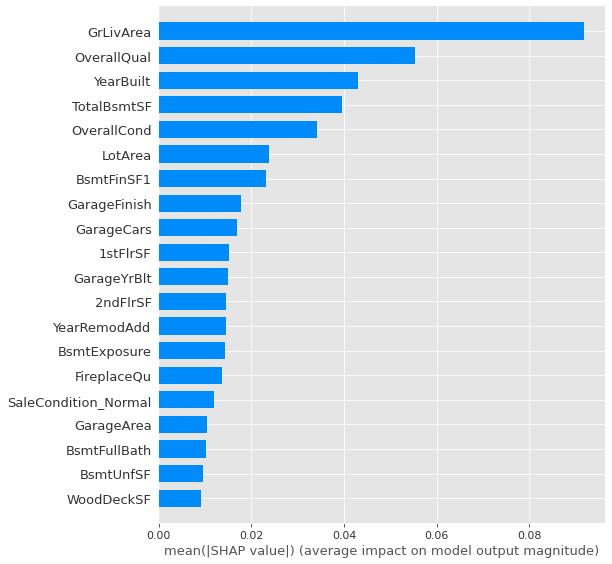

In [ ]:
explainer_xgb = shap.TreeExplainer(xgb)
shap_values_xgb = explainer_xgb.shap_values(X_test, y_test, approximate=True)

shap.summary_plot(shap_values_xgb, X_test, plot_type = 'bar')

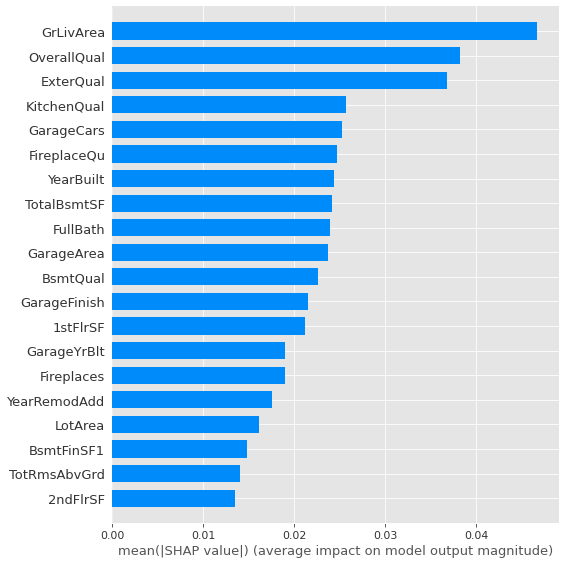

In [ ]:
explainer_rfc = shap.TreeExplainer(rfc)
shap_values_rfc = explainer_rfc.shap_values(X_test, y_test, approximate=True)

shap.summary_plot(shap_values_rfc, X_test, plot_type = 'bar')

OverallQual, GrLivArea and ExterQual are the most powerful contributers/influencers to the SalePrice regression in both models. We'll take random forest and take a look in his behaviour

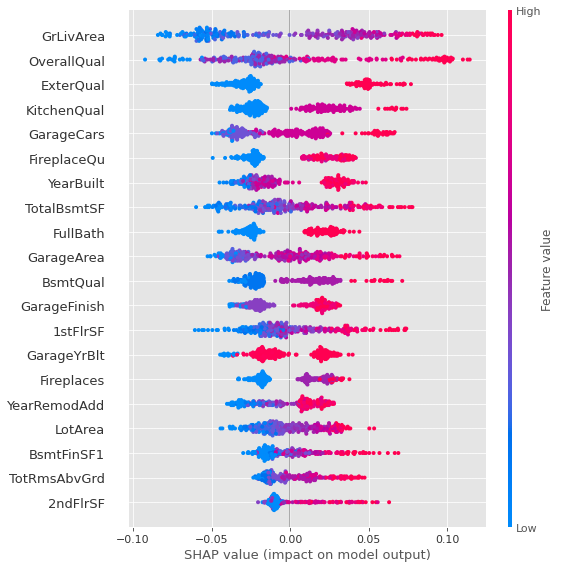

In [ ]:
shap.summary_plot(shap_values_rfc, X_test)

Majority of the top features have positive correlation with the SalePrices. Higher values equate to higher prices while lower values equate to lower prices.

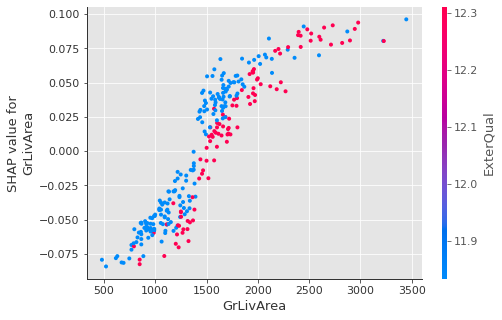

In [ ]:
shap.dependence_plot("GrLivArea", shap_values_rfc, X_test)


We can see like a linear relationship between GrLivArea and the sale price. With high values of GrLivArea the sale price is higher. And also in most cases ExterQual is high when GrLivArea is high.

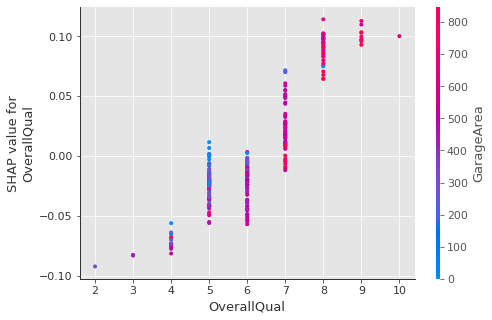

In [ ]:
shap.dependence_plot("OverallQual", shap_values_rfc, X_test)


High values of OverallQual means high sale prices and high values of GarageArea


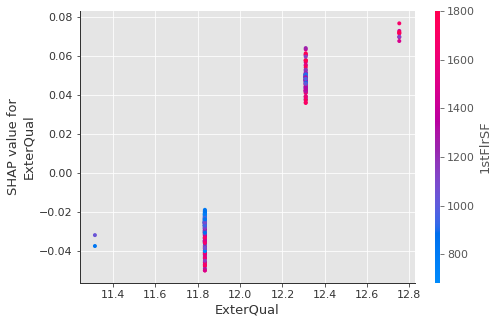

In [ ]:
shap.dependence_plot("ExterQual", shap_values_rfc, X_test)


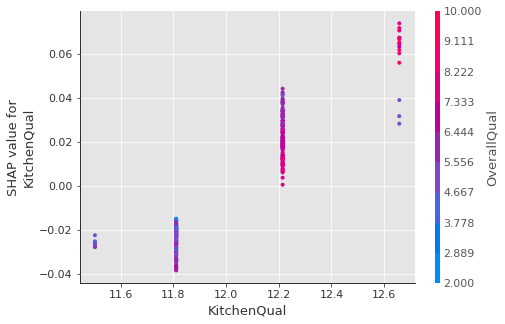

In [ ]:
shap.dependence_plot("KitchenQual", shap_values_rfc, X_test)


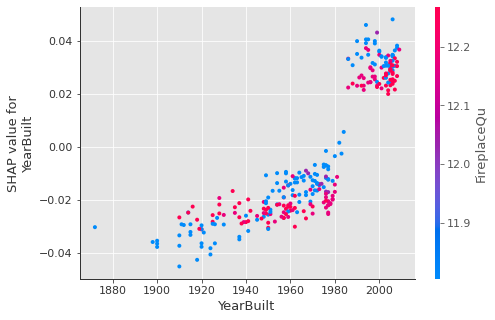

In [ ]:
shap.dependence_plot("YearBuilt", shap_values_rfc, X_test)


This graph is a bit special. After 1980 the sale price increases a lot and also the GrLivArea. Maybe in these years there was a tendency to start building big houses.

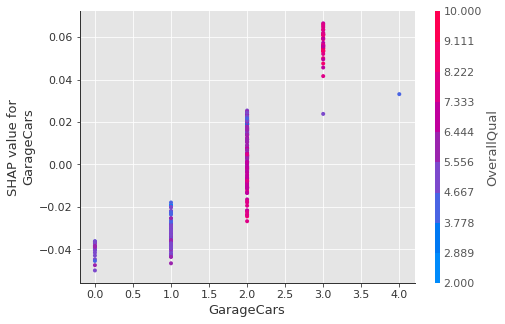

In [ ]:
shap.dependence_plot("GarageCars", shap_values_rfc, X_test)


Big garages are related to high values of OverallQual and sale price

In [ ]:
# Get the predictions and put them with the test data.
X_output = X_test.copy()
X_output.loc[:,'predict'] = np.round(rfc.predict(X_output),2)
# X_output['predict'] = np.exp(X_output['predict'])

# Randomly pick some observations
random_picks = np.arange(1,292,50) # Every 50 rows
S = X_output.iloc[random_picks]
S

MSSubClass  LotFrontage  ...  SaleCondition_Partial  predict
171           20        141.0  ...                      0    12.07
869           60         80.0  ...                      0    12.33
1433          60         93.0  ...                      0    12.15
607           20         78.0  ...                      0    11.99
484           20         69.0  ...                      0    11.78
1291         160         21.0  ...                      0    11.59

[6 rows x 169 columns]

In [ ]:
# Initialize your Jupyter notebook with initjs(), otherwise you will get an error message.
shap.initjs()

# Write in a function
def shap_plot(j):
    shap_values_Model = explainer_rfc.shap_values(S)
    p = shap.force_plot(explainer_rfc.expected_value, shap_values_Model[j], S.iloc[[j]])
    return(p)

In [ ]:
shap.initjs()

shap_plot(0)

The output value is the prediction for the first observation in this case. The value of predict in the table above for the first row is 12.07. Remember that we have our sales prices with the log applied. The base value is the mean prediction. Let's discuss some impact of some variables.

In [ ]:
print("Mean of GrLivArea: " + str(mean(X_test['GrLivArea'])))
print("Mean of OverallQual: " + str(mean(X_test['OverallQual'])))
print("Mean of ExterQual: " + str(mean(X_test['ExterQual'])))
print("Mean of KitchenQual: " + str(mean(X_test['KitchenQual'])))
print("Mean of Garage Cars: " + str(mean(X_test['GarageCars'])))
print("Mean of FireplaceQu: " + str(mean(X_test['FireplaceQu'])))
print("Mean of Year Built: " + str(mean(X_test['YearBuilt'])))
print("Mean of TotalBsmtSF: " + str(mean(X_test['TotalBsmtSF'])))
print("Mean of FullBath: " + str(mean(X_test['FullBath'])))

Mean of GrLivArea: 1512.0890410958905
Mean of OverallQual: 6.082191780821918
Mean of ExterQual: 12.007148653860915
Mean of KitchenQual: 12.015419483399683
Mean of Garage Cars: 1.7123287671232876
Mean of FireplaceQu: 12.017959041546325
Mean of Year Built: 1969.6609589041095
Mean of TotalBsmtSF: 1054.3424657534247
Mean of FullBath: 1.5616438356164384


GrLivArea is bigger than the mean so it pushes the prediction to the right. OverallQual and ExterQual are smaller than their respective mean so they push the prediction to the left. The year when the house was built is smaller than 1980 and smaller than the mean so it pushes the prediction to the left.

In [ ]:
shap.initjs()

shap_plot(1)

In this example most of our more importante features are bigger than the mean so they push the prediction to the right.

In [ ]:
real_value=pd.DataFrame({'count':np.exp(y_test)})
predict_value=pd.DataFrame({'count':np.exp(y_pred_test)})
with pd.ExcelWriter('c:\\test.xls') as writer:
    real_value.to_excel(writer, sheet_name='Sheet1')
    predict_value.to_excel(writer, sheet_name='Sheet2')

As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.


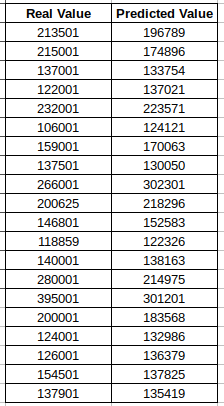

Let's check some examples of our predicted values. We'll take two cases, one where predicted value is similar to the real value and another where our predicted value is so different from the real value.

In [ ]:
X_test.loc[585, [ 'GrLivArea',
'OverallQual',
'ExterQual',
'KitchenQual',
'GarageCars',
'FireplaceQu',
'YearBuilt',
'TotalBsmtSF',
'FullBath',
'GarageArea',
'BsmtQual',
'GarageFinish',
'1stFlrSF',
'GarageYrBlt',
'Fireplaces',
'YearRemodAdd',
'LotArea',
'BsmtFinSF1',
'TotRmsAbvGrd',
'2ndFlrSF',

]]

GrLivArea        2028.000000
OverallQual         8.000000
ExterQual          12.310305
KitchenQual        12.214737
GarageCars          3.000000
FireplaceQu        12.267088
YearBuilt        2005.000000
TotalBsmtSF      1868.000000
FullBath            2.000000
GarageArea        880.000000
BsmtQual           12.642319
GarageFinish       12.167846
1stFlrSF         2028.000000
GarageYrBlt      2005.000000
Fireplaces          2.000000
YearRemodAdd     2006.000000
LotArea         11443.000000
BsmtFinSF1       1460.000000
TotRmsAbvGrd        7.000000
2ndFlrSF            0.000000
Name: 585, dtype: float64

In [ ]:
print("The real value is: " + str(round(np.exp(y_test.loc[585]))))
print("The predicted value is: " + str(round(np.exp(y_pred_test[186]))))

The real value is: 369901
The predicted value is: 366790


In [ ]:
example = X_test.loc[585,:]
shap.initjs()

shap_values_Model = explainer_rfc.shap_values(example)
shap.force_plot(explainer_rfc.expected_value, shap_values_Model, example)

In [ ]:
print("Mean of GrLivArea: " + str(mean(X_test['GrLivArea'])))
print("Mean of OverallQual: " + str(mean(X_test['OverallQual'])))
print("Mean of ExterQual: " + str(mean(X_test['ExterQual'])))
print("Mean of KitchenQual: " + str(mean(X_test['KitchenQual'])))
print("Mean of Garage Cars: " + str(mean(X_test['GarageCars'])))
print("Mean of FireplaceQu: " + str(mean(X_test['FireplaceQu'])))
print("Mean of Year Built: " + str(mean(X_test['YearBuilt'])))
print("Mean of TotalBsmtSF: " + str(mean(X_test['TotalBsmtSF'])))
print("Mean of FullBath: " + str(mean(X_test['FullBath'])))
print("Mean of GarageArea: " + str(mean(X_test['GarageArea'])))
print("Mean of BsmtQual: " + str(mean(X_test['BsmtQual'])))
print("Mean of GarageFinish: " + str(mean(X_test['GarageFinish'])))
print("Mean of 1stFlrSF: " + str(mean(X_test['1stFlrSF'])))
print("Mean of GarageYrBlt: " + str(mean(X_test['GarageYrBlt'])))
print("Mean of Fireplaces: " + str(mean(X_test['Fireplaces'])))
print("Mean of YearRemodAdd: " + str(mean(X_test['YearRemodAdd'])))
print("Mean of LotArea: " + str(mean(X_test['LotArea'])))
print("Mean of BsmtFinSF1: " + str(mean(X_test['BsmtFinSF1'])))
print("Mean of TotRmsAbvGrd: " + str(mean(X_test['TotRmsAbvGrd'])))
print("Mean of 2ndFlrSF: " + str(mean(X_test['2ndFlrSF'])))


Mean of GrLivArea: 1512.0890410958905
Mean of OverallQual: 6.082191780821918
Mean of ExterQual: 12.007148653860915
Mean of KitchenQual: 12.015419483399683
Mean of Garage Cars: 1.7123287671232876
Mean of FireplaceQu: 12.017959041546325
Mean of Year Built: 1969.6609589041095
Mean of TotalBsmtSF: 1054.3424657534247
Mean of FullBath: 1.5616438356164384
Mean of GarageArea: 461.0445205479452
Mean of BsmtQual: 11.995771975333296
Mean of GarageFinish: 11.996098541559324
Mean of 1stFlrSF: 1176.5513698630136
Mean of GarageYrBlt: 1861.541095890411
Mean of Fireplaces: 0.613013698630137
Mean of YearRemodAdd: 1983.3561643835617
Mean of LotArea: 10401.63698630137
Mean of BsmtFinSF1: 441.7842465753425
Mean of TotRmsAbvGrd: 6.582191780821918
Mean of 2ndFlrSF: 334.83561643835617


In [ ]:
X_test.loc[774, [ 'GrLivArea',
'OverallQual',
'ExterQual',
'KitchenQual',
'GarageCars',
'FireplaceQu',
'YearBuilt',
'TotalBsmtSF',
'FullBath',
'GarageArea',
'BsmtQual',
'GarageFinish',
'1stFlrSF',
'GarageYrBlt',
'Fireplaces',
'YearRemodAdd',
'LotArea',
'BsmtFinSF1',
'TotRmsAbvGrd',
'2ndFlrSF',
]]

GrLivArea        1973.000000
OverallQual         8.000000
ExterQual          12.310305
KitchenQual        12.214737
GarageCars          3.000000
FireplaceQu        12.267088
YearBuilt        2006.000000
TotalBsmtSF      1935.000000
FullBath            2.000000
GarageArea        895.000000
BsmtQual           12.177274
GarageFinish       12.317935
1stFlrSF         1973.000000
GarageYrBlt      2006.000000
Fireplaces          1.000000
YearRemodAdd     2006.000000
LotArea         14226.000000
BsmtFinSF1          0.000000
TotRmsAbvGrd        9.000000
2ndFlrSF            0.000000
Name: 774, dtype: float64

In [ ]:
print("The real value is: " + str(round(np.exp(y_test.loc[774]))))
print("The predicted value is: " + str(round(np.exp(y_pred_test[14]))))

The real value is: 395001
The predicted value is: 301201


In [ ]:
example = X_test.loc[774,:]
shap.initjs()

shap_values_Model = explainer_rfc.shap_values(example)
shap.force_plot(explainer_rfc.expected_value, shap_values_Model, example)

In [ ]:
X_test.loc[1058, [ 'GrLivArea',
'OverallQual',
'ExterQual',
'KitchenQual',
'GarageCars',
'FireplaceQu',
'YearBuilt',
'TotalBsmtSF',
'FullBath',
'GarageArea',
'BsmtQual',
'GarageFinish',
'1stFlrSF',
'GarageYrBlt',
'Fireplaces',
'YearRemodAdd',
'LotArea',
'BsmtFinSF1',
'TotRmsAbvGrd',
'2ndFlrSF',
]]

GrLivArea        2184.000000
OverallQual         9.000000
ExterQual          12.752440
KitchenQual        12.657739
GarageCars          3.000000
FireplaceQu        12.267088
YearBuilt        2008.000000
TotalBsmtSF      1104.000000
FullBath            2.000000
GarageArea        836.000000
BsmtQual           12.642319
GarageFinish       12.317935
1stFlrSF         1130.000000
GarageYrBlt      2008.000000
Fireplaces          1.000000
YearRemodAdd     2008.000000
LotArea         11308.000000
BsmtFinSF1        936.000000
TotRmsAbvGrd       10.000000
2ndFlrSF         1054.000000
Name: 1058, dtype: float64

In [ ]:
print("The real value is: " + str(round(np.exp(y_test.loc[1058]))))
print("The predicted value is: " + str(round(np.exp(y_pred_test[121]))))

The real value is: 335001
The predicted value is: 328023


In [ ]:
example = X_test.loc[1058,:]
shap.initjs()

shap_values_Model = explainer_rfc.shap_values(example)
shap.force_plot(explainer_rfc.expected_value, shap_values_Model, example)

In [ ]:
X_test.loc[322, [ 'GrLivArea',
'OverallQual',
'ExterQual',
'KitchenQual',
'GarageCars',
'FireplaceQu',
'YearBuilt',
'TotalBsmtSF',
'FullBath',
'GarageArea',
'BsmtQual',
'GarageFinish',
'1stFlrSF',
'GarageYrBlt',
'Fireplaces',
'YearRemodAdd',
'LotArea',
'BsmtFinSF1',
'TotRmsAbvGrd',
'2ndFlrSF',
]]

GrLivArea        2730.000000
OverallQual         7.000000
ExterQual          12.310305
KitchenQual        12.214737
GarageCars          2.000000
FireplaceQu        12.174559
YearBuilt        1986.000000
TotalBsmtSF      1502.000000
FullBath            2.000000
GarageArea        576.000000
BsmtQual           11.799341
GarageFinish       12.317935
1stFlrSF         1553.000000
GarageYrBlt      1987.000000
Fireplaces          1.000000
YearRemodAdd     1987.000000
LotArea         10380.000000
BsmtFinSF1         28.000000
TotRmsAbvGrd        8.000000
2ndFlrSF         1177.000000
Name: 322, dtype: float64

In [ ]:
print("The real value is: " + str(round(np.exp(y_test.loc[322]))))
print("The predicted value is: " + str(round(np.exp(y_pred_test[116]))))

The real value is: 301001
The predicted value is: 245791


In [ ]:
example = X_test.loc[322,:]
shap.initjs()

shap_values_Model = explainer_rfc.shap_values(example)
shap.force_plot(explainer_rfc.expected_value, shap_values_Model, example)

Checking these four examples where one of our predictions was closer to the real value and the other three not similar the conclusion that I can make is that for large real values our values of the most important features should be bigger than the mean so they push the prediction to the right(make it bigger). 

In [ ]:
X_test.loc[514, [ 'GrLivArea',
'OverallQual',
'ExterQual',
'KitchenQual',
'GarageCars',
'FireplaceQu',
'YearBuilt',
'TotalBsmtSF',
'FullBath',
'GarageArea',
'BsmtQual',
'GarageFinish',
'1stFlrSF',
'GarageYrBlt',
'Fireplaces',
'YearRemodAdd',
'LotArea',
'BsmtFinSF1',
'TotRmsAbvGrd',
'2ndFlrSF',
]]

GrLivArea         789.000000
OverallQual         5.000000
ExterQual          11.833764
KitchenQual        11.810309
GarageCars          1.000000
FireplaceQu        11.805498
YearBuilt        1926.000000
TotalBsmtSF       768.000000
FullBath            1.000000
GarageArea        200.000000
BsmtQual           11.799341
GarageFinish       11.815181
1stFlrSF          789.000000
GarageYrBlt      1926.000000
Fireplaces          0.000000
YearRemodAdd     1950.000000
LotArea         10594.000000
BsmtFinSF1          0.000000
TotRmsAbvGrd        5.000000
2ndFlrSF            0.000000
Name: 514, dtype: float64

In [ ]:
print("The real value is: " + str(round(np.exp(y_test.loc[514]))))
print("The predicted value is: " + str(round(np.exp(y_pred_test[27]))))

The real value is: 96501
The predicted value is: 92924


In [ ]:
example = X_test.loc[514,:]
shap.initjs()

shap_values_Model = explainer_rfc.shap_values(example)
shap.force_plot(explainer_rfc.expected_value, shap_values_Model, example)

In [ ]:
X_test.loc[812, [ 'GrLivArea',
'OverallQual',
'ExterQual',
'KitchenQual',
'GarageCars',
'FireplaceQu',
'YearBuilt',
'TotalBsmtSF',
'FullBath',
'GarageArea',
'BsmtQual',
'GarageFinish',
'1stFlrSF',
'GarageYrBlt',
'Fireplaces',
'YearRemodAdd',
'LotArea',
'BsmtFinSF1',
'TotRmsAbvGrd',
'2ndFlrSF',
]]

GrLivArea       1044.000000
OverallQual        5.000000
ExterQual         11.314086
KitchenQual       11.501823
GarageCars         2.000000
FireplaceQu       11.805498
YearBuilt       1952.000000
TotalBsmtSF      540.000000
FullBath           1.000000
GarageArea       504.000000
BsmtQual          11.799341
GarageFinish      11.815181
1stFlrSF        1044.000000
GarageYrBlt     1952.000000
Fireplaces         0.000000
YearRemodAdd    1952.000000
LotArea         8712.000000
BsmtFinSF1         0.000000
TotRmsAbvGrd       4.000000
2ndFlrSF           0.000000
Name: 812, dtype: float64

In [ ]:
print("The real value is: " + str(round(np.exp(y_test.loc[812]))))
print("The predicted value is: " + str(round(np.exp(y_pred_test[44]))))

The real value is: 55994
The predicted value is: 100733


In [ ]:
example = X_test.loc[812,:]
shap.initjs()

shap_values_Model = explainer_rfc.shap_values(example)
shap.force_plot(explainer_rfc.expected_value, shap_values_Model, example)

In [ ]:
print("Mean of GrLivArea: " + str(mean(X_test['GrLivArea'])))
print("Mean of OverallQual: " + str(mean(X_test['OverallQual'])))
print("Mean of ExterQual: " + str(mean(X_test['ExterQual'])))
print("Mean of KitchenQual: " + str(mean(X_test['KitchenQual'])))
print("Mean of Garage Cars: " + str(mean(X_test['GarageCars'])))
print("Mean of FireplaceQu: " + str(mean(X_test['FireplaceQu'])))
print("Mean of Year Built: " + str(mean(X_test['YearBuilt'])))
print("Mean of TotalBsmtSF: " + str(mean(X_test['TotalBsmtSF'])))
print("Mean of FullBath: " + str(mean(X_test['FullBath'])))
print("Mean of GarageArea: " + str(mean(X_test['GarageArea'])))
print("Mean of BsmtQual: " + str(mean(X_test['BsmtQual'])))
print("Mean of GarageFinish: " + str(mean(X_test['GarageFinish'])))
print("Mean of 1stFlrSF: " + str(mean(X_test['1stFlrSF'])))
print("Mean of GarageYrBlt: " + str(mean(X_test['GarageYrBlt'])))
print("Mean of Fireplaces: " + str(mean(X_test['Fireplaces'])))
print("Mean of YearRemodAdd: " + str(mean(X_test['YearRemodAdd'])))
print("Mean of LotArea: " + str(mean(X_test['LotArea'])))
print("Mean of BsmtFinSF1: " + str(mean(X_test['BsmtFinSF1'])))
print("Mean of TotRmsAbvGrd: " + str(mean(X_test['TotRmsAbvGrd'])))
print("Mean of 2ndFlrSF: " + str(mean(X_test['2ndFlrSF'])))

Mean of GrLivArea: 1512.0890410958905
Mean of OverallQual: 6.082191780821918
Mean of ExterQual: 12.007148653860915
Mean of KitchenQual: 12.015419483399683
Mean of Garage Cars: 1.7123287671232876
Mean of FireplaceQu: 12.017959041546325
Mean of Year Built: 1969.6609589041095
Mean of TotalBsmtSF: 1054.3424657534247
Mean of FullBath: 1.5616438356164384
Mean of GarageArea: 461.0445205479452
Mean of BsmtQual: 11.995771975333296
Mean of GarageFinish: 11.996098541559324
Mean of 1stFlrSF: 1176.5513698630136
Mean of GarageYrBlt: 1861.541095890411
Mean of Fireplaces: 0.613013698630137
Mean of YearRemodAdd: 1983.3561643835617
Mean of LotArea: 10401.63698630137
Mean of BsmtFinSF1: 441.7842465753425
Mean of TotRmsAbvGrd: 6.582191780821918
Mean of 2ndFlrSF: 334.83561643835617


In these cases that the real values of the houses are smaller, we need our values of features to be smaller than the mean. For the last case GarageCars and GarageArea are bigger than the mean so the prediction is more high.